In [1]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import sys
import os
import math

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets

from IPython.display import display

# Finally, pycroscopy itself
import pycroscopy as px

from os.path import join as pjoin

# set up notebook to show plots within the notebook
% matplotlib inline

import glob



In [8]:
# Grabbing the experimental data file to be analyzed and checking the file type (may not be in h5) 
input_file_path ='D:/PZT001_BEPs_0003.h5' #px.io_utils.uiGetFile(caption='Select translated .h5 file or raw experiment data',
                                         #filter='Translated file (*.h5);; \\ Parameters for raw BE data (*.txt *.mat *xls *.xlsx)')

(data_dir, data_name) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = px.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = px.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)
    tl = px.LabViewH5Patcher()
    hdf = tl.translate(h5_path)
print('Working on:\n' + h5_path)

h5_main = px.hdf_utils.getDataSet(hdf.file, 'Raw_Data')[0]

File is already Pycroscopy ready.
Working on:
D:/PZT001_BEPs_0003.h5


In [9]:
# Either performs SHO fits or uses previous fit saved in the file (code taken from pycroscopy)
h5_sho_group = px.hdf_utils.findH5group(h5_main, 'SHO_Fit')
sho_fitter = px.BESHOmodel(h5_main, parallel=True)
if len(h5_sho_group) == 0:
    print('No SHO fit found. Doing SHO Fitting now')
    h5_sho_guess = sho_fitter.do_guess(strategy='complex_gaussian', processors=max_cores)
    h5_sho_fit = sho_fitter.do_fit(processors=max_cores)
else:
    print('Taking previous SHO results already present in file')
    h5_sho_guess = h5_sho_group[-1]['Guess']
    try:
        h5_sho_fit = h5_sho_group[-1]['Fit']
    except KeyError:
        print('Previously computed guess found. Now computing fit')
        h5_sho_fit = sho_fitter.do_fit(processors=max_cores, h5_guess=h5_sho_guess)

Taking previous SHO results already present in file


In [10]:
# Specify output file path
output_file_path = './'

# If HV amplifier was used set high_voltage_amplf to 10, else to 1
high_voltage_amplf = 10


In [11]:
# Reshapes the data from hdf5 to numpy array of  shape (x, y, steps, on/off, loop#)
(Nd_mat, success) = px.io.hdf_utils.reshape_to_Ndims(h5_sho_fit)
print('Reshape Success = ' + str(success))
print('Nd_mat shape = ', Nd_mat.shape)

phase_offset = Nd_mat[0, 0, 1, 0, 0]['Phase [rad]']

# phase_offset = 0;

print('Phase offset [rad] = ', phase_offset)

Nd_mat[:,:,:,:,:]['Phase [rad]'] = Nd_mat[:,:,:,:,:]['Phase [rad]'] - phase_offset

Reshape Success = True
Nd_mat shape =  (80, 80, 128, 2, 3)
Phase offset [rad] =  0.342565


In [6]:
# Importing libraries for the Autoencoders
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'     #Allows for manual assignment of GPUs

from scipy import io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1



% matplotlib inline

Using TensorFlow backend.


In [15]:
# Pulling data channels and assigning variables for the voltage on and off conditions
amp_off = np.atleast_3d(Nd_mat["Amplitude [V]"][:,:,:,1,2].reshape(-1,128)) # amplitude signal
phase_off = np.atleast_3d(Nd_mat["Phase [rad]"][:,:,:,1,2].reshape(-1,128)) # phase signal
freq_off = np.atleast_3d(Nd_mat["Frequency [Hz]"][:,:,:,1,2].reshape(-1,128)) #frequency or resonance
qf_off = np.atleast_3d(Nd_mat["Quality Factor"][:,:,:,1,2].reshape(-1,128)) #quality factor

amp_on = np.atleast_3d(Nd_mat["Amplitude [V]"][:,:,:,0,2].reshape(-1,128))
phase_on = np.atleast_3d(Nd_mat["Phase [rad]"][:,:,:,0,2].reshape(-1,128))
freq_on = np.atleast_3d(Nd_mat["Frequency [Hz]"][:,:,:,0,2].reshape(-1,128))
qf_on= np.atleast_3d(Nd_mat["Quality Factor"][:,:,:,0,2].reshape(-1,128))

In [16]:
len(qf_on.reshape(-1))

819200

In [17]:
# Function to normalize the data channels
def norm(data_in):
    data_in-=np.mean(data_in)
    data_in/=np.std(data_in)
    return data_in

In [18]:
# Function that makes folder for output of the Autoencoder
def make_folder(folder_name, root='./'):

    folder = pjoin(root, '{}'.format(folder_name))
    os.makedirs(folder, exist_ok=True)

    return (folder)

In [10]:
# Normalizing the data chanels in order to improve autoencoder performance
amp_off = np.atleast_3d(norm(amp_off))
phase_off = np.atleast_3d(norm(phase_off))
freq_off = np.atleast_3d(norm(freq_off))
qf_off = np.atleast_3d(norm(qf_off))

amp_on = np.atleast_3d(norm(amp_on))
phase_on = np.atleast_3d(norm(phase_on))
freq_on = np.atleast_3d(norm(freq_on))
qf_on= np.atleast_3d(norm(qf_on))

In [19]:
#Removing noise from the qf signal and setting to mean
for i in range(len(qf_on.reshape(-1))):
    if qf_on.reshape(-1)[i] > 900:
        qf_on.reshape(-1)[i] = np.mean(qf_on)
        
for i in range(len(qf_off.reshape(-1))):
    if qf_off.reshape(-1)[i] > 900:
        qf_off.reshape(-1)[i] = np.mean(qf_off)

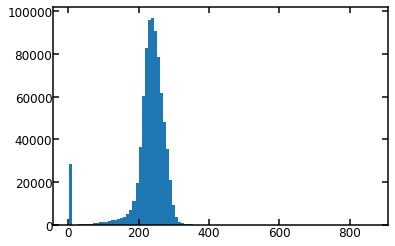

In [21]:
plt.hist(qf_on.reshape(-1),100)
plt.show()

In [13]:
# defining the encoding layer function, builds LSTM layers that precede dense layer
def encode_layer(size, numbernodes,x):
    for i in range(size-1):
        x = Bidirectional(LSTM(numbernodes, return_sequences=True))(x)
    out = Bidirectional(LSTM(numbernodes, return_sequences=False))(x)
    return out

In [14]:
# defining the decoding layer function, builds LSTM layers after dense layer
def decode_layer(size, numbernodes,x):
    x = RepeatVector(128)(x)
    for i in range(size):
        x = Bidirectional(LSTM(numbernodes, return_sequences=True))(x)
    x = TimeDistributed(Dense(1, activation='linear'))(x)
    return x

In [15]:
[Nd_mat["Phase [rad]"].shape[2],1] # checking the shape of the input data

[128, 1]

In [15]:
# building the autoencoder 
# input layers accept the shape of the BEPS data channel
input_on_amp = Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_off_amp =Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_on_phase =Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_off_phase =Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_on_resonance =Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_off_resonance = Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_on_loss =Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))
input_off_loss =Input(shape=(Nd_mat["Phase [rad]"].shape[2],1))


en_out_a_on = encode_layer(3,16,input_on_amp)
en_out_a_on = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_a_on)
en_out_a_off = encode_layer(3,16,input_off_amp)
en_out_a_off = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_a_off)
en_out_p_on = encode_layer(3,16,input_on_phase)
en_out_p_on = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_p_on)
en_out_p_off = encode_layer(3,16,input_off_phase)
en_out_p_off = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_p_off)
en_out_r_on = encode_layer(3,16,input_on_resonance)
en_out_r_on = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_r_on)
en_out_r_off = encode_layer(3,16,input_off_resonance)
en_out_r_off = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_r_off)
en_out_l_on = encode_layer(3,16,input_on_loss)
en_out_l_on = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_l_on)
en_out_l_off = encode_layer(3,16,input_off_loss)
en_out_l_off = Dense(4, activation='relu',activity_regularizer=l1(10e-4))(en_out_l_off)



x = keras.layers.concatenate([en_out_a_on, en_out_a_off, en_out_p_on, en_out_p_off,
                              en_out_r_on, en_out_r_off, en_out_l_on, en_out_l_off])

x = Dense(12, activation='relu',activity_regularizer=l1(10e-4))(x)

de_out_a_on = decode_layer(3,16,x)
de_out_a_off =decode_layer(3,16,x)
de_out_p_on = decode_layer(3,16,x)
de_out_p_off =decode_layer(3,16,x)
de_out_r_on = decode_layer(3,16,x)
de_out_r_off =decode_layer(3,16,x)
de_out_l_on = decode_layer(3,16,x)
de_out_l_off =decode_layer(3,16,x)

model = Model(inputs=[input_on_amp, input_off_amp, input_on_phase, input_off_phase, input_on_resonance,
                      input_off_resonance, input_on_loss, input_off_loss], 
              outputs=[de_out_a_on, de_out_a_off, de_out_p_on, de_out_p_off, de_out_r_on, de_out_r_off,
                       de_out_l_on, de_out_l_off])

model.compile(optimizer=Adam(3e-5),loss='mse')#

In [17]:
# Option to preload weights from a previous run, may be skipped
model = keras.models.load_model("try6/weights.54-7.96.hdf5")

In [18]:
#  Setting up the folder path for weight storage and 
Path = 'try8'
make_folder(Path)
tbCallBack = keras.callbacks.TensorBoard(
    log_dir='./' + Path, histogram_freq=0, write_graph=True, write_images=True)
filepath = './' + Path + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_best_only=True,
                                             save_weights_only=False, mode='min', period=1)

#Commented code in the case of multi_gpu utilization, currently not advised in keras, doesn't save
#from keras.utils import multi_gpu_model 

# Replicates `model` on 2 GPUs.
# This assumes that your machine has 2 available GPUs.
#parallel_model = multi_gpu_model(model, gpus=2)
#parallel_model.compile(optimizer=Adam(3e-5),loss='mse')
model.fit([amp_off,phase_off,freq_off,qf_off, amp_on, phase_on, freq_on, qf_on], 
          [amp_off,phase_off,freq_off,qf_off, amp_on, phase_on, freq_on, qf_on],
          validation_data=([amp_off,phase_off,freq_off,qf_off, amp_on, phase_on, freq_on, qf_on], 
          [amp_off,phase_off,freq_off,qf_off, amp_on, phase_on, freq_on, qf_on]),
          epochs=20000,batch_size=1024, callbacks=[tbCallBack, checkpoint])


Train on 6400 samples, validate on 6400 samples
Train on 6400 samples, validate on 6400 samples
Epoch 1/20000
Epoch 1/20000
6400/6400 [==============================] - 247s 39ms/step - loss: 7.9617 - time_distributed_1_loss: 0.9991 - time_distributed_2_loss: 0.9910 - time_distributed_3_loss: 0.9998 - time_distributed_4_loss: 0.9992 - time_distributed_5_loss: 0.9841 - time_distributed_6_loss: 0.9845 - time_distributed_7_loss: 0.9996 - time_distributed_8_loss: 0.9990 - val_loss: 7.9595 - val_time_distributed_1_loss: 0.9991 - val_time_distributed_2_loss: 0.9907 - val_time_distributed_3_loss: 0.9998 - val_time_distributed_4_loss: 0.9992 - val_time_distributed_5_loss: 0.9833 - val_time_distributed_6_loss: 0.9838 - val_time_distributed_7_loss: 0.9996 - val_time_distributed_8_loss: 0.9990
Epoch 2/20000
Epoch 2/20000
6400/6400 [==============================] - 180s 28ms/step - loss: 7.9586 - time_distributed_1_loss: 0.9991 - time_distributed_2_loss: 0.9905 - time_distributed_3_loss: 0.9998 -

Epoch 7/20000
Epoch 7/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 7.9383 - time_distributed_1_loss: 0.9990 - time_distributed_2_loss: 0.9869 - time_distributed_3_loss: 0.9998 - time_distributed_4_loss: 0.9991 - time_distributed_5_loss: 0.9743 - time_distributed_6_loss: 0.9764 - time_distributed_7_loss: 0.9996 - time_distributed_8_loss: 0.9988 - val_loss: 7.9349 - val_time_distributed_1_loss: 0.9989 - val_time_distributed_2_loss: 0.9863 - val_time_distributed_3_loss: 0.9998 - val_time_distributed_4_loss: 0.9991 - val_time_distributed_5_loss: 0.9729 - val_time_distributed_6_loss: 0.9753 - val_time_distributed_7_loss: 0.9995 - val_time_distributed_8_loss: 0.9988
Epoch 8/20000
Epoch 8/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 7.9331 - time_distributed_1_loss: 0.9989 - time_distributed_2_loss: 0.9860 - time_distributed_3_loss: 0.9998 - time_distributed_4_loss: 0.9991 - time_distributed_5_loss: 0.9721 - time_distributed_6_loss: 0.

Epoch 13/20000
Epoch 13/20000
6400/6400 [==============================] - 176s 27ms/step - loss: 7.8999 - time_distributed_1_loss: 0.9987 - time_distributed_2_loss: 0.9801 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9989 - time_distributed_5_loss: 0.9567 - time_distributed_6_loss: 0.9636 - time_distributed_7_loss: 0.9995 - time_distributed_8_loss: 0.9986 - val_loss: 7.8943 - val_time_distributed_1_loss: 0.9987 - val_time_distributed_2_loss: 0.9792 - val_time_distributed_3_loss: 0.9997 - val_time_distributed_4_loss: 0.9989 - val_time_distributed_5_loss: 0.9542 - val_time_distributed_6_loss: 0.9619 - val_time_distributed_7_loss: 0.9995 - val_time_distributed_8_loss: 0.9985
Epoch 14/20000
Epoch 14/20000
6400/6400 [==============================] - 176s 27ms/step - loss: 7.8912 - time_distributed_1_loss: 0.9987 - time_distributed_2_loss: 0.9786 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9989 - time_distributed_5_loss: 0.9525 - time_distributed_6_loss

Epoch 19/20000
Epoch 19/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 7.8345 - time_distributed_1_loss: 0.9984 - time_distributed_2_loss: 0.9680 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9987 - time_distributed_5_loss: 0.9252 - time_distributed_6_loss: 0.9433 - time_distributed_7_loss: 0.9995 - time_distributed_8_loss: 0.9983 - val_loss: 7.8257 - val_time_distributed_1_loss: 0.9984 - val_time_distributed_2_loss: 0.9662 - val_time_distributed_3_loss: 0.9997 - val_time_distributed_4_loss: 0.9987 - val_time_distributed_5_loss: 0.9210 - val_time_distributed_6_loss: 0.9407 - val_time_distributed_7_loss: 0.9995 - val_time_distributed_8_loss: 0.9983
Epoch 20/20000
Epoch 20/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 7.8205 - time_distributed_1_loss: 0.9983 - time_distributed_2_loss: 0.9650 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9987 - time_distributed_5_loss: 0.9184 - time_distributed_6_loss

Epoch 25/20000
Epoch 25/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 7.7415 - time_distributed_1_loss: 0.9979 - time_distributed_2_loss: 0.9439 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9985 - time_distributed_5_loss: 0.8862 - time_distributed_6_loss: 0.9146 - time_distributed_7_loss: 0.9995 - time_distributed_8_loss: 0.9980 - val_loss: 7.7311 - val_time_distributed_1_loss: 0.9978 - val_time_distributed_2_loss: 0.9402 - val_time_distributed_3_loss: 0.9997 - val_time_distributed_4_loss: 0.9984 - val_time_distributed_5_loss: 0.8831 - val_time_distributed_6_loss: 0.9114 - val_time_distributed_7_loss: 0.9995 - val_time_distributed_8_loss: 0.9980
Epoch 26/20000
Epoch 26/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 7.7253 - time_distributed_1_loss: 0.9978 - time_distributed_2_loss: 0.9379 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9984 - time_distributed_5_loss: 0.8814 - time_distributed_6_loss

Epoch 31/20000
Epoch 31/20000
6400/6400 [==============================] - 181s 28ms/step - loss: 7.6415 - time_distributed_1_loss: 0.9971 - time_distributed_2_loss: 0.8951 - time_distributed_3_loss: 0.9997 - time_distributed_4_loss: 0.9982 - time_distributed_5_loss: 0.8653 - time_distributed_6_loss: 0.8859 - time_distributed_7_loss: 0.9994 - time_distributed_8_loss: 0.9977 - val_loss: 7.6299 - val_time_distributed_1_loss: 0.9969 - val_time_distributed_2_loss: 0.8880 - val_time_distributed_3_loss: 0.9996 - val_time_distributed_4_loss: 0.9982 - val_time_distributed_5_loss: 0.8637 - val_time_distributed_6_loss: 0.8834 - val_time_distributed_7_loss: 0.9994 - val_time_distributed_8_loss: 0.9976
Epoch 32/20000
Epoch 32/20000
6400/6400 [==============================] - 178s 28ms/step - loss: 7.6230 - time_distributed_1_loss: 0.9969 - time_distributed_2_loss: 0.8834 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9981 - time_distributed_5_loss: 0.8628 - time_distributed_6_loss

Epoch 37/20000
Epoch 37/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 7.5134 - time_distributed_1_loss: 0.9956 - time_distributed_2_loss: 0.8052 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9979 - time_distributed_5_loss: 0.8500 - time_distributed_6_loss: 0.8652 - time_distributed_7_loss: 0.9994 - time_distributed_8_loss: 0.9973 - val_loss: 7.4972 - val_time_distributed_1_loss: 0.9954 - val_time_distributed_2_loss: 0.7931 - val_time_distributed_3_loss: 0.9996 - val_time_distributed_4_loss: 0.9978 - val_time_distributed_5_loss: 0.8483 - val_time_distributed_6_loss: 0.8633 - val_time_distributed_7_loss: 0.9994 - val_time_distributed_8_loss: 0.9972
Epoch 38/20000
Epoch 38/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 7.4875 - time_distributed_1_loss: 0.9952 - time_distributed_2_loss: 0.7856 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9978 - time_distributed_5_loss: 0.8473 - time_distributed_6_loss

Epoch 43/20000
Epoch 43/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 7.3469 - time_distributed_1_loss: 0.9927 - time_distributed_2_loss: 0.6792 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9975 - time_distributed_5_loss: 0.8320 - time_distributed_6_loss: 0.8463 - time_distributed_7_loss: 0.9994 - time_distributed_8_loss: 0.9968 - val_loss: 7.3287 - val_time_distributed_1_loss: 0.9923 - val_time_distributed_2_loss: 0.6662 - val_time_distributed_3_loss: 0.9996 - val_time_distributed_4_loss: 0.9974 - val_time_distributed_5_loss: 0.8297 - val_time_distributed_6_loss: 0.8443 - val_time_distributed_7_loss: 0.9993 - val_time_distributed_8_loss: 0.9968
Epoch 44/20000
Epoch 44/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 7.3180 - time_distributed_1_loss: 0.9920 - time_distributed_2_loss: 0.6584 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9974 - time_distributed_5_loss: 0.8283 - time_distributed_6_loss

Epoch 49/20000
Epoch 49/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 7.1405 - time_distributed_1_loss: 0.9865 - time_distributed_2_loss: 0.5325 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9970 - time_distributed_5_loss: 0.8031 - time_distributed_6_loss: 0.8231 - time_distributed_7_loss: 0.9993 - time_distributed_8_loss: 0.9963 - val_loss: 7.1097 - val_time_distributed_1_loss: 0.9855 - val_time_distributed_2_loss: 0.5095 - val_time_distributed_3_loss: 0.9995 - val_time_distributed_4_loss: 0.9970 - val_time_distributed_5_loss: 0.7995 - val_time_distributed_6_loss: 0.8202 - val_time_distributed_7_loss: 0.9993 - val_time_distributed_8_loss: 0.9963
Epoch 50/20000
Epoch 50/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 7.0910 - time_distributed_1_loss: 0.9848 - time_distributed_2_loss: 0.4955 - time_distributed_3_loss: 0.9995 - time_distributed_4_loss: 0.9970 - time_distributed_5_loss: 0.7974 - time_distributed_6_loss

Epoch 55/20000
Epoch 55/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 6.9077 - time_distributed_1_loss: 0.9717 - time_distributed_2_loss: 0.3782 - time_distributed_3_loss: 0.9995 - time_distributed_4_loss: 0.9965 - time_distributed_5_loss: 0.7772 - time_distributed_6_loss: 0.7862 - time_distributed_7_loss: 0.9993 - time_distributed_8_loss: 0.9957 - val_loss: 6.8903 - val_time_distributed_1_loss: 0.9695 - val_time_distributed_2_loss: 0.3707 - val_time_distributed_3_loss: 0.9995 - val_time_distributed_4_loss: 0.9965 - val_time_distributed_5_loss: 0.7751 - val_time_distributed_6_loss: 0.7809 - val_time_distributed_7_loss: 0.9993 - val_time_distributed_8_loss: 0.9957
Epoch 56/20000
Epoch 56/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 6.8804 - time_distributed_1_loss: 0.9681 - time_distributed_2_loss: 0.3666 - time_distributed_3_loss: 0.9995 - time_distributed_4_loss: 0.9964 - time_distributed_5_loss: 0.7739 - time_distributed_6_loss

Epoch 61/20000
Epoch 61/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 6.7440 - time_distributed_1_loss: 0.9571 - time_distributed_2_loss: 0.3263 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9960 - time_distributed_5_loss: 0.7491 - time_distributed_6_loss: 0.7170 - time_distributed_7_loss: 0.9993 - time_distributed_8_loss: 0.9950 - val_loss: 6.7253 - val_time_distributed_1_loss: 0.9568 - val_time_distributed_2_loss: 0.3228 - val_time_distributed_3_loss: 0.9996 - val_time_distributed_4_loss: 0.9959 - val_time_distributed_5_loss: 0.7438 - val_time_distributed_6_loss: 0.7076 - val_time_distributed_7_loss: 0.9993 - val_time_distributed_8_loss: 0.9949
Epoch 62/20000
Epoch 62/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 6.7154 - time_distributed_1_loss: 0.9569 - time_distributed_2_loss: 0.3210 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9959 - time_distributed_5_loss: 0.7407 - time_distributed_6_loss

Epoch 67/20000
Epoch 67/20000
6400/6400 [==============================] - 176s 27ms/step - loss: 6.5958 - time_distributed_1_loss: 0.9543 - time_distributed_2_loss: 0.3013 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9954 - time_distributed_5_loss: 0.7064 - time_distributed_6_loss: 0.6380 - time_distributed_7_loss: 0.9995 - time_distributed_8_loss: 0.9941 - val_loss: 6.5871 - val_time_distributed_1_loss: 0.9543 - val_time_distributed_2_loss: 0.2995 - val_time_distributed_3_loss: 0.9996 - val_time_distributed_4_loss: 0.9953 - val_time_distributed_5_loss: 0.7044 - val_time_distributed_6_loss: 0.6334 - val_time_distributed_7_loss: 0.9995 - val_time_distributed_8_loss: 0.9940
Epoch 68/20000
Epoch 68/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 6.5832 - time_distributed_1_loss: 0.9542 - time_distributed_2_loss: 0.2986 - time_distributed_3_loss: 0.9996 - time_distributed_4_loss: 0.9953 - time_distributed_5_loss: 0.7035 - time_distributed_6_loss

Epoch 73/20000
Epoch 73/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 6.5430 - time_distributed_1_loss: 0.9477 - time_distributed_2_loss: 0.2912 - time_distributed_3_loss: 0.9995 - time_distributed_4_loss: 0.9947 - time_distributed_5_loss: 0.6927 - time_distributed_6_loss: 0.6114 - time_distributed_7_loss: 0.9995 - time_distributed_8_loss: 0.9928 - val_loss: 6.5381 - val_time_distributed_1_loss: 0.9460 - val_time_distributed_2_loss: 0.2912 - val_time_distributed_3_loss: 0.9995 - val_time_distributed_4_loss: 0.9946 - val_time_distributed_5_loss: 0.6912 - val_time_distributed_6_loss: 0.6098 - val_time_distributed_7_loss: 0.9995 - val_time_distributed_8_loss: 0.9926
Epoch 74/20000
Epoch 74/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 6.5366 - time_distributed_1_loss: 0.9450 - time_distributed_2_loss: 0.2912 - time_distributed_3_loss: 0.9995 - time_distributed_4_loss: 0.9946 - time_distributed_5_loss: 0.6902 - time_distributed_6_loss

Epoch 79/20000
Epoch 79/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 6.5011 - time_distributed_1_loss: 0.9252 - time_distributed_2_loss: 0.2900 - time_distributed_3_loss: 0.9994 - time_distributed_4_loss: 0.9939 - time_distributed_5_loss: 0.6770 - time_distributed_6_loss: 0.5975 - time_distributed_7_loss: 0.9993 - time_distributed_8_loss: 0.9905 - val_loss: 6.4939 - val_time_distributed_1_loss: 0.9206 - val_time_distributed_2_loss: 0.2907 - val_time_distributed_3_loss: 0.9994 - val_time_distributed_4_loss: 0.9938 - val_time_distributed_5_loss: 0.6753 - val_time_distributed_6_loss: 0.5962 - val_time_distributed_7_loss: 0.9993 - val_time_distributed_8_loss: 0.9902
Epoch 80/20000
Epoch 80/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 6.4927 - time_distributed_1_loss: 0.9172 - time_distributed_2_loss: 0.2913 - time_distributed_3_loss: 0.9994 - time_distributed_4_loss: 0.9938 - time_distributed_5_loss: 0.6733 - time_distributed_6_loss

Epoch 85/20000
Epoch 85/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 6.4298 - time_distributed_1_loss: 0.8752 - time_distributed_2_loss: 0.2855 - time_distributed_3_loss: 0.9993 - time_distributed_4_loss: 0.9930 - time_distributed_5_loss: 0.6527 - time_distributed_6_loss: 0.5851 - time_distributed_7_loss: 0.9989 - time_distributed_8_loss: 0.9860 - val_loss: 6.4157 - val_time_distributed_1_loss: 0.8690 - val_time_distributed_2_loss: 0.2845 - val_time_distributed_3_loss: 0.9993 - val_time_distributed_4_loss: 0.9929 - val_time_distributed_5_loss: 0.6503 - val_time_distributed_6_loss: 0.5841 - val_time_distributed_7_loss: 0.9988 - val_time_distributed_8_loss: 0.9854
Epoch 86/20000
Epoch 86/20000
6400/6400 [==============================] - 176s 27ms/step - loss: 6.4160 - time_distributed_1_loss: 0.8648 - time_distributed_2_loss: 0.2842 - time_distributed_3_loss: 0.9993 - time_distributed_4_loss: 0.9928 - time_distributed_5_loss: 0.6491 - time_distributed_6_loss

Epoch 91/20000
Epoch 91/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 6.3527 - time_distributed_1_loss: 0.8357 - time_distributed_2_loss: 0.2737 - time_distributed_3_loss: 0.9992 - time_distributed_4_loss: 0.9915 - time_distributed_5_loss: 0.6307 - time_distributed_6_loss: 0.5732 - time_distributed_7_loss: 0.9984 - time_distributed_8_loss: 0.9777 - val_loss: 6.3384 - val_time_distributed_1_loss: 0.8379 - val_time_distributed_2_loss: 0.2722 - val_time_distributed_3_loss: 0.9993 - val_time_distributed_4_loss: 0.9910 - val_time_distributed_5_loss: 0.6243 - val_time_distributed_6_loss: 0.5706 - val_time_distributed_7_loss: 0.9984 - val_time_distributed_8_loss: 0.9752
Epoch 92/20000
Epoch 92/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 6.3411 - time_distributed_1_loss: 0.8383 - time_distributed_2_loss: 0.2716 - time_distributed_3_loss: 0.9993 - time_distributed_4_loss: 0.9908 - time_distributed_5_loss: 0.6213 - time_distributed_6_loss

Epoch 97/20000
Epoch 97/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 6.2786 - time_distributed_1_loss: 0.8332 - time_distributed_2_loss: 0.2590 - time_distributed_3_loss: 0.9991 - time_distributed_4_loss: 0.9880 - time_distributed_5_loss: 0.5929 - time_distributed_6_loss: 0.5596 - time_distributed_7_loss: 0.9979 - time_distributed_8_loss: 0.9601 - val_loss: 6.2631 - val_time_distributed_1_loss: 0.8329 - val_time_distributed_2_loss: 0.2578 - val_time_distributed_3_loss: 0.9991 - val_time_distributed_4_loss: 0.9873 - val_time_distributed_5_loss: 0.5886 - val_time_distributed_6_loss: 0.5584 - val_time_distributed_7_loss: 0.9978 - val_time_distributed_8_loss: 0.9578
Epoch 98/20000
Epoch 98/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 6.2637 - time_distributed_1_loss: 0.8339 - time_distributed_2_loss: 0.2569 - time_distributed_3_loss: 0.9990 - time_distributed_4_loss: 0.9869 - time_distributed_5_loss: 0.5847 - time_distributed_6_loss

Epoch 103/20000
Epoch 103/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 6.1737 - time_distributed_1_loss: 0.8110 - time_distributed_2_loss: 0.2528 - time_distributed_3_loss: 0.9979 - time_distributed_4_loss: 0.9796 - time_distributed_5_loss: 0.5425 - time_distributed_6_loss: 0.5487 - time_distributed_7_loss: 0.9956 - time_distributed_8_loss: 0.9320 - val_loss: 6.1561 - val_time_distributed_1_loss: 0.8059 - val_time_distributed_2_loss: 0.2527 - val_time_distributed_3_loss: 0.9977 - val_time_distributed_4_loss: 0.9785 - val_time_distributed_5_loss: 0.5391 - val_time_distributed_6_loss: 0.5479 - val_time_distributed_7_loss: 0.9952 - val_time_distributed_8_loss: 0.9291
Epoch 104/20000
Epoch 104/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 6.1546 - time_distributed_1_loss: 0.8036 - time_distributed_2_loss: 0.2526 - time_distributed_3_loss: 0.9976 - time_distributed_4_loss: 0.9777 - time_distributed_5_loss: 0.5371 - time_distributed_6_

Epoch 109/20000
Epoch 109/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 6.0447 - time_distributed_1_loss: 0.7730 - time_distributed_2_loss: 0.2515 - time_distributed_3_loss: 0.9946 - time_distributed_4_loss: 0.9608 - time_distributed_5_loss: 0.5147 - time_distributed_6_loss: 0.5388 - time_distributed_7_loss: 0.9896 - time_distributed_8_loss: 0.8880 - val_loss: 6.0236 - val_time_distributed_1_loss: 0.7657 - val_time_distributed_2_loss: 0.2515 - val_time_distributed_3_loss: 0.9939 - val_time_distributed_4_loss: 0.9577 - val_time_distributed_5_loss: 0.5120 - val_time_distributed_6_loss: 0.5377 - val_time_distributed_7_loss: 0.9885 - val_time_distributed_8_loss: 0.8836
Epoch 110/20000
Epoch 110/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 6.0176 - time_distributed_1_loss: 0.7618 - time_distributed_2_loss: 0.2516 - time_distributed_3_loss: 0.9935 - time_distributed_4_loss: 0.9558 - time_distributed_5_loss: 0.5102 - time_distributed_6_

Epoch 115/20000
Epoch 115/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 5.8769 - time_distributed_1_loss: 0.7238 - time_distributed_2_loss: 0.2504 - time_distributed_3_loss: 0.9857 - time_distributed_4_loss: 0.9120 - time_distributed_5_loss: 0.4995 - time_distributed_6_loss: 0.5281 - time_distributed_7_loss: 0.9738 - time_distributed_8_loss: 0.8500 - val_loss: 5.8524 - val_time_distributed_1_loss: 0.7210 - val_time_distributed_2_loss: 0.2492 - val_time_distributed_3_loss: 0.9843 - val_time_distributed_4_loss: 0.9033 - val_time_distributed_5_loss: 0.4983 - val_time_distributed_6_loss: 0.5268 - val_time_distributed_7_loss: 0.9710 - val_time_distributed_8_loss: 0.8472
Epoch 116/20000
Epoch 116/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 5.8439 - time_distributed_1_loss: 0.7195 - time_distributed_2_loss: 0.2492 - time_distributed_3_loss: 0.9833 - time_distributed_4_loss: 0.8973 - time_distributed_5_loss: 0.4982 - time_distributed_6_

Epoch 121/20000
Epoch 121/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 5.6263 - time_distributed_1_loss: 0.7021 - time_distributed_2_loss: 0.2402 - time_distributed_3_loss: 0.9578 - time_distributed_4_loss: 0.7774 - time_distributed_5_loss: 0.4956 - time_distributed_6_loss: 0.5109 - time_distributed_7_loss: 0.9136 - time_distributed_8_loss: 0.8363 - val_loss: 5.5876 - val_time_distributed_1_loss: 0.7007 - val_time_distributed_2_loss: 0.2383 - val_time_distributed_3_loss: 0.9524 - val_time_distributed_4_loss: 0.7596 - val_time_distributed_5_loss: 0.4944 - val_time_distributed_6_loss: 0.5090 - val_time_distributed_7_loss: 0.9017 - val_time_distributed_8_loss: 0.8355
Epoch 122/20000
Epoch 122/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 5.5688 - time_distributed_1_loss: 0.7001 - time_distributed_2_loss: 0.2372 - time_distributed_3_loss: 0.9486 - time_distributed_4_loss: 0.7500 - time_distributed_5_loss: 0.4938 - time_distributed_6_

Epoch 127/20000
Epoch 127/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 5.2541 - time_distributed_1_loss: 0.6820 - time_distributed_2_loss: 0.2333 - time_distributed_3_loss: 0.8539 - time_distributed_4_loss: 0.7101 - time_distributed_5_loss: 0.5018 - time_distributed_6_loss: 0.4906 - time_distributed_7_loss: 0.6846 - time_distributed_8_loss: 0.8379 - val_loss: 5.2006 - val_time_distributed_1_loss: 0.6785 - val_time_distributed_2_loss: 0.2348 - val_time_distributed_3_loss: 0.8321 - val_time_distributed_4_loss: 0.7097 - val_time_distributed_5_loss: 0.5029 - val_time_distributed_6_loss: 0.4879 - val_time_distributed_7_loss: 0.6467 - val_time_distributed_8_loss: 0.8393
Epoch 128/20000
Epoch 128/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 5.1672 - time_distributed_1_loss: 0.6766 - time_distributed_2_loss: 0.2329 - time_distributed_3_loss: 0.8165 - time_distributed_4_loss: 0.7104 - time_distributed_5_loss: 0.5039 - time_distributed_6_

Epoch 133/20000
Epoch 133/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 4.7074 - time_distributed_1_loss: 0.6624 - time_distributed_2_loss: 0.2269 - time_distributed_3_loss: 0.5578 - time_distributed_4_loss: 0.7301 - time_distributed_5_loss: 0.4982 - time_distributed_6_loss: 0.4690 - time_distributed_7_loss: 0.3817 - time_distributed_8_loss: 0.8464 - val_loss: 4.6566 - val_time_distributed_1_loss: 0.6610 - val_time_distributed_2_loss: 0.2264 - val_time_distributed_3_loss: 0.5316 - val_time_distributed_4_loss: 0.7298 - val_time_distributed_5_loss: 0.4922 - val_time_distributed_6_loss: 0.4669 - val_time_distributed_7_loss: 0.3721 - val_time_distributed_8_loss: 0.8449
Epoch 134/20000
Epoch 134/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 4.6324 - time_distributed_1_loss: 0.6611 - time_distributed_2_loss: 0.2255 - time_distributed_3_loss: 0.5136 - time_distributed_4_loss: 0.7300 - time_distributed_5_loss: 0.4907 - time_distributed_6_

Epoch 139/20000
Epoch 139/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 4.3563 - time_distributed_1_loss: 0.6540 - time_distributed_2_loss: 0.2167 - time_distributed_3_loss: 0.3599 - time_distributed_4_loss: 0.7379 - time_distributed_5_loss: 0.4606 - time_distributed_6_loss: 0.4488 - time_distributed_7_loss: 0.3163 - time_distributed_8_loss: 0.8361 - val_loss: 4.3286 - val_time_distributed_1_loss: 0.6531 - val_time_distributed_2_loss: 0.2171 - val_time_distributed_3_loss: 0.3478 - val_time_distributed_4_loss: 0.7384 - val_time_distributed_5_loss: 0.4584 - val_time_distributed_6_loss: 0.4460 - val_time_distributed_7_loss: 0.3123 - val_time_distributed_8_loss: 0.8342
Epoch 140/20000
Epoch 140/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 4.3173 - time_distributed_1_loss: 0.6524 - time_distributed_2_loss: 0.2161 - time_distributed_3_loss: 0.3417 - time_distributed_4_loss: 0.7380 - time_distributed_5_loss: 0.4568 - time_distributed_6_

Epoch 145/20000
Epoch 145/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 4.1339 - time_distributed_1_loss: 0.6453 - time_distributed_2_loss: 0.2123 - time_distributed_3_loss: 0.2887 - time_distributed_4_loss: 0.7376 - time_distributed_5_loss: 0.4434 - time_distributed_6_loss: 0.3937 - time_distributed_7_loss: 0.2880 - time_distributed_8_loss: 0.8165 - val_loss: 4.1026 - val_time_distributed_1_loss: 0.6433 - val_time_distributed_2_loss: 0.2117 - val_time_distributed_3_loss: 0.2844 - val_time_distributed_4_loss: 0.7376 - val_time_distributed_5_loss: 0.4410 - val_time_distributed_6_loss: 0.3794 - val_time_distributed_7_loss: 0.2865 - val_time_distributed_8_loss: 0.8150
Epoch 146/20000
Epoch 146/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 4.0951 - time_distributed_1_loss: 0.6420 - time_distributed_2_loss: 0.2117 - time_distributed_3_loss: 0.2825 - time_distributed_4_loss: 0.7370 - time_distributed_5_loss: 0.4404 - time_distributed_6_

Epoch 151/20000
Epoch 151/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.9824 - time_distributed_1_loss: 0.6339 - time_distributed_2_loss: 0.2100 - time_distributed_3_loss: 0.2595 - time_distributed_4_loss: 0.7292 - time_distributed_5_loss: 0.4358 - time_distributed_6_loss: 0.3519 - time_distributed_7_loss: 0.2704 - time_distributed_8_loss: 0.8055 - val_loss: 3.9687 - val_time_distributed_1_loss: 0.6330 - val_time_distributed_2_loss: 0.2097 - val_time_distributed_3_loss: 0.2554 - val_time_distributed_4_loss: 0.7290 - val_time_distributed_5_loss: 0.4358 - val_time_distributed_6_loss: 0.3521 - val_time_distributed_7_loss: 0.2671 - val_time_distributed_8_loss: 0.8046
Epoch 152/20000
Epoch 152/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.9652 - time_distributed_1_loss: 0.6323 - time_distributed_2_loss: 0.2098 - time_distributed_3_loss: 0.2537 - time_distributed_4_loss: 0.7297 - time_distributed_5_loss: 0.4348 - time_distributed_6_

Epoch 157/20000
Epoch 157/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 3.8828 - time_distributed_1_loss: 0.6227 - time_distributed_2_loss: 0.2086 - time_distributed_3_loss: 0.2340 - time_distributed_4_loss: 0.7218 - time_distributed_5_loss: 0.4303 - time_distributed_6_loss: 0.3418 - time_distributed_7_loss: 0.2533 - time_distributed_8_loss: 0.7966 - val_loss: 3.8688 - val_time_distributed_1_loss: 0.6210 - val_time_distributed_2_loss: 0.2076 - val_time_distributed_3_loss: 0.2307 - val_time_distributed_4_loss: 0.7214 - val_time_distributed_5_loss: 0.4298 - val_time_distributed_6_loss: 0.3405 - val_time_distributed_7_loss: 0.2509 - val_time_distributed_8_loss: 0.7955
Epoch 158/20000
Epoch 158/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 3.8674 - time_distributed_1_loss: 0.6200 - time_distributed_2_loss: 0.2072 - time_distributed_3_loss: 0.2317 - time_distributed_4_loss: 0.7198 - time_distributed_5_loss: 0.4285 - time_distributed_6_

Epoch 163/20000
Epoch 163/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.7929 - time_distributed_1_loss: 0.6086 - time_distributed_2_loss: 0.2058 - time_distributed_3_loss: 0.2144 - time_distributed_4_loss: 0.7142 - time_distributed_5_loss: 0.4221 - time_distributed_6_loss: 0.3311 - time_distributed_7_loss: 0.2379 - time_distributed_8_loss: 0.7917 - val_loss: 3.7795 - val_time_distributed_1_loss: 0.6083 - val_time_distributed_2_loss: 0.2042 - val_time_distributed_3_loss: 0.2129 - val_time_distributed_4_loss: 0.7133 - val_time_distributed_5_loss: 0.4206 - val_time_distributed_6_loss: 0.3306 - val_time_distributed_7_loss: 0.2367 - val_time_distributed_8_loss: 0.7918
Epoch 164/20000
Epoch 164/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 3.7770 - time_distributed_1_loss: 0.6070 - time_distributed_2_loss: 0.2038 - time_distributed_3_loss: 0.2124 - time_distributed_4_loss: 0.7125 - time_distributed_5_loss: 0.4196 - time_distributed_6_

Epoch 169/20000
Epoch 169/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 3.7047 - time_distributed_1_loss: 0.5938 - time_distributed_2_loss: 0.2030 - time_distributed_3_loss: 0.1982 - time_distributed_4_loss: 0.7033 - time_distributed_5_loss: 0.4138 - time_distributed_6_loss: 0.3182 - time_distributed_7_loss: 0.2260 - time_distributed_8_loss: 0.7888 - val_loss: 3.6911 - val_time_distributed_1_loss: 0.5933 - val_time_distributed_2_loss: 0.2011 - val_time_distributed_3_loss: 0.1953 - val_time_distributed_4_loss: 0.7035 - val_time_distributed_5_loss: 0.4116 - val_time_distributed_6_loss: 0.3184 - val_time_distributed_7_loss: 0.2237 - val_time_distributed_8_loss: 0.7886
Epoch 170/20000
Epoch 170/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.6881 - time_distributed_1_loss: 0.5927 - time_distributed_2_loss: 0.2011 - time_distributed_3_loss: 0.1941 - time_distributed_4_loss: 0.7020 - time_distributed_5_loss: 0.4111 - time_distributed_6_

Epoch 175/20000
Epoch 175/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 3.6010 - time_distributed_1_loss: 0.5824 - time_distributed_2_loss: 0.1988 - time_distributed_3_loss: 0.1657 - time_distributed_4_loss: 0.6884 - time_distributed_5_loss: 0.4055 - time_distributed_6_loss: 0.3077 - time_distributed_7_loss: 0.2078 - time_distributed_8_loss: 0.7883 - val_loss: 3.5869 - val_time_distributed_1_loss: 0.5807 - val_time_distributed_2_loss: 0.1975 - val_time_distributed_3_loss: 0.1641 - val_time_distributed_4_loss: 0.6866 - val_time_distributed_5_loss: 0.4045 - val_time_distributed_6_loss: 0.3062 - val_time_distributed_7_loss: 0.2061 - val_time_distributed_8_loss: 0.7880
Epoch 176/20000
Epoch 176/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.5844 - time_distributed_1_loss: 0.5793 - time_distributed_2_loss: 0.1972 - time_distributed_3_loss: 0.1629 - time_distributed_4_loss: 0.6879 - time_distributed_5_loss: 0.4036 - time_distributed_6_

Epoch 181/20000
Epoch 181/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 3.5194 - time_distributed_1_loss: 0.5670 - time_distributed_2_loss: 0.1952 - time_distributed_3_loss: 0.1532 - time_distributed_4_loss: 0.6723 - time_distributed_5_loss: 0.3956 - time_distributed_6_loss: 0.3038 - time_distributed_7_loss: 0.1965 - time_distributed_8_loss: 0.7859 - val_loss: 3.5077 - val_time_distributed_1_loss: 0.5666 - val_time_distributed_2_loss: 0.1942 - val_time_distributed_3_loss: 0.1520 - val_time_distributed_4_loss: 0.6708 - val_time_distributed_5_loss: 0.3959 - val_time_distributed_6_loss: 0.3039 - val_time_distributed_7_loss: 0.1951 - val_time_distributed_8_loss: 0.7842
Epoch 182/20000
Epoch 182/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 3.5065 - time_distributed_1_loss: 0.5658 - time_distributed_2_loss: 0.1948 - time_distributed_3_loss: 0.1515 - time_distributed_4_loss: 0.6683 - time_distributed_5_loss: 0.3947 - time_distributed_6_

Epoch 187/20000
Epoch 187/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 3.4455 - time_distributed_1_loss: 0.5553 - time_distributed_2_loss: 0.1921 - time_distributed_3_loss: 0.1442 - time_distributed_4_loss: 0.6596 - time_distributed_5_loss: 0.3855 - time_distributed_6_loss: 0.3000 - time_distributed_7_loss: 0.1862 - time_distributed_8_loss: 0.7816 - val_loss: 3.4334 - val_time_distributed_1_loss: 0.5545 - val_time_distributed_2_loss: 0.1913 - val_time_distributed_3_loss: 0.1436 - val_time_distributed_4_loss: 0.6573 - val_time_distributed_5_loss: 0.3832 - val_time_distributed_6_loss: 0.2997 - val_time_distributed_7_loss: 0.1853 - val_time_distributed_8_loss: 0.7814
Epoch 188/20000
Epoch 188/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 3.4320 - time_distributed_1_loss: 0.5538 - time_distributed_2_loss: 0.1901 - time_distributed_3_loss: 0.1426 - time_distributed_4_loss: 0.6580 - time_distributed_5_loss: 0.3827 - time_distributed_6_

Epoch 193/20000
Epoch 193/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 3.3865 - time_distributed_1_loss: 0.5445 - time_distributed_2_loss: 0.1928 - time_distributed_3_loss: 0.1372 - time_distributed_4_loss: 0.6533 - time_distributed_5_loss: 0.3736 - time_distributed_6_loss: 0.2972 - time_distributed_7_loss: 0.1782 - time_distributed_8_loss: 0.7779 - val_loss: 3.3787 - val_time_distributed_1_loss: 0.5448 - val_time_distributed_2_loss: 0.1936 - val_time_distributed_3_loss: 0.1367 - val_time_distributed_4_loss: 0.6506 - val_time_distributed_5_loss: 0.3729 - val_time_distributed_6_loss: 0.2977 - val_time_distributed_7_loss: 0.1776 - val_time_distributed_8_loss: 0.7777
Epoch 194/20000
Epoch 194/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 3.3763 - time_distributed_1_loss: 0.5442 - time_distributed_2_loss: 0.1912 - time_distributed_3_loss: 0.1364 - time_distributed_4_loss: 0.6508 - time_distributed_5_loss: 0.3713 - time_distributed_6_

Epoch 199/20000
Epoch 199/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.3315 - time_distributed_1_loss: 0.5356 - time_distributed_2_loss: 0.1889 - time_distributed_3_loss: 0.1308 - time_distributed_4_loss: 0.6460 - time_distributed_5_loss: 0.3658 - time_distributed_6_loss: 0.2948 - time_distributed_7_loss: 0.1717 - time_distributed_8_loss: 0.7748 - val_loss: 3.3232 - val_time_distributed_1_loss: 0.5353 - val_time_distributed_2_loss: 0.1898 - val_time_distributed_3_loss: 0.1304 - val_time_distributed_4_loss: 0.6446 - val_time_distributed_5_loss: 0.3635 - val_time_distributed_6_loss: 0.2955 - val_time_distributed_7_loss: 0.1715 - val_time_distributed_8_loss: 0.7742
Epoch 200/20000
Epoch 200/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.3233 - time_distributed_1_loss: 0.5352 - time_distributed_2_loss: 0.1888 - time_distributed_3_loss: 0.1295 - time_distributed_4_loss: 0.6449 - time_distributed_5_loss: 0.3630 - time_distributed_6_

Epoch 205/20000
Epoch 205/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.2810 - time_distributed_1_loss: 0.5265 - time_distributed_2_loss: 0.1872 - time_distributed_3_loss: 0.1244 - time_distributed_4_loss: 0.6409 - time_distributed_5_loss: 0.3543 - time_distributed_6_loss: 0.2961 - time_distributed_7_loss: 0.1656 - time_distributed_8_loss: 0.7721 - val_loss: 3.2705 - val_time_distributed_1_loss: 0.5267 - val_time_distributed_2_loss: 0.1862 - val_time_distributed_3_loss: 0.1245 - val_time_distributed_4_loss: 0.6381 - val_time_distributed_5_loss: 0.3537 - val_time_distributed_6_loss: 0.2933 - val_time_distributed_7_loss: 0.1659 - val_time_distributed_8_loss: 0.7711
Epoch 206/20000
Epoch 206/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 3.2712 - time_distributed_1_loss: 0.5255 - time_distributed_2_loss: 0.1862 - time_distributed_3_loss: 0.1237 - time_distributed_4_loss: 0.6393 - time_distributed_5_loss: 0.3534 - time_distributed_6_

Epoch 211/20000
Epoch 211/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.2309 - time_distributed_1_loss: 0.5169 - time_distributed_2_loss: 0.1826 - time_distributed_3_loss: 0.1193 - time_distributed_4_loss: 0.6361 - time_distributed_5_loss: 0.3474 - time_distributed_6_loss: 0.2915 - time_distributed_7_loss: 0.1602 - time_distributed_8_loss: 0.7692 - val_loss: 3.2250 - val_time_distributed_1_loss: 0.5154 - val_time_distributed_2_loss: 0.1855 - val_time_distributed_3_loss: 0.1189 - val_time_distributed_4_loss: 0.6360 - val_time_distributed_5_loss: 0.3462 - val_time_distributed_6_loss: 0.2898 - val_time_distributed_7_loss: 0.1598 - val_time_distributed_8_loss: 0.7684
Epoch 212/20000
Epoch 212/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 3.2369 - time_distributed_1_loss: 0.5162 - time_distributed_2_loss: 0.1941 - time_distributed_3_loss: 0.1184 - time_distributed_4_loss: 0.6360 - time_distributed_5_loss: 0.3464 - time_distributed_6_

Epoch 217/20000
Epoch 217/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 3.1913 - time_distributed_1_loss: 0.5080 - time_distributed_2_loss: 0.1824 - time_distributed_3_loss: 0.1146 - time_distributed_4_loss: 0.6307 - time_distributed_5_loss: 0.3413 - time_distributed_6_loss: 0.2943 - time_distributed_7_loss: 0.1549 - time_distributed_8_loss: 0.7653 - val_loss: 3.1842 - val_time_distributed_1_loss: 0.5060 - val_time_distributed_2_loss: 0.1807 - val_time_distributed_3_loss: 0.1127 - val_time_distributed_4_loss: 0.6344 - val_time_distributed_5_loss: 0.3412 - val_time_distributed_6_loss: 0.2918 - val_time_distributed_7_loss: 0.1528 - val_time_distributed_8_loss: 0.7665
Epoch 218/20000
Epoch 218/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 3.1837 - time_distributed_1_loss: 0.5061 - time_distributed_2_loss: 0.1805 - time_distributed_3_loss: 0.1129 - time_distributed_4_loss: 0.6336 - time_distributed_5_loss: 0.3407 - time_distributed_6_

Epoch 223/20000
Epoch 223/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.1617 - time_distributed_1_loss: 0.4991 - time_distributed_2_loss: 0.1945 - time_distributed_3_loss: 0.1099 - time_distributed_4_loss: 0.6285 - time_distributed_5_loss: 0.3354 - time_distributed_6_loss: 0.2884 - time_distributed_7_loss: 0.1492 - time_distributed_8_loss: 0.7630 - val_loss: 3.1529 - val_time_distributed_1_loss: 0.4976 - val_time_distributed_2_loss: 0.1919 - val_time_distributed_3_loss: 0.1092 - val_time_distributed_4_loss: 0.6295 - val_time_distributed_5_loss: 0.3348 - val_time_distributed_6_loss: 0.2867 - val_time_distributed_7_loss: 0.1485 - val_time_distributed_8_loss: 0.7628
Epoch 224/20000
Epoch 224/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 3.1516 - time_distributed_1_loss: 0.4973 - time_distributed_2_loss: 0.1905 - time_distributed_3_loss: 0.1091 - time_distributed_4_loss: 0.6295 - time_distributed_5_loss: 0.3349 - time_distributed_6_

Epoch 229/20000
Epoch 229/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 3.1202 - time_distributed_1_loss: 0.4905 - time_distributed_2_loss: 0.1828 - time_distributed_3_loss: 0.1062 - time_distributed_4_loss: 0.6271 - time_distributed_5_loss: 0.3321 - time_distributed_6_loss: 0.2894 - time_distributed_7_loss: 0.1451 - time_distributed_8_loss: 0.7607 - val_loss: 3.1105 - val_time_distributed_1_loss: 0.4897 - val_time_distributed_2_loss: 0.1828 - val_time_distributed_3_loss: 0.1053 - val_time_distributed_4_loss: 0.6248 - val_time_distributed_5_loss: 0.3320 - val_time_distributed_6_loss: 0.2865 - val_time_distributed_7_loss: 0.1444 - val_time_distributed_8_loss: 0.7589
Epoch 230/20000
Epoch 230/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 3.1099 - time_distributed_1_loss: 0.4894 - time_distributed_2_loss: 0.1825 - time_distributed_3_loss: 0.1052 - time_distributed_4_loss: 0.6257 - time_distributed_5_loss: 0.3312 - time_distributed_6_

Epoch 235/20000
Epoch 235/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 3.0816 - time_distributed_1_loss: 0.4821 - time_distributed_2_loss: 0.1812 - time_distributed_3_loss: 0.1027 - time_distributed_4_loss: 0.6230 - time_distributed_5_loss: 0.3288 - time_distributed_6_loss: 0.2843 - time_distributed_7_loss: 0.1413 - time_distributed_8_loss: 0.7568 - val_loss: 3.0762 - val_time_distributed_1_loss: 0.4815 - val_time_distributed_2_loss: 0.1813 - val_time_distributed_3_loss: 0.1025 - val_time_distributed_4_loss: 0.6230 - val_time_distributed_5_loss: 0.3280 - val_time_distributed_6_loss: 0.2828 - val_time_distributed_7_loss: 0.1410 - val_time_distributed_8_loss: 0.7562
Epoch 236/20000
Epoch 236/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 3.0756 - time_distributed_1_loss: 0.4804 - time_distributed_2_loss: 0.1804 - time_distributed_3_loss: 0.1024 - time_distributed_4_loss: 0.6231 - time_distributed_5_loss: 0.3289 - time_distributed_6_

Epoch 241/20000
Epoch 241/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 3.0494 - time_distributed_1_loss: 0.4717 - time_distributed_2_loss: 0.1807 - time_distributed_3_loss: 0.0999 - time_distributed_4_loss: 0.6216 - time_distributed_5_loss: 0.3271 - time_distributed_6_loss: 0.2813 - time_distributed_7_loss: 0.1381 - time_distributed_8_loss: 0.7544 - val_loss: 3.0429 - val_time_distributed_1_loss: 0.4708 - val_time_distributed_2_loss: 0.1806 - val_time_distributed_3_loss: 0.0996 - val_time_distributed_4_loss: 0.6215 - val_time_distributed_5_loss: 0.3256 - val_time_distributed_6_loss: 0.2799 - val_time_distributed_7_loss: 0.1379 - val_time_distributed_8_loss: 0.7535
Epoch 242/20000
Epoch 242/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 3.0425 - time_distributed_1_loss: 0.4702 - time_distributed_2_loss: 0.1796 - time_distributed_3_loss: 0.0998 - time_distributed_4_loss: 0.6211 - time_distributed_5_loss: 0.3252 - time_distributed_6_

Epoch 247/20000
Epoch 247/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 3.0193 - time_distributed_1_loss: 0.4619 - time_distributed_2_loss: 0.1784 - time_distributed_3_loss: 0.0973 - time_distributed_4_loss: 0.6193 - time_distributed_5_loss: 0.3229 - time_distributed_6_loss: 0.2821 - time_distributed_7_loss: 0.1354 - time_distributed_8_loss: 0.7514 - val_loss: 3.0109 - val_time_distributed_1_loss: 0.4617 - val_time_distributed_2_loss: 0.1782 - val_time_distributed_3_loss: 0.0973 - val_time_distributed_4_loss: 0.6181 - val_time_distributed_5_loss: 0.3218 - val_time_distributed_6_loss: 0.2793 - val_time_distributed_7_loss: 0.1353 - val_time_distributed_8_loss: 0.7509
Epoch 248/20000
Epoch 248/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 3.0115 - time_distributed_1_loss: 0.4610 - time_distributed_2_loss: 0.1780 - time_distributed_3_loss: 0.0971 - time_distributed_4_loss: 0.6188 - time_distributed_5_loss: 0.3221 - time_distributed_6_

Epoch 253/20000
Epoch 253/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.9892 - time_distributed_1_loss: 0.4527 - time_distributed_2_loss: 0.1789 - time_distributed_3_loss: 0.0946 - time_distributed_4_loss: 0.6168 - time_distributed_5_loss: 0.3218 - time_distributed_6_loss: 0.2773 - time_distributed_7_loss: 0.1332 - time_distributed_8_loss: 0.7475 - val_loss: 2.9876 - val_time_distributed_1_loss: 0.4539 - val_time_distributed_2_loss: 0.1775 - val_time_distributed_3_loss: 0.0946 - val_time_distributed_4_loss: 0.6170 - val_time_distributed_5_loss: 0.3216 - val_time_distributed_6_loss: 0.2794 - val_time_distributed_7_loss: 0.1333 - val_time_distributed_8_loss: 0.7474
Epoch 254/20000
Epoch 254/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.9837 - time_distributed_1_loss: 0.4512 - time_distributed_2_loss: 0.1780 - time_distributed_3_loss: 0.0939 - time_distributed_4_loss: 0.6167 - time_distributed_5_loss: 0.3211 - time_distributed_6_

Epoch 259/20000
Epoch 259/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.9601 - time_distributed_1_loss: 0.4416 - time_distributed_2_loss: 0.1767 - time_distributed_3_loss: 0.0914 - time_distributed_4_loss: 0.6142 - time_distributed_5_loss: 0.3181 - time_distributed_6_loss: 0.2814 - time_distributed_7_loss: 0.1309 - time_distributed_8_loss: 0.7447 - val_loss: 2.9537 - val_time_distributed_1_loss: 0.4406 - val_time_distributed_2_loss: 0.1764 - val_time_distributed_3_loss: 0.0911 - val_time_distributed_4_loss: 0.6149 - val_time_distributed_5_loss: 0.3182 - val_time_distributed_6_loss: 0.2777 - val_time_distributed_7_loss: 0.1304 - val_time_distributed_8_loss: 0.7443
Epoch 260/20000
Epoch 260/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.9537 - time_distributed_1_loss: 0.4413 - time_distributed_2_loss: 0.1763 - time_distributed_3_loss: 0.0911 - time_distributed_4_loss: 0.6146 - time_distributed_5_loss: 0.3185 - time_distributed_6_

Epoch 265/20000
Epoch 265/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.9319 - time_distributed_1_loss: 0.4326 - time_distributed_2_loss: 0.1744 - time_distributed_3_loss: 0.0897 - time_distributed_4_loss: 0.6142 - time_distributed_5_loss: 0.3173 - time_distributed_6_loss: 0.2756 - time_distributed_7_loss: 0.1296 - time_distributed_8_loss: 0.7418 - val_loss: 2.9277 - val_time_distributed_1_loss: 0.4311 - val_time_distributed_2_loss: 0.1742 - val_time_distributed_3_loss: 0.0896 - val_time_distributed_4_loss: 0.6121 - val_time_distributed_5_loss: 0.3196 - val_time_distributed_6_loss: 0.2752 - val_time_distributed_7_loss: 0.1293 - val_time_distributed_8_loss: 0.7414
Epoch 266/20000
Epoch 266/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.9254 - time_distributed_1_loss: 0.4305 - time_distributed_2_loss: 0.1742 - time_distributed_3_loss: 0.0898 - time_distributed_4_loss: 0.6133 - time_distributed_5_loss: 0.3165 - time_distributed_6_

Epoch 271/20000
Epoch 271/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.9024 - time_distributed_1_loss: 0.4228 - time_distributed_2_loss: 0.1719 - time_distributed_3_loss: 0.0885 - time_distributed_4_loss: 0.6121 - time_distributed_5_loss: 0.3122 - time_distributed_6_loss: 0.2727 - time_distributed_7_loss: 0.1281 - time_distributed_8_loss: 0.7401 - val_loss: 2.9045 - val_time_distributed_1_loss: 0.4234 - val_time_distributed_2_loss: 0.1730 - val_time_distributed_3_loss: 0.0884 - val_time_distributed_4_loss: 0.6103 - val_time_distributed_5_loss: 0.3155 - val_time_distributed_6_loss: 0.2745 - val_time_distributed_7_loss: 0.1280 - val_time_distributed_8_loss: 0.7387
Epoch 272/20000
Epoch 272/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 2.9021 - time_distributed_1_loss: 0.4225 - time_distributed_2_loss: 0.1720 - time_distributed_3_loss: 0.0884 - time_distributed_4_loss: 0.6118 - time_distributed_5_loss: 0.3133 - time_distributed_6_

Epoch 277/20000
Epoch 277/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.8791 - time_distributed_1_loss: 0.4148 - time_distributed_2_loss: 0.1711 - time_distributed_3_loss: 0.0874 - time_distributed_4_loss: 0.6100 - time_distributed_5_loss: 0.3094 - time_distributed_6_loss: 0.2719 - time_distributed_7_loss: 0.1271 - time_distributed_8_loss: 0.7373 - val_loss: 2.8746 - val_time_distributed_1_loss: 0.4142 - val_time_distributed_2_loss: 0.1707 - val_time_distributed_3_loss: 0.0873 - val_time_distributed_4_loss: 0.6105 - val_time_distributed_5_loss: 0.3088 - val_time_distributed_6_loss: 0.2706 - val_time_distributed_7_loss: 0.1269 - val_time_distributed_8_loss: 0.7373
Epoch 278/20000
Epoch 278/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.8777 - time_distributed_1_loss: 0.4137 - time_distributed_2_loss: 0.1708 - time_distributed_3_loss: 0.0873 - time_distributed_4_loss: 0.6103 - time_distributed_5_loss: 0.3113 - time_distributed_6_

Epoch 283/20000
Epoch 283/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.8595 - time_distributed_1_loss: 0.4087 - time_distributed_2_loss: 0.1676 - time_distributed_3_loss: 0.0869 - time_distributed_4_loss: 0.6093 - time_distributed_5_loss: 0.3070 - time_distributed_6_loss: 0.2705 - time_distributed_7_loss: 0.1266 - time_distributed_8_loss: 0.7359 - val_loss: 2.8530 - val_time_distributed_1_loss: 0.4071 - val_time_distributed_2_loss: 0.1680 - val_time_distributed_3_loss: 0.0865 - val_time_distributed_4_loss: 0.6082 - val_time_distributed_5_loss: 0.3074 - val_time_distributed_6_loss: 0.2684 - val_time_distributed_7_loss: 0.1262 - val_time_distributed_8_loss: 0.7349
Epoch 284/20000
Epoch 284/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.8548 - time_distributed_1_loss: 0.4075 - time_distributed_2_loss: 0.1678 - time_distributed_3_loss: 0.0866 - time_distributed_4_loss: 0.6084 - time_distributed_5_loss: 0.3073 - time_distributed_6_

Epoch 289/20000
Epoch 289/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.8374 - time_distributed_1_loss: 0.4018 - time_distributed_2_loss: 0.1668 - time_distributed_3_loss: 0.0858 - time_distributed_4_loss: 0.6076 - time_distributed_5_loss: 0.3039 - time_distributed_6_loss: 0.2681 - time_distributed_7_loss: 0.1254 - time_distributed_8_loss: 0.7340 - val_loss: 2.8365 - val_time_distributed_1_loss: 0.4025 - val_time_distributed_2_loss: 0.1664 - val_time_distributed_3_loss: 0.0857 - val_time_distributed_4_loss: 0.6057 - val_time_distributed_5_loss: 0.3057 - val_time_distributed_6_loss: 0.2686 - val_time_distributed_7_loss: 0.1253 - val_time_distributed_8_loss: 0.7329
Epoch 290/20000
Epoch 290/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.8365 - time_distributed_1_loss: 0.4010 - time_distributed_2_loss: 0.1661 - time_distributed_3_loss: 0.0857 - time_distributed_4_loss: 0.6067 - time_distributed_5_loss: 0.3054 - time_distributed_6_

Epoch 295/20000
Epoch 295/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.8197 - time_distributed_1_loss: 0.3966 - time_distributed_2_loss: 0.1648 - time_distributed_3_loss: 0.0848 - time_distributed_4_loss: 0.6060 - time_distributed_5_loss: 0.3014 - time_distributed_6_loss: 0.2669 - time_distributed_7_loss: 0.1244 - time_distributed_8_loss: 0.7327 - val_loss: 2.8158 - val_time_distributed_1_loss: 0.3968 - val_time_distributed_2_loss: 0.1648 - val_time_distributed_3_loss: 0.0850 - val_time_distributed_4_loss: 0.6045 - val_time_distributed_5_loss: 0.3008 - val_time_distributed_6_loss: 0.2659 - val_time_distributed_7_loss: 0.1242 - val_time_distributed_8_loss: 0.7331
Epoch 296/20000
Epoch 296/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.8164 - time_distributed_1_loss: 0.3967 - time_distributed_2_loss: 0.1647 - time_distributed_3_loss: 0.0851 - time_distributed_4_loss: 0.6049 - time_distributed_5_loss: 0.3006 - time_distributed_6_

Epoch 301/20000
Epoch 301/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.8118 - time_distributed_1_loss: 0.3935 - time_distributed_2_loss: 0.1642 - time_distributed_3_loss: 0.0843 - time_distributed_4_loss: 0.6045 - time_distributed_5_loss: 0.3063 - time_distributed_6_loss: 0.2650 - time_distributed_7_loss: 0.1232 - time_distributed_8_loss: 0.7319 - val_loss: 2.8241 - val_time_distributed_1_loss: 0.3934 - val_time_distributed_2_loss: 0.1667 - val_time_distributed_3_loss: 0.0848 - val_time_distributed_4_loss: 0.6047 - val_time_distributed_5_loss: 0.3175 - val_time_distributed_6_loss: 0.2645 - val_time_distributed_7_loss: 0.1236 - val_time_distributed_8_loss: 0.7310
Epoch 302/20000
Epoch 302/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.8116 - time_distributed_1_loss: 0.3933 - time_distributed_2_loss: 0.1655 - time_distributed_3_loss: 0.0844 - time_distributed_4_loss: 0.6044 - time_distributed_5_loss: 0.3065 - time_distributed_6_

Epoch 307/20000
Epoch 307/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.7910 - time_distributed_1_loss: 0.3896 - time_distributed_2_loss: 0.1629 - time_distributed_3_loss: 0.0835 - time_distributed_4_loss: 0.6037 - time_distributed_5_loss: 0.2985 - time_distributed_6_loss: 0.2629 - time_distributed_7_loss: 0.1220 - time_distributed_8_loss: 0.7305 - val_loss: 2.7897 - val_time_distributed_1_loss: 0.3876 - val_time_distributed_2_loss: 0.1658 - val_time_distributed_3_loss: 0.0838 - val_time_distributed_4_loss: 0.6021 - val_time_distributed_5_loss: 0.2991 - val_time_distributed_6_loss: 0.2628 - val_time_distributed_7_loss: 0.1224 - val_time_distributed_8_loss: 0.7301
Epoch 308/20000
Epoch 308/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.7900 - time_distributed_1_loss: 0.3878 - time_distributed_2_loss: 0.1635 - time_distributed_3_loss: 0.0836 - time_distributed_4_loss: 0.6024 - time_distributed_5_loss: 0.3011 - time_distributed_6_

Epoch 313/20000
Epoch 313/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.7715 - time_distributed_1_loss: 0.3842 - time_distributed_2_loss: 0.1601 - time_distributed_3_loss: 0.0830 - time_distributed_4_loss: 0.6019 - time_distributed_5_loss: 0.2956 - time_distributed_6_loss: 0.2615 - time_distributed_7_loss: 0.1206 - time_distributed_8_loss: 0.7288 - val_loss: 2.7698 - val_time_distributed_1_loss: 0.3841 - val_time_distributed_2_loss: 0.1609 - val_time_distributed_3_loss: 0.0828 - val_time_distributed_4_loss: 0.6000 - val_time_distributed_5_loss: 0.2964 - val_time_distributed_6_loss: 0.2629 - val_time_distributed_7_loss: 0.1208 - val_time_distributed_8_loss: 0.7281
Epoch 314/20000
Epoch 314/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.7702 - time_distributed_1_loss: 0.3847 - time_distributed_2_loss: 0.1603 - time_distributed_3_loss: 0.0827 - time_distributed_4_loss: 0.6008 - time_distributed_5_loss: 0.2966 - time_distributed_6_

Epoch 319/20000
Epoch 319/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.7578 - time_distributed_1_loss: 0.3813 - time_distributed_2_loss: 0.1601 - time_distributed_3_loss: 0.0821 - time_distributed_4_loss: 0.5993 - time_distributed_5_loss: 0.2941 - time_distributed_6_loss: 0.2609 - time_distributed_7_loss: 0.1193 - time_distributed_8_loss: 0.7275 - val_loss: 2.7513 - val_time_distributed_1_loss: 0.3812 - val_time_distributed_2_loss: 0.1584 - val_time_distributed_3_loss: 0.0820 - val_time_distributed_4_loss: 0.5994 - val_time_distributed_5_loss: 0.2928 - val_time_distributed_6_loss: 0.2593 - val_time_distributed_7_loss: 0.1189 - val_time_distributed_8_loss: 0.7275
Epoch 320/20000
Epoch 320/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.7533 - time_distributed_1_loss: 0.3812 - time_distributed_2_loss: 0.1584 - time_distributed_3_loss: 0.0819 - time_distributed_4_loss: 0.5993 - time_distributed_5_loss: 0.2928 - time_distributed_6_

Epoch 325/20000
Epoch 325/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.7389 - time_distributed_1_loss: 0.3770 - time_distributed_2_loss: 0.1574 - time_distributed_3_loss: 0.0815 - time_distributed_4_loss: 0.5983 - time_distributed_5_loss: 0.2919 - time_distributed_6_loss: 0.2574 - time_distributed_7_loss: 0.1175 - time_distributed_8_loss: 0.7263 - val_loss: 2.7388 - val_time_distributed_1_loss: 0.3762 - val_time_distributed_2_loss: 0.1582 - val_time_distributed_3_loss: 0.0814 - val_time_distributed_4_loss: 0.5986 - val_time_distributed_5_loss: 0.2917 - val_time_distributed_6_loss: 0.2582 - val_time_distributed_7_loss: 0.1173 - val_time_distributed_8_loss: 0.7274
Epoch 326/20000
Epoch 326/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.7376 - time_distributed_1_loss: 0.3766 - time_distributed_2_loss: 0.1576 - time_distributed_3_loss: 0.0813 - time_distributed_4_loss: 0.5980 - time_distributed_5_loss: 0.2914 - time_distributed_6_

Epoch 331/20000
Epoch 331/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.7304 - time_distributed_1_loss: 0.3730 - time_distributed_2_loss: 0.1587 - time_distributed_3_loss: 0.0811 - time_distributed_4_loss: 0.5977 - time_distributed_5_loss: 0.2916 - time_distributed_6_loss: 0.2561 - time_distributed_7_loss: 0.1161 - time_distributed_8_loss: 0.7258 - val_loss: 2.7472 - val_time_distributed_1_loss: 0.3747 - val_time_distributed_2_loss: 0.1581 - val_time_distributed_3_loss: 0.0809 - val_time_distributed_4_loss: 0.5971 - val_time_distributed_5_loss: 0.2940 - val_time_distributed_6_loss: 0.2733 - val_time_distributed_7_loss: 0.1154 - val_time_distributed_8_loss: 0.7255
Epoch 332/20000
Epoch 332/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.7376 - time_distributed_1_loss: 0.3745 - time_distributed_2_loss: 0.1561 - time_distributed_3_loss: 0.0807 - time_distributed_4_loss: 0.5975 - time_distributed_5_loss: 0.2933 - time_distributed_6_

Epoch 337/20000
Epoch 337/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.7120 - time_distributed_1_loss: 0.3700 - time_distributed_2_loss: 0.1544 - time_distributed_3_loss: 0.0803 - time_distributed_4_loss: 0.5961 - time_distributed_5_loss: 0.2890 - time_distributed_6_loss: 0.2558 - time_distributed_7_loss: 0.1141 - time_distributed_8_loss: 0.7242 - val_loss: 2.7068 - val_time_distributed_1_loss: 0.3694 - val_time_distributed_2_loss: 0.1543 - val_time_distributed_3_loss: 0.0800 - val_time_distributed_4_loss: 0.5957 - val_time_distributed_5_loss: 0.2886 - val_time_distributed_6_loss: 0.2543 - val_time_distributed_7_loss: 0.1138 - val_time_distributed_8_loss: 0.7239
Epoch 338/20000
Epoch 338/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.7084 - time_distributed_1_loss: 0.3688 - time_distributed_2_loss: 0.1543 - time_distributed_3_loss: 0.0801 - time_distributed_4_loss: 0.5960 - time_distributed_5_loss: 0.2890 - time_distributed_6_

Epoch 343/20000
Epoch 343/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.6991 - time_distributed_1_loss: 0.3661 - time_distributed_2_loss: 0.1529 - time_distributed_3_loss: 0.0792 - time_distributed_4_loss: 0.5952 - time_distributed_5_loss: 0.2893 - time_distributed_6_loss: 0.2542 - time_distributed_7_loss: 0.1120 - time_distributed_8_loss: 0.7236 - val_loss: 2.6968 - val_time_distributed_1_loss: 0.3679 - val_time_distributed_2_loss: 0.1528 - val_time_distributed_3_loss: 0.0794 - val_time_distributed_4_loss: 0.5946 - val_time_distributed_5_loss: 0.2871 - val_time_distributed_6_loss: 0.2550 - val_time_distributed_7_loss: 0.1117 - val_time_distributed_8_loss: 0.7234
Epoch 344/20000
Epoch 344/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6966 - time_distributed_1_loss: 0.3662 - time_distributed_2_loss: 0.1526 - time_distributed_3_loss: 0.0792 - time_distributed_4_loss: 0.5949 - time_distributed_5_loss: 0.2877 - time_distributed_6_

Epoch 349/20000
Epoch 349/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.6849 - time_distributed_1_loss: 0.3631 - time_distributed_2_loss: 0.1516 - time_distributed_3_loss: 0.0785 - time_distributed_4_loss: 0.5938 - time_distributed_5_loss: 0.2870 - time_distributed_6_loss: 0.2533 - time_distributed_7_loss: 0.1103 - time_distributed_8_loss: 0.7222 - val_loss: 2.6883 - val_time_distributed_1_loss: 0.3633 - val_time_distributed_2_loss: 0.1525 - val_time_distributed_3_loss: 0.0782 - val_time_distributed_4_loss: 0.5945 - val_time_distributed_5_loss: 0.2908 - val_time_distributed_6_loss: 0.2525 - val_time_distributed_7_loss: 0.1098 - val_time_distributed_8_loss: 0.7228
Epoch 350/20000
Epoch 350/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6853 - time_distributed_1_loss: 0.3628 - time_distributed_2_loss: 0.1517 - time_distributed_3_loss: 0.0783 - time_distributed_4_loss: 0.5940 - time_distributed_5_loss: 0.2883 - time_distributed_6_

Epoch 355/20000
Epoch 355/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.6730 - time_distributed_1_loss: 0.3588 - time_distributed_2_loss: 0.1513 - time_distributed_3_loss: 0.0776 - time_distributed_4_loss: 0.5932 - time_distributed_5_loss: 0.2875 - time_distributed_6_loss: 0.2520 - time_distributed_7_loss: 0.1084 - time_distributed_8_loss: 0.7213 - val_loss: 2.6684 - val_time_distributed_1_loss: 0.3597 - val_time_distributed_2_loss: 0.1492 - val_time_distributed_3_loss: 0.0773 - val_time_distributed_4_loss: 0.5926 - val_time_distributed_5_loss: 0.2852 - val_time_distributed_6_loss: 0.2523 - val_time_distributed_7_loss: 0.1083 - val_time_distributed_8_loss: 0.7218
Epoch 356/20000
Epoch 356/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6717 - time_distributed_1_loss: 0.3597 - time_distributed_2_loss: 0.1509 - time_distributed_3_loss: 0.0773 - time_distributed_4_loss: 0.5930 - time_distributed_5_loss: 0.2857 - time_distributed_6_

Epoch 361/20000
Epoch 361/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6595 - time_distributed_1_loss: 0.3557 - time_distributed_2_loss: 0.1497 - time_distributed_3_loss: 0.0765 - time_distributed_4_loss: 0.5922 - time_distributed_5_loss: 0.2849 - time_distributed_6_loss: 0.2515 - time_distributed_7_loss: 0.1068 - time_distributed_8_loss: 0.7205 - val_loss: 2.6589 - val_time_distributed_1_loss: 0.3568 - val_time_distributed_2_loss: 0.1494 - val_time_distributed_3_loss: 0.0767 - val_time_distributed_4_loss: 0.5921 - val_time_distributed_5_loss: 0.2849 - val_time_distributed_6_loss: 0.2513 - val_time_distributed_7_loss: 0.1072 - val_time_distributed_8_loss: 0.7204
Epoch 362/20000
Epoch 362/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.6577 - time_distributed_1_loss: 0.3556 - time_distributed_2_loss: 0.1485 - time_distributed_3_loss: 0.0766 - time_distributed_4_loss: 0.5920 - time_distributed_5_loss: 0.2842 - time_distributed_6_

Epoch 367/20000
Epoch 367/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.6499 - time_distributed_1_loss: 0.3517 - time_distributed_2_loss: 0.1467 - time_distributed_3_loss: 0.0751 - time_distributed_4_loss: 0.5916 - time_distributed_5_loss: 0.2828 - time_distributed_6_loss: 0.2570 - time_distributed_7_loss: 0.1050 - time_distributed_8_loss: 0.7199 - val_loss: 2.6507 - val_time_distributed_1_loss: 0.3512 - val_time_distributed_2_loss: 0.1463 - val_time_distributed_3_loss: 0.0749 - val_time_distributed_4_loss: 0.5913 - val_time_distributed_5_loss: 0.2836 - val_time_distributed_6_loss: 0.2589 - val_time_distributed_7_loss: 0.1049 - val_time_distributed_8_loss: 0.7196
Epoch 368/20000
Epoch 368/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.6446 - time_distributed_1_loss: 0.3506 - time_distributed_2_loss: 0.1466 - time_distributed_3_loss: 0.0749 - time_distributed_4_loss: 0.5914 - time_distributed_5_loss: 0.2833 - time_distributed_6_

Epoch 373/20000
Epoch 373/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.6335 - time_distributed_1_loss: 0.3482 - time_distributed_2_loss: 0.1455 - time_distributed_3_loss: 0.0743 - time_distributed_4_loss: 0.5902 - time_distributed_5_loss: 0.2838 - time_distributed_6_loss: 0.2500 - time_distributed_7_loss: 0.1038 - time_distributed_8_loss: 0.7189 - val_loss: 2.6369 - val_time_distributed_1_loss: 0.3496 - val_time_distributed_2_loss: 0.1487 - val_time_distributed_3_loss: 0.0738 - val_time_distributed_4_loss: 0.5907 - val_time_distributed_5_loss: 0.2846 - val_time_distributed_6_loss: 0.2496 - val_time_distributed_7_loss: 0.1036 - val_time_distributed_8_loss: 0.7189
Epoch 374/20000
Epoch 374/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.6310 - time_distributed_1_loss: 0.3477 - time_distributed_2_loss: 0.1453 - time_distributed_3_loss: 0.0737 - time_distributed_4_loss: 0.5905 - time_distributed_5_loss: 0.2833 - time_distributed_6_

Epoch 379/20000
Epoch 379/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 2.6184 - time_distributed_1_loss: 0.3438 - time_distributed_2_loss: 0.1443 - time_distributed_3_loss: 0.0726 - time_distributed_4_loss: 0.5896 - time_distributed_5_loss: 0.2822 - time_distributed_6_loss: 0.2484 - time_distributed_7_loss: 0.1021 - time_distributed_8_loss: 0.7181 - val_loss: 2.6152 - val_time_distributed_1_loss: 0.3457 - val_time_distributed_2_loss: 0.1434 - val_time_distributed_3_loss: 0.0724 - val_time_distributed_4_loss: 0.5892 - val_time_distributed_5_loss: 0.2804 - val_time_distributed_6_loss: 0.2482 - val_time_distributed_7_loss: 0.1019 - val_time_distributed_8_loss: 0.7181
Epoch 380/20000
Epoch 380/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6158 - time_distributed_1_loss: 0.3441 - time_distributed_2_loss: 0.1436 - time_distributed_3_loss: 0.0722 - time_distributed_4_loss: 0.5896 - time_distributed_5_loss: 0.2812 - time_distributed_6_

Epoch 385/20000
Epoch 385/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6067 - time_distributed_1_loss: 0.3404 - time_distributed_2_loss: 0.1430 - time_distributed_3_loss: 0.0711 - time_distributed_4_loss: 0.5884 - time_distributed_5_loss: 0.2810 - time_distributed_6_loss: 0.2492 - time_distributed_7_loss: 0.1008 - time_distributed_8_loss: 0.7172 - val_loss: 2.6043 - val_time_distributed_1_loss: 0.3440 - val_time_distributed_2_loss: 0.1417 - val_time_distributed_3_loss: 0.0709 - val_time_distributed_4_loss: 0.5876 - val_time_distributed_5_loss: 0.2805 - val_time_distributed_6_loss: 0.2482 - val_time_distributed_7_loss: 0.1007 - val_time_distributed_8_loss: 0.7170
Epoch 386/20000
Epoch 386/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.6041 - time_distributed_1_loss: 0.3413 - time_distributed_2_loss: 0.1416 - time_distributed_3_loss: 0.0710 - time_distributed_4_loss: 0.5881 - time_distributed_5_loss: 0.2807 - time_distributed_6_

Epoch 391/20000
Epoch 391/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.5963 - time_distributed_1_loss: 0.3375 - time_distributed_2_loss: 0.1413 - time_distributed_3_loss: 0.0695 - time_distributed_4_loss: 0.5877 - time_distributed_5_loss: 0.2807 - time_distributed_6_loss: 0.2492 - time_distributed_7_loss: 0.0996 - time_distributed_8_loss: 0.7168 - val_loss: 2.5925 - val_time_distributed_1_loss: 0.3365 - val_time_distributed_2_loss: 0.1416 - val_time_distributed_3_loss: 0.0697 - val_time_distributed_4_loss: 0.5886 - val_time_distributed_5_loss: 0.2799 - val_time_distributed_6_loss: 0.2478 - val_time_distributed_7_loss: 0.0995 - val_time_distributed_8_loss: 0.7162
Epoch 392/20000
Epoch 392/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 2.5936 - time_distributed_1_loss: 0.3357 - time_distributed_2_loss: 0.1416 - time_distributed_3_loss: 0.0694 - time_distributed_4_loss: 0.5881 - time_distributed_5_loss: 0.2808 - time_distributed_6_

Epoch 397/20000
Epoch 397/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.5876 - time_distributed_1_loss: 0.3330 - time_distributed_2_loss: 0.1439 - time_distributed_3_loss: 0.0680 - time_distributed_4_loss: 0.5869 - time_distributed_5_loss: 0.2799 - time_distributed_6_loss: 0.2482 - time_distributed_7_loss: 0.0984 - time_distributed_8_loss: 0.7159 - val_loss: 2.5851 - val_time_distributed_1_loss: 0.3334 - val_time_distributed_2_loss: 0.1436 - val_time_distributed_3_loss: 0.0680 - val_time_distributed_4_loss: 0.5867 - val_time_distributed_5_loss: 0.2796 - val_time_distributed_6_loss: 0.2482 - val_time_distributed_7_loss: 0.0982 - val_time_distributed_8_loss: 0.7163
Epoch 398/20000
Epoch 398/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 2.5837 - time_distributed_1_loss: 0.3328 - time_distributed_2_loss: 0.1419 - time_distributed_3_loss: 0.0678 - time_distributed_4_loss: 0.5866 - time_distributed_5_loss: 0.2796 - time_distributed_6_

Epoch 403/20000
Epoch 403/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.5721 - time_distributed_1_loss: 0.3294 - time_distributed_2_loss: 0.1379 - time_distributed_3_loss: 0.0662 - time_distributed_4_loss: 0.5858 - time_distributed_5_loss: 0.2815 - time_distributed_6_loss: 0.2471 - time_distributed_7_loss: 0.0976 - time_distributed_8_loss: 0.7149 - val_loss: 2.5736 - val_time_distributed_1_loss: 0.3291 - val_time_distributed_2_loss: 0.1399 - val_time_distributed_3_loss: 0.0659 - val_time_distributed_4_loss: 0.5868 - val_time_distributed_5_loss: 0.2813 - val_time_distributed_6_loss: 0.2486 - val_time_distributed_7_loss: 0.0972 - val_time_distributed_8_loss: 0.7149
Epoch 404/20000
Epoch 404/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.5744 - time_distributed_1_loss: 0.3296 - time_distributed_2_loss: 0.1386 - time_distributed_3_loss: 0.0662 - time_distributed_4_loss: 0.5862 - time_distributed_5_loss: 0.2830 - time_distributed_6_

Epoch 409/20000
Epoch 409/20000
6400/6400 [==============================] - 178s 28ms/step - loss: 2.5582 - time_distributed_1_loss: 0.3256 - time_distributed_2_loss: 0.1373 - time_distributed_3_loss: 0.0645 - time_distributed_4_loss: 0.5854 - time_distributed_5_loss: 0.2783 - time_distributed_6_loss: 0.2465 - time_distributed_7_loss: 0.0967 - time_distributed_8_loss: 0.7141 - val_loss: 2.5853 - val_time_distributed_1_loss: 0.3253 - val_time_distributed_2_loss: 0.1366 - val_time_distributed_3_loss: 0.0642 - val_time_distributed_4_loss: 0.5860 - val_time_distributed_5_loss: 0.2785 - val_time_distributed_6_loss: 0.2756 - val_time_distributed_7_loss: 0.0963 - val_time_distributed_8_loss: 0.7138
Epoch 410/20000
Epoch 410/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.5685 - time_distributed_1_loss: 0.3252 - time_distributed_2_loss: 0.1370 - time_distributed_3_loss: 0.0641 - time_distributed_4_loss: 0.5857 - time_distributed_5_loss: 0.2786 - time_distributed_6_

Epoch 415/20000
Epoch 415/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 2.5469 - time_distributed_1_loss: 0.3217 - time_distributed_2_loss: 0.1353 - time_distributed_3_loss: 0.0633 - time_distributed_4_loss: 0.5846 - time_distributed_5_loss: 0.2776 - time_distributed_6_loss: 0.2460 - time_distributed_7_loss: 0.0960 - time_distributed_8_loss: 0.7131 - val_loss: 2.5450 - val_time_distributed_1_loss: 0.3216 - val_time_distributed_2_loss: 0.1379 - val_time_distributed_3_loss: 0.0633 - val_time_distributed_4_loss: 0.5842 - val_time_distributed_5_loss: 0.2763 - val_time_distributed_6_loss: 0.2450 - val_time_distributed_7_loss: 0.0958 - val_time_distributed_8_loss: 0.7132
Epoch 416/20000
Epoch 416/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 2.5463 - time_distributed_1_loss: 0.3213 - time_distributed_2_loss: 0.1366 - time_distributed_3_loss: 0.0631 - time_distributed_4_loss: 0.5842 - time_distributed_5_loss: 0.2772 - time_distributed_6_

Epoch 421/20000
Epoch 421/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 2.5442 - time_distributed_1_loss: 0.3193 - time_distributed_2_loss: 0.1339 - time_distributed_3_loss: 0.0630 - time_distributed_4_loss: 0.5843 - time_distributed_5_loss: 0.2806 - time_distributed_6_loss: 0.2450 - time_distributed_7_loss: 0.0965 - time_distributed_8_loss: 0.7132 - val_loss: 2.5341 - val_time_distributed_1_loss: 0.3177 - val_time_distributed_2_loss: 0.1315 - val_time_distributed_3_loss: 0.0635 - val_time_distributed_4_loss: 0.5846 - val_time_distributed_5_loss: 0.2768 - val_time_distributed_6_loss: 0.2442 - val_time_distributed_7_loss: 0.0960 - val_time_distributed_8_loss: 0.7134
Epoch 422/20000
Epoch 422/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.5345 - time_distributed_1_loss: 0.3199 - time_distributed_2_loss: 0.1323 - time_distributed_3_loss: 0.0621 - time_distributed_4_loss: 0.5838 - time_distributed_5_loss: 0.2755 - time_distributed_6_

Epoch 427/20000
Epoch 427/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.5236 - time_distributed_1_loss: 0.3142 - time_distributed_2_loss: 0.1316 - time_distributed_3_loss: 0.0604 - time_distributed_4_loss: 0.5830 - time_distributed_5_loss: 0.2753 - time_distributed_6_loss: 0.2450 - time_distributed_7_loss: 0.0950 - time_distributed_8_loss: 0.7124 - val_loss: 2.5196 - val_time_distributed_1_loss: 0.3128 - val_time_distributed_2_loss: 0.1313 - val_time_distributed_3_loss: 0.0606 - val_time_distributed_4_loss: 0.5834 - val_time_distributed_5_loss: 0.2750 - val_time_distributed_6_loss: 0.2441 - val_time_distributed_7_loss: 0.0948 - val_time_distributed_8_loss: 0.7118
Epoch 428/20000
Epoch 428/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.5201 - time_distributed_1_loss: 0.3127 - time_distributed_2_loss: 0.1306 - time_distributed_3_loss: 0.0604 - time_distributed_4_loss: 0.5834 - time_distributed_5_loss: 0.2750 - time_distributed_6_

Epoch 433/20000
Epoch 433/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.5201 - time_distributed_1_loss: 0.3113 - time_distributed_2_loss: 0.1345 - time_distributed_3_loss: 0.0602 - time_distributed_4_loss: 0.5827 - time_distributed_5_loss: 0.2749 - time_distributed_6_loss: 0.2444 - time_distributed_7_loss: 0.0949 - time_distributed_8_loss: 0.7112 - val_loss: 2.5124 - val_time_distributed_1_loss: 0.3088 - val_time_distributed_2_loss: 0.1306 - val_time_distributed_3_loss: 0.0599 - val_time_distributed_4_loss: 0.5837 - val_time_distributed_5_loss: 0.2744 - val_time_distributed_6_loss: 0.2449 - val_time_distributed_7_loss: 0.0946 - val_time_distributed_8_loss: 0.7111
Epoch 434/20000
Epoch 434/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.5139 - time_distributed_1_loss: 0.3084 - time_distributed_2_loss: 0.1305 - time_distributed_3_loss: 0.0594 - time_distributed_4_loss: 0.5826 - time_distributed_5_loss: 0.2765 - time_distributed_6_

Epoch 439/20000
Epoch 439/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.5109 - time_distributed_1_loss: 0.3076 - time_distributed_2_loss: 0.1331 - time_distributed_3_loss: 0.0585 - time_distributed_4_loss: 0.5827 - time_distributed_5_loss: 0.2751 - time_distributed_6_loss: 0.2440 - time_distributed_7_loss: 0.0940 - time_distributed_8_loss: 0.7113 - val_loss: 2.5065 - val_time_distributed_1_loss: 0.3051 - val_time_distributed_2_loss: 0.1302 - val_time_distributed_3_loss: 0.0585 - val_time_distributed_4_loss: 0.5815 - val_time_distributed_5_loss: 0.2797 - val_time_distributed_6_loss: 0.2428 - val_time_distributed_7_loss: 0.0941 - val_time_distributed_8_loss: 0.7106
Epoch 440/20000
Epoch 440/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.5043 - time_distributed_1_loss: 0.3047 - time_distributed_2_loss: 0.1293 - time_distributed_3_loss: 0.0586 - time_distributed_4_loss: 0.5820 - time_distributed_5_loss: 0.2768 - time_distributed_6_

Epoch 445/20000
Epoch 445/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.5114 - time_distributed_1_loss: 0.3032 - time_distributed_2_loss: 0.1326 - time_distributed_3_loss: 0.0588 - time_distributed_4_loss: 0.5817 - time_distributed_5_loss: 0.2813 - time_distributed_6_loss: 0.2441 - time_distributed_7_loss: 0.0948 - time_distributed_8_loss: 0.7103 - val_loss: 2.5040 - val_time_distributed_1_loss: 0.3037 - val_time_distributed_2_loss: 0.1319 - val_time_distributed_3_loss: 0.0580 - val_time_distributed_4_loss: 0.5811 - val_time_distributed_5_loss: 0.2788 - val_time_distributed_6_loss: 0.2425 - val_time_distributed_7_loss: 0.0938 - val_time_distributed_8_loss: 0.7116
Epoch 446/20000
Epoch 446/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.5033 - time_distributed_1_loss: 0.3018 - time_distributed_2_loss: 0.1346 - time_distributed_3_loss: 0.0588 - time_distributed_4_loss: 0.5817 - time_distributed_5_loss: 0.2754 - time_distributed_6_

Epoch 451/20000
Epoch 451/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.4833 - time_distributed_1_loss: 0.2975 - time_distributed_2_loss: 0.1282 - time_distributed_3_loss: 0.0565 - time_distributed_4_loss: 0.5809 - time_distributed_5_loss: 0.2728 - time_distributed_6_loss: 0.2410 - time_distributed_7_loss: 0.0933 - time_distributed_8_loss: 0.7090 - val_loss: 2.4891 - val_time_distributed_1_loss: 0.2972 - val_time_distributed_2_loss: 0.1288 - val_time_distributed_3_loss: 0.0565 - val_time_distributed_4_loss: 0.5801 - val_time_distributed_5_loss: 0.2729 - val_time_distributed_6_loss: 0.2490 - val_time_distributed_7_loss: 0.0932 - val_time_distributed_8_loss: 0.7088
Epoch 452/20000
Epoch 452/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4853 - time_distributed_1_loss: 0.2972 - time_distributed_2_loss: 0.1270 - time_distributed_3_loss: 0.0564 - time_distributed_4_loss: 0.5806 - time_distributed_5_loss: 0.2733 - time_distributed_6_

Epoch 457/20000
Epoch 457/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 2.4790 - time_distributed_1_loss: 0.2937 - time_distributed_2_loss: 0.1276 - time_distributed_3_loss: 0.0558 - time_distributed_4_loss: 0.5801 - time_distributed_5_loss: 0.2747 - time_distributed_6_loss: 0.2420 - time_distributed_7_loss: 0.0929 - time_distributed_8_loss: 0.7092 - val_loss: 2.4719 - val_time_distributed_1_loss: 0.2936 - val_time_distributed_2_loss: 0.1261 - val_time_distributed_3_loss: 0.0561 - val_time_distributed_4_loss: 0.5797 - val_time_distributed_5_loss: 0.2718 - val_time_distributed_6_loss: 0.2422 - val_time_distributed_7_loss: 0.0929 - val_time_distributed_8_loss: 0.7085
Epoch 458/20000
Epoch 458/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 2.4734 - time_distributed_1_loss: 0.2931 - time_distributed_2_loss: 0.1266 - time_distributed_3_loss: 0.0557 - time_distributed_4_loss: 0.5798 - time_distributed_5_loss: 0.2720 - time_distributed_6_

Epoch 463/20000
Epoch 463/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.4691 - time_distributed_1_loss: 0.2899 - time_distributed_2_loss: 0.1286 - time_distributed_3_loss: 0.0550 - time_distributed_4_loss: 0.5792 - time_distributed_5_loss: 0.2725 - time_distributed_6_loss: 0.2411 - time_distributed_7_loss: 0.0924 - time_distributed_8_loss: 0.7077 - val_loss: 2.4642 - val_time_distributed_1_loss: 0.2904 - val_time_distributed_2_loss: 0.1261 - val_time_distributed_3_loss: 0.0551 - val_time_distributed_4_loss: 0.5786 - val_time_distributed_5_loss: 0.2710 - val_time_distributed_6_loss: 0.2415 - val_time_distributed_7_loss: 0.0926 - val_time_distributed_8_loss: 0.7080
Epoch 464/20000
Epoch 464/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4709 - time_distributed_1_loss: 0.2899 - time_distributed_2_loss: 0.1300 - time_distributed_3_loss: 0.0548 - time_distributed_4_loss: 0.5790 - time_distributed_5_loss: 0.2715 - time_distributed_6_

Epoch 469/20000
Epoch 469/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.4640 - time_distributed_1_loss: 0.2874 - time_distributed_2_loss: 0.1285 - time_distributed_3_loss: 0.0542 - time_distributed_4_loss: 0.5791 - time_distributed_5_loss: 0.2710 - time_distributed_6_loss: 0.2418 - time_distributed_7_loss: 0.0921 - time_distributed_8_loss: 0.7078 - val_loss: 2.4604 - val_time_distributed_1_loss: 0.2864 - val_time_distributed_2_loss: 0.1285 - val_time_distributed_3_loss: 0.0543 - val_time_distributed_4_loss: 0.5781 - val_time_distributed_5_loss: 0.2715 - val_time_distributed_6_loss: 0.2417 - val_time_distributed_7_loss: 0.0923 - val_time_distributed_8_loss: 0.7076
Epoch 470/20000
Epoch 470/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.4606 - time_distributed_1_loss: 0.2861 - time_distributed_2_loss: 0.1272 - time_distributed_3_loss: 0.0541 - time_distributed_4_loss: 0.5781 - time_distributed_5_loss: 0.2718 - time_distributed_6_

Epoch 475/20000
Epoch 475/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.4583 - time_distributed_1_loss: 0.2840 - time_distributed_2_loss: 0.1277 - time_distributed_3_loss: 0.0541 - time_distributed_4_loss: 0.5794 - time_distributed_5_loss: 0.2733 - time_distributed_6_loss: 0.2401 - time_distributed_7_loss: 0.0922 - time_distributed_8_loss: 0.7068 - val_loss: 2.4539 - val_time_distributed_1_loss: 0.2831 - val_time_distributed_2_loss: 0.1255 - val_time_distributed_3_loss: 0.0535 - val_time_distributed_4_loss: 0.5784 - val_time_distributed_5_loss: 0.2729 - val_time_distributed_6_loss: 0.2408 - val_time_distributed_7_loss: 0.0917 - val_time_distributed_8_loss: 0.7077
Epoch 476/20000
Epoch 476/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.4553 - time_distributed_1_loss: 0.2835 - time_distributed_2_loss: 0.1271 - time_distributed_3_loss: 0.0537 - time_distributed_4_loss: 0.5778 - time_distributed_5_loss: 0.2727 - time_distributed_6_

Epoch 481/20000
Epoch 481/20000
6400/6400 [==============================] - 182s 28ms/step - loss: 2.4432 - time_distributed_1_loss: 0.2816 - time_distributed_2_loss: 0.1225 - time_distributed_3_loss: 0.0533 - time_distributed_4_loss: 0.5774 - time_distributed_5_loss: 0.2713 - time_distributed_6_loss: 0.2388 - time_distributed_7_loss: 0.0917 - time_distributed_8_loss: 0.7062 - val_loss: 2.4426 - val_time_distributed_1_loss: 0.2800 - val_time_distributed_2_loss: 0.1256 - val_time_distributed_3_loss: 0.0527 - val_time_distributed_4_loss: 0.5772 - val_time_distributed_5_loss: 0.2710 - val_time_distributed_6_loss: 0.2394 - val_time_distributed_7_loss: 0.0914 - val_time_distributed_8_loss: 0.7057
Epoch 482/20000
Epoch 482/20000
6400/6400 [==============================] - 176s 27ms/step - loss: 2.4416 - time_distributed_1_loss: 0.2804 - time_distributed_2_loss: 0.1236 - time_distributed_3_loss: 0.0530 - time_distributed_4_loss: 0.5767 - time_distributed_5_loss: 0.2705 - time_distributed_6_

Epoch 487/20000
Epoch 487/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.4381 - time_distributed_1_loss: 0.2791 - time_distributed_2_loss: 0.1256 - time_distributed_3_loss: 0.0523 - time_distributed_4_loss: 0.5761 - time_distributed_5_loss: 0.2694 - time_distributed_6_loss: 0.2386 - time_distributed_7_loss: 0.0912 - time_distributed_8_loss: 0.7060 - val_loss: 2.4389 - val_time_distributed_1_loss: 0.2781 - val_time_distributed_2_loss: 0.1309 - val_time_distributed_3_loss: 0.0519 - val_time_distributed_4_loss: 0.5759 - val_time_distributed_5_loss: 0.2697 - val_time_distributed_6_loss: 0.2372 - val_time_distributed_7_loss: 0.0911 - val_time_distributed_8_loss: 0.7052
Epoch 488/20000
Epoch 488/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.4385 - time_distributed_1_loss: 0.2788 - time_distributed_2_loss: 0.1245 - time_distributed_3_loss: 0.0522 - time_distributed_4_loss: 0.5763 - time_distributed_5_loss: 0.2721 - time_distributed_6_

Epoch 493/20000
Epoch 493/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4340 - time_distributed_1_loss: 0.2763 - time_distributed_2_loss: 0.1222 - time_distributed_3_loss: 0.0515 - time_distributed_4_loss: 0.5761 - time_distributed_5_loss: 0.2704 - time_distributed_6_loss: 0.2422 - time_distributed_7_loss: 0.0908 - time_distributed_8_loss: 0.7049 - val_loss: 2.4303 - val_time_distributed_1_loss: 0.2757 - val_time_distributed_2_loss: 0.1224 - val_time_distributed_3_loss: 0.0518 - val_time_distributed_4_loss: 0.5757 - val_time_distributed_5_loss: 0.2691 - val_time_distributed_6_loss: 0.2414 - val_time_distributed_7_loss: 0.0911 - val_time_distributed_8_loss: 0.7044
Epoch 494/20000
Epoch 494/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 2.4297 - time_distributed_1_loss: 0.2756 - time_distributed_2_loss: 0.1229 - time_distributed_3_loss: 0.0516 - time_distributed_4_loss: 0.5756 - time_distributed_5_loss: 0.2694 - time_distributed_6_

Epoch 499/20000
Epoch 499/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 2.4225 - time_distributed_1_loss: 0.2748 - time_distributed_2_loss: 0.1227 - time_distributed_3_loss: 0.0510 - time_distributed_4_loss: 0.5748 - time_distributed_5_loss: 0.2683 - time_distributed_6_loss: 0.2369 - time_distributed_7_loss: 0.0906 - time_distributed_8_loss: 0.7040 - val_loss: 2.4192 - val_time_distributed_1_loss: 0.2738 - val_time_distributed_2_loss: 0.1208 - val_time_distributed_3_loss: 0.0511 - val_time_distributed_4_loss: 0.5742 - val_time_distributed_5_loss: 0.2677 - val_time_distributed_6_loss: 0.2379 - val_time_distributed_7_loss: 0.0910 - val_time_distributed_8_loss: 0.7047
Epoch 500/20000
Epoch 500/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4219 - time_distributed_1_loss: 0.2735 - time_distributed_2_loss: 0.1219 - time_distributed_3_loss: 0.0511 - time_distributed_4_loss: 0.5745 - time_distributed_5_loss: 0.2694 - time_distributed_6_

Epoch 505/20000
Epoch 505/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 2.4295 - time_distributed_1_loss: 0.2726 - time_distributed_2_loss: 0.1254 - time_distributed_3_loss: 0.0505 - time_distributed_4_loss: 0.5738 - time_distributed_5_loss: 0.2680 - time_distributed_6_loss: 0.2456 - time_distributed_7_loss: 0.0904 - time_distributed_8_loss: 0.7045 - val_loss: 2.4296 - val_time_distributed_1_loss: 0.2735 - val_time_distributed_2_loss: 0.1327 - val_time_distributed_3_loss: 0.0505 - val_time_distributed_4_loss: 0.5732 - val_time_distributed_5_loss: 0.2676 - val_time_distributed_6_loss: 0.2393 - val_time_distributed_7_loss: 0.0904 - val_time_distributed_8_loss: 0.7051
Epoch 506/20000
Epoch 506/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 2.4258 - time_distributed_1_loss: 0.2722 - time_distributed_2_loss: 0.1279 - time_distributed_3_loss: 0.0504 - time_distributed_4_loss: 0.5737 - time_distributed_5_loss: 0.2683 - time_distributed_6_

Epoch 511/20000
Epoch 511/20000
6400/6400 [==============================] - 179s 28ms/step - loss: 2.4162 - time_distributed_1_loss: 0.2703 - time_distributed_2_loss: 0.1232 - time_distributed_3_loss: 0.0500 - time_distributed_4_loss: 0.5733 - time_distributed_5_loss: 0.2683 - time_distributed_6_loss: 0.2399 - time_distributed_7_loss: 0.0901 - time_distributed_8_loss: 0.7034 - val_loss: 2.4114 - val_time_distributed_1_loss: 0.2702 - val_time_distributed_2_loss: 0.1226 - val_time_distributed_3_loss: 0.0503 - val_time_distributed_4_loss: 0.5736 - val_time_distributed_5_loss: 0.2663 - val_time_distributed_6_loss: 0.2380 - val_time_distributed_7_loss: 0.0900 - val_time_distributed_8_loss: 0.7030
Epoch 512/20000
Epoch 512/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.4107 - time_distributed_1_loss: 0.2700 - time_distributed_2_loss: 0.1222 - time_distributed_3_loss: 0.0501 - time_distributed_4_loss: 0.5730 - time_distributed_5_loss: 0.2675 - time_distributed_6_

Epoch 517/20000
Epoch 517/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4066 - time_distributed_1_loss: 0.2683 - time_distributed_2_loss: 0.1207 - time_distributed_3_loss: 0.0496 - time_distributed_4_loss: 0.5718 - time_distributed_5_loss: 0.2679 - time_distributed_6_loss: 0.2375 - time_distributed_7_loss: 0.0899 - time_distributed_8_loss: 0.7028 - val_loss: 2.4057 - val_time_distributed_1_loss: 0.2688 - val_time_distributed_2_loss: 0.1218 - val_time_distributed_3_loss: 0.0494 - val_time_distributed_4_loss: 0.5719 - val_time_distributed_5_loss: 0.2684 - val_time_distributed_6_loss: 0.2356 - val_time_distributed_7_loss: 0.0898 - val_time_distributed_8_loss: 0.7038
Epoch 518/20000
Epoch 518/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4061 - time_distributed_1_loss: 0.2680 - time_distributed_2_loss: 0.1238 - time_distributed_3_loss: 0.0495 - time_distributed_4_loss: 0.5722 - time_distributed_5_loss: 0.2672 - time_distributed_6_

Epoch 523/20000
Epoch 523/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.4005 - time_distributed_1_loss: 0.2668 - time_distributed_2_loss: 0.1207 - time_distributed_3_loss: 0.0493 - time_distributed_4_loss: 0.5714 - time_distributed_5_loss: 0.2661 - time_distributed_6_loss: 0.2369 - time_distributed_7_loss: 0.0898 - time_distributed_8_loss: 0.7022 - val_loss: 2.4070 - val_time_distributed_1_loss: 0.2666 - val_time_distributed_2_loss: 0.1239 - val_time_distributed_3_loss: 0.0493 - val_time_distributed_4_loss: 0.5721 - val_time_distributed_5_loss: 0.2687 - val_time_distributed_6_loss: 0.2392 - val_time_distributed_7_loss: 0.0897 - val_time_distributed_8_loss: 0.7016
Epoch 524/20000
Epoch 524/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 2.4015 - time_distributed_1_loss: 0.2662 - time_distributed_2_loss: 0.1213 - time_distributed_3_loss: 0.0491 - time_distributed_4_loss: 0.5712 - time_distributed_5_loss: 0.2664 - time_distributed_6_

Epoch 529/20000
Epoch 529/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 2.3959 - time_distributed_1_loss: 0.2650 - time_distributed_2_loss: 0.1215 - time_distributed_3_loss: 0.0490 - time_distributed_4_loss: 0.5705 - time_distributed_5_loss: 0.2662 - time_distributed_6_loss: 0.2358 - time_distributed_7_loss: 0.0896 - time_distributed_8_loss: 0.7017 - val_loss: 2.3907 - val_time_distributed_1_loss: 0.2646 - val_time_distributed_2_loss: 0.1197 - val_time_distributed_3_loss: 0.0488 - val_time_distributed_4_loss: 0.5707 - val_time_distributed_5_loss: 0.2654 - val_time_distributed_6_loss: 0.2343 - val_time_distributed_7_loss: 0.0894 - val_time_distributed_8_loss: 0.7017
Epoch 530/20000
Epoch 530/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.3926 - time_distributed_1_loss: 0.2646 - time_distributed_2_loss: 0.1209 - time_distributed_3_loss: 0.0486 - time_distributed_4_loss: 0.5703 - time_distributed_5_loss: 0.2660 - time_distributed_6_

Epoch 535/20000
Epoch 535/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 2.3872 - time_distributed_1_loss: 0.2625 - time_distributed_2_loss: 0.1195 - time_distributed_3_loss: 0.0483 - time_distributed_4_loss: 0.5697 - time_distributed_5_loss: 0.2661 - time_distributed_6_loss: 0.2347 - time_distributed_7_loss: 0.0893 - time_distributed_8_loss: 0.7006 - val_loss: 2.3865 - val_time_distributed_1_loss: 0.2626 - val_time_distributed_2_loss: 0.1205 - val_time_distributed_3_loss: 0.0482 - val_time_distributed_4_loss: 0.5694 - val_time_distributed_5_loss: 0.2661 - val_time_distributed_6_loss: 0.2347 - val_time_distributed_7_loss: 0.0891 - val_time_distributed_8_loss: 0.7006
Epoch 536/20000
Epoch 536/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.3879 - time_distributed_1_loss: 0.2625 - time_distributed_2_loss: 0.1202 - time_distributed_3_loss: 0.0483 - time_distributed_4_loss: 0.5694 - time_distributed_5_loss: 0.2654 - time_distributed_6_

Epoch 541/20000
Epoch 541/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.3951 - time_distributed_1_loss: 0.2612 - time_distributed_2_loss: 0.1180 - time_distributed_3_loss: 0.0481 - time_distributed_4_loss: 0.5703 - time_distributed_5_loss: 0.2666 - time_distributed_6_loss: 0.2455 - time_distributed_7_loss: 0.0892 - time_distributed_8_loss: 0.7002 - val_loss: 2.3931 - val_time_distributed_1_loss: 0.2608 - val_time_distributed_2_loss: 0.1176 - val_time_distributed_3_loss: 0.0480 - val_time_distributed_4_loss: 0.5720 - val_time_distributed_5_loss: 0.2662 - val_time_distributed_6_loss: 0.2435 - val_time_distributed_7_loss: 0.0891 - val_time_distributed_8_loss: 0.7014
Epoch 542/20000
Epoch 542/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.3887 - time_distributed_1_loss: 0.2606 - time_distributed_2_loss: 0.1197 - time_distributed_3_loss: 0.0484 - time_distributed_4_loss: 0.5695 - time_distributed_5_loss: 0.2658 - time_distributed_6_

Epoch 547/20000
Epoch 547/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.3812 - time_distributed_1_loss: 0.2588 - time_distributed_2_loss: 0.1225 - time_distributed_3_loss: 0.0482 - time_distributed_4_loss: 0.5683 - time_distributed_5_loss: 0.2640 - time_distributed_6_loss: 0.2344 - time_distributed_7_loss: 0.0893 - time_distributed_8_loss: 0.6995 - val_loss: 2.3765 - val_time_distributed_1_loss: 0.2579 - val_time_distributed_2_loss: 0.1181 - val_time_distributed_3_loss: 0.0478 - val_time_distributed_4_loss: 0.5677 - val_time_distributed_5_loss: 0.2646 - val_time_distributed_6_loss: 0.2375 - val_time_distributed_7_loss: 0.0890 - val_time_distributed_8_loss: 0.6992
Epoch 548/20000
Epoch 548/20000
6400/6400 [==============================] - 546s 85ms/step - loss: 2.3799 - time_distributed_1_loss: 0.2583 - time_distributed_2_loss: 0.1199 - time_distributed_3_loss: 0.0480 - time_distributed_4_loss: 0.5691 - time_distributed_5_loss: 0.2654 - time_distributed_6_

Epoch 553/20000
Epoch 553/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3713 - time_distributed_1_loss: 0.2562 - time_distributed_2_loss: 0.1201 - time_distributed_3_loss: 0.0472 - time_distributed_4_loss: 0.5674 - time_distributed_5_loss: 0.2631 - time_distributed_6_loss: 0.2333 - time_distributed_7_loss: 0.0886 - time_distributed_8_loss: 0.6996 - val_loss: 2.3676 - val_time_distributed_1_loss: 0.2556 - val_time_distributed_2_loss: 0.1189 - val_time_distributed_3_loss: 0.0471 - val_time_distributed_4_loss: 0.5676 - val_time_distributed_5_loss: 0.2640 - val_time_distributed_6_loss: 0.2327 - val_time_distributed_7_loss: 0.0886 - val_time_distributed_8_loss: 0.6987
Epoch 554/20000
Epoch 554/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.3683 - time_distributed_1_loss: 0.2554 - time_distributed_2_loss: 0.1186 - time_distributed_3_loss: 0.0470 - time_distributed_4_loss: 0.5680 - time_distributed_5_loss: 0.2633 - time_distributed_6_

Epoch 559/20000
Epoch 559/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3657 - time_distributed_1_loss: 0.2538 - time_distributed_2_loss: 0.1189 - time_distributed_3_loss: 0.0469 - time_distributed_4_loss: 0.5664 - time_distributed_5_loss: 0.2654 - time_distributed_6_loss: 0.2318 - time_distributed_7_loss: 0.0886 - time_distributed_8_loss: 0.6989 - val_loss: 2.3598 - val_time_distributed_1_loss: 0.2528 - val_time_distributed_2_loss: 0.1166 - val_time_distributed_3_loss: 0.0471 - val_time_distributed_4_loss: 0.5666 - val_time_distributed_5_loss: 0.2647 - val_time_distributed_6_loss: 0.2312 - val_time_distributed_7_loss: 0.0889 - val_time_distributed_8_loss: 0.6987
Epoch 560/20000
Epoch 560/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3614 - time_distributed_1_loss: 0.2526 - time_distributed_2_loss: 0.1174 - time_distributed_3_loss: 0.0469 - time_distributed_4_loss: 0.5666 - time_distributed_5_loss: 0.2642 - time_distributed_6_

Epoch 565/20000
Epoch 565/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.3593 - time_distributed_1_loss: 0.2502 - time_distributed_2_loss: 0.1204 - time_distributed_3_loss: 0.0467 - time_distributed_4_loss: 0.5658 - time_distributed_5_loss: 0.2629 - time_distributed_6_loss: 0.2322 - time_distributed_7_loss: 0.0885 - time_distributed_8_loss: 0.6983 - val_loss: 2.3554 - val_time_distributed_1_loss: 0.2498 - val_time_distributed_2_loss: 0.1185 - val_time_distributed_3_loss: 0.0472 - val_time_distributed_4_loss: 0.5663 - val_time_distributed_5_loss: 0.2628 - val_time_distributed_6_loss: 0.2314 - val_time_distributed_7_loss: 0.0884 - val_time_distributed_8_loss: 0.6981
Epoch 566/20000
Epoch 566/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3558 - time_distributed_1_loss: 0.2496 - time_distributed_2_loss: 0.1193 - time_distributed_3_loss: 0.0467 - time_distributed_4_loss: 0.5662 - time_distributed_5_loss: 0.2626 - time_distributed_6_

Epoch 571/20000
Epoch 571/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3518 - time_distributed_1_loss: 0.2472 - time_distributed_2_loss: 0.1179 - time_distributed_3_loss: 0.0463 - time_distributed_4_loss: 0.5650 - time_distributed_5_loss: 0.2622 - time_distributed_6_loss: 0.2336 - time_distributed_7_loss: 0.0883 - time_distributed_8_loss: 0.6974 - val_loss: 2.3464 - val_time_distributed_1_loss: 0.2469 - val_time_distributed_2_loss: 0.1164 - val_time_distributed_3_loss: 0.0463 - val_time_distributed_4_loss: 0.5644 - val_time_distributed_5_loss: 0.2622 - val_time_distributed_6_loss: 0.2308 - val_time_distributed_7_loss: 0.0881 - val_time_distributed_8_loss: 0.6986
Epoch 572/20000
Epoch 572/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.3505 - time_distributed_1_loss: 0.2467 - time_distributed_2_loss: 0.1177 - time_distributed_3_loss: 0.0462 - time_distributed_4_loss: 0.5648 - time_distributed_5_loss: 0.2630 - time_distributed_6_

Epoch 577/20000
Epoch 577/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3444 - time_distributed_1_loss: 0.2436 - time_distributed_2_loss: 0.1175 - time_distributed_3_loss: 0.0458 - time_distributed_4_loss: 0.5645 - time_distributed_5_loss: 0.2619 - time_distributed_6_loss: 0.2320 - time_distributed_7_loss: 0.0881 - time_distributed_8_loss: 0.6972 - val_loss: 2.3478 - val_time_distributed_1_loss: 0.2436 - val_time_distributed_2_loss: 0.1188 - val_time_distributed_3_loss: 0.0457 - val_time_distributed_4_loss: 0.5642 - val_time_distributed_5_loss: 0.2617 - val_time_distributed_6_loss: 0.2366 - val_time_distributed_7_loss: 0.0880 - val_time_distributed_8_loss: 0.6972
Epoch 578/20000
Epoch 578/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.3501 - time_distributed_1_loss: 0.2431 - time_distributed_2_loss: 0.1225 - time_distributed_3_loss: 0.0459 - time_distributed_4_loss: 0.5643 - time_distributed_5_loss: 0.2620 - time_distributed_6_

Epoch 583/20000
Epoch 583/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3397 - time_distributed_1_loss: 0.2407 - time_distributed_2_loss: 0.1189 - time_distributed_3_loss: 0.0458 - time_distributed_4_loss: 0.5637 - time_distributed_5_loss: 0.2623 - time_distributed_6_loss: 0.2302 - time_distributed_7_loss: 0.0882 - time_distributed_8_loss: 0.6969 - val_loss: 2.3425 - val_time_distributed_1_loss: 0.2410 - val_time_distributed_2_loss: 0.1180 - val_time_distributed_3_loss: 0.0460 - val_time_distributed_4_loss: 0.5656 - val_time_distributed_5_loss: 0.2640 - val_time_distributed_6_loss: 0.2297 - val_time_distributed_7_loss: 0.0884 - val_time_distributed_8_loss: 0.6971
Epoch 584/20000
Epoch 584/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.3398 - time_distributed_1_loss: 0.2405 - time_distributed_2_loss: 0.1188 - time_distributed_3_loss: 0.0459 - time_distributed_4_loss: 0.5642 - time_distributed_5_loss: 0.2624 - time_distributed_6_

Epoch 589/20000
Epoch 589/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3334 - time_distributed_1_loss: 0.2393 - time_distributed_2_loss: 0.1175 - time_distributed_3_loss: 0.0457 - time_distributed_4_loss: 0.5628 - time_distributed_5_loss: 0.2619 - time_distributed_6_loss: 0.2289 - time_distributed_7_loss: 0.0880 - time_distributed_8_loss: 0.6963 - val_loss: 2.3349 - val_time_distributed_1_loss: 0.2395 - val_time_distributed_2_loss: 0.1203 - val_time_distributed_3_loss: 0.0457 - val_time_distributed_4_loss: 0.5621 - val_time_distributed_5_loss: 0.2627 - val_time_distributed_6_loss: 0.2287 - val_time_distributed_7_loss: 0.0882 - val_time_distributed_8_loss: 0.6960
Epoch 590/20000
Epoch 590/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3329 - time_distributed_1_loss: 0.2391 - time_distributed_2_loss: 0.1178 - time_distributed_3_loss: 0.0454 - time_distributed_4_loss: 0.5628 - time_distributed_5_loss: 0.2614 - time_distributed_6_

Epoch 595/20000
Epoch 595/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.3276 - time_distributed_1_loss: 0.2373 - time_distributed_2_loss: 0.1166 - time_distributed_3_loss: 0.0454 - time_distributed_4_loss: 0.5627 - time_distributed_5_loss: 0.2606 - time_distributed_6_loss: 0.2287 - time_distributed_7_loss: 0.0880 - time_distributed_8_loss: 0.6959 - val_loss: 2.3253 - val_time_distributed_1_loss: 0.2368 - val_time_distributed_2_loss: 0.1172 - val_time_distributed_3_loss: 0.0457 - val_time_distributed_4_loss: 0.5618 - val_time_distributed_5_loss: 0.2603 - val_time_distributed_6_loss: 0.2292 - val_time_distributed_7_loss: 0.0879 - val_time_distributed_8_loss: 0.6956
Epoch 596/20000
Epoch 596/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3257 - time_distributed_1_loss: 0.2368 - time_distributed_2_loss: 0.1170 - time_distributed_3_loss: 0.0453 - time_distributed_4_loss: 0.5624 - time_distributed_5_loss: 0.2601 - time_distributed_6_

Epoch 601/20000
Epoch 601/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3242 - time_distributed_1_loss: 0.2356 - time_distributed_2_loss: 0.1165 - time_distributed_3_loss: 0.0450 - time_distributed_4_loss: 0.5613 - time_distributed_5_loss: 0.2601 - time_distributed_6_loss: 0.2306 - time_distributed_7_loss: 0.0878 - time_distributed_8_loss: 0.6953 - val_loss: 2.3209 - val_time_distributed_1_loss: 0.2357 - val_time_distributed_2_loss: 0.1152 - val_time_distributed_3_loss: 0.0447 - val_time_distributed_4_loss: 0.5611 - val_time_distributed_5_loss: 0.2608 - val_time_distributed_6_loss: 0.2297 - val_time_distributed_7_loss: 0.0875 - val_time_distributed_8_loss: 0.6953
Epoch 602/20000
Epoch 602/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.3216 - time_distributed_1_loss: 0.2356 - time_distributed_2_loss: 0.1156 - time_distributed_3_loss: 0.0449 - time_distributed_4_loss: 0.5610 - time_distributed_5_loss: 0.2599 - time_distributed_6_

Epoch 607/20000
Epoch 607/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3198 - time_distributed_1_loss: 0.2347 - time_distributed_2_loss: 0.1149 - time_distributed_3_loss: 0.0453 - time_distributed_4_loss: 0.5611 - time_distributed_5_loss: 0.2607 - time_distributed_6_loss: 0.2285 - time_distributed_7_loss: 0.0879 - time_distributed_8_loss: 0.6949 - val_loss: 2.3191 - val_time_distributed_1_loss: 0.2348 - val_time_distributed_2_loss: 0.1181 - val_time_distributed_3_loss: 0.0448 - val_time_distributed_4_loss: 0.5603 - val_time_distributed_5_loss: 0.2602 - val_time_distributed_6_loss: 0.2282 - val_time_distributed_7_loss: 0.0878 - val_time_distributed_8_loss: 0.6949
Epoch 608/20000
Epoch 608/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3179 - time_distributed_1_loss: 0.2339 - time_distributed_2_loss: 0.1162 - time_distributed_3_loss: 0.0452 - time_distributed_4_loss: 0.5604 - time_distributed_5_loss: 0.2600 - time_distributed_6_

Epoch 613/20000
Epoch 613/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.3143 - time_distributed_1_loss: 0.2319 - time_distributed_2_loss: 0.1148 - time_distributed_3_loss: 0.0446 - time_distributed_4_loss: 0.5600 - time_distributed_5_loss: 0.2591 - time_distributed_6_loss: 0.2302 - time_distributed_7_loss: 0.0876 - time_distributed_8_loss: 0.6947 - val_loss: 2.3116 - val_time_distributed_1_loss: 0.2317 - val_time_distributed_2_loss: 0.1160 - val_time_distributed_3_loss: 0.0442 - val_time_distributed_4_loss: 0.5610 - val_time_distributed_5_loss: 0.2593 - val_time_distributed_6_loss: 0.2281 - val_time_distributed_7_loss: 0.0872 - val_time_distributed_8_loss: 0.6942
Epoch 614/20000
Epoch 614/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3132 - time_distributed_1_loss: 0.2316 - time_distributed_2_loss: 0.1154 - time_distributed_3_loss: 0.0444 - time_distributed_4_loss: 0.5608 - time_distributed_5_loss: 0.2599 - time_distributed_6_

Epoch 619/20000
Epoch 619/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.3102 - time_distributed_1_loss: 0.2307 - time_distributed_2_loss: 0.1163 - time_distributed_3_loss: 0.0444 - time_distributed_4_loss: 0.5594 - time_distributed_5_loss: 0.2594 - time_distributed_6_loss: 0.2276 - time_distributed_7_loss: 0.0873 - time_distributed_8_loss: 0.6940 - val_loss: 2.3068 - val_time_distributed_1_loss: 0.2308 - val_time_distributed_2_loss: 0.1142 - val_time_distributed_3_loss: 0.0439 - val_time_distributed_4_loss: 0.5595 - val_time_distributed_5_loss: 0.2598 - val_time_distributed_6_loss: 0.2273 - val_time_distributed_7_loss: 0.0870 - val_time_distributed_8_loss: 0.6940
Epoch 620/20000
Epoch 620/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.3075 - time_distributed_1_loss: 0.2302 - time_distributed_2_loss: 0.1141 - time_distributed_3_loss: 0.0441 - time_distributed_4_loss: 0.5600 - time_distributed_5_loss: 0.2595 - time_distributed_6_

Epoch 625/20000
Epoch 625/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.3083 - time_distributed_1_loss: 0.2292 - time_distributed_2_loss: 0.1172 - time_distributed_3_loss: 0.0441 - time_distributed_4_loss: 0.5604 - time_distributed_5_loss: 0.2590 - time_distributed_6_loss: 0.2270 - time_distributed_7_loss: 0.0870 - time_distributed_8_loss: 0.6935 - val_loss: 2.3078 - val_time_distributed_1_loss: 0.2292 - val_time_distributed_2_loss: 0.1186 - val_time_distributed_3_loss: 0.0439 - val_time_distributed_4_loss: 0.5587 - val_time_distributed_5_loss: 0.2588 - val_time_distributed_6_loss: 0.2281 - val_time_distributed_7_loss: 0.0869 - val_time_distributed_8_loss: 0.6941
Epoch 626/20000
Epoch 626/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.3077 - time_distributed_1_loss: 0.2292 - time_distributed_2_loss: 0.1173 - time_distributed_3_loss: 0.0439 - time_distributed_4_loss: 0.5589 - time_distributed_5_loss: 0.2585 - time_distributed_6_

Epoch 631/20000
Epoch 631/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.3038 - time_distributed_1_loss: 0.2282 - time_distributed_2_loss: 0.1147 - time_distributed_3_loss: 0.0441 - time_distributed_4_loss: 0.5584 - time_distributed_5_loss: 0.2594 - time_distributed_6_loss: 0.2278 - time_distributed_7_loss: 0.0872 - time_distributed_8_loss: 0.6939 - val_loss: 2.3002 - val_time_distributed_1_loss: 0.2276 - val_time_distributed_2_loss: 0.1132 - val_time_distributed_3_loss: 0.0452 - val_time_distributed_4_loss: 0.5582 - val_time_distributed_5_loss: 0.2578 - val_time_distributed_6_loss: 0.2283 - val_time_distributed_7_loss: 0.0881 - val_time_distributed_8_loss: 0.6930
Epoch 632/20000
Epoch 632/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.3004 - time_distributed_1_loss: 0.2274 - time_distributed_2_loss: 0.1140 - time_distributed_3_loss: 0.0447 - time_distributed_4_loss: 0.5579 - time_distributed_5_loss: 0.2580 - time_distributed_6_

Epoch 637/20000
Epoch 637/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2995 - time_distributed_1_loss: 0.2270 - time_distributed_2_loss: 0.1152 - time_distributed_3_loss: 0.0436 - time_distributed_4_loss: 0.5578 - time_distributed_5_loss: 0.2587 - time_distributed_6_loss: 0.2277 - time_distributed_7_loss: 0.0868 - time_distributed_8_loss: 0.6929 - val_loss: 2.3014 - val_time_distributed_1_loss: 0.2268 - val_time_distributed_2_loss: 0.1135 - val_time_distributed_3_loss: 0.0437 - val_time_distributed_4_loss: 0.5598 - val_time_distributed_5_loss: 0.2602 - val_time_distributed_6_loss: 0.2281 - val_time_distributed_7_loss: 0.0868 - val_time_distributed_8_loss: 0.6943
Epoch 638/20000
Epoch 638/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.3044 - time_distributed_1_loss: 0.2270 - time_distributed_2_loss: 0.1203 - time_distributed_3_loss: 0.0435 - time_distributed_4_loss: 0.5581 - time_distributed_5_loss: 0.2588 - time_distributed_6_

Epoch 643/20000
Epoch 643/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2968 - time_distributed_1_loss: 0.2259 - time_distributed_2_loss: 0.1147 - time_distributed_3_loss: 0.0433 - time_distributed_4_loss: 0.5569 - time_distributed_5_loss: 0.2580 - time_distributed_6_loss: 0.2300 - time_distributed_7_loss: 0.0865 - time_distributed_8_loss: 0.6921 - val_loss: 2.2914 - val_time_distributed_1_loss: 0.2258 - val_time_distributed_2_loss: 0.1145 - val_time_distributed_3_loss: 0.0436 - val_time_distributed_4_loss: 0.5566 - val_time_distributed_5_loss: 0.2584 - val_time_distributed_6_loss: 0.2254 - val_time_distributed_7_loss: 0.0867 - val_time_distributed_8_loss: 0.6919
Epoch 644/20000
Epoch 644/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.2954 - time_distributed_1_loss: 0.2257 - time_distributed_2_loss: 0.1142 - time_distributed_3_loss: 0.0434 - time_distributed_4_loss: 0.5570 - time_distributed_5_loss: 0.2577 - time_distributed_6_

Epoch 649/20000
Epoch 649/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.2901 - time_distributed_1_loss: 0.2242 - time_distributed_2_loss: 0.1130 - time_distributed_3_loss: 0.0430 - time_distributed_4_loss: 0.5568 - time_distributed_5_loss: 0.2574 - time_distributed_6_loss: 0.2287 - time_distributed_7_loss: 0.0862 - time_distributed_8_loss: 0.6918 - val_loss: 2.2868 - val_time_distributed_1_loss: 0.2242 - val_time_distributed_2_loss: 0.1129 - val_time_distributed_3_loss: 0.0430 - val_time_distributed_4_loss: 0.5563 - val_time_distributed_5_loss: 0.2567 - val_time_distributed_6_loss: 0.2266 - val_time_distributed_7_loss: 0.0862 - val_time_distributed_8_loss: 0.6925
Epoch 650/20000
Epoch 650/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2914 - time_distributed_1_loss: 0.2244 - time_distributed_2_loss: 0.1145 - time_distributed_3_loss: 0.0432 - time_distributed_4_loss: 0.5561 - time_distributed_5_loss: 0.2571 - time_distributed_6_

Epoch 655/20000
Epoch 655/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2922 - time_distributed_1_loss: 0.2236 - time_distributed_2_loss: 0.1145 - time_distributed_3_loss: 0.0435 - time_distributed_4_loss: 0.5563 - time_distributed_5_loss: 0.2590 - time_distributed_6_loss: 0.2277 - time_distributed_7_loss: 0.0866 - time_distributed_8_loss: 0.6919 - val_loss: 2.2955 - val_time_distributed_1_loss: 0.2237 - val_time_distributed_2_loss: 0.1166 - val_time_distributed_3_loss: 0.0439 - val_time_distributed_4_loss: 0.5582 - val_time_distributed_5_loss: 0.2567 - val_time_distributed_6_loss: 0.2302 - val_time_distributed_7_loss: 0.0872 - val_time_distributed_8_loss: 0.6913
Epoch 656/20000
Epoch 656/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2887 - time_distributed_1_loss: 0.2237 - time_distributed_2_loss: 0.1132 - time_distributed_3_loss: 0.0435 - time_distributed_4_loss: 0.5561 - time_distributed_5_loss: 0.2568 - time_distributed_6_

Epoch 661/20000
Epoch 661/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2841 - time_distributed_1_loss: 0.2227 - time_distributed_2_loss: 0.1139 - time_distributed_3_loss: 0.0427 - time_distributed_4_loss: 0.5551 - time_distributed_5_loss: 0.2569 - time_distributed_6_loss: 0.2273 - time_distributed_7_loss: 0.0860 - time_distributed_8_loss: 0.6911 - val_loss: 2.2847 - val_time_distributed_1_loss: 0.2222 - val_time_distributed_2_loss: 0.1124 - val_time_distributed_3_loss: 0.0428 - val_time_distributed_4_loss: 0.5553 - val_time_distributed_5_loss: 0.2592 - val_time_distributed_6_loss: 0.2277 - val_time_distributed_7_loss: 0.0861 - val_time_distributed_8_loss: 0.6912
Epoch 662/20000
Epoch 662/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2869 - time_distributed_1_loss: 0.2223 - time_distributed_2_loss: 0.1146 - time_distributed_3_loss: 0.0428 - time_distributed_4_loss: 0.5563 - time_distributed_5_loss: 0.2581 - time_distributed_6_

Epoch 667/20000
Epoch 667/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2870 - time_distributed_1_loss: 0.2216 - time_distributed_2_loss: 0.1193 - time_distributed_3_loss: 0.0426 - time_distributed_4_loss: 0.5552 - time_distributed_5_loss: 0.2557 - time_distributed_6_loss: 0.2274 - time_distributed_7_loss: 0.0860 - time_distributed_8_loss: 0.6911 - val_loss: 2.2841 - val_time_distributed_1_loss: 0.2208 - val_time_distributed_2_loss: 0.1196 - val_time_distributed_3_loss: 0.0425 - val_time_distributed_4_loss: 0.5548 - val_time_distributed_5_loss: 0.2559 - val_time_distributed_6_loss: 0.2256 - val_time_distributed_7_loss: 0.0858 - val_time_distributed_8_loss: 0.6923
Epoch 668/20000
Epoch 668/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2808 - time_distributed_1_loss: 0.2207 - time_distributed_2_loss: 0.1155 - time_distributed_3_loss: 0.0426 - time_distributed_4_loss: 0.5547 - time_distributed_5_loss: 0.2557 - time_distributed_6_

Epoch 673/20000
Epoch 673/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2749 - time_distributed_1_loss: 0.2201 - time_distributed_2_loss: 0.1126 - time_distributed_3_loss: 0.0431 - time_distributed_4_loss: 0.5540 - time_distributed_5_loss: 0.2557 - time_distributed_6_loss: 0.2250 - time_distributed_7_loss: 0.0864 - time_distributed_8_loss: 0.6899 - val_loss: 2.2768 - val_time_distributed_1_loss: 0.2199 - val_time_distributed_2_loss: 0.1162 - val_time_distributed_3_loss: 0.0429 - val_time_distributed_4_loss: 0.5544 - val_time_distributed_5_loss: 0.2557 - val_time_distributed_6_loss: 0.2246 - val_time_distributed_7_loss: 0.0863 - val_time_distributed_8_loss: 0.6899
Epoch 674/20000
Epoch 674/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2739 - time_distributed_1_loss: 0.2198 - time_distributed_2_loss: 0.1136 - time_distributed_3_loss: 0.0427 - time_distributed_4_loss: 0.5541 - time_distributed_5_loss: 0.2552 - time_distributed_6_

Epoch 679/20000
Epoch 679/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2780 - time_distributed_1_loss: 0.2190 - time_distributed_2_loss: 0.1179 - time_distributed_3_loss: 0.0426 - time_distributed_4_loss: 0.5534 - time_distributed_5_loss: 0.2554 - time_distributed_6_loss: 0.2259 - time_distributed_7_loss: 0.0859 - time_distributed_8_loss: 0.6905 - val_loss: 2.2769 - val_time_distributed_1_loss: 0.2192 - val_time_distributed_2_loss: 0.1175 - val_time_distributed_3_loss: 0.0422 - val_time_distributed_4_loss: 0.5536 - val_time_distributed_5_loss: 0.2553 - val_time_distributed_6_loss: 0.2251 - val_time_distributed_7_loss: 0.0858 - val_time_distributed_8_loss: 0.6918
Epoch 680/20000
Epoch 680/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2736 - time_distributed_1_loss: 0.2191 - time_distributed_2_loss: 0.1140 - time_distributed_3_loss: 0.0423 - time_distributed_4_loss: 0.5536 - time_distributed_5_loss: 0.2553 - time_distributed_6_

Epoch 685/20000
Epoch 685/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.2715 - time_distributed_1_loss: 0.2182 - time_distributed_2_loss: 0.1166 - time_distributed_3_loss: 0.0422 - time_distributed_4_loss: 0.5527 - time_distributed_5_loss: 0.2549 - time_distributed_6_loss: 0.2246 - time_distributed_7_loss: 0.0857 - time_distributed_8_loss: 0.6888 - val_loss: 2.2722 - val_time_distributed_1_loss: 0.2177 - val_time_distributed_2_loss: 0.1180 - val_time_distributed_3_loss: 0.0421 - val_time_distributed_4_loss: 0.5524 - val_time_distributed_5_loss: 0.2556 - val_time_distributed_6_loss: 0.2245 - val_time_distributed_7_loss: 0.0857 - val_time_distributed_8_loss: 0.6895
Epoch 686/20000
Epoch 686/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2733 - time_distributed_1_loss: 0.2181 - time_distributed_2_loss: 0.1159 - time_distributed_3_loss: 0.0425 - time_distributed_4_loss: 0.5528 - time_distributed_5_loss: 0.2564 - time_distributed_6_

Epoch 691/20000
Epoch 691/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2670 - time_distributed_1_loss: 0.2175 - time_distributed_2_loss: 0.1145 - time_distributed_3_loss: 0.0420 - time_distributed_4_loss: 0.5523 - time_distributed_5_loss: 0.2548 - time_distributed_6_loss: 0.2245 - time_distributed_7_loss: 0.0856 - time_distributed_8_loss: 0.6884 - val_loss: 2.2619 - val_time_distributed_1_loss: 0.2167 - val_time_distributed_2_loss: 0.1119 - val_time_distributed_3_loss: 0.0420 - val_time_distributed_4_loss: 0.5521 - val_time_distributed_5_loss: 0.2549 - val_time_distributed_6_loss: 0.2243 - val_time_distributed_7_loss: 0.0855 - val_time_distributed_8_loss: 0.6887
Epoch 692/20000
Epoch 692/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2649 - time_distributed_1_loss: 0.2170 - time_distributed_2_loss: 0.1123 - time_distributed_3_loss: 0.0422 - time_distributed_4_loss: 0.5526 - time_distributed_5_loss: 0.2553 - time_distributed_6_

Epoch 697/20000
Epoch 697/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2709 - time_distributed_1_loss: 0.2164 - time_distributed_2_loss: 0.1153 - time_distributed_3_loss: 0.0427 - time_distributed_4_loss: 0.5517 - time_distributed_5_loss: 0.2557 - time_distributed_6_loss: 0.2269 - time_distributed_7_loss: 0.0860 - time_distributed_8_loss: 0.6901 - val_loss: 2.2598 - val_time_distributed_1_loss: 0.2158 - val_time_distributed_2_loss: 0.1133 - val_time_distributed_3_loss: 0.0419 - val_time_distributed_4_loss: 0.5514 - val_time_distributed_5_loss: 0.2541 - val_time_distributed_6_loss: 0.2238 - val_time_distributed_7_loss: 0.0854 - val_time_distributed_8_loss: 0.6882
Epoch 698/20000
Epoch 698/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2637 - time_distributed_1_loss: 0.2161 - time_distributed_2_loss: 0.1130 - time_distributed_3_loss: 0.0421 - time_distributed_4_loss: 0.5519 - time_distributed_5_loss: 0.2545 - time_distributed_6_

Epoch 703/20000
Epoch 703/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2657 - time_distributed_1_loss: 0.2154 - time_distributed_2_loss: 0.1151 - time_distributed_3_loss: 0.0421 - time_distributed_4_loss: 0.5525 - time_distributed_5_loss: 0.2547 - time_distributed_6_loss: 0.2265 - time_distributed_7_loss: 0.0856 - time_distributed_8_loss: 0.6878 - val_loss: 2.2706 - val_time_distributed_1_loss: 0.2151 - val_time_distributed_2_loss: 0.1172 - val_time_distributed_3_loss: 0.0423 - val_time_distributed_4_loss: 0.5513 - val_time_distributed_5_loss: 0.2544 - val_time_distributed_6_loss: 0.2306 - val_time_distributed_7_loss: 0.0858 - val_time_distributed_8_loss: 0.6891
Epoch 704/20000
Epoch 704/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2669 - time_distributed_1_loss: 0.2156 - time_distributed_2_loss: 0.1175 - time_distributed_3_loss: 0.0418 - time_distributed_4_loss: 0.5510 - time_distributed_5_loss: 0.2547 - time_distributed_6_

Epoch 709/20000
Epoch 709/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2621 - time_distributed_1_loss: 0.2143 - time_distributed_2_loss: 0.1146 - time_distributed_3_loss: 0.0426 - time_distributed_4_loss: 0.5516 - time_distributed_5_loss: 0.2539 - time_distributed_6_loss: 0.2256 - time_distributed_7_loss: 0.0860 - time_distributed_8_loss: 0.6876 - val_loss: 2.2639 - val_time_distributed_1_loss: 0.2147 - val_time_distributed_2_loss: 0.1146 - val_time_distributed_3_loss: 0.0418 - val_time_distributed_4_loss: 0.5509 - val_time_distributed_5_loss: 0.2544 - val_time_distributed_6_loss: 0.2304 - val_time_distributed_7_loss: 0.0856 - val_time_distributed_8_loss: 0.6869
Epoch 710/20000
Epoch 710/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2625 - time_distributed_1_loss: 0.2142 - time_distributed_2_loss: 0.1165 - time_distributed_3_loss: 0.0424 - time_distributed_4_loss: 0.5513 - time_distributed_5_loss: 0.2537 - time_distributed_6_

Epoch 715/20000
Epoch 715/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2573 - time_distributed_1_loss: 0.2149 - time_distributed_2_loss: 0.1135 - time_distributed_3_loss: 0.0419 - time_distributed_4_loss: 0.5501 - time_distributed_5_loss: 0.2539 - time_distributed_6_loss: 0.2256 - time_distributed_7_loss: 0.0855 - time_distributed_8_loss: 0.6864 - val_loss: 2.2551 - val_time_distributed_1_loss: 0.2159 - val_time_distributed_2_loss: 0.1132 - val_time_distributed_3_loss: 0.0419 - val_time_distributed_4_loss: 0.5504 - val_time_distributed_5_loss: 0.2533 - val_time_distributed_6_loss: 0.2242 - val_time_distributed_7_loss: 0.0853 - val_time_distributed_8_loss: 0.6866
Epoch 716/20000
Epoch 716/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.2550 - time_distributed_1_loss: 0.2146 - time_distributed_2_loss: 0.1132 - time_distributed_3_loss: 0.0417 - time_distributed_4_loss: 0.5500 - time_distributed_5_loss: 0.2537 - time_distributed_6_

Epoch 721/20000
Epoch 721/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.2507 - time_distributed_1_loss: 0.2132 - time_distributed_2_loss: 0.1114 - time_distributed_3_loss: 0.0415 - time_distributed_4_loss: 0.5506 - time_distributed_5_loss: 0.2531 - time_distributed_6_loss: 0.2246 - time_distributed_7_loss: 0.0853 - time_distributed_8_loss: 0.6857 - val_loss: 2.2518 - val_time_distributed_1_loss: 0.2129 - val_time_distributed_2_loss: 0.1114 - val_time_distributed_3_loss: 0.0414 - val_time_distributed_4_loss: 0.5496 - val_time_distributed_5_loss: 0.2568 - val_time_distributed_6_loss: 0.2247 - val_time_distributed_7_loss: 0.0852 - val_time_distributed_8_loss: 0.6861
Epoch 722/20000
Epoch 722/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2499 - time_distributed_1_loss: 0.2131 - time_distributed_2_loss: 0.1107 - time_distributed_3_loss: 0.0415 - time_distributed_4_loss: 0.5499 - time_distributed_5_loss: 0.2550 - time_distributed_6_

Epoch 727/20000
Epoch 727/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2476 - time_distributed_1_loss: 0.2122 - time_distributed_2_loss: 0.1132 - time_distributed_3_loss: 0.0412 - time_distributed_4_loss: 0.5492 - time_distributed_5_loss: 0.2536 - time_distributed_6_loss: 0.2230 - time_distributed_7_loss: 0.0850 - time_distributed_8_loss: 0.6853 - val_loss: 2.2563 - val_time_distributed_1_loss: 0.2125 - val_time_distributed_2_loss: 0.1236 - val_time_distributed_3_loss: 0.0414 - val_time_distributed_4_loss: 0.5491 - val_time_distributed_5_loss: 0.2525 - val_time_distributed_6_loss: 0.2231 - val_time_distributed_7_loss: 0.0850 - val_time_distributed_8_loss: 0.6855
Epoch 728/20000
Epoch 728/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2507 - time_distributed_1_loss: 0.2127 - time_distributed_2_loss: 0.1159 - time_distributed_3_loss: 0.0414 - time_distributed_4_loss: 0.5500 - time_distributed_5_loss: 0.2523 - time_distributed_6_

Epoch 733/20000
Epoch 733/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2451 - time_distributed_1_loss: 0.2115 - time_distributed_2_loss: 0.1138 - time_distributed_3_loss: 0.0412 - time_distributed_4_loss: 0.5490 - time_distributed_5_loss: 0.2522 - time_distributed_6_loss: 0.2229 - time_distributed_7_loss: 0.0851 - time_distributed_8_loss: 0.6848 - val_loss: 2.2423 - val_time_distributed_1_loss: 0.2114 - val_time_distributed_2_loss: 0.1119 - val_time_distributed_3_loss: 0.0411 - val_time_distributed_4_loss: 0.5489 - val_time_distributed_5_loss: 0.2520 - val_time_distributed_6_loss: 0.2236 - val_time_distributed_7_loss: 0.0850 - val_time_distributed_8_loss: 0.6851
Epoch 734/20000
Epoch 734/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2473 - time_distributed_1_loss: 0.2114 - time_distributed_2_loss: 0.1112 - time_distributed_3_loss: 0.0411 - time_distributed_4_loss: 0.5492 - time_distributed_5_loss: 0.2529 - time_distributed_6_

Epoch 739/20000
Epoch 739/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2411 - time_distributed_1_loss: 0.2113 - time_distributed_2_loss: 0.1112 - time_distributed_3_loss: 0.0413 - time_distributed_4_loss: 0.5490 - time_distributed_5_loss: 0.2522 - time_distributed_6_loss: 0.2224 - time_distributed_7_loss: 0.0851 - time_distributed_8_loss: 0.6842 - val_loss: 2.2452 - val_time_distributed_1_loss: 0.2114 - val_time_distributed_2_loss: 0.1102 - val_time_distributed_3_loss: 0.0422 - val_time_distributed_4_loss: 0.5492 - val_time_distributed_5_loss: 0.2545 - val_time_distributed_6_loss: 0.2229 - val_time_distributed_7_loss: 0.0858 - val_time_distributed_8_loss: 0.6855
Epoch 740/20000
Epoch 740/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2426 - time_distributed_1_loss: 0.2111 - time_distributed_2_loss: 0.1110 - time_distributed_3_loss: 0.0417 - time_distributed_4_loss: 0.5502 - time_distributed_5_loss: 0.2523 - time_distributed_6_

Epoch 745/20000
Epoch 745/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2377 - time_distributed_1_loss: 0.2102 - time_distributed_2_loss: 0.1112 - time_distributed_3_loss: 0.0412 - time_distributed_4_loss: 0.5476 - time_distributed_5_loss: 0.2515 - time_distributed_6_loss: 0.2230 - time_distributed_7_loss: 0.0850 - time_distributed_8_loss: 0.6840 - val_loss: 2.2423 - val_time_distributed_1_loss: 0.2104 - val_time_distributed_2_loss: 0.1138 - val_time_distributed_3_loss: 0.0410 - val_time_distributed_4_loss: 0.5485 - val_time_distributed_5_loss: 0.2538 - val_time_distributed_6_loss: 0.2223 - val_time_distributed_7_loss: 0.0848 - val_time_distributed_8_loss: 0.6849
Epoch 746/20000
Epoch 746/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2416 - time_distributed_1_loss: 0.2104 - time_distributed_2_loss: 0.1129 - time_distributed_3_loss: 0.0411 - time_distributed_4_loss: 0.5482 - time_distributed_5_loss: 0.2536 - time_distributed_6_

Epoch 751/20000
Epoch 751/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2369 - time_distributed_1_loss: 0.2097 - time_distributed_2_loss: 0.1108 - time_distributed_3_loss: 0.0411 - time_distributed_4_loss: 0.5483 - time_distributed_5_loss: 0.2511 - time_distributed_6_loss: 0.2235 - time_distributed_7_loss: 0.0849 - time_distributed_8_loss: 0.6843 - val_loss: 2.2312 - val_time_distributed_1_loss: 0.2099 - val_time_distributed_2_loss: 0.1103 - val_time_distributed_3_loss: 0.0410 - val_time_distributed_4_loss: 0.5471 - val_time_distributed_5_loss: 0.2510 - val_time_distributed_6_loss: 0.2219 - val_time_distributed_7_loss: 0.0850 - val_time_distributed_8_loss: 0.6829
Epoch 752/20000
Epoch 752/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2329 - time_distributed_1_loss: 0.2098 - time_distributed_2_loss: 0.1102 - time_distributed_3_loss: 0.0410 - time_distributed_4_loss: 0.5471 - time_distributed_5_loss: 0.2515 - time_distributed_6_

Epoch 757/20000
Epoch 757/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2359 - time_distributed_1_loss: 0.2090 - time_distributed_2_loss: 0.1118 - time_distributed_3_loss: 0.0416 - time_distributed_4_loss: 0.5466 - time_distributed_5_loss: 0.2511 - time_distributed_6_loss: 0.2247 - time_distributed_7_loss: 0.0854 - time_distributed_8_loss: 0.6826 - val_loss: 2.2330 - val_time_distributed_1_loss: 0.2104 - val_time_distributed_2_loss: 0.1095 - val_time_distributed_3_loss: 0.0412 - val_time_distributed_4_loss: 0.5467 - val_time_distributed_5_loss: 0.2502 - val_time_distributed_6_loss: 0.2260 - val_time_distributed_7_loss: 0.0850 - val_time_distributed_8_loss: 0.6819
Epoch 758/20000
Epoch 758/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2325 - time_distributed_1_loss: 0.2095 - time_distributed_2_loss: 0.1102 - time_distributed_3_loss: 0.0411 - time_distributed_4_loss: 0.5474 - time_distributed_5_loss: 0.2502 - time_distributed_6_

Epoch 763/20000
Epoch 763/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2312 - time_distributed_1_loss: 0.2088 - time_distributed_2_loss: 0.1108 - time_distributed_3_loss: 0.0409 - time_distributed_4_loss: 0.5472 - time_distributed_5_loss: 0.2510 - time_distributed_6_loss: 0.2225 - time_distributed_7_loss: 0.0849 - time_distributed_8_loss: 0.6824 - val_loss: 2.2401 - val_time_distributed_1_loss: 0.2089 - val_time_distributed_2_loss: 0.1173 - val_time_distributed_3_loss: 0.0407 - val_time_distributed_4_loss: 0.5458 - val_time_distributed_5_loss: 0.2547 - val_time_distributed_6_loss: 0.2224 - val_time_distributed_7_loss: 0.0846 - val_time_distributed_8_loss: 0.6839
Epoch 764/20000
Epoch 764/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2352 - time_distributed_1_loss: 0.2082 - time_distributed_2_loss: 0.1132 - time_distributed_3_loss: 0.0410 - time_distributed_4_loss: 0.5464 - time_distributed_5_loss: 0.2527 - time_distributed_6_

Epoch 769/20000
Epoch 769/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2309 - time_distributed_1_loss: 0.2081 - time_distributed_2_loss: 0.1124 - time_distributed_3_loss: 0.0407 - time_distributed_4_loss: 0.5460 - time_distributed_5_loss: 0.2508 - time_distributed_6_loss: 0.2240 - time_distributed_7_loss: 0.0848 - time_distributed_8_loss: 0.6817 - val_loss: 2.2311 - val_time_distributed_1_loss: 0.2087 - val_time_distributed_2_loss: 0.1104 - val_time_distributed_3_loss: 0.0406 - val_time_distributed_4_loss: 0.5459 - val_time_distributed_5_loss: 0.2538 - val_time_distributed_6_loss: 0.2233 - val_time_distributed_7_loss: 0.0846 - val_time_distributed_8_loss: 0.6817
Epoch 770/20000
Epoch 770/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.2308 - time_distributed_1_loss: 0.2082 - time_distributed_2_loss: 0.1105 - time_distributed_3_loss: 0.0410 - time_distributed_4_loss: 0.5472 - time_distributed_5_loss: 0.2513 - time_distributed_6_

Epoch 775/20000
Epoch 775/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2242 - time_distributed_1_loss: 0.2074 - time_distributed_2_loss: 0.1107 - time_distributed_3_loss: 0.0412 - time_distributed_4_loss: 0.5453 - time_distributed_5_loss: 0.2503 - time_distributed_6_loss: 0.2215 - time_distributed_7_loss: 0.0850 - time_distributed_8_loss: 0.6805 - val_loss: 2.2316 - val_time_distributed_1_loss: 0.2072 - val_time_distributed_2_loss: 0.1191 - val_time_distributed_3_loss: 0.0412 - val_time_distributed_4_loss: 0.5447 - val_time_distributed_5_loss: 0.2508 - val_time_distributed_6_loss: 0.2215 - val_time_distributed_7_loss: 0.0851 - val_time_distributed_8_loss: 0.6806
Epoch 776/20000
Epoch 776/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2283 - time_distributed_1_loss: 0.2073 - time_distributed_2_loss: 0.1134 - time_distributed_3_loss: 0.0411 - time_distributed_4_loss: 0.5452 - time_distributed_5_loss: 0.2511 - time_distributed_6_

Epoch 781/20000
Epoch 781/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2274 - time_distributed_1_loss: 0.2073 - time_distributed_2_loss: 0.1114 - time_distributed_3_loss: 0.0408 - time_distributed_4_loss: 0.5459 - time_distributed_5_loss: 0.2509 - time_distributed_6_loss: 0.2230 - time_distributed_7_loss: 0.0848 - time_distributed_8_loss: 0.6809 - val_loss: 2.2254 - val_time_distributed_1_loss: 0.2075 - val_time_distributed_2_loss: 0.1145 - val_time_distributed_3_loss: 0.0409 - val_time_distributed_4_loss: 0.5454 - val_time_distributed_5_loss: 0.2491 - val_time_distributed_6_loss: 0.2220 - val_time_distributed_7_loss: 0.0850 - val_time_distributed_8_loss: 0.6798
Epoch 782/20000
Epoch 782/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2255 - time_distributed_1_loss: 0.2074 - time_distributed_2_loss: 0.1113 - time_distributed_3_loss: 0.0414 - time_distributed_4_loss: 0.5451 - time_distributed_5_loss: 0.2509 - time_distributed_6_

Epoch 787/20000
Epoch 787/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.2269 - time_distributed_1_loss: 0.2063 - time_distributed_2_loss: 0.1121 - time_distributed_3_loss: 0.0405 - time_distributed_4_loss: 0.5449 - time_distributed_5_loss: 0.2508 - time_distributed_6_loss: 0.2263 - time_distributed_7_loss: 0.0845 - time_distributed_8_loss: 0.6799 - val_loss: 2.2252 - val_time_distributed_1_loss: 0.2062 - val_time_distributed_2_loss: 0.1120 - val_time_distributed_3_loss: 0.0409 - val_time_distributed_4_loss: 0.5442 - val_time_distributed_5_loss: 0.2509 - val_time_distributed_6_loss: 0.2253 - val_time_distributed_7_loss: 0.0849 - val_time_distributed_8_loss: 0.6796
Epoch 788/20000
Epoch 788/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2224 - time_distributed_1_loss: 0.2067 - time_distributed_2_loss: 0.1110 - time_distributed_3_loss: 0.0406 - time_distributed_4_loss: 0.5439 - time_distributed_5_loss: 0.2514 - time_distributed_6_

Epoch 793/20000
Epoch 793/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2257 - time_distributed_1_loss: 0.2062 - time_distributed_2_loss: 0.1109 - time_distributed_3_loss: 0.0408 - time_distributed_4_loss: 0.5473 - time_distributed_5_loss: 0.2522 - time_distributed_6_loss: 0.2212 - time_distributed_7_loss: 0.0848 - time_distributed_8_loss: 0.6805 - val_loss: 2.2185 - val_time_distributed_1_loss: 0.2059 - val_time_distributed_2_loss: 0.1087 - val_time_distributed_3_loss: 0.0409 - val_time_distributed_4_loss: 0.5443 - val_time_distributed_5_loss: 0.2485 - val_time_distributed_6_loss: 0.2253 - val_time_distributed_7_loss: 0.0848 - val_time_distributed_8_loss: 0.6797
Epoch 794/20000
Epoch 794/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2224 - time_distributed_1_loss: 0.2056 - time_distributed_2_loss: 0.1108 - time_distributed_3_loss: 0.0411 - time_distributed_4_loss: 0.5444 - time_distributed_5_loss: 0.2512 - time_distributed_6_

Epoch 799/20000
Epoch 799/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2165 - time_distributed_1_loss: 0.2063 - time_distributed_2_loss: 0.1112 - time_distributed_3_loss: 0.0404 - time_distributed_4_loss: 0.5434 - time_distributed_5_loss: 0.2498 - time_distributed_6_loss: 0.2214 - time_distributed_7_loss: 0.0845 - time_distributed_8_loss: 0.6786 - val_loss: 2.2165 - val_time_distributed_1_loss: 0.2071 - val_time_distributed_2_loss: 0.1122 - val_time_distributed_3_loss: 0.0403 - val_time_distributed_4_loss: 0.5427 - val_time_distributed_5_loss: 0.2496 - val_time_distributed_6_loss: 0.2214 - val_time_distributed_7_loss: 0.0844 - val_time_distributed_8_loss: 0.6780
Epoch 800/20000
Epoch 800/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2139 - time_distributed_1_loss: 0.2060 - time_distributed_2_loss: 0.1104 - time_distributed_3_loss: 0.0402 - time_distributed_4_loss: 0.5429 - time_distributed_5_loss: 0.2488 - time_distributed_6_

Epoch 805/20000
Epoch 805/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2136 - time_distributed_1_loss: 0.2058 - time_distributed_2_loss: 0.1099 - time_distributed_3_loss: 0.0404 - time_distributed_4_loss: 0.5429 - time_distributed_5_loss: 0.2484 - time_distributed_6_loss: 0.2227 - time_distributed_7_loss: 0.0846 - time_distributed_8_loss: 0.6779 - val_loss: 2.2106 - val_time_distributed_1_loss: 0.2046 - val_time_distributed_2_loss: 0.1097 - val_time_distributed_3_loss: 0.0404 - val_time_distributed_4_loss: 0.5433 - val_time_distributed_5_loss: 0.2481 - val_time_distributed_6_loss: 0.2216 - val_time_distributed_7_loss: 0.0845 - val_time_distributed_8_loss: 0.6779
Epoch 806/20000
Epoch 806/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2123 - time_distributed_1_loss: 0.2054 - time_distributed_2_loss: 0.1101 - time_distributed_3_loss: 0.0403 - time_distributed_4_loss: 0.5434 - time_distributed_5_loss: 0.2484 - time_distributed_6_

Epoch 811/20000
Epoch 811/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2179 - time_distributed_1_loss: 0.2046 - time_distributed_2_loss: 0.1124 - time_distributed_3_loss: 0.0408 - time_distributed_4_loss: 0.5433 - time_distributed_5_loss: 0.2504 - time_distributed_6_loss: 0.2226 - time_distributed_7_loss: 0.0848 - time_distributed_8_loss: 0.6784 - val_loss: 2.2230 - val_time_distributed_1_loss: 0.2045 - val_time_distributed_2_loss: 0.1217 - val_time_distributed_3_loss: 0.0401 - val_time_distributed_4_loss: 0.5426 - val_time_distributed_5_loss: 0.2499 - val_time_distributed_6_loss: 0.2217 - val_time_distributed_7_loss: 0.0842 - val_time_distributed_8_loss: 0.6786
Epoch 812/20000
Epoch 812/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2178 - time_distributed_1_loss: 0.2044 - time_distributed_2_loss: 0.1138 - time_distributed_3_loss: 0.0405 - time_distributed_4_loss: 0.5423 - time_distributed_5_loss: 0.2512 - time_distributed_6_

Epoch 817/20000
Epoch 817/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2137 - time_distributed_1_loss: 0.2041 - time_distributed_2_loss: 0.1134 - time_distributed_3_loss: 0.0402 - time_distributed_4_loss: 0.5432 - time_distributed_5_loss: 0.2499 - time_distributed_6_loss: 0.2208 - time_distributed_7_loss: 0.0844 - time_distributed_8_loss: 0.6773 - val_loss: 2.2130 - val_time_distributed_1_loss: 0.2046 - val_time_distributed_2_loss: 0.1101 - val_time_distributed_3_loss: 0.0404 - val_time_distributed_4_loss: 0.5416 - val_time_distributed_5_loss: 0.2493 - val_time_distributed_6_loss: 0.2242 - val_time_distributed_7_loss: 0.0844 - val_time_distributed_8_loss: 0.6778
Epoch 818/20000
Epoch 818/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.2131 - time_distributed_1_loss: 0.2041 - time_distributed_2_loss: 0.1133 - time_distributed_3_loss: 0.0403 - time_distributed_4_loss: 0.5415 - time_distributed_5_loss: 0.2488 - time_distributed_6_

Epoch 823/20000
Epoch 823/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2183 - time_distributed_1_loss: 0.2033 - time_distributed_2_loss: 0.1111 - time_distributed_3_loss: 0.0406 - time_distributed_4_loss: 0.5411 - time_distributed_5_loss: 0.2508 - time_distributed_6_loss: 0.2291 - time_distributed_7_loss: 0.0847 - time_distributed_8_loss: 0.6773 - val_loss: 2.2057 - val_time_distributed_1_loss: 0.2038 - val_time_distributed_2_loss: 0.1089 - val_time_distributed_3_loss: 0.0403 - val_time_distributed_4_loss: 0.5408 - val_time_distributed_5_loss: 0.2475 - val_time_distributed_6_loss: 0.2231 - val_time_distributed_7_loss: 0.0846 - val_time_distributed_8_loss: 0.6772
Epoch 824/20000
Epoch 824/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2086 - time_distributed_1_loss: 0.2039 - time_distributed_2_loss: 0.1097 - time_distributed_3_loss: 0.0401 - time_distributed_4_loss: 0.5407 - time_distributed_5_loss: 0.2493 - time_distributed_6_

Epoch 829/20000
Epoch 829/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.2141 - time_distributed_1_loss: 0.2035 - time_distributed_2_loss: 0.1096 - time_distributed_3_loss: 0.0410 - time_distributed_4_loss: 0.5428 - time_distributed_5_loss: 0.2519 - time_distributed_6_loss: 0.2231 - time_distributed_7_loss: 0.0850 - time_distributed_8_loss: 0.6772 - val_loss: 2.2094 - val_time_distributed_1_loss: 0.2046 - val_time_distributed_2_loss: 0.1094 - val_time_distributed_3_loss: 0.0418 - val_time_distributed_4_loss: 0.5406 - val_time_distributed_5_loss: 0.2486 - val_time_distributed_6_loss: 0.2229 - val_time_distributed_7_loss: 0.0857 - val_time_distributed_8_loss: 0.6767
Epoch 830/20000
Epoch 830/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2058 - time_distributed_1_loss: 0.2037 - time_distributed_2_loss: 0.1098 - time_distributed_3_loss: 0.0410 - time_distributed_4_loss: 0.5407 - time_distributed_5_loss: 0.2481 - time_distributed_6_

Epoch 835/20000
Epoch 835/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2065 - time_distributed_1_loss: 0.2027 - time_distributed_2_loss: 0.1096 - time_distributed_3_loss: 0.0401 - time_distributed_4_loss: 0.5403 - time_distributed_5_loss: 0.2515 - time_distributed_6_loss: 0.2219 - time_distributed_7_loss: 0.0843 - time_distributed_8_loss: 0.6762 - val_loss: 2.2014 - val_time_distributed_1_loss: 0.2030 - val_time_distributed_2_loss: 0.1096 - val_time_distributed_3_loss: 0.0401 - val_time_distributed_4_loss: 0.5407 - val_time_distributed_5_loss: 0.2478 - val_time_distributed_6_loss: 0.2220 - val_time_distributed_7_loss: 0.0843 - val_time_distributed_8_loss: 0.6752
Epoch 836/20000
Epoch 836/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.2013 - time_distributed_1_loss: 0.2025 - time_distributed_2_loss: 0.1084 - time_distributed_3_loss: 0.0402 - time_distributed_4_loss: 0.5405 - time_distributed_5_loss: 0.2475 - time_distributed_6_

Epoch 841/20000
Epoch 841/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.1979 - time_distributed_1_loss: 0.2022 - time_distributed_2_loss: 0.1084 - time_distributed_3_loss: 0.0398 - time_distributed_4_loss: 0.5401 - time_distributed_5_loss: 0.2479 - time_distributed_6_loss: 0.2201 - time_distributed_7_loss: 0.0841 - time_distributed_8_loss: 0.6756 - val_loss: 2.2103 - val_time_distributed_1_loss: 0.2022 - val_time_distributed_2_loss: 0.1214 - val_time_distributed_3_loss: 0.0400 - val_time_distributed_4_loss: 0.5404 - val_time_distributed_5_loss: 0.2477 - val_time_distributed_6_loss: 0.2206 - val_time_distributed_7_loss: 0.0842 - val_time_distributed_8_loss: 0.6754
Epoch 842/20000
Epoch 842/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.2007 - time_distributed_1_loss: 0.2022 - time_distributed_2_loss: 0.1112 - time_distributed_3_loss: 0.0399 - time_distributed_4_loss: 0.5402 - time_distributed_5_loss: 0.2472 - time_distributed_6_

Epoch 847/20000
Epoch 847/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1969 - time_distributed_1_loss: 0.2019 - time_distributed_2_loss: 0.1097 - time_distributed_3_loss: 0.0400 - time_distributed_4_loss: 0.5393 - time_distributed_5_loss: 0.2470 - time_distributed_6_loss: 0.2196 - time_distributed_7_loss: 0.0843 - time_distributed_8_loss: 0.6754 - val_loss: 2.1926 - val_time_distributed_1_loss: 0.2018 - val_time_distributed_2_loss: 0.1076 - val_time_distributed_3_loss: 0.0396 - val_time_distributed_4_loss: 0.5397 - val_time_distributed_5_loss: 0.2477 - val_time_distributed_6_loss: 0.2190 - val_time_distributed_7_loss: 0.0840 - val_time_distributed_8_loss: 0.6747
Epoch 848/20000
Epoch 848/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.2034 - time_distributed_1_loss: 0.2018 - time_distributed_2_loss: 0.1135 - time_distributed_3_loss: 0.0397 - time_distributed_4_loss: 0.5397 - time_distributed_5_loss: 0.2495 - time_distributed_6_

Epoch 853/20000
Epoch 853/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1997 - time_distributed_1_loss: 0.2017 - time_distributed_2_loss: 0.1097 - time_distributed_3_loss: 0.0401 - time_distributed_4_loss: 0.5398 - time_distributed_5_loss: 0.2488 - time_distributed_6_loss: 0.2207 - time_distributed_7_loss: 0.0845 - time_distributed_8_loss: 0.6748 - val_loss: 2.2030 - val_time_distributed_1_loss: 0.2012 - val_time_distributed_2_loss: 0.1078 - val_time_distributed_3_loss: 0.0406 - val_time_distributed_4_loss: 0.5439 - val_time_distributed_5_loss: 0.2472 - val_time_distributed_6_loss: 0.2248 - val_time_distributed_7_loss: 0.0845 - val_time_distributed_8_loss: 0.6745
Epoch 854/20000
Epoch 854/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.2011 - time_distributed_1_loss: 0.2014 - time_distributed_2_loss: 0.1086 - time_distributed_3_loss: 0.0401 - time_distributed_4_loss: 0.5421 - time_distributed_5_loss: 0.2476 - time_distributed_6_

Epoch 859/20000
Epoch 859/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1948 - time_distributed_1_loss: 0.2008 - time_distributed_2_loss: 0.1103 - time_distributed_3_loss: 0.0405 - time_distributed_4_loss: 0.5388 - time_distributed_5_loss: 0.2460 - time_distributed_6_loss: 0.2197 - time_distributed_7_loss: 0.0845 - time_distributed_8_loss: 0.6753 - val_loss: 2.1962 - val_time_distributed_1_loss: 0.2014 - val_time_distributed_2_loss: 0.1145 - val_time_distributed_3_loss: 0.0400 - val_time_distributed_4_loss: 0.5381 - val_time_distributed_5_loss: 0.2455 - val_time_distributed_6_loss: 0.2202 - val_time_distributed_7_loss: 0.0842 - val_time_distributed_8_loss: 0.6743
Epoch 860/20000
Epoch 860/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.1943 - time_distributed_1_loss: 0.2012 - time_distributed_2_loss: 0.1115 - time_distributed_3_loss: 0.0398 - time_distributed_4_loss: 0.5390 - time_distributed_5_loss: 0.2461 - time_distributed_6_

Epoch 865/20000
Epoch 865/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1901 - time_distributed_1_loss: 0.2009 - time_distributed_2_loss: 0.1087 - time_distributed_3_loss: 0.0394 - time_distributed_4_loss: 0.5377 - time_distributed_5_loss: 0.2470 - time_distributed_6_loss: 0.2195 - time_distributed_7_loss: 0.0839 - time_distributed_8_loss: 0.6741 - val_loss: 2.1864 - val_time_distributed_1_loss: 0.2003 - val_time_distributed_2_loss: 0.1069 - val_time_distributed_3_loss: 0.0395 - val_time_distributed_4_loss: 0.5376 - val_time_distributed_5_loss: 0.2471 - val_time_distributed_6_loss: 0.2193 - val_time_distributed_7_loss: 0.0839 - val_time_distributed_8_loss: 0.6737
Epoch 866/20000
Epoch 866/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1885 - time_distributed_1_loss: 0.2004 - time_distributed_2_loss: 0.1081 - time_distributed_3_loss: 0.0395 - time_distributed_4_loss: 0.5374 - time_distributed_5_loss: 0.2468 - time_distributed_6_

Epoch 871/20000
Epoch 871/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1873 - time_distributed_1_loss: 0.2000 - time_distributed_2_loss: 0.1103 - time_distributed_3_loss: 0.0396 - time_distributed_4_loss: 0.5371 - time_distributed_5_loss: 0.2452 - time_distributed_6_loss: 0.2193 - time_distributed_7_loss: 0.0840 - time_distributed_8_loss: 0.6733 - val_loss: 2.1934 - val_time_distributed_1_loss: 0.1999 - val_time_distributed_2_loss: 0.1128 - val_time_distributed_3_loss: 0.0395 - val_time_distributed_4_loss: 0.5372 - val_time_distributed_5_loss: 0.2477 - val_time_distributed_6_loss: 0.2213 - val_time_distributed_7_loss: 0.0838 - val_time_distributed_8_loss: 0.6733
Epoch 872/20000
Epoch 872/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1942 - time_distributed_1_loss: 0.1999 - time_distributed_2_loss: 0.1150 - time_distributed_3_loss: 0.0394 - time_distributed_4_loss: 0.5375 - time_distributed_5_loss: 0.2465 - time_distributed_6_

Epoch 877/20000
Epoch 877/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.1896 - time_distributed_1_loss: 0.1994 - time_distributed_2_loss: 0.1090 - time_distributed_3_loss: 0.0396 - time_distributed_4_loss: 0.5375 - time_distributed_5_loss: 0.2479 - time_distributed_6_loss: 0.2198 - time_distributed_7_loss: 0.0839 - time_distributed_8_loss: 0.6743 - val_loss: 2.1876 - val_time_distributed_1_loss: 0.1994 - val_time_distributed_2_loss: 0.1128 - val_time_distributed_3_loss: 0.0394 - val_time_distributed_4_loss: 0.5370 - val_time_distributed_5_loss: 0.2452 - val_time_distributed_6_loss: 0.2195 - val_time_distributed_7_loss: 0.0839 - val_time_distributed_8_loss: 0.6729
Epoch 878/20000
Epoch 878/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1918 - time_distributed_1_loss: 0.1999 - time_distributed_2_loss: 0.1098 - time_distributed_3_loss: 0.0397 - time_distributed_4_loss: 0.5382 - time_distributed_5_loss: 0.2481 - time_distributed_6_

Epoch 883/20000
Epoch 883/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1833 - time_distributed_1_loss: 0.1987 - time_distributed_2_loss: 0.1077 - time_distributed_3_loss: 0.0398 - time_distributed_4_loss: 0.5364 - time_distributed_5_loss: 0.2455 - time_distributed_6_loss: 0.2204 - time_distributed_7_loss: 0.0842 - time_distributed_8_loss: 0.6725 - val_loss: 2.1904 - val_time_distributed_1_loss: 0.1992 - val_time_distributed_2_loss: 0.1140 - val_time_distributed_3_loss: 0.0408 - val_time_distributed_4_loss: 0.5365 - val_time_distributed_5_loss: 0.2474 - val_time_distributed_6_loss: 0.2185 - val_time_distributed_7_loss: 0.0848 - val_time_distributed_8_loss: 0.6726
Epoch 884/20000
Epoch 884/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1901 - time_distributed_1_loss: 0.1991 - time_distributed_2_loss: 0.1094 - time_distributed_3_loss: 0.0403 - time_distributed_4_loss: 0.5366 - time_distributed_5_loss: 0.2499 - time_distributed_6_

Epoch 889/20000
Epoch 889/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.1808 - time_distributed_1_loss: 0.1990 - time_distributed_2_loss: 0.1093 - time_distributed_3_loss: 0.0391 - time_distributed_4_loss: 0.5360 - time_distributed_5_loss: 0.2448 - time_distributed_6_loss: 0.2187 - time_distributed_7_loss: 0.0837 - time_distributed_8_loss: 0.6722 - val_loss: 2.1815 - val_time_distributed_1_loss: 0.1991 - val_time_distributed_2_loss: 0.1080 - val_time_distributed_3_loss: 0.0394 - val_time_distributed_4_loss: 0.5355 - val_time_distributed_5_loss: 0.2456 - val_time_distributed_6_loss: 0.2209 - val_time_distributed_7_loss: 0.0838 - val_time_distributed_8_loss: 0.6720
Epoch 890/20000
Epoch 890/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1820 - time_distributed_1_loss: 0.1988 - time_distributed_2_loss: 0.1081 - time_distributed_3_loss: 0.0393 - time_distributed_4_loss: 0.5363 - time_distributed_5_loss: 0.2453 - time_distributed_6_

Epoch 895/20000
Epoch 895/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.1818 - time_distributed_1_loss: 0.1987 - time_distributed_2_loss: 0.1072 - time_distributed_3_loss: 0.0393 - time_distributed_4_loss: 0.5359 - time_distributed_5_loss: 0.2459 - time_distributed_6_loss: 0.2211 - time_distributed_7_loss: 0.0838 - time_distributed_8_loss: 0.6723 - val_loss: 2.1949 - val_time_distributed_1_loss: 0.2014 - val_time_distributed_2_loss: 0.1108 - val_time_distributed_3_loss: 0.0393 - val_time_distributed_4_loss: 0.5355 - val_time_distributed_5_loss: 0.2459 - val_time_distributed_6_loss: 0.2264 - val_time_distributed_7_loss: 0.0838 - val_time_distributed_8_loss: 0.6754
Epoch 896/20000
Epoch 896/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1907 - time_distributed_1_loss: 0.1996 - time_distributed_2_loss: 0.1137 - time_distributed_3_loss: 0.0394 - time_distributed_4_loss: 0.5359 - time_distributed_5_loss: 0.2472 - time_distributed_6_

Epoch 901/20000
Epoch 901/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1797 - time_distributed_1_loss: 0.1979 - time_distributed_2_loss: 0.1077 - time_distributed_3_loss: 0.0394 - time_distributed_4_loss: 0.5368 - time_distributed_5_loss: 0.2453 - time_distributed_6_loss: 0.2187 - time_distributed_7_loss: 0.0838 - time_distributed_8_loss: 0.6724 - val_loss: 2.1814 - val_time_distributed_1_loss: 0.1979 - val_time_distributed_2_loss: 0.1068 - val_time_distributed_3_loss: 0.0392 - val_time_distributed_4_loss: 0.5368 - val_time_distributed_5_loss: 0.2442 - val_time_distributed_6_loss: 0.2213 - val_time_distributed_7_loss: 0.0836 - val_time_distributed_8_loss: 0.6747
Epoch 902/20000
Epoch 902/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1823 - time_distributed_1_loss: 0.1980 - time_distributed_2_loss: 0.1107 - time_distributed_3_loss: 0.0393 - time_distributed_4_loss: 0.5355 - time_distributed_5_loss: 0.2449 - time_distributed_6_

Epoch 907/20000
Epoch 907/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1785 - time_distributed_1_loss: 0.1977 - time_distributed_2_loss: 0.1081 - time_distributed_3_loss: 0.0393 - time_distributed_4_loss: 0.5366 - time_distributed_5_loss: 0.2451 - time_distributed_6_loss: 0.2199 - time_distributed_7_loss: 0.0838 - time_distributed_8_loss: 0.6709 - val_loss: 2.1776 - val_time_distributed_1_loss: 0.1981 - val_time_distributed_2_loss: 0.1078 - val_time_distributed_3_loss: 0.0390 - val_time_distributed_4_loss: 0.5388 - val_time_distributed_5_loss: 0.2442 - val_time_distributed_6_loss: 0.2191 - val_time_distributed_7_loss: 0.0837 - val_time_distributed_8_loss: 0.6707
Epoch 908/20000
Epoch 908/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1801 - time_distributed_1_loss: 0.1978 - time_distributed_2_loss: 0.1098 - time_distributed_3_loss: 0.0390 - time_distributed_4_loss: 0.5374 - time_distributed_5_loss: 0.2458 - time_distributed_6_

Epoch 913/20000
Epoch 913/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1724 - time_distributed_1_loss: 0.1969 - time_distributed_2_loss: 0.1071 - time_distributed_3_loss: 0.0391 - time_distributed_4_loss: 0.5346 - time_distributed_5_loss: 0.2443 - time_distributed_6_loss: 0.2188 - time_distributed_7_loss: 0.0836 - time_distributed_8_loss: 0.6709 - val_loss: 2.1746 - val_time_distributed_1_loss: 0.1970 - val_time_distributed_2_loss: 0.1086 - val_time_distributed_3_loss: 0.0394 - val_time_distributed_4_loss: 0.5369 - val_time_distributed_5_loss: 0.2443 - val_time_distributed_6_loss: 0.2175 - val_time_distributed_7_loss: 0.0838 - val_time_distributed_8_loss: 0.6709
Epoch 914/20000
Epoch 914/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1747 - time_distributed_1_loss: 0.1972 - time_distributed_2_loss: 0.1087 - time_distributed_3_loss: 0.0391 - time_distributed_4_loss: 0.5353 - time_distributed_5_loss: 0.2446 - time_distributed_6_

Epoch 919/20000
Epoch 919/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1695 - time_distributed_1_loss: 0.1965 - time_distributed_2_loss: 0.1070 - time_distributed_3_loss: 0.0389 - time_distributed_4_loss: 0.5343 - time_distributed_5_loss: 0.2436 - time_distributed_6_loss: 0.2174 - time_distributed_7_loss: 0.0836 - time_distributed_8_loss: 0.6711 - val_loss: 2.1682 - val_time_distributed_1_loss: 0.1963 - val_time_distributed_2_loss: 0.1073 - val_time_distributed_3_loss: 0.0388 - val_time_distributed_4_loss: 0.5347 - val_time_distributed_5_loss: 0.2430 - val_time_distributed_6_loss: 0.2180 - val_time_distributed_7_loss: 0.0835 - val_time_distributed_8_loss: 0.6712
Epoch 920/20000
Epoch 920/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1698 - time_distributed_1_loss: 0.1962 - time_distributed_2_loss: 0.1073 - time_distributed_3_loss: 0.0390 - time_distributed_4_loss: 0.5356 - time_distributed_5_loss: 0.2432 - time_distributed_6_

Epoch 925/20000
Epoch 925/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1680 - time_distributed_1_loss: 0.1961 - time_distributed_2_loss: 0.1073 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5344 - time_distributed_5_loss: 0.2433 - time_distributed_6_loss: 0.2182 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6695 - val_loss: 2.1696 - val_time_distributed_1_loss: 0.1963 - val_time_distributed_2_loss: 0.1080 - val_time_distributed_3_loss: 0.0389 - val_time_distributed_4_loss: 0.5341 - val_time_distributed_5_loss: 0.2441 - val_time_distributed_6_loss: 0.2200 - val_time_distributed_7_loss: 0.0835 - val_time_distributed_8_loss: 0.6695
Epoch 926/20000
Epoch 926/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1686 - time_distributed_1_loss: 0.1961 - time_distributed_2_loss: 0.1070 - time_distributed_3_loss: 0.0389 - time_distributed_4_loss: 0.5351 - time_distributed_5_loss: 0.2433 - time_distributed_6_

Epoch 931/20000
Epoch 931/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1688 - time_distributed_1_loss: 0.1957 - time_distributed_2_loss: 0.1063 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5341 - time_distributed_5_loss: 0.2440 - time_distributed_6_loss: 0.2194 - time_distributed_7_loss: 0.0834 - time_distributed_8_loss: 0.6706 - val_loss: 2.1725 - val_time_distributed_1_loss: 0.1961 - val_time_distributed_2_loss: 0.1065 - val_time_distributed_3_loss: 0.0387 - val_time_distributed_4_loss: 0.5331 - val_time_distributed_5_loss: 0.2426 - val_time_distributed_6_loss: 0.2273 - val_time_distributed_7_loss: 0.0835 - val_time_distributed_8_loss: 0.6692
Epoch 932/20000
Epoch 932/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1722 - time_distributed_1_loss: 0.1959 - time_distributed_2_loss: 0.1067 - time_distributed_3_loss: 0.0387 - time_distributed_4_loss: 0.5338 - time_distributed_5_loss: 0.2436 - time_distributed_6_

Epoch 937/20000
Epoch 937/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1633 - time_distributed_1_loss: 0.1949 - time_distributed_2_loss: 0.1061 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5333 - time_distributed_5_loss: 0.2435 - time_distributed_6_loss: 0.2176 - time_distributed_7_loss: 0.0836 - time_distributed_8_loss: 0.6694 - val_loss: 2.1619 - val_time_distributed_1_loss: 0.1946 - val_time_distributed_2_loss: 0.1055 - val_time_distributed_3_loss: 0.0387 - val_time_distributed_4_loss: 0.5342 - val_time_distributed_5_loss: 0.2430 - val_time_distributed_6_loss: 0.2182 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6690
Epoch 938/20000
Epoch 938/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1643 - time_distributed_1_loss: 0.1952 - time_distributed_2_loss: 0.1065 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5343 - time_distributed_5_loss: 0.2432 - time_distributed_6_

Epoch 943/20000
Epoch 943/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1664 - time_distributed_1_loss: 0.1956 - time_distributed_2_loss: 0.1062 - time_distributed_3_loss: 0.0394 - time_distributed_4_loss: 0.5334 - time_distributed_5_loss: 0.2435 - time_distributed_6_loss: 0.2188 - time_distributed_7_loss: 0.0839 - time_distributed_8_loss: 0.6694 - val_loss: 2.1666 - val_time_distributed_1_loss: 0.1957 - val_time_distributed_2_loss: 0.1059 - val_time_distributed_3_loss: 0.0402 - val_time_distributed_4_loss: 0.5329 - val_time_distributed_5_loss: 0.2422 - val_time_distributed_6_loss: 0.2223 - val_time_distributed_7_loss: 0.0844 - val_time_distributed_8_loss: 0.6682
Epoch 944/20000
Epoch 944/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1642 - time_distributed_1_loss: 0.1950 - time_distributed_2_loss: 0.1054 - time_distributed_3_loss: 0.0396 - time_distributed_4_loss: 0.5329 - time_distributed_5_loss: 0.2423 - time_distributed_6_

Epoch 949/20000
Epoch 949/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1632 - time_distributed_1_loss: 0.1942 - time_distributed_2_loss: 0.1071 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5334 - time_distributed_5_loss: 0.2446 - time_distributed_6_loss: 0.2169 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6687 - val_loss: 2.1750 - val_time_distributed_1_loss: 0.1943 - val_time_distributed_2_loss: 0.1172 - val_time_distributed_3_loss: 0.0386 - val_time_distributed_4_loss: 0.5323 - val_time_distributed_5_loss: 0.2484 - val_time_distributed_6_loss: 0.2167 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6694
Epoch 950/20000
Epoch 950/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 2.1667 - time_distributed_1_loss: 0.1942 - time_distributed_2_loss: 0.1091 - time_distributed_3_loss: 0.0386 - time_distributed_4_loss: 0.5340 - time_distributed_5_loss: 0.2462 - time_distributed_6_

Epoch 955/20000
Epoch 955/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1641 - time_distributed_1_loss: 0.1928 - time_distributed_2_loss: 0.1100 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5326 - time_distributed_5_loss: 0.2443 - time_distributed_6_loss: 0.2179 - time_distributed_7_loss: 0.0836 - time_distributed_8_loss: 0.6686 - val_loss: 2.1709 - val_time_distributed_1_loss: 0.1925 - val_time_distributed_2_loss: 0.1123 - val_time_distributed_3_loss: 0.0397 - val_time_distributed_4_loss: 0.5321 - val_time_distributed_5_loss: 0.2434 - val_time_distributed_6_loss: 0.2174 - val_time_distributed_7_loss: 0.0846 - val_time_distributed_8_loss: 0.6737
Epoch 956/20000
Epoch 956/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1705 - time_distributed_1_loss: 0.1929 - time_distributed_2_loss: 0.1111 - time_distributed_3_loss: 0.0395 - time_distributed_4_loss: 0.5330 - time_distributed_5_loss: 0.2448 - time_distributed_6_

Epoch 961/20000
Epoch 961/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1561 - time_distributed_1_loss: 0.1925 - time_distributed_2_loss: 0.1050 - time_distributed_3_loss: 0.0392 - time_distributed_4_loss: 0.5330 - time_distributed_5_loss: 0.2419 - time_distributed_6_loss: 0.2169 - time_distributed_7_loss: 0.0839 - time_distributed_8_loss: 0.6679 - val_loss: 2.1551 - val_time_distributed_1_loss: 0.1922 - val_time_distributed_2_loss: 0.1059 - val_time_distributed_3_loss: 0.0389 - val_time_distributed_4_loss: 0.5318 - val_time_distributed_5_loss: 0.2430 - val_time_distributed_6_loss: 0.2175 - val_time_distributed_7_loss: 0.0837 - val_time_distributed_8_loss: 0.6677
Epoch 962/20000
Epoch 962/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1580 - time_distributed_1_loss: 0.1923 - time_distributed_2_loss: 0.1068 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5328 - time_distributed_5_loss: 0.2426 - time_distributed_6_

Epoch 967/20000
Epoch 967/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1547 - time_distributed_1_loss: 0.1918 - time_distributed_2_loss: 0.1049 - time_distributed_3_loss: 0.0390 - time_distributed_4_loss: 0.5315 - time_distributed_5_loss: 0.2432 - time_distributed_6_loss: 0.2171 - time_distributed_7_loss: 0.0837 - time_distributed_8_loss: 0.6682 - val_loss: 2.1586 - val_time_distributed_1_loss: 0.1924 - val_time_distributed_2_loss: 0.1060 - val_time_distributed_3_loss: 0.0394 - val_time_distributed_4_loss: 0.5319 - val_time_distributed_5_loss: 0.2450 - val_time_distributed_6_loss: 0.2160 - val_time_distributed_7_loss: 0.0841 - val_time_distributed_8_loss: 0.6697
Epoch 968/20000
Epoch 968/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1579 - time_distributed_1_loss: 0.1919 - time_distributed_2_loss: 0.1065 - time_distributed_3_loss: 0.0390 - time_distributed_4_loss: 0.5324 - time_distributed_5_loss: 0.2443 - time_distributed_6_

Epoch 973/20000
Epoch 973/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1588 - time_distributed_1_loss: 0.1916 - time_distributed_2_loss: 0.1092 - time_distributed_3_loss: 0.0386 - time_distributed_4_loss: 0.5316 - time_distributed_5_loss: 0.2419 - time_distributed_6_loss: 0.2189 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6682 - val_loss: 2.1632 - val_time_distributed_1_loss: 0.1915 - val_time_distributed_2_loss: 0.1180 - val_time_distributed_3_loss: 0.0386 - val_time_distributed_4_loss: 0.5328 - val_time_distributed_5_loss: 0.2410 - val_time_distributed_6_loss: 0.2166 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6670
Epoch 974/20000
Epoch 974/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.1567 - time_distributed_1_loss: 0.1920 - time_distributed_2_loss: 0.1106 - time_distributed_3_loss: 0.0385 - time_distributed_4_loss: 0.5320 - time_distributed_5_loss: 0.2412 - time_distributed_6_

Epoch 979/20000
Epoch 979/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1532 - time_distributed_1_loss: 0.1911 - time_distributed_2_loss: 0.1056 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5313 - time_distributed_5_loss: 0.2444 - time_distributed_6_loss: 0.2170 - time_distributed_7_loss: 0.0837 - time_distributed_8_loss: 0.6665 - val_loss: 2.1530 - val_time_distributed_1_loss: 0.1901 - val_time_distributed_2_loss: 0.1060 - val_time_distributed_3_loss: 0.0392 - val_time_distributed_4_loss: 0.5321 - val_time_distributed_5_loss: 0.2439 - val_time_distributed_6_loss: 0.2160 - val_time_distributed_7_loss: 0.0841 - val_time_distributed_8_loss: 0.6679
Epoch 980/20000
Epoch 980/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1495 - time_distributed_1_loss: 0.1904 - time_distributed_2_loss: 0.1058 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5314 - time_distributed_5_loss: 0.2424 - time_distributed_6_

Epoch 985/20000
Epoch 985/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1516 - time_distributed_1_loss: 0.1908 - time_distributed_2_loss: 0.1064 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5320 - time_distributed_5_loss: 0.2424 - time_distributed_6_loss: 0.2162 - time_distributed_7_loss: 0.0837 - time_distributed_8_loss: 0.6670 - val_loss: 2.1470 - val_time_distributed_1_loss: 0.1905 - val_time_distributed_2_loss: 0.1047 - val_time_distributed_3_loss: 0.0388 - val_time_distributed_4_loss: 0.5312 - val_time_distributed_5_loss: 0.2405 - val_time_distributed_6_loss: 0.2155 - val_time_distributed_7_loss: 0.0838 - val_time_distributed_8_loss: 0.6677
Epoch 986/20000
Epoch 986/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1489 - time_distributed_1_loss: 0.1910 - time_distributed_2_loss: 0.1045 - time_distributed_3_loss: 0.0391 - time_distributed_4_loss: 0.5317 - time_distributed_5_loss: 0.2406 - time_distributed_6_

Epoch 991/20000
Epoch 991/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1449 - time_distributed_1_loss: 0.1906 - time_distributed_2_loss: 0.1052 - time_distributed_3_loss: 0.0385 - time_distributed_4_loss: 0.5304 - time_distributed_5_loss: 0.2408 - time_distributed_6_loss: 0.2158 - time_distributed_7_loss: 0.0834 - time_distributed_8_loss: 0.6663 - val_loss: 2.1479 - val_time_distributed_1_loss: 0.1912 - val_time_distributed_2_loss: 0.1056 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.5305 - val_time_distributed_5_loss: 0.2420 - val_time_distributed_6_loss: 0.2150 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6680
Epoch 992/20000
Epoch 992/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1471 - time_distributed_1_loss: 0.1903 - time_distributed_2_loss: 0.1068 - time_distributed_3_loss: 0.0383 - time_distributed_4_loss: 0.5305 - time_distributed_5_loss: 0.2411 - time_distributed_6_

Epoch 997/20000
Epoch 997/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1481 - time_distributed_1_loss: 0.1898 - time_distributed_2_loss: 0.1063 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5315 - time_distributed_5_loss: 0.2416 - time_distributed_6_loss: 0.2160 - time_distributed_7_loss: 0.0838 - time_distributed_8_loss: 0.6660 - val_loss: 2.1530 - val_time_distributed_1_loss: 0.1894 - val_time_distributed_2_loss: 0.1078 - val_time_distributed_3_loss: 0.0393 - val_time_distributed_4_loss: 0.5350 - val_time_distributed_5_loss: 0.2420 - val_time_distributed_6_loss: 0.2171 - val_time_distributed_7_loss: 0.0838 - val_time_distributed_8_loss: 0.6659
Epoch 998/20000
Epoch 998/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1506 - time_distributed_1_loss: 0.1895 - time_distributed_2_loss: 0.1066 - time_distributed_3_loss: 0.0391 - time_distributed_4_loss: 0.5331 - time_distributed_5_loss: 0.2422 - time_distributed_6_

Epoch 1003/20000
Epoch 1003/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.1494 - time_distributed_1_loss: 0.1899 - time_distributed_2_loss: 0.1092 - time_distributed_3_loss: 0.0384 - time_distributed_4_loss: 0.5324 - time_distributed_5_loss: 0.2407 - time_distributed_6_loss: 0.2156 - time_distributed_7_loss: 0.0834 - time_distributed_8_loss: 0.6657 - val_loss: 2.1494 - val_time_distributed_1_loss: 0.1894 - val_time_distributed_2_loss: 0.1128 - val_time_distributed_3_loss: 0.0383 - val_time_distributed_4_loss: 0.5299 - val_time_distributed_5_loss: 0.2416 - val_time_distributed_6_loss: 0.2163 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6646
Epoch 1004/20000
Epoch 1004/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1477 - time_distributed_1_loss: 0.1902 - time_distributed_2_loss: 0.1076 - time_distributed_3_loss: 0.0383 - time_distributed_4_loss: 0.5303 - time_distributed_5_loss: 0.2419 - time_distribute

Epoch 1009/20000
Epoch 1009/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1401 - time_distributed_1_loss: 0.1889 - time_distributed_2_loss: 0.1046 - time_distributed_3_loss: 0.0383 - time_distributed_4_loss: 0.5298 - time_distributed_5_loss: 0.2402 - time_distributed_6_loss: 0.2158 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6652 - val_loss: 2.1362 - val_time_distributed_1_loss: 0.1885 - val_time_distributed_2_loss: 0.1037 - val_time_distributed_3_loss: 0.0383 - val_time_distributed_4_loss: 0.5298 - val_time_distributed_5_loss: 0.2399 - val_time_distributed_6_loss: 0.2148 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6651
Epoch 1010/20000
Epoch 1010/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.1394 - time_distributed_1_loss: 0.1888 - time_distributed_2_loss: 0.1056 - time_distributed_3_loss: 0.0382 - time_distributed_4_loss: 0.5305 - time_distributed_5_loss: 0.2394 - time_distribute

Epoch 1015/20000
Epoch 1015/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1398 - time_distributed_1_loss: 0.1887 - time_distributed_2_loss: 0.1045 - time_distributed_3_loss: 0.0384 - time_distributed_4_loss: 0.5293 - time_distributed_5_loss: 0.2397 - time_distributed_6_loss: 0.2163 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6655 - val_loss: 2.1382 - val_time_distributed_1_loss: 0.1886 - val_time_distributed_2_loss: 0.1047 - val_time_distributed_3_loss: 0.0383 - val_time_distributed_4_loss: 0.5291 - val_time_distributed_5_loss: 0.2414 - val_time_distributed_6_loss: 0.2147 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6654
Epoch 1016/20000
Epoch 1016/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.1428 - time_distributed_1_loss: 0.1891 - time_distributed_2_loss: 0.1070 - time_distributed_3_loss: 0.0384 - time_distributed_4_loss: 0.5296 - time_distributed_5_loss: 0.2402 - time_distribute

Epoch 1021/20000
Epoch 1021/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1424 - time_distributed_1_loss: 0.1889 - time_distributed_2_loss: 0.1045 - time_distributed_3_loss: 0.0382 - time_distributed_4_loss: 0.5298 - time_distributed_5_loss: 0.2395 - time_distributed_6_loss: 0.2208 - time_distributed_7_loss: 0.0834 - time_distributed_8_loss: 0.6637 - val_loss: 2.1484 - val_time_distributed_1_loss: 0.1901 - val_time_distributed_2_loss: 0.1115 - val_time_distributed_3_loss: 0.0382 - val_time_distributed_4_loss: 0.5328 - val_time_distributed_5_loss: 0.2389 - val_time_distributed_6_loss: 0.2157 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6652
Epoch 1022/20000
Epoch 1022/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1458 - time_distributed_1_loss: 0.1892 - time_distributed_2_loss: 0.1085 - time_distributed_3_loss: 0.0382 - time_distributed_4_loss: 0.5316 - time_distributed_5_loss: 0.2417 - time_distribute

Epoch 1027/20000
Epoch 1027/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1411 - time_distributed_1_loss: 0.1878 - time_distributed_2_loss: 0.1066 - time_distributed_3_loss: 0.0382 - time_distributed_4_loss: 0.5308 - time_distributed_5_loss: 0.2418 - time_distributed_6_loss: 0.2153 - time_distributed_7_loss: 0.0833 - time_distributed_8_loss: 0.6638 - val_loss: 2.1369 - val_time_distributed_1_loss: 0.1877 - val_time_distributed_2_loss: 0.1048 - val_time_distributed_3_loss: 0.0390 - val_time_distributed_4_loss: 0.5314 - val_time_distributed_5_loss: 0.2388 - val_time_distributed_6_loss: 0.2151 - val_time_distributed_7_loss: 0.0839 - val_time_distributed_8_loss: 0.6645
Epoch 1028/20000
Epoch 1028/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1393 - time_distributed_1_loss: 0.1875 - time_distributed_2_loss: 0.1051 - time_distributed_3_loss: 0.0389 - time_distributed_4_loss: 0.5310 - time_distributed_5_loss: 0.2397 - time_distribute

Epoch 1033/20000
Epoch 1033/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1406 - time_distributed_1_loss: 0.1876 - time_distributed_2_loss: 0.1082 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5297 - time_distributed_5_loss: 0.2394 - time_distributed_6_loss: 0.2163 - time_distributed_7_loss: 0.0839 - time_distributed_8_loss: 0.6636 - val_loss: 2.1427 - val_time_distributed_1_loss: 0.1897 - val_time_distributed_2_loss: 0.1073 - val_time_distributed_3_loss: 0.0394 - val_time_distributed_4_loss: 0.5293 - val_time_distributed_5_loss: 0.2389 - val_time_distributed_6_loss: 0.2144 - val_time_distributed_7_loss: 0.0840 - val_time_distributed_8_loss: 0.6675
Epoch 1034/20000
Epoch 1034/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1406 - time_distributed_1_loss: 0.1892 - time_distributed_2_loss: 0.1073 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5301 - time_distributed_5_loss: 0.2381 - time_distribute

Epoch 1039/20000
Epoch 1039/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.1367 - time_distributed_1_loss: 0.1878 - time_distributed_2_loss: 0.1069 - time_distributed_3_loss: 0.0389 - time_distributed_4_loss: 0.5285 - time_distributed_5_loss: 0.2402 - time_distributed_6_loss: 0.2145 - time_distributed_7_loss: 0.0836 - time_distributed_8_loss: 0.6632 - val_loss: 2.1438 - val_time_distributed_1_loss: 0.1888 - val_time_distributed_2_loss: 0.1039 - val_time_distributed_3_loss: 0.0387 - val_time_distributed_4_loss: 0.5281 - val_time_distributed_5_loss: 0.2384 - val_time_distributed_6_loss: 0.2260 - val_time_distributed_7_loss: 0.0839 - val_time_distributed_8_loss: 0.6637
Epoch 1040/20000
Epoch 1040/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1406 - time_distributed_1_loss: 0.1885 - time_distributed_2_loss: 0.1051 - time_distributed_3_loss: 0.0386 - time_distributed_4_loss: 0.5288 - time_distributed_5_loss: 0.2386 - time_distribute

Epoch 1045/20000
Epoch 1045/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1314 - time_distributed_1_loss: 0.1876 - time_distributed_2_loss: 0.1041 - time_distributed_3_loss: 0.0382 - time_distributed_4_loss: 0.5286 - time_distributed_5_loss: 0.2375 - time_distributed_6_loss: 0.2168 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6623 - val_loss: 2.1319 - val_time_distributed_1_loss: 0.1877 - val_time_distributed_2_loss: 0.1066 - val_time_distributed_3_loss: 0.0380 - val_time_distributed_4_loss: 0.5297 - val_time_distributed_5_loss: 0.2380 - val_time_distributed_6_loss: 0.2144 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6623
Epoch 1046/20000
Epoch 1046/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.1304 - time_distributed_1_loss: 0.1869 - time_distributed_2_loss: 0.1053 - time_distributed_3_loss: 0.0379 - time_distributed_4_loss: 0.5290 - time_distributed_5_loss: 0.2380 - time_distribute

Epoch 1051/20000
Epoch 1051/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.1331 - time_distributed_1_loss: 0.1867 - time_distributed_2_loss: 0.1066 - time_distributed_3_loss: 0.0380 - time_distributed_4_loss: 0.5285 - time_distributed_5_loss: 0.2390 - time_distributed_6_loss: 0.2154 - time_distributed_7_loss: 0.0832 - time_distributed_8_loss: 0.6629 - val_loss: 2.1357 - val_time_distributed_1_loss: 0.1877 - val_time_distributed_2_loss: 0.1040 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.5299 - val_time_distributed_5_loss: 0.2435 - val_time_distributed_6_loss: 0.2144 - val_time_distributed_7_loss: 0.0836 - val_time_distributed_8_loss: 0.6632
Epoch 1052/20000
Epoch 1052/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1319 - time_distributed_1_loss: 0.1883 - time_distributed_2_loss: 0.1055 - time_distributed_3_loss: 0.0381 - time_distributed_4_loss: 0.5283 - time_distributed_5_loss: 0.2391 - time_distribute

Epoch 1057/20000
Epoch 1057/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1299 - time_distributed_1_loss: 0.1862 - time_distributed_2_loss: 0.1072 - time_distributed_3_loss: 0.0378 - time_distributed_4_loss: 0.5286 - time_distributed_5_loss: 0.2383 - time_distributed_6_loss: 0.2142 - time_distributed_7_loss: 0.0831 - time_distributed_8_loss: 0.6622 - val_loss: 2.1263 - val_time_distributed_1_loss: 0.1858 - val_time_distributed_2_loss: 0.1062 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.5279 - val_time_distributed_5_loss: 0.2370 - val_time_distributed_6_loss: 0.2140 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6622
Epoch 1058/20000
Epoch 1058/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1253 - time_distributed_1_loss: 0.1862 - time_distributed_2_loss: 0.1047 - time_distributed_3_loss: 0.0379 - time_distributed_4_loss: 0.5275 - time_distributed_5_loss: 0.2372 - time_distribute

Epoch 1063/20000
Epoch 1063/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.1345 - time_distributed_1_loss: 0.1869 - time_distributed_2_loss: 0.1075 - time_distributed_3_loss: 0.0380 - time_distributed_4_loss: 0.5279 - time_distributed_5_loss: 0.2372 - time_distributed_6_loss: 0.2178 - time_distributed_7_loss: 0.0833 - time_distributed_8_loss: 0.6635 - val_loss: 2.1312 - val_time_distributed_1_loss: 0.1857 - val_time_distributed_2_loss: 0.1037 - val_time_distributed_3_loss: 0.0377 - val_time_distributed_4_loss: 0.5299 - val_time_distributed_5_loss: 0.2374 - val_time_distributed_6_loss: 0.2166 - val_time_distributed_7_loss: 0.0831 - val_time_distributed_8_loss: 0.6653
Epoch 1064/20000
Epoch 1064/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1310 - time_distributed_1_loss: 0.1858 - time_distributed_2_loss: 0.1037 - time_distributed_3_loss: 0.0378 - time_distributed_4_loss: 0.5300 - time_distributed_5_loss: 0.2375 - time_distribute

Epoch 1069/20000
Epoch 1069/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1274 - time_distributed_1_loss: 0.1855 - time_distributed_2_loss: 0.1030 - time_distributed_3_loss: 0.0382 - time_distributed_4_loss: 0.5281 - time_distributed_5_loss: 0.2374 - time_distributed_6_loss: 0.2185 - time_distributed_7_loss: 0.0834 - time_distributed_8_loss: 0.6607 - val_loss: 2.1323 - val_time_distributed_1_loss: 0.1865 - val_time_distributed_2_loss: 0.1091 - val_time_distributed_3_loss: 0.0379 - val_time_distributed_4_loss: 0.5272 - val_time_distributed_5_loss: 0.2379 - val_time_distributed_6_loss: 0.2182 - val_time_distributed_7_loss: 0.0832 - val_time_distributed_8_loss: 0.6609
Epoch 1070/20000
Epoch 1070/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1257 - time_distributed_1_loss: 0.1854 - time_distributed_2_loss: 0.1058 - time_distributed_3_loss: 0.0377 - time_distributed_4_loss: 0.5278 - time_distributed_5_loss: 0.2369 - time_distribute

Epoch 1075/20000
Epoch 1075/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1267 - time_distributed_1_loss: 0.1852 - time_distributed_2_loss: 0.1073 - time_distributed_3_loss: 0.0378 - time_distributed_4_loss: 0.5273 - time_distributed_5_loss: 0.2380 - time_distributed_6_loss: 0.2151 - time_distributed_7_loss: 0.0831 - time_distributed_8_loss: 0.6606 - val_loss: 2.1318 - val_time_distributed_1_loss: 0.1876 - val_time_distributed_2_loss: 0.1125 - val_time_distributed_3_loss: 0.0379 - val_time_distributed_4_loss: 0.5274 - val_time_distributed_5_loss: 0.2368 - val_time_distributed_6_loss: 0.2143 - val_time_distributed_7_loss: 0.0832 - val_time_distributed_8_loss: 0.6609
Epoch 1076/20000
Epoch 1076/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1280 - time_distributed_1_loss: 0.1861 - time_distributed_2_loss: 0.1071 - time_distributed_3_loss: 0.0380 - time_distributed_4_loss: 0.5281 - time_distributed_5_loss: 0.2372 - time_distribute

Epoch 1081/20000
Epoch 1081/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1214 - time_distributed_1_loss: 0.1847 - time_distributed_2_loss: 0.1035 - time_distributed_3_loss: 0.0378 - time_distributed_4_loss: 0.5283 - time_distributed_5_loss: 0.2369 - time_distributed_6_loss: 0.2142 - time_distributed_7_loss: 0.0831 - time_distributed_8_loss: 0.6611 - val_loss: 2.1184 - val_time_distributed_1_loss: 0.1846 - val_time_distributed_2_loss: 0.1022 - val_time_distributed_3_loss: 0.0375 - val_time_distributed_4_loss: 0.5295 - val_time_distributed_5_loss: 0.2359 - val_time_distributed_6_loss: 0.2143 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6602
Epoch 1082/20000
Epoch 1082/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.1174 - time_distributed_1_loss: 0.1846 - time_distributed_2_loss: 0.1022 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5281 - time_distributed_5_loss: 0.2358 - time_distribute

Epoch 1087/20000
Epoch 1087/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1319 - time_distributed_1_loss: 0.1849 - time_distributed_2_loss: 0.1081 - time_distributed_3_loss: 0.0378 - time_distributed_4_loss: 0.5289 - time_distributed_5_loss: 0.2369 - time_distributed_6_loss: 0.2188 - time_distributed_7_loss: 0.0832 - time_distributed_8_loss: 0.6615 - val_loss: 2.1243 - val_time_distributed_1_loss: 0.1844 - val_time_distributed_2_loss: 0.1086 - val_time_distributed_3_loss: 0.0376 - val_time_distributed_4_loss: 0.5280 - val_time_distributed_5_loss: 0.2374 - val_time_distributed_6_loss: 0.2147 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6601
Epoch 1088/20000
Epoch 1088/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1247 - time_distributed_1_loss: 0.1851 - time_distributed_2_loss: 0.1042 - time_distributed_3_loss: 0.0379 - time_distributed_4_loss: 0.5271 - time_distributed_5_loss: 0.2368 - time_distribute

Epoch 1093/20000
Epoch 1093/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1182 - time_distributed_1_loss: 0.1842 - time_distributed_2_loss: 0.1033 - time_distributed_3_loss: 0.0379 - time_distributed_4_loss: 0.5279 - time_distributed_5_loss: 0.2361 - time_distributed_6_loss: 0.2131 - time_distributed_7_loss: 0.0833 - time_distributed_8_loss: 0.6605 - val_loss: 2.1253 - val_time_distributed_1_loss: 0.1850 - val_time_distributed_2_loss: 0.1050 - val_time_distributed_3_loss: 0.0386 - val_time_distributed_4_loss: 0.5290 - val_time_distributed_5_loss: 0.2368 - val_time_distributed_6_loss: 0.2133 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6632
Epoch 1094/20000
Epoch 1094/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1209 - time_distributed_1_loss: 0.1847 - time_distributed_2_loss: 0.1038 - time_distributed_3_loss: 0.0379 - time_distributed_4_loss: 0.5279 - time_distributed_5_loss: 0.2382 - time_distribute

Epoch 1099/20000
Epoch 1099/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1170 - time_distributed_1_loss: 0.1842 - time_distributed_2_loss: 0.1020 - time_distributed_3_loss: 0.0384 - time_distributed_4_loss: 0.5281 - time_distributed_5_loss: 0.2361 - time_distributed_6_loss: 0.2131 - time_distributed_7_loss: 0.0836 - time_distributed_8_loss: 0.6601 - val_loss: 2.1140 - val_time_distributed_1_loss: 0.1835 - val_time_distributed_2_loss: 0.1024 - val_time_distributed_3_loss: 0.0384 - val_time_distributed_4_loss: 0.5264 - val_time_distributed_5_loss: 0.2350 - val_time_distributed_6_loss: 0.2123 - val_time_distributed_7_loss: 0.0836 - val_time_distributed_8_loss: 0.6614
Epoch 1100/20000
Epoch 1100/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1156 - time_distributed_1_loss: 0.1835 - time_distributed_2_loss: 0.1025 - time_distributed_3_loss: 0.0381 - time_distributed_4_loss: 0.5269 - time_distributed_5_loss: 0.2365 - time_distribute

Epoch 1105/20000
Epoch 1105/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.1170 - time_distributed_1_loss: 0.1841 - time_distributed_2_loss: 0.1054 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5267 - time_distributed_5_loss: 0.2366 - time_distributed_6_loss: 0.2132 - time_distributed_7_loss: 0.0830 - time_distributed_8_loss: 0.6591 - val_loss: 2.1183 - val_time_distributed_1_loss: 0.1830 - val_time_distributed_2_loss: 0.1096 - val_time_distributed_3_loss: 0.0376 - val_time_distributed_4_loss: 0.5268 - val_time_distributed_5_loss: 0.2359 - val_time_distributed_6_loss: 0.2125 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6588
Epoch 1106/20000
Epoch 1106/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1137 - time_distributed_1_loss: 0.1836 - time_distributed_2_loss: 0.1050 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5259 - time_distributed_5_loss: 0.2355 - time_distribute

Epoch 1111/20000
Epoch 1111/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1157 - time_distributed_1_loss: 0.1836 - time_distributed_2_loss: 0.1027 - time_distributed_3_loss: 0.0380 - time_distributed_4_loss: 0.5273 - time_distributed_5_loss: 0.2354 - time_distributed_6_loss: 0.2150 - time_distributed_7_loss: 0.0833 - time_distributed_8_loss: 0.6592 - val_loss: 2.1178 - val_time_distributed_1_loss: 0.1839 - val_time_distributed_2_loss: 0.1046 - val_time_distributed_3_loss: 0.0379 - val_time_distributed_4_loss: 0.5259 - val_time_distributed_5_loss: 0.2350 - val_time_distributed_6_loss: 0.2183 - val_time_distributed_7_loss: 0.0831 - val_time_distributed_8_loss: 0.6590
Epoch 1112/20000
Epoch 1112/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1144 - time_distributed_1_loss: 0.1835 - time_distributed_2_loss: 0.1037 - time_distributed_3_loss: 0.0377 - time_distributed_4_loss: 0.5254 - time_distributed_5_loss: 0.2347 - time_distribute

Epoch 1117/20000
Epoch 1117/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.1107 - time_distributed_1_loss: 0.1832 - time_distributed_2_loss: 0.1030 - time_distributed_3_loss: 0.0381 - time_distributed_4_loss: 0.5255 - time_distributed_5_loss: 0.2345 - time_distributed_6_loss: 0.2127 - time_distributed_7_loss: 0.0832 - time_distributed_8_loss: 0.6592 - val_loss: 2.1112 - val_time_distributed_1_loss: 0.1824 - val_time_distributed_2_loss: 0.1030 - val_time_distributed_3_loss: 0.0379 - val_time_distributed_4_loss: 0.5264 - val_time_distributed_5_loss: 0.2344 - val_time_distributed_6_loss: 0.2143 - val_time_distributed_7_loss: 0.0836 - val_time_distributed_8_loss: 0.6590
Epoch 1118/20000
Epoch 1118/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1120 - time_distributed_1_loss: 0.1826 - time_distributed_2_loss: 0.1034 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5254 - time_distributed_5_loss: 0.2366 - time_distribute

Epoch 1123/20000
Epoch 1123/20000
6400/6400 [==============================] - 162s 25ms/step - loss: 2.1088 - time_distributed_1_loss: 0.1822 - time_distributed_2_loss: 0.1021 - time_distributed_3_loss: 0.0381 - time_distributed_4_loss: 0.5260 - time_distributed_5_loss: 0.2344 - time_distributed_6_loss: 0.2132 - time_distributed_7_loss: 0.0834 - time_distributed_8_loss: 0.6588 - val_loss: 2.1061 - val_time_distributed_1_loss: 0.1823 - val_time_distributed_2_loss: 0.1019 - val_time_distributed_3_loss: 0.0378 - val_time_distributed_4_loss: 0.5249 - val_time_distributed_5_loss: 0.2344 - val_time_distributed_6_loss: 0.2124 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6593
Epoch 1124/20000
Epoch 1124/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.1071 - time_distributed_1_loss: 0.1820 - time_distributed_2_loss: 0.1013 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5262 - time_distributed_5_loss: 0.2342 - time_distribute

Epoch 1129/20000
Epoch 1129/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.1096 - time_distributed_1_loss: 0.1819 - time_distributed_2_loss: 0.1024 - time_distributed_3_loss: 0.0383 - time_distributed_4_loss: 0.5260 - time_distributed_5_loss: 0.2348 - time_distributed_6_loss: 0.2138 - time_distributed_7_loss: 0.0835 - time_distributed_8_loss: 0.6583 - val_loss: 2.1096 - val_time_distributed_1_loss: 0.1817 - val_time_distributed_2_loss: 0.1044 - val_time_distributed_3_loss: 0.0380 - val_time_distributed_4_loss: 0.5262 - val_time_distributed_5_loss: 0.2341 - val_time_distributed_6_loss: 0.2145 - val_time_distributed_7_loss: 0.0832 - val_time_distributed_8_loss: 0.6575
Epoch 1130/20000
Epoch 1130/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1072 - time_distributed_1_loss: 0.1822 - time_distributed_2_loss: 0.1035 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5256 - time_distributed_5_loss: 0.2343 - time_distribute

Epoch 1135/20000
Epoch 1135/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.1105 - time_distributed_1_loss: 0.1820 - time_distributed_2_loss: 0.1022 - time_distributed_3_loss: 0.0372 - time_distributed_4_loss: 0.5255 - time_distributed_5_loss: 0.2368 - time_distributed_6_loss: 0.2147 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6586 - val_loss: 2.1054 - val_time_distributed_1_loss: 0.1818 - val_time_distributed_2_loss: 0.1048 - val_time_distributed_3_loss: 0.0375 - val_time_distributed_4_loss: 0.5254 - val_time_distributed_5_loss: 0.2338 - val_time_distributed_6_loss: 0.2121 - val_time_distributed_7_loss: 0.0828 - val_time_distributed_8_loss: 0.6576
Epoch 1136/20000
Epoch 1136/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1080 - time_distributed_1_loss: 0.1816 - time_distributed_2_loss: 0.1026 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5265 - time_distributed_5_loss: 0.2346 - time_distribute

Epoch 1141/20000
Epoch 1141/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1036 - time_distributed_1_loss: 0.1817 - time_distributed_2_loss: 0.1024 - time_distributed_3_loss: 0.0379 - time_distributed_4_loss: 0.5241 - time_distributed_5_loss: 0.2341 - time_distributed_6_loss: 0.2129 - time_distributed_7_loss: 0.0833 - time_distributed_8_loss: 0.6568 - val_loss: 2.1019 - val_time_distributed_1_loss: 0.1807 - val_time_distributed_2_loss: 0.1017 - val_time_distributed_3_loss: 0.0372 - val_time_distributed_4_loss: 0.5243 - val_time_distributed_5_loss: 0.2335 - val_time_distributed_6_loss: 0.2160 - val_time_distributed_7_loss: 0.0827 - val_time_distributed_8_loss: 0.6557
Epoch 1142/20000
Epoch 1142/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1042 - time_distributed_1_loss: 0.1811 - time_distributed_2_loss: 0.1037 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5242 - time_distributed_5_loss: 0.2338 - time_distribute

Epoch 1147/20000
Epoch 1147/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1020 - time_distributed_1_loss: 0.1824 - time_distributed_2_loss: 0.1028 - time_distributed_3_loss: 0.0372 - time_distributed_4_loss: 0.5243 - time_distributed_5_loss: 0.2339 - time_distributed_6_loss: 0.2117 - time_distributed_7_loss: 0.0828 - time_distributed_8_loss: 0.6563 - val_loss: 2.1139 - val_time_distributed_1_loss: 0.1828 - val_time_distributed_2_loss: 0.1146 - val_time_distributed_3_loss: 0.0373 - val_time_distributed_4_loss: 0.5242 - val_time_distributed_5_loss: 0.2333 - val_time_distributed_6_loss: 0.2136 - val_time_distributed_7_loss: 0.0827 - val_time_distributed_8_loss: 0.6561
Epoch 1148/20000
Epoch 1148/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1113 - time_distributed_1_loss: 0.1820 - time_distributed_2_loss: 0.1117 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5245 - time_distributed_5_loss: 0.2343 - time_distribute

Epoch 1153/20000
Epoch 1153/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.1070 - time_distributed_1_loss: 0.1822 - time_distributed_2_loss: 0.1016 - time_distributed_3_loss: 0.0378 - time_distributed_4_loss: 0.5255 - time_distributed_5_loss: 0.2359 - time_distributed_6_loss: 0.2128 - time_distributed_7_loss: 0.0833 - time_distributed_8_loss: 0.6573 - val_loss: 2.1089 - val_time_distributed_1_loss: 0.1820 - val_time_distributed_2_loss: 0.1059 - val_time_distributed_3_loss: 0.0388 - val_time_distributed_4_loss: 0.5229 - val_time_distributed_5_loss: 0.2355 - val_time_distributed_6_loss: 0.2146 - val_time_distributed_7_loss: 0.0840 - val_time_distributed_8_loss: 0.6560
Epoch 1154/20000
Epoch 1154/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.1040 - time_distributed_1_loss: 0.1812 - time_distributed_2_loss: 0.1041 - time_distributed_3_loss: 0.0377 - time_distributed_4_loss: 0.5236 - time_distributed_5_loss: 0.2344 - time_distribute

Epoch 1159/20000
Epoch 1159/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1037 - time_distributed_1_loss: 0.1805 - time_distributed_2_loss: 0.1031 - time_distributed_3_loss: 0.0374 - time_distributed_4_loss: 0.5242 - time_distributed_5_loss: 0.2339 - time_distributed_6_loss: 0.2152 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6559 - val_loss: 2.1217 - val_time_distributed_1_loss: 0.1812 - val_time_distributed_2_loss: 0.1061 - val_time_distributed_3_loss: 0.0380 - val_time_distributed_4_loss: 0.5230 - val_time_distributed_5_loss: 0.2385 - val_time_distributed_6_loss: 0.2246 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6579
Epoch 1160/20000
Epoch 1160/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1066 - time_distributed_1_loss: 0.1804 - time_distributed_2_loss: 0.1040 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5236 - time_distributed_5_loss: 0.2345 - time_distribute

Epoch 1165/20000
Epoch 1165/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.1017 - time_distributed_1_loss: 0.1807 - time_distributed_2_loss: 0.1045 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5237 - time_distributed_5_loss: 0.2344 - time_distributed_6_loss: 0.2122 - time_distributed_7_loss: 0.0830 - time_distributed_8_loss: 0.6556 - val_loss: 2.0993 - val_time_distributed_1_loss: 0.1794 - val_time_distributed_2_loss: 0.1064 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.5241 - val_time_distributed_5_loss: 0.2334 - val_time_distributed_6_loss: 0.2119 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6547
Epoch 1166/20000
Epoch 1166/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.1007 - time_distributed_1_loss: 0.1801 - time_distributed_2_loss: 0.1034 - time_distributed_3_loss: 0.0374 - time_distributed_4_loss: 0.5240 - time_distributed_5_loss: 0.2346 - time_distribute

Epoch 1171/20000
Epoch 1171/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.0949 - time_distributed_1_loss: 0.1798 - time_distributed_2_loss: 0.1022 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5234 - time_distributed_5_loss: 0.2333 - time_distributed_6_loss: 0.2118 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6544 - val_loss: 2.0920 - val_time_distributed_1_loss: 0.1795 - val_time_distributed_2_loss: 0.1017 - val_time_distributed_3_loss: 0.0371 - val_time_distributed_4_loss: 0.5222 - val_time_distributed_5_loss: 0.2322 - val_time_distributed_6_loss: 0.2130 - val_time_distributed_7_loss: 0.0827 - val_time_distributed_8_loss: 0.6545
Epoch 1172/20000
Epoch 1172/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0936 - time_distributed_1_loss: 0.1794 - time_distributed_2_loss: 0.1012 - time_distributed_3_loss: 0.0372 - time_distributed_4_loss: 0.5226 - time_distributed_5_loss: 0.2325 - time_distribute

Epoch 1177/20000
Epoch 1177/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 2.0956 - time_distributed_1_loss: 0.1804 - time_distributed_2_loss: 0.1023 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5232 - time_distributed_5_loss: 0.2325 - time_distributed_6_loss: 0.2116 - time_distributed_7_loss: 0.0831 - time_distributed_8_loss: 0.6549 - val_loss: 2.0989 - val_time_distributed_1_loss: 0.1808 - val_time_distributed_2_loss: 0.1059 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.5230 - val_time_distributed_5_loss: 0.2325 - val_time_distributed_6_loss: 0.2131 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6552
Epoch 1178/20000
Epoch 1178/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0953 - time_distributed_1_loss: 0.1794 - time_distributed_2_loss: 0.1024 - time_distributed_3_loss: 0.0374 - time_distributed_4_loss: 0.5229 - time_distributed_5_loss: 0.2328 - time_distribute

Epoch 1183/20000
Epoch 1183/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0921 - time_distributed_1_loss: 0.1788 - time_distributed_2_loss: 0.1005 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5225 - time_distributed_5_loss: 0.2329 - time_distributed_6_loss: 0.2127 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6551 - val_loss: 2.0890 - val_time_distributed_1_loss: 0.1783 - val_time_distributed_2_loss: 0.1005 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.5221 - val_time_distributed_5_loss: 0.2352 - val_time_distributed_6_loss: 0.2107 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6537
Epoch 1184/20000
Epoch 1184/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0940 - time_distributed_1_loss: 0.1785 - time_distributed_2_loss: 0.1010 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5232 - time_distributed_5_loss: 0.2340 - time_distribute

Epoch 1189/20000
Epoch 1189/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0920 - time_distributed_1_loss: 0.1787 - time_distributed_2_loss: 0.1003 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5245 - time_distributed_5_loss: 0.2326 - time_distributed_6_loss: 0.2113 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6542 - val_loss: 2.0939 - val_time_distributed_1_loss: 0.1783 - val_time_distributed_2_loss: 0.0999 - val_time_distributed_3_loss: 0.0371 - val_time_distributed_4_loss: 0.5261 - val_time_distributed_5_loss: 0.2369 - val_time_distributed_6_loss: 0.2106 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6533
Epoch 1190/20000
Epoch 1190/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0931 - time_distributed_1_loss: 0.1788 - time_distributed_2_loss: 0.1003 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5245 - time_distributed_5_loss: 0.2337 - time_distribute

Epoch 1195/20000
Epoch 1195/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0884 - time_distributed_1_loss: 0.1780 - time_distributed_2_loss: 0.1003 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5225 - time_distributed_5_loss: 0.2327 - time_distributed_6_loss: 0.2120 - time_distributed_7_loss: 0.0826 - time_distributed_8_loss: 0.6537 - val_loss: 2.0874 - val_time_distributed_1_loss: 0.1780 - val_time_distributed_2_loss: 0.1022 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.5216 - val_time_distributed_5_loss: 0.2317 - val_time_distributed_6_loss: 0.2122 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6535
Epoch 1196/20000
Epoch 1196/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0890 - time_distributed_1_loss: 0.1785 - time_distributed_2_loss: 0.1006 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5222 - time_distributed_5_loss: 0.2329 - time_distribute

Epoch 1201/20000
Epoch 1201/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0913 - time_distributed_1_loss: 0.1791 - time_distributed_2_loss: 0.1026 - time_distributed_3_loss: 0.0374 - time_distributed_4_loss: 0.5221 - time_distributed_5_loss: 0.2328 - time_distributed_6_loss: 0.2111 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6535 - val_loss: 2.0941 - val_time_distributed_1_loss: 0.1781 - val_time_distributed_2_loss: 0.1040 - val_time_distributed_3_loss: 0.0376 - val_time_distributed_4_loss: 0.5230 - val_time_distributed_5_loss: 0.2360 - val_time_distributed_6_loss: 0.2106 - val_time_distributed_7_loss: 0.0831 - val_time_distributed_8_loss: 0.6533
Epoch 1202/20000
Epoch 1202/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0907 - time_distributed_1_loss: 0.1782 - time_distributed_2_loss: 0.1019 - time_distributed_3_loss: 0.0373 - time_distributed_4_loss: 0.5223 - time_distributed_5_loss: 0.2334 - time_distribute

Epoch 1207/20000
Epoch 1207/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 2.0851 - time_distributed_1_loss: 0.1773 - time_distributed_2_loss: 0.1008 - time_distributed_3_loss: 0.0372 - time_distributed_4_loss: 0.5221 - time_distributed_5_loss: 0.2321 - time_distributed_6_loss: 0.2102 - time_distributed_7_loss: 0.0828 - time_distributed_8_loss: 0.6535 - val_loss: 2.0893 - val_time_distributed_1_loss: 0.1779 - val_time_distributed_2_loss: 0.1006 - val_time_distributed_3_loss: 0.0380 - val_time_distributed_4_loss: 0.5236 - val_time_distributed_5_loss: 0.2323 - val_time_distributed_6_loss: 0.2111 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6536
Epoch 1208/20000
Epoch 1208/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0873 - time_distributed_1_loss: 0.1773 - time_distributed_2_loss: 0.1016 - time_distributed_3_loss: 0.0376 - time_distributed_4_loss: 0.5229 - time_distributed_5_loss: 0.2322 - time_distribute

Epoch 1213/20000
Epoch 1213/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0835 - time_distributed_1_loss: 0.1774 - time_distributed_2_loss: 0.1006 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5216 - time_distributed_5_loss: 0.2315 - time_distributed_6_loss: 0.2104 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6532 - val_loss: 2.0866 - val_time_distributed_1_loss: 0.1776 - val_time_distributed_2_loss: 0.1037 - val_time_distributed_3_loss: 0.0369 - val_time_distributed_4_loss: 0.5210 - val_time_distributed_5_loss: 0.2331 - val_time_distributed_6_loss: 0.2100 - val_time_distributed_7_loss: 0.0827 - val_time_distributed_8_loss: 0.6532
Epoch 1214/20000
Epoch 1214/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0854 - time_distributed_1_loss: 0.1771 - time_distributed_2_loss: 0.1028 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5225 - time_distributed_5_loss: 0.2318 - time_distribute

Epoch 1219/20000
Epoch 1219/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0841 - time_distributed_1_loss: 0.1772 - time_distributed_2_loss: 0.1009 - time_distributed_3_loss: 0.0372 - time_distributed_4_loss: 0.5212 - time_distributed_5_loss: 0.2318 - time_distributed_6_loss: 0.2114 - time_distributed_7_loss: 0.0828 - time_distributed_8_loss: 0.6527 - val_loss: 2.0834 - val_time_distributed_1_loss: 0.1776 - val_time_distributed_2_loss: 0.0991 - val_time_distributed_3_loss: 0.0367 - val_time_distributed_4_loss: 0.5205 - val_time_distributed_5_loss: 0.2326 - val_time_distributed_6_loss: 0.2135 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6523
Epoch 1220/20000
Epoch 1220/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.0829 - time_distributed_1_loss: 0.1772 - time_distributed_2_loss: 0.0997 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5206 - time_distributed_5_loss: 0.2324 - time_distribute

Epoch 1225/20000
Epoch 1225/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0833 - time_distributed_1_loss: 0.1764 - time_distributed_2_loss: 0.1028 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5211 - time_distributed_5_loss: 0.2315 - time_distributed_6_loss: 0.2108 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6517 - val_loss: 2.0839 - val_time_distributed_1_loss: 0.1764 - val_time_distributed_2_loss: 0.1034 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5213 - val_time_distributed_5_loss: 0.2303 - val_time_distributed_6_loss: 0.2138 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6517
Epoch 1226/20000
Epoch 1226/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.0828 - time_distributed_1_loss: 0.1765 - time_distributed_2_loss: 0.1031 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5208 - time_distributed_5_loss: 0.2311 - time_distribute

Epoch 1231/20000
Epoch 1231/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0849 - time_distributed_1_loss: 0.1763 - time_distributed_2_loss: 0.1007 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5215 - time_distributed_5_loss: 0.2318 - time_distributed_6_loss: 0.2133 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6520 - val_loss: 2.0804 - val_time_distributed_1_loss: 0.1762 - val_time_distributed_2_loss: 0.0994 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5242 - val_time_distributed_5_loss: 0.2308 - val_time_distributed_6_loss: 0.2098 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6529
Epoch 1232/20000
Epoch 1232/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.0808 - time_distributed_1_loss: 0.1762 - time_distributed_2_loss: 0.0993 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5231 - time_distributed_5_loss: 0.2303 - time_distribute

Epoch 1237/20000
Epoch 1237/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.0782 - time_distributed_1_loss: 0.1770 - time_distributed_2_loss: 0.0989 - time_distributed_3_loss: 0.0373 - time_distributed_4_loss: 0.5202 - time_distributed_5_loss: 0.2306 - time_distributed_6_loss: 0.2114 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6514 - val_loss: 2.0775 - val_time_distributed_1_loss: 0.1753 - val_time_distributed_2_loss: 0.0997 - val_time_distributed_3_loss: 0.0369 - val_time_distributed_4_loss: 0.5226 - val_time_distributed_5_loss: 0.2307 - val_time_distributed_6_loss: 0.2112 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6507
Epoch 1238/20000
Epoch 1238/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0773 - time_distributed_1_loss: 0.1756 - time_distributed_2_loss: 0.0995 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5218 - time_distributed_5_loss: 0.2300 - time_distribute

Epoch 1243/20000
Epoch 1243/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0830 - time_distributed_1_loss: 0.1754 - time_distributed_2_loss: 0.1056 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5202 - time_distributed_5_loss: 0.2313 - time_distributed_6_loss: 0.2107 - time_distributed_7_loss: 0.0828 - time_distributed_8_loss: 0.6515 - val_loss: 2.0762 - val_time_distributed_1_loss: 0.1753 - val_time_distributed_2_loss: 0.0989 - val_time_distributed_3_loss: 0.0369 - val_time_distributed_4_loss: 0.5226 - val_time_distributed_5_loss: 0.2299 - val_time_distributed_6_loss: 0.2101 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6522
Epoch 1244/20000
Epoch 1244/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0819 - time_distributed_1_loss: 0.1754 - time_distributed_2_loss: 0.1035 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5209 - time_distributed_5_loss: 0.2306 - time_distribute

Epoch 1249/20000
Epoch 1249/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0769 - time_distributed_1_loss: 0.1749 - time_distributed_2_loss: 0.1006 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5199 - time_distributed_5_loss: 0.2309 - time_distributed_6_loss: 0.2117 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6513 - val_loss: 2.0712 - val_time_distributed_1_loss: 0.1758 - val_time_distributed_2_loss: 0.0996 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5191 - val_time_distributed_5_loss: 0.2293 - val_time_distributed_6_loss: 0.2097 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6506
Epoch 1250/20000
Epoch 1250/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0729 - time_distributed_1_loss: 0.1755 - time_distributed_2_loss: 0.0987 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5204 - time_distributed_5_loss: 0.2302 - time_distribute

Epoch 1255/20000
Epoch 1255/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0744 - time_distributed_1_loss: 0.1756 - time_distributed_2_loss: 0.0988 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5204 - time_distributed_5_loss: 0.2311 - time_distributed_6_loss: 0.2107 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6507 - val_loss: 2.0864 - val_time_distributed_1_loss: 0.1787 - val_time_distributed_2_loss: 0.1021 - val_time_distributed_3_loss: 0.0369 - val_time_distributed_4_loss: 0.5221 - val_time_distributed_5_loss: 0.2312 - val_time_distributed_6_loss: 0.2139 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6512
Epoch 1256/20000
Epoch 1256/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0779 - time_distributed_1_loss: 0.1762 - time_distributed_2_loss: 0.0993 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5203 - time_distributed_5_loss: 0.2321 - time_distribute

Epoch 1261/20000
Epoch 1261/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0826 - time_distributed_1_loss: 0.1748 - time_distributed_2_loss: 0.1005 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5216 - time_distributed_5_loss: 0.2332 - time_distributed_6_loss: 0.2127 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6511 - val_loss: 2.0883 - val_time_distributed_1_loss: 0.1741 - val_time_distributed_2_loss: 0.1018 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.5214 - val_time_distributed_5_loss: 0.2305 - val_time_distributed_6_loss: 0.2206 - val_time_distributed_7_loss: 0.0834 - val_time_distributed_8_loss: 0.6513
Epoch 1262/20000
Epoch 1262/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0789 - time_distributed_1_loss: 0.1749 - time_distributed_2_loss: 0.1003 - time_distributed_3_loss: 0.0374 - time_distributed_4_loss: 0.5205 - time_distributed_5_loss: 0.2304 - time_distribute

Epoch 1267/20000
Epoch 1267/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0696 - time_distributed_1_loss: 0.1740 - time_distributed_2_loss: 0.0991 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5208 - time_distributed_5_loss: 0.2293 - time_distributed_6_loss: 0.2091 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6498 - val_loss: 2.0706 - val_time_distributed_1_loss: 0.1741 - val_time_distributed_2_loss: 0.0999 - val_time_distributed_3_loss: 0.0367 - val_time_distributed_4_loss: 0.5199 - val_time_distributed_5_loss: 0.2293 - val_time_distributed_6_loss: 0.2121 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6495
Epoch 1268/20000
Epoch 1268/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0702 - time_distributed_1_loss: 0.1738 - time_distributed_2_loss: 0.0995 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5198 - time_distributed_5_loss: 0.2298 - time_distribute

Epoch 1273/20000
Epoch 1273/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0710 - time_distributed_1_loss: 0.1743 - time_distributed_2_loss: 0.1006 - time_distributed_3_loss: 0.0373 - time_distributed_4_loss: 0.5207 - time_distributed_5_loss: 0.2297 - time_distributed_6_loss: 0.2087 - time_distributed_7_loss: 0.0828 - time_distributed_8_loss: 0.6493 - val_loss: 2.0704 - val_time_distributed_1_loss: 0.1736 - val_time_distributed_2_loss: 0.0992 - val_time_distributed_3_loss: 0.0373 - val_time_distributed_4_loss: 0.5221 - val_time_distributed_5_loss: 0.2290 - val_time_distributed_6_loss: 0.2085 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6503
Epoch 1274/20000
Epoch 1274/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0696 - time_distributed_1_loss: 0.1739 - time_distributed_2_loss: 0.0995 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5208 - time_distributed_5_loss: 0.2292 - time_distribute

Epoch 1279/20000
Epoch 1279/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0702 - time_distributed_1_loss: 0.1740 - time_distributed_2_loss: 0.0986 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5210 - time_distributed_5_loss: 0.2289 - time_distributed_6_loss: 0.2102 - time_distributed_7_loss: 0.0826 - time_distributed_8_loss: 0.6501 - val_loss: 2.0699 - val_time_distributed_1_loss: 0.1732 - val_time_distributed_2_loss: 0.0975 - val_time_distributed_3_loss: 0.0369 - val_time_distributed_4_loss: 0.5221 - val_time_distributed_5_loss: 0.2285 - val_time_distributed_6_loss: 0.2131 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6487
Epoch 1280/20000
Epoch 1280/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0690 - time_distributed_1_loss: 0.1735 - time_distributed_2_loss: 0.0982 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5202 - time_distributed_5_loss: 0.2293 - time_distribute

Epoch 1285/20000
Epoch 1285/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0741 - time_distributed_1_loss: 0.1738 - time_distributed_2_loss: 0.0996 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.5187 - time_distributed_5_loss: 0.2318 - time_distributed_6_loss: 0.2092 - time_distributed_7_loss: 0.0840 - time_distributed_8_loss: 0.6504 - val_loss: 2.0761 - val_time_distributed_1_loss: 0.1753 - val_time_distributed_2_loss: 0.0996 - val_time_distributed_3_loss: 0.0384 - val_time_distributed_4_loss: 0.5205 - val_time_distributed_5_loss: 0.2295 - val_time_distributed_6_loss: 0.2112 - val_time_distributed_7_loss: 0.0833 - val_time_distributed_8_loss: 0.6514
Epoch 1286/20000
Epoch 1286/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0731 - time_distributed_1_loss: 0.1736 - time_distributed_2_loss: 0.0986 - time_distributed_3_loss: 0.0392 - time_distributed_4_loss: 0.5195 - time_distributed_5_loss: 0.2306 - time_distribute

Epoch 1291/20000
Epoch 1291/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0765 - time_distributed_1_loss: 0.1728 - time_distributed_2_loss: 0.1029 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5200 - time_distributed_5_loss: 0.2301 - time_distributed_6_loss: 0.2118 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6520 - val_loss: 2.0786 - val_time_distributed_1_loss: 0.1729 - val_time_distributed_2_loss: 0.1008 - val_time_distributed_3_loss: 0.0376 - val_time_distributed_4_loss: 0.5194 - val_time_distributed_5_loss: 0.2306 - val_time_distributed_6_loss: 0.2150 - val_time_distributed_7_loss: 0.0832 - val_time_distributed_8_loss: 0.6521
Epoch 1292/20000
Epoch 1292/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0770 - time_distributed_1_loss: 0.1730 - time_distributed_2_loss: 0.0998 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5229 - time_distributed_5_loss: 0.2299 - time_distribute

Epoch 1297/20000
Epoch 1297/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0694 - time_distributed_1_loss: 0.1733 - time_distributed_2_loss: 0.0982 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5186 - time_distributed_5_loss: 0.2298 - time_distributed_6_loss: 0.2134 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6493 - val_loss: 2.0703 - val_time_distributed_1_loss: 0.1740 - val_time_distributed_2_loss: 0.0985 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.5176 - val_time_distributed_5_loss: 0.2332 - val_time_distributed_6_loss: 0.2091 - val_time_distributed_7_loss: 0.0827 - val_time_distributed_8_loss: 0.6512
Epoch 1298/20000
Epoch 1298/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0679 - time_distributed_1_loss: 0.1736 - time_distributed_2_loss: 0.0980 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5197 - time_distributed_5_loss: 0.2300 - time_distribute

Epoch 1303/20000
Epoch 1303/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0675 - time_distributed_1_loss: 0.1726 - time_distributed_2_loss: 0.0990 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5191 - time_distributed_5_loss: 0.2288 - time_distributed_6_loss: 0.2117 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6498 - val_loss: 2.0680 - val_time_distributed_1_loss: 0.1732 - val_time_distributed_2_loss: 0.1034 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5189 - val_time_distributed_5_loss: 0.2303 - val_time_distributed_6_loss: 0.2078 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6485
Epoch 1304/20000
Epoch 1304/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0672 - time_distributed_1_loss: 0.1734 - time_distributed_2_loss: 0.1018 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5186 - time_distributed_5_loss: 0.2289 - time_distribute

Epoch 1309/20000
Epoch 1309/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0589 - time_distributed_1_loss: 0.1722 - time_distributed_2_loss: 0.0975 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5173 - time_distributed_5_loss: 0.2281 - time_distributed_6_loss: 0.2090 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6485 - val_loss: 2.0686 - val_time_distributed_1_loss: 0.1725 - val_time_distributed_2_loss: 0.0989 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.5175 - val_time_distributed_5_loss: 0.2288 - val_time_distributed_6_loss: 0.2144 - val_time_distributed_7_loss: 0.0835 - val_time_distributed_8_loss: 0.6490
Epoch 1310/20000
Epoch 1310/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0652 - time_distributed_1_loss: 0.1719 - time_distributed_2_loss: 0.0984 - time_distributed_3_loss: 0.0373 - time_distributed_4_loss: 0.5182 - time_distributed_5_loss: 0.2287 - time_distribute

Epoch 1315/20000
Epoch 1315/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0591 - time_distributed_1_loss: 0.1716 - time_distributed_2_loss: 0.0999 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5174 - time_distributed_5_loss: 0.2281 - time_distributed_6_loss: 0.2085 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6476 - val_loss: 2.0586 - val_time_distributed_1_loss: 0.1724 - val_time_distributed_2_loss: 0.1003 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5170 - val_time_distributed_5_loss: 0.2278 - val_time_distributed_6_loss: 0.2082 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6477
Epoch 1316/20000
Epoch 1316/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0604 - time_distributed_1_loss: 0.1721 - time_distributed_2_loss: 0.1024 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5172 - time_distributed_5_loss: 0.2274 - time_distribute

Epoch 1321/20000
Epoch 1321/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.0572 - time_distributed_1_loss: 0.1711 - time_distributed_2_loss: 0.0974 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5181 - time_distributed_5_loss: 0.2280 - time_distributed_6_loss: 0.2079 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6478 - val_loss: 2.0599 - val_time_distributed_1_loss: 0.1720 - val_time_distributed_2_loss: 0.0981 - val_time_distributed_3_loss: 0.0378 - val_time_distributed_4_loss: 0.5200 - val_time_distributed_5_loss: 0.2286 - val_time_distributed_6_loss: 0.2076 - val_time_distributed_7_loss: 0.0828 - val_time_distributed_8_loss: 0.6468
Epoch 1322/20000
Epoch 1322/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0592 - time_distributed_1_loss: 0.1718 - time_distributed_2_loss: 0.0981 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5184 - time_distributed_5_loss: 0.2282 - time_distribute

Epoch 1327/20000
Epoch 1327/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0565 - time_distributed_1_loss: 0.1713 - time_distributed_2_loss: 0.0986 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5179 - time_distributed_5_loss: 0.2277 - time_distributed_6_loss: 0.2077 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6479 - val_loss: 2.0640 - val_time_distributed_1_loss: 0.1707 - val_time_distributed_2_loss: 0.1036 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5205 - val_time_distributed_5_loss: 0.2278 - val_time_distributed_6_loss: 0.2088 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6473
Epoch 1328/20000
Epoch 1328/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0594 - time_distributed_1_loss: 0.1711 - time_distributed_2_loss: 0.0991 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5190 - time_distributed_5_loss: 0.2281 - time_distribute

Epoch 1333/20000
Epoch 1333/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0562 - time_distributed_1_loss: 0.1709 - time_distributed_2_loss: 0.0979 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5173 - time_distributed_5_loss: 0.2273 - time_distributed_6_loss: 0.2093 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6471 - val_loss: 2.0514 - val_time_distributed_1_loss: 0.1711 - val_time_distributed_2_loss: 0.0980 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5167 - val_time_distributed_5_loss: 0.2270 - val_time_distributed_6_loss: 0.2069 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6468
Epoch 1334/20000
Epoch 1334/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0544 - time_distributed_1_loss: 0.1712 - time_distributed_2_loss: 0.0983 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5173 - time_distributed_5_loss: 0.2278 - time_distribute

Epoch 1339/20000
Epoch 1339/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0610 - time_distributed_1_loss: 0.1708 - time_distributed_2_loss: 0.0979 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5175 - time_distributed_5_loss: 0.2322 - time_distributed_6_loss: 0.2092 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6476 - val_loss: 2.0587 - val_time_distributed_1_loss: 0.1699 - val_time_distributed_2_loss: 0.0996 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5190 - val_time_distributed_5_loss: 0.2313 - val_time_distributed_6_loss: 0.2077 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6465
Epoch 1340/20000
Epoch 1340/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0542 - time_distributed_1_loss: 0.1706 - time_distributed_2_loss: 0.0978 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5173 - time_distributed_5_loss: 0.2282 - time_distribute

Epoch 1345/20000
Epoch 1345/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0560 - time_distributed_1_loss: 0.1704 - time_distributed_2_loss: 0.0972 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5183 - time_distributed_5_loss: 0.2288 - time_distributed_6_loss: 0.2073 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6485 - val_loss: 2.0505 - val_time_distributed_1_loss: 0.1701 - val_time_distributed_2_loss: 0.0970 - val_time_distributed_3_loss: 0.0365 - val_time_distributed_4_loss: 0.5172 - val_time_distributed_5_loss: 0.2272 - val_time_distributed_6_loss: 0.2067 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6476
Epoch 1346/20000
Epoch 1346/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0543 - time_distributed_1_loss: 0.1702 - time_distributed_2_loss: 0.0993 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5175 - time_distributed_5_loss: 0.2276 - time_distribute

Epoch 1351/20000
Epoch 1351/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0569 - time_distributed_1_loss: 0.1696 - time_distributed_2_loss: 0.0988 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.5177 - time_distributed_5_loss: 0.2273 - time_distributed_6_loss: 0.2094 - time_distributed_7_loss: 0.0831 - time_distributed_8_loss: 0.6469 - val_loss: 2.0585 - val_time_distributed_1_loss: 0.1691 - val_time_distributed_2_loss: 0.0967 - val_time_distributed_3_loss: 0.0371 - val_time_distributed_4_loss: 0.5188 - val_time_distributed_5_loss: 0.2310 - val_time_distributed_6_loss: 0.2071 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6507
Epoch 1352/20000
Epoch 1352/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0542 - time_distributed_1_loss: 0.1695 - time_distributed_2_loss: 0.0966 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5182 - time_distributed_5_loss: 0.2286 - time_distribute

Epoch 1357/20000
Epoch 1357/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0516 - time_distributed_1_loss: 0.1699 - time_distributed_2_loss: 0.0978 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5164 - time_distributed_5_loss: 0.2275 - time_distributed_6_loss: 0.2087 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6457 - val_loss: 2.0518 - val_time_distributed_1_loss: 0.1710 - val_time_distributed_2_loss: 0.0976 - val_time_distributed_3_loss: 0.0367 - val_time_distributed_4_loss: 0.5159 - val_time_distributed_5_loss: 0.2275 - val_time_distributed_6_loss: 0.2072 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6471
Epoch 1358/20000
Epoch 1358/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0515 - time_distributed_1_loss: 0.1699 - time_distributed_2_loss: 0.0970 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5172 - time_distributed_5_loss: 0.2264 - time_distribute

Epoch 1363/20000
Epoch 1363/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0480 - time_distributed_1_loss: 0.1688 - time_distributed_2_loss: 0.0976 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5159 - time_distributed_5_loss: 0.2263 - time_distributed_6_loss: 0.2084 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6456 - val_loss: 2.0496 - val_time_distributed_1_loss: 0.1687 - val_time_distributed_2_loss: 0.0989 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5159 - val_time_distributed_5_loss: 0.2266 - val_time_distributed_6_loss: 0.2100 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6452
Epoch 1364/20000
Epoch 1364/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0471 - time_distributed_1_loss: 0.1686 - time_distributed_2_loss: 0.0968 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5163 - time_distributed_5_loss: 0.2265 - time_distribute

Epoch 1369/20000
Epoch 1369/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0631 - time_distributed_1_loss: 0.1690 - time_distributed_2_loss: 0.1036 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5187 - time_distributed_5_loss: 0.2314 - time_distributed_6_loss: 0.2079 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6470 - val_loss: 2.0545 - val_time_distributed_1_loss: 0.1686 - val_time_distributed_2_loss: 0.0979 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5207 - val_time_distributed_5_loss: 0.2258 - val_time_distributed_6_loss: 0.2070 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6489
Epoch 1370/20000
Epoch 1370/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0536 - time_distributed_1_loss: 0.1686 - time_distributed_2_loss: 0.0976 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5191 - time_distributed_5_loss: 0.2269 - time_distribute

Epoch 1375/20000
Epoch 1375/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.0508 - time_distributed_1_loss: 0.1684 - time_distributed_2_loss: 0.0964 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5189 - time_distributed_5_loss: 0.2272 - time_distributed_6_loss: 0.2081 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6458 - val_loss: 2.0433 - val_time_distributed_1_loss: 0.1679 - val_time_distributed_2_loss: 0.0978 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5155 - val_time_distributed_5_loss: 0.2255 - val_time_distributed_6_loss: 0.2074 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6448
Epoch 1376/20000
Epoch 1376/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.0461 - time_distributed_1_loss: 0.1683 - time_distributed_2_loss: 0.0974 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5165 - time_distributed_5_loss: 0.2262 - time_distribute

Epoch 1381/20000
Epoch 1381/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0462 - time_distributed_1_loss: 0.1678 - time_distributed_2_loss: 0.0964 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5168 - time_distributed_5_loss: 0.2268 - time_distributed_6_loss: 0.2076 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6459 - val_loss: 2.0467 - val_time_distributed_1_loss: 0.1676 - val_time_distributed_2_loss: 0.0990 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5161 - val_time_distributed_5_loss: 0.2269 - val_time_distributed_6_loss: 0.2065 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6463
Epoch 1382/20000
Epoch 1382/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0423 - time_distributed_1_loss: 0.1673 - time_distributed_2_loss: 0.0965 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5156 - time_distributed_5_loss: 0.2261 - time_distribute

Epoch 1387/20000
Epoch 1387/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0466 - time_distributed_1_loss: 0.1679 - time_distributed_2_loss: 0.0962 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5164 - time_distributed_5_loss: 0.2274 - time_distributed_6_loss: 0.2067 - time_distributed_7_loss: 0.0827 - time_distributed_8_loss: 0.6462 - val_loss: 2.0438 - val_time_distributed_1_loss: 0.1685 - val_time_distributed_2_loss: 0.0957 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5156 - val_time_distributed_5_loss: 0.2276 - val_time_distributed_6_loss: 0.2061 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6458
Epoch 1388/20000
Epoch 1388/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0444 - time_distributed_1_loss: 0.1681 - time_distributed_2_loss: 0.0977 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5161 - time_distributed_5_loss: 0.2260 - time_distribute

Epoch 1393/20000
Epoch 1393/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0428 - time_distributed_1_loss: 0.1671 - time_distributed_2_loss: 0.0976 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5156 - time_distributed_5_loss: 0.2265 - time_distributed_6_loss: 0.2061 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6450 - val_loss: 2.0394 - val_time_distributed_1_loss: 0.1675 - val_time_distributed_2_loss: 0.0953 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5161 - val_time_distributed_5_loss: 0.2254 - val_time_distributed_6_loss: 0.2066 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6445
Epoch 1394/20000
Epoch 1394/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0451 - time_distributed_1_loss: 0.1674 - time_distributed_2_loss: 0.0981 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5163 - time_distributed_5_loss: 0.2253 - time_distribute

Epoch 1399/20000
Epoch 1399/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0422 - time_distributed_1_loss: 0.1670 - time_distributed_2_loss: 0.0966 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5165 - time_distributed_5_loss: 0.2257 - time_distributed_6_loss: 0.2076 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6443 - val_loss: 2.0391 - val_time_distributed_1_loss: 0.1665 - val_time_distributed_2_loss: 0.0964 - val_time_distributed_3_loss: 0.0360 - val_time_distributed_4_loss: 0.5147 - val_time_distributed_5_loss: 0.2251 - val_time_distributed_6_loss: 0.2069 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6469
Epoch 1400/20000
Epoch 1400/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0441 - time_distributed_1_loss: 0.1666 - time_distributed_2_loss: 0.0993 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5157 - time_distributed_5_loss: 0.2257 - time_distribute

Epoch 1405/20000
Epoch 1405/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0399 - time_distributed_1_loss: 0.1660 - time_distributed_2_loss: 0.0959 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5149 - time_distributed_5_loss: 0.2259 - time_distributed_6_loss: 0.2062 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6459 - val_loss: 2.0602 - val_time_distributed_1_loss: 0.1660 - val_time_distributed_2_loss: 0.1165 - val_time_distributed_3_loss: 0.0367 - val_time_distributed_4_loss: 0.5149 - val_time_distributed_5_loss: 0.2277 - val_time_distributed_6_loss: 0.2061 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6446
Epoch 1406/20000
Epoch 1406/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 2.0496 - time_distributed_1_loss: 0.1658 - time_distributed_2_loss: 0.1058 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5152 - time_distributed_5_loss: 0.2273 - time_distribute

Epoch 1411/20000
Epoch 1411/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0376 - time_distributed_1_loss: 0.1656 - time_distributed_2_loss: 0.0952 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5151 - time_distributed_5_loss: 0.2254 - time_distributed_6_loss: 0.2058 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6450 - val_loss: 2.0402 - val_time_distributed_1_loss: 0.1651 - val_time_distributed_2_loss: 0.0985 - val_time_distributed_3_loss: 0.0365 - val_time_distributed_4_loss: 0.5148 - val_time_distributed_5_loss: 0.2257 - val_time_distributed_6_loss: 0.2070 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6454
Epoch 1412/20000
Epoch 1412/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0393 - time_distributed_1_loss: 0.1653 - time_distributed_2_loss: 0.0969 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5147 - time_distributed_5_loss: 0.2273 - time_distribute

Epoch 1417/20000
Epoch 1417/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0364 - time_distributed_1_loss: 0.1659 - time_distributed_2_loss: 0.0971 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5144 - time_distributed_5_loss: 0.2244 - time_distributed_6_loss: 0.2054 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6447 - val_loss: 2.0355 - val_time_distributed_1_loss: 0.1666 - val_time_distributed_2_loss: 0.0973 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5141 - val_time_distributed_5_loss: 0.2245 - val_time_distributed_6_loss: 0.2053 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6447
Epoch 1418/20000
Epoch 1418/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0347 - time_distributed_1_loss: 0.1655 - time_distributed_2_loss: 0.0969 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5143 - time_distributed_5_loss: 0.2246 - time_distribute

Epoch 1423/20000
Epoch 1423/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0378 - time_distributed_1_loss: 0.1659 - time_distributed_2_loss: 0.0966 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5158 - time_distributed_5_loss: 0.2255 - time_distributed_6_loss: 0.2055 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6442 - val_loss: 2.0398 - val_time_distributed_1_loss: 0.1653 - val_time_distributed_2_loss: 0.0954 - val_time_distributed_3_loss: 0.0362 - val_time_distributed_4_loss: 0.5155 - val_time_distributed_5_loss: 0.2282 - val_time_distributed_6_loss: 0.2072 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6447
Epoch 1424/20000
Epoch 1424/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0403 - time_distributed_1_loss: 0.1644 - time_distributed_2_loss: 0.0972 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5169 - time_distributed_5_loss: 0.2268 - time_distribute

Epoch 1429/20000
Epoch 1429/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0386 - time_distributed_1_loss: 0.1643 - time_distributed_2_loss: 0.0997 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5143 - time_distributed_5_loss: 0.2275 - time_distributed_6_loss: 0.2056 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6433 - val_loss: 2.0472 - val_time_distributed_1_loss: 0.1638 - val_time_distributed_2_loss: 0.1070 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5158 - val_time_distributed_5_loss: 0.2280 - val_time_distributed_6_loss: 0.2059 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6430
Epoch 1430/20000
Epoch 1430/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0411 - time_distributed_1_loss: 0.1637 - time_distributed_2_loss: 0.1017 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5147 - time_distributed_5_loss: 0.2262 - time_distribute

Epoch 1435/20000
Epoch 1435/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0327 - time_distributed_1_loss: 0.1627 - time_distributed_2_loss: 0.0956 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5163 - time_distributed_5_loss: 0.2245 - time_distributed_6_loss: 0.2052 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6443 - val_loss: 2.0313 - val_time_distributed_1_loss: 0.1629 - val_time_distributed_2_loss: 0.0948 - val_time_distributed_3_loss: 0.0362 - val_time_distributed_4_loss: 0.5148 - val_time_distributed_5_loss: 0.2255 - val_time_distributed_6_loss: 0.2058 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6444
Epoch 1436/20000
Epoch 1436/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0316 - time_distributed_1_loss: 0.1632 - time_distributed_2_loss: 0.0949 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5154 - time_distributed_5_loss: 0.2252 - time_distribute

Epoch 1441/20000
Epoch 1441/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0362 - time_distributed_1_loss: 0.1621 - time_distributed_2_loss: 0.0974 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5159 - time_distributed_5_loss: 0.2253 - time_distributed_6_loss: 0.2070 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6440 - val_loss: 2.0469 - val_time_distributed_1_loss: 0.1619 - val_time_distributed_2_loss: 0.1058 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5191 - val_time_distributed_5_loss: 0.2272 - val_time_distributed_6_loss: 0.2070 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6428
Epoch 1442/20000
Epoch 1442/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0376 - time_distributed_1_loss: 0.1620 - time_distributed_2_loss: 0.0997 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5167 - time_distributed_5_loss: 0.2248 - time_distribute

Epoch 1447/20000
Epoch 1447/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0294 - time_distributed_1_loss: 0.1618 - time_distributed_2_loss: 0.0953 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5155 - time_distributed_5_loss: 0.2248 - time_distributed_6_loss: 0.2049 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6430 - val_loss: 2.0301 - val_time_distributed_1_loss: 0.1629 - val_time_distributed_2_loss: 0.0954 - val_time_distributed_3_loss: 0.0367 - val_time_distributed_4_loss: 0.5146 - val_time_distributed_5_loss: 0.2232 - val_time_distributed_6_loss: 0.2054 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6447
Epoch 1448/20000
Epoch 1448/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0270 - time_distributed_1_loss: 0.1618 - time_distributed_2_loss: 0.0947 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5140 - time_distributed_5_loss: 0.2236 - time_distribute

Epoch 1453/20000
Epoch 1453/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.0272 - time_distributed_1_loss: 0.1611 - time_distributed_2_loss: 0.0943 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5154 - time_distributed_5_loss: 0.2240 - time_distributed_6_loss: 0.2052 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6433 - val_loss: 2.0272 - val_time_distributed_1_loss: 0.1604 - val_time_distributed_2_loss: 0.0959 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5137 - val_time_distributed_5_loss: 0.2256 - val_time_distributed_6_loss: 0.2069 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6419
Epoch 1454/20000
Epoch 1454/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0260 - time_distributed_1_loss: 0.1603 - time_distributed_2_loss: 0.0957 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5138 - time_distributed_5_loss: 0.2240 - time_distribute

Epoch 1459/20000
Epoch 1459/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0291 - time_distributed_1_loss: 0.1593 - time_distributed_2_loss: 0.0976 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5139 - time_distributed_5_loss: 0.2257 - time_distributed_6_loss: 0.2052 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6437 - val_loss: 2.0224 - val_time_distributed_1_loss: 0.1592 - val_time_distributed_2_loss: 0.0969 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5127 - val_time_distributed_5_loss: 0.2233 - val_time_distributed_6_loss: 0.2044 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6431
Epoch 1460/20000
Epoch 1460/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0379 - time_distributed_1_loss: 0.1592 - time_distributed_2_loss: 0.1061 - time_distributed_3_loss: 0.0370 - time_distributed_4_loss: 0.5141 - time_distributed_5_loss: 0.2247 - time_distribute

Epoch 1465/20000
Epoch 1465/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0225 - time_distributed_1_loss: 0.1581 - time_distributed_2_loss: 0.0961 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5135 - time_distributed_5_loss: 0.2230 - time_distributed_6_loss: 0.2051 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6424 - val_loss: 2.0376 - val_time_distributed_1_loss: 0.1580 - val_time_distributed_2_loss: 0.1061 - val_time_distributed_3_loss: 0.0369 - val_time_distributed_4_loss: 0.5139 - val_time_distributed_5_loss: 0.2261 - val_time_distributed_6_loss: 0.2041 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6457
Epoch 1466/20000
Epoch 1466/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 2.0358 - time_distributed_1_loss: 0.1578 - time_distributed_2_loss: 0.1012 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5173 - time_distributed_5_loss: 0.2257 - time_distribute

Epoch 1471/20000
Epoch 1471/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0409 - time_distributed_1_loss: 0.1567 - time_distributed_2_loss: 0.1070 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5162 - time_distributed_5_loss: 0.2276 - time_distributed_6_loss: 0.2055 - time_distributed_7_loss: 0.0826 - time_distributed_8_loss: 0.6428 - val_loss: 2.0340 - val_time_distributed_1_loss: 0.1569 - val_time_distributed_2_loss: 0.1071 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5128 - val_time_distributed_5_loss: 0.2222 - val_time_distributed_6_loss: 0.2094 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6428
Epoch 1472/20000
Epoch 1472/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0347 - time_distributed_1_loss: 0.1571 - time_distributed_2_loss: 0.1022 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5131 - time_distributed_5_loss: 0.2234 - time_distribute

Epoch 1477/20000
Epoch 1477/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0185 - time_distributed_1_loss: 0.1548 - time_distributed_2_loss: 0.0954 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5138 - time_distributed_5_loss: 0.2231 - time_distributed_6_loss: 0.2056 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6422 - val_loss: 2.0220 - val_time_distributed_1_loss: 0.1550 - val_time_distributed_2_loss: 0.0981 - val_time_distributed_3_loss: 0.0365 - val_time_distributed_4_loss: 0.5138 - val_time_distributed_5_loss: 0.2249 - val_time_distributed_6_loss: 0.2041 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6424
Epoch 1478/20000
Epoch 1478/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0209 - time_distributed_1_loss: 0.1548 - time_distributed_2_loss: 0.0979 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5144 - time_distributed_5_loss: 0.2237 - time_distribute

Epoch 1483/20000
Epoch 1483/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0170 - time_distributed_1_loss: 0.1531 - time_distributed_2_loss: 0.0957 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5144 - time_distributed_5_loss: 0.2228 - time_distributed_6_loss: 0.2051 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6426 - val_loss: 2.0153 - val_time_distributed_1_loss: 0.1523 - val_time_distributed_2_loss: 0.0939 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5171 - val_time_distributed_5_loss: 0.2227 - val_time_distributed_6_loss: 0.2045 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6411
Epoch 1484/20000
Epoch 1484/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0153 - time_distributed_1_loss: 0.1522 - time_distributed_2_loss: 0.0946 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5168 - time_distributed_5_loss: 0.2224 - time_distribute

Epoch 1489/20000
Epoch 1489/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0113 - time_distributed_1_loss: 0.1507 - time_distributed_2_loss: 0.0948 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5137 - time_distributed_5_loss: 0.2234 - time_distributed_6_loss: 0.2037 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6417 - val_loss: 2.0075 - val_time_distributed_1_loss: 0.1501 - val_time_distributed_2_loss: 0.0940 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.5127 - val_time_distributed_5_loss: 0.2225 - val_time_distributed_6_loss: 0.2041 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6421
Epoch 1490/20000
Epoch 1490/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0089 - time_distributed_1_loss: 0.1503 - time_distributed_2_loss: 0.0943 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5130 - time_distributed_5_loss: 0.2226 - time_distribute

Epoch 1495/20000
Epoch 1495/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0172 - time_distributed_1_loss: 0.1489 - time_distributed_2_loss: 0.0964 - time_distributed_3_loss: 0.0373 - time_distributed_4_loss: 0.5134 - time_distributed_5_loss: 0.2240 - time_distributed_6_loss: 0.2065 - time_distributed_7_loss: 0.0829 - time_distributed_8_loss: 0.6426 - val_loss: 2.0201 - val_time_distributed_1_loss: 0.1490 - val_time_distributed_2_loss: 0.0974 - val_time_distributed_3_loss: 0.0373 - val_time_distributed_4_loss: 0.5142 - val_time_distributed_5_loss: 0.2278 - val_time_distributed_6_loss: 0.2043 - val_time_distributed_7_loss: 0.0828 - val_time_distributed_8_loss: 0.6429
Epoch 1496/20000
Epoch 1496/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0128 - time_distributed_1_loss: 0.1489 - time_distributed_2_loss: 0.0960 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5130 - time_distributed_5_loss: 0.2235 - time_distribute

Epoch 1501/20000
Epoch 1501/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0151 - time_distributed_1_loss: 0.1479 - time_distributed_2_loss: 0.0984 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5139 - time_distributed_5_loss: 0.2248 - time_distributed_6_loss: 0.2047 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6419 - val_loss: 2.0107 - val_time_distributed_1_loss: 0.1476 - val_time_distributed_2_loss: 0.0949 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.5124 - val_time_distributed_5_loss: 0.2241 - val_time_distributed_6_loss: 0.2044 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6417
Epoch 1502/20000
Epoch 1502/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 2.0101 - time_distributed_1_loss: 0.1468 - time_distributed_2_loss: 0.0960 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5137 - time_distributed_5_loss: 0.2232 - time_distribute

Epoch 1507/20000
Epoch 1507/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 2.0032 - time_distributed_1_loss: 0.1453 - time_distributed_2_loss: 0.0939 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5125 - time_distributed_5_loss: 0.2221 - time_distributed_6_loss: 0.2031 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6425 - val_loss: 2.0047 - val_time_distributed_1_loss: 0.1451 - val_time_distributed_2_loss: 0.0967 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.5118 - val_time_distributed_5_loss: 0.2226 - val_time_distributed_6_loss: 0.2055 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6413
Epoch 1508/20000
Epoch 1508/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 2.0071 - time_distributed_1_loss: 0.1448 - time_distributed_2_loss: 0.0964 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5134 - time_distributed_5_loss: 0.2237 - time_distribute

Epoch 1513/20000
Epoch 1513/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0022 - time_distributed_1_loss: 0.1434 - time_distributed_2_loss: 0.0955 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5129 - time_distributed_5_loss: 0.2220 - time_distributed_6_loss: 0.2048 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6412 - val_loss: 2.0141 - val_time_distributed_1_loss: 0.1441 - val_time_distributed_2_loss: 0.1039 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5127 - val_time_distributed_5_loss: 0.2252 - val_time_distributed_6_loss: 0.2053 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6413
Epoch 1514/20000
Epoch 1514/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 2.0091 - time_distributed_1_loss: 0.1435 - time_distributed_2_loss: 0.0991 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5129 - time_distributed_5_loss: 0.2232 - time_distribute

Epoch 1519/20000
Epoch 1519/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9986 - time_distributed_1_loss: 0.1420 - time_distributed_2_loss: 0.0955 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5119 - time_distributed_5_loss: 0.2226 - time_distributed_6_loss: 0.2035 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6408 - val_loss: 1.9962 - val_time_distributed_1_loss: 0.1418 - val_time_distributed_2_loss: 0.0940 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5135 - val_time_distributed_5_loss: 0.2216 - val_time_distributed_6_loss: 0.2030 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6409
Epoch 1520/20000
Epoch 1520/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9994 - time_distributed_1_loss: 0.1419 - time_distributed_2_loss: 0.0969 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5126 - time_distributed_5_loss: 0.2221 - time_distribute

Epoch 1525/20000
Epoch 1525/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0012 - time_distributed_1_loss: 0.1427 - time_distributed_2_loss: 0.0962 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5124 - time_distributed_5_loss: 0.2223 - time_distributed_6_loss: 0.2031 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6413 - val_loss: 1.9999 - val_time_distributed_1_loss: 0.1413 - val_time_distributed_2_loss: 0.1005 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5125 - val_time_distributed_5_loss: 0.2213 - val_time_distributed_6_loss: 0.2031 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6402
Epoch 1526/20000
Epoch 1526/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 2.0039 - time_distributed_1_loss: 0.1424 - time_distributed_2_loss: 0.0990 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5129 - time_distributed_5_loss: 0.2221 - time_distribute

Epoch 1531/20000
Epoch 1531/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9992 - time_distributed_1_loss: 0.1396 - time_distributed_2_loss: 0.0978 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5121 - time_distributed_5_loss: 0.2219 - time_distributed_6_loss: 0.2040 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6409 - val_loss: 2.0064 - val_time_distributed_1_loss: 0.1389 - val_time_distributed_2_loss: 0.1073 - val_time_distributed_3_loss: 0.0360 - val_time_distributed_4_loss: 0.5116 - val_time_distributed_5_loss: 0.2235 - val_time_distributed_6_loss: 0.2038 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6399
Epoch 1532/20000
Epoch 1532/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9990 - time_distributed_1_loss: 0.1392 - time_distributed_2_loss: 0.0977 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5124 - time_distributed_5_loss: 0.2229 - time_distribute

Epoch 1537/20000
Epoch 1537/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 2.0001 - time_distributed_1_loss: 0.1397 - time_distributed_2_loss: 0.0943 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5126 - time_distributed_5_loss: 0.2242 - time_distributed_6_loss: 0.2051 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6418 - val_loss: 2.0015 - val_time_distributed_1_loss: 0.1419 - val_time_distributed_2_loss: 0.0934 - val_time_distributed_3_loss: 0.0373 - val_time_distributed_4_loss: 0.5122 - val_time_distributed_5_loss: 0.2237 - val_time_distributed_6_loss: 0.2048 - val_time_distributed_7_loss: 0.0831 - val_time_distributed_8_loss: 0.6410
Epoch 1538/20000
Epoch 1538/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9990 - time_distributed_1_loss: 0.1397 - time_distributed_2_loss: 0.0946 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5130 - time_distributed_5_loss: 0.2223 - time_distribute

Epoch 1543/20000
Epoch 1543/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9967 - time_distributed_1_loss: 0.1381 - time_distributed_2_loss: 0.0983 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5118 - time_distributed_5_loss: 0.2211 - time_distributed_6_loss: 0.2035 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6403 - val_loss: 1.9938 - val_time_distributed_1_loss: 0.1387 - val_time_distributed_2_loss: 0.0953 - val_time_distributed_3_loss: 0.0360 - val_time_distributed_4_loss: 0.5120 - val_time_distributed_5_loss: 0.2206 - val_time_distributed_6_loss: 0.2050 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6404
Epoch 1544/20000
Epoch 1544/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9917 - time_distributed_1_loss: 0.1378 - time_distributed_2_loss: 0.0946 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5120 - time_distributed_5_loss: 0.2210 - time_distribute

Epoch 1549/20000
Epoch 1549/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 2.0010 - time_distributed_1_loss: 0.1359 - time_distributed_2_loss: 0.1027 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5110 - time_distributed_5_loss: 0.2224 - time_distributed_6_loss: 0.2054 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6409 - val_loss: 1.9972 - val_time_distributed_1_loss: 0.1360 - val_time_distributed_2_loss: 0.0949 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5135 - val_time_distributed_5_loss: 0.2211 - val_time_distributed_6_loss: 0.2089 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6408
Epoch 1550/20000
Epoch 1550/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 2.0009 - time_distributed_1_loss: 0.1366 - time_distributed_2_loss: 0.0960 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5142 - time_distributed_5_loss: 0.2219 - time_distribute

Epoch 1555/20000
Epoch 1555/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9872 - time_distributed_1_loss: 0.1355 - time_distributed_2_loss: 0.0936 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5109 - time_distributed_5_loss: 0.2218 - time_distributed_6_loss: 0.2032 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6403 - val_loss: 1.9907 - val_time_distributed_1_loss: 0.1364 - val_time_distributed_2_loss: 0.0931 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5131 - val_time_distributed_5_loss: 0.2202 - val_time_distributed_6_loss: 0.2053 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6410
Epoch 1556/20000
Epoch 1556/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9905 - time_distributed_1_loss: 0.1354 - time_distributed_2_loss: 0.0936 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5117 - time_distributed_5_loss: 0.2214 - time_distribute

Epoch 1561/20000
Epoch 1561/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9889 - time_distributed_1_loss: 0.1347 - time_distributed_2_loss: 0.0936 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5147 - time_distributed_5_loss: 0.2208 - time_distributed_6_loss: 0.2025 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6407 - val_loss: 1.9844 - val_time_distributed_1_loss: 0.1343 - val_time_distributed_2_loss: 0.0941 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5114 - val_time_distributed_5_loss: 0.2210 - val_time_distributed_6_loss: 0.2028 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6400
Epoch 1562/20000
Epoch 1562/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9872 - time_distributed_1_loss: 0.1342 - time_distributed_2_loss: 0.0949 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5121 - time_distributed_5_loss: 0.2211 - time_distribute

Epoch 1567/20000
Epoch 1567/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 1.9876 - time_distributed_1_loss: 0.1351 - time_distributed_2_loss: 0.0940 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5114 - time_distributed_5_loss: 0.2215 - time_distributed_6_loss: 0.2046 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6396 - val_loss: 1.9833 - val_time_distributed_1_loss: 0.1332 - val_time_distributed_2_loss: 0.0941 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.5118 - val_time_distributed_5_loss: 0.2204 - val_time_distributed_6_loss: 0.2039 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6393
Epoch 1568/20000
Epoch 1568/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9843 - time_distributed_1_loss: 0.1339 - time_distributed_2_loss: 0.0934 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5113 - time_distributed_5_loss: 0.2216 - time_distribute

Epoch 1573/20000
Epoch 1573/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9882 - time_distributed_1_loss: 0.1333 - time_distributed_2_loss: 0.0966 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5126 - time_distributed_5_loss: 0.2218 - time_distributed_6_loss: 0.2029 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6395 - val_loss: 1.9815 - val_time_distributed_1_loss: 0.1330 - val_time_distributed_2_loss: 0.0930 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5101 - val_time_distributed_5_loss: 0.2213 - val_time_distributed_6_loss: 0.2026 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6409
Epoch 1574/20000
Epoch 1574/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9849 - time_distributed_1_loss: 0.1327 - time_distributed_2_loss: 0.0942 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5108 - time_distributed_5_loss: 0.2206 - time_distribute

Epoch 1579/20000
Epoch 1579/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9819 - time_distributed_1_loss: 0.1322 - time_distributed_2_loss: 0.0939 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5114 - time_distributed_5_loss: 0.2206 - time_distributed_6_loss: 0.2022 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6397 - val_loss: 1.9818 - val_time_distributed_1_loss: 0.1320 - val_time_distributed_2_loss: 0.0941 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5105 - val_time_distributed_5_loss: 0.2202 - val_time_distributed_6_loss: 0.2024 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6412
Epoch 1580/20000
Epoch 1580/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9818 - time_distributed_1_loss: 0.1324 - time_distributed_2_loss: 0.0940 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5109 - time_distributed_5_loss: 0.2208 - time_distribute

Epoch 1585/20000
Epoch 1585/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9865 - time_distributed_1_loss: 0.1316 - time_distributed_2_loss: 0.0945 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5106 - time_distributed_5_loss: 0.2208 - time_distributed_6_loss: 0.2078 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6397 - val_loss: 1.9811 - val_time_distributed_1_loss: 0.1319 - val_time_distributed_2_loss: 0.0942 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.5097 - val_time_distributed_5_loss: 0.2195 - val_time_distributed_6_loss: 0.2050 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6404
Epoch 1586/20000
Epoch 1586/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9837 - time_distributed_1_loss: 0.1315 - time_distributed_2_loss: 0.0939 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5112 - time_distributed_5_loss: 0.2204 - time_distribute

Epoch 1591/20000
Epoch 1591/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.9799 - time_distributed_1_loss: 0.1311 - time_distributed_2_loss: 0.0943 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5110 - time_distributed_5_loss: 0.2205 - time_distributed_6_loss: 0.2028 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6387 - val_loss: 1.9821 - val_time_distributed_1_loss: 0.1319 - val_time_distributed_2_loss: 0.0945 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.5096 - val_time_distributed_5_loss: 0.2256 - val_time_distributed_6_loss: 0.2018 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6385
Epoch 1592/20000
Epoch 1592/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9801 - time_distributed_1_loss: 0.1308 - time_distributed_2_loss: 0.0951 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5106 - time_distributed_5_loss: 0.2217 - time_distribute

Epoch 1597/20000
Epoch 1597/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9768 - time_distributed_1_loss: 0.1305 - time_distributed_2_loss: 0.0932 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5106 - time_distributed_5_loss: 0.2197 - time_distributed_6_loss: 0.2018 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6389 - val_loss: 1.9739 - val_time_distributed_1_loss: 0.1306 - val_time_distributed_2_loss: 0.0930 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5100 - val_time_distributed_5_loss: 0.2190 - val_time_distributed_6_loss: 0.2018 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6392
Epoch 1598/20000
Epoch 1598/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9770 - time_distributed_1_loss: 0.1305 - time_distributed_2_loss: 0.0940 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5107 - time_distributed_5_loss: 0.2194 - time_distribute

Epoch 1603/20000
Epoch 1603/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9754 - time_distributed_1_loss: 0.1301 - time_distributed_2_loss: 0.0944 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5099 - time_distributed_5_loss: 0.2196 - time_distributed_6_loss: 0.2013 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6386 - val_loss: 1.9758 - val_time_distributed_1_loss: 0.1330 - val_time_distributed_2_loss: 0.0920 - val_time_distributed_3_loss: 0.0360 - val_time_distributed_4_loss: 0.5105 - val_time_distributed_5_loss: 0.2198 - val_time_distributed_6_loss: 0.2014 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6382
Epoch 1604/20000
Epoch 1604/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9746 - time_distributed_1_loss: 0.1309 - time_distributed_2_loss: 0.0928 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5105 - time_distributed_5_loss: 0.2193 - time_distribute

Epoch 1609/20000
Epoch 1609/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9801 - time_distributed_1_loss: 0.1291 - time_distributed_2_loss: 0.0942 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5137 - time_distributed_5_loss: 0.2210 - time_distributed_6_loss: 0.2015 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6391 - val_loss: 1.9784 - val_time_distributed_1_loss: 0.1292 - val_time_distributed_2_loss: 0.0932 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5160 - val_time_distributed_5_loss: 0.2196 - val_time_distributed_6_loss: 0.2010 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6394
Epoch 1610/20000
Epoch 1610/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9782 - time_distributed_1_loss: 0.1287 - time_distributed_2_loss: 0.0936 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5142 - time_distributed_5_loss: 0.2196 - time_distribute

Epoch 1615/20000
Epoch 1615/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9793 - time_distributed_1_loss: 0.1293 - time_distributed_2_loss: 0.0924 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5149 - time_distributed_5_loss: 0.2195 - time_distributed_6_loss: 0.2026 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6399 - val_loss: 1.9757 - val_time_distributed_1_loss: 0.1288 - val_time_distributed_2_loss: 0.0932 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5099 - val_time_distributed_5_loss: 0.2198 - val_time_distributed_6_loss: 0.2034 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6400
Epoch 1616/20000
Epoch 1616/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9761 - time_distributed_1_loss: 0.1294 - time_distributed_2_loss: 0.0927 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5106 - time_distributed_5_loss: 0.2192 - time_distribute

Epoch 1621/20000
Epoch 1621/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9755 - time_distributed_1_loss: 0.1282 - time_distributed_2_loss: 0.0930 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5116 - time_distributed_5_loss: 0.2202 - time_distributed_6_loss: 0.2034 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6377 - val_loss: 1.9773 - val_time_distributed_1_loss: 0.1273 - val_time_distributed_2_loss: 0.0968 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.5123 - val_time_distributed_5_loss: 0.2210 - val_time_distributed_6_loss: 0.2023 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6377
Epoch 1622/20000
Epoch 1622/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9804 - time_distributed_1_loss: 0.1285 - time_distributed_2_loss: 0.0983 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5112 - time_distributed_5_loss: 0.2200 - time_distribute

Epoch 1627/20000
Epoch 1627/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9741 - time_distributed_1_loss: 0.1283 - time_distributed_2_loss: 0.0929 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5095 - time_distributed_5_loss: 0.2201 - time_distributed_6_loss: 0.2032 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6384 - val_loss: 1.9702 - val_time_distributed_1_loss: 0.1280 - val_time_distributed_2_loss: 0.0936 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.5099 - val_time_distributed_5_loss: 0.2204 - val_time_distributed_6_loss: 0.2014 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6369
Epoch 1628/20000
Epoch 1628/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9727 - time_distributed_1_loss: 0.1271 - time_distributed_2_loss: 0.0939 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5096 - time_distributed_5_loss: 0.2200 - time_distribute

Epoch 1633/20000
Epoch 1633/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9782 - time_distributed_1_loss: 0.1270 - time_distributed_2_loss: 0.0988 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5104 - time_distributed_5_loss: 0.2198 - time_distributed_6_loss: 0.2025 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6383 - val_loss: 1.9999 - val_time_distributed_1_loss: 0.1293 - val_time_distributed_2_loss: 0.1155 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5098 - val_time_distributed_5_loss: 0.2252 - val_time_distributed_6_loss: 0.2013 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6382
Epoch 1634/20000
Epoch 1634/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9870 - time_distributed_1_loss: 0.1279 - time_distributed_2_loss: 0.1008 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5119 - time_distributed_5_loss: 0.2235 - time_distribute

Epoch 1639/20000
Epoch 1639/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9730 - time_distributed_1_loss: 0.1268 - time_distributed_2_loss: 0.0954 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5107 - time_distributed_5_loss: 0.2194 - time_distributed_6_loss: 0.2012 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6384 - val_loss: 1.9912 - val_time_distributed_1_loss: 0.1276 - val_time_distributed_2_loss: 0.1027 - val_time_distributed_3_loss: 0.0375 - val_time_distributed_4_loss: 0.5088 - val_time_distributed_5_loss: 0.2248 - val_time_distributed_6_loss: 0.2073 - val_time_distributed_7_loss: 0.0830 - val_time_distributed_8_loss: 0.6371
Epoch 1640/20000
Epoch 1640/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 1.9806 - time_distributed_1_loss: 0.1265 - time_distributed_2_loss: 0.0970 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5125 - time_distributed_5_loss: 0.2204 - time_distribute

Epoch 1645/20000
Epoch 1645/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9673 - time_distributed_1_loss: 0.1259 - time_distributed_2_loss: 0.0925 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5093 - time_distributed_5_loss: 0.2189 - time_distributed_6_loss: 0.2019 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6376 - val_loss: 1.9794 - val_time_distributed_1_loss: 0.1262 - val_time_distributed_2_loss: 0.1040 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5088 - val_time_distributed_5_loss: 0.2200 - val_time_distributed_6_loss: 0.2020 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6382
Epoch 1646/20000
Epoch 1646/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9719 - time_distributed_1_loss: 0.1260 - time_distributed_2_loss: 0.0956 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5091 - time_distributed_5_loss: 0.2191 - time_distribute

Epoch 1651/20000
Epoch 1651/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9708 - time_distributed_1_loss: 0.1258 - time_distributed_2_loss: 0.0922 - time_distributed_3_loss: 0.0365 - time_distributed_4_loss: 0.5108 - time_distributed_5_loss: 0.2181 - time_distributed_6_loss: 0.2038 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6384 - val_loss: 1.9790 - val_time_distributed_1_loss: 0.1255 - val_time_distributed_2_loss: 0.0922 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5127 - val_time_distributed_5_loss: 0.2240 - val_time_distributed_6_loss: 0.2046 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6383
Epoch 1652/20000
Epoch 1652/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9711 - time_distributed_1_loss: 0.1251 - time_distributed_2_loss: 0.0933 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5110 - time_distributed_5_loss: 0.2204 - time_distribute

Epoch 1657/20000
Epoch 1657/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9691 - time_distributed_1_loss: 0.1253 - time_distributed_2_loss: 0.0943 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5113 - time_distributed_5_loss: 0.2187 - time_distributed_6_loss: 0.2014 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6367 - val_loss: 1.9725 - val_time_distributed_1_loss: 0.1260 - val_time_distributed_2_loss: 0.0964 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5087 - val_time_distributed_5_loss: 0.2196 - val_time_distributed_6_loss: 0.2037 - val_time_distributed_7_loss: 0.0825 - val_time_distributed_8_loss: 0.6370
Epoch 1658/20000
Epoch 1658/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9681 - time_distributed_1_loss: 0.1253 - time_distributed_2_loss: 0.0933 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5105 - time_distributed_5_loss: 0.2195 - time_distribute

Epoch 1663/20000
Epoch 1663/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9658 - time_distributed_1_loss: 0.1247 - time_distributed_2_loss: 0.0933 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5089 - time_distributed_5_loss: 0.2192 - time_distributed_6_loss: 0.2014 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6374 - val_loss: 1.9675 - val_time_distributed_1_loss: 0.1279 - val_time_distributed_2_loss: 0.0923 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5088 - val_time_distributed_5_loss: 0.2215 - val_time_distributed_6_loss: 0.2004 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6364
Epoch 1664/20000
Epoch 1664/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.9640 - time_distributed_1_loss: 0.1256 - time_distributed_2_loss: 0.0924 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5098 - time_distributed_5_loss: 0.2192 - time_distribute

Epoch 1669/20000
Epoch 1669/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9712 - time_distributed_1_loss: 0.1248 - time_distributed_2_loss: 0.0936 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.5119 - time_distributed_5_loss: 0.2181 - time_distributed_6_loss: 0.2032 - time_distributed_7_loss: 0.0825 - time_distributed_8_loss: 0.6376 - val_loss: 1.9684 - val_time_distributed_1_loss: 0.1247 - val_time_distributed_2_loss: 0.0915 - val_time_distributed_3_loss: 0.0388 - val_time_distributed_4_loss: 0.5084 - val_time_distributed_5_loss: 0.2179 - val_time_distributed_6_loss: 0.2018 - val_time_distributed_7_loss: 0.0840 - val_time_distributed_8_loss: 0.6397
Epoch 1670/20000
Epoch 1670/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9664 - time_distributed_1_loss: 0.1247 - time_distributed_2_loss: 0.0928 - time_distributed_3_loss: 0.0371 - time_distributed_4_loss: 0.5091 - time_distributed_5_loss: 0.2178 - time_distribute

Epoch 1675/20000
Epoch 1675/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9593 - time_distributed_1_loss: 0.1249 - time_distributed_2_loss: 0.0919 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5081 - time_distributed_5_loss: 0.2182 - time_distributed_6_loss: 0.1998 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6366 - val_loss: 1.9567 - val_time_distributed_1_loss: 0.1249 - val_time_distributed_2_loss: 0.0925 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5081 - val_time_distributed_5_loss: 0.2172 - val_time_distributed_6_loss: 0.1994 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6358
Epoch 1676/20000
Epoch 1676/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9571 - time_distributed_1_loss: 0.1248 - time_distributed_2_loss: 0.0921 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5078 - time_distributed_5_loss: 0.2175 - time_distribute

Epoch 1681/20000
Epoch 1681/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9644 - time_distributed_1_loss: 0.1236 - time_distributed_2_loss: 0.0949 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5104 - time_distributed_5_loss: 0.2181 - time_distributed_6_loss: 0.2005 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6366 - val_loss: 1.9568 - val_time_distributed_1_loss: 0.1237 - val_time_distributed_2_loss: 0.0909 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5087 - val_time_distributed_5_loss: 0.2168 - val_time_distributed_6_loss: 0.1998 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6371
Epoch 1682/20000
Epoch 1682/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9564 - time_distributed_1_loss: 0.1235 - time_distributed_2_loss: 0.0918 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5084 - time_distributed_5_loss: 0.2167 - time_distribute

Epoch 1687/20000
Epoch 1687/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9623 - time_distributed_1_loss: 0.1230 - time_distributed_2_loss: 0.0928 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5122 - time_distributed_5_loss: 0.2181 - time_distributed_6_loss: 0.2001 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6364 - val_loss: 1.9658 - val_time_distributed_1_loss: 0.1232 - val_time_distributed_2_loss: 0.0954 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5155 - val_time_distributed_5_loss: 0.2171 - val_time_distributed_6_loss: 0.1996 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6359
Epoch 1688/20000
Epoch 1688/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9626 - time_distributed_1_loss: 0.1232 - time_distributed_2_loss: 0.0928 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5118 - time_distributed_5_loss: 0.2176 - time_distribute

Epoch 1693/20000
Epoch 1693/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9581 - time_distributed_1_loss: 0.1224 - time_distributed_2_loss: 0.0934 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5084 - time_distributed_5_loss: 0.2173 - time_distributed_6_loss: 0.2008 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6362 - val_loss: 1.9598 - val_time_distributed_1_loss: 0.1219 - val_time_distributed_2_loss: 0.0947 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5092 - val_time_distributed_5_loss: 0.2189 - val_time_distributed_6_loss: 0.1995 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6374
Epoch 1694/20000
Epoch 1694/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9591 - time_distributed_1_loss: 0.1223 - time_distributed_2_loss: 0.0928 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5099 - time_distributed_5_loss: 0.2177 - time_distribute

Epoch 1699/20000
Epoch 1699/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9567 - time_distributed_1_loss: 0.1224 - time_distributed_2_loss: 0.0928 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5080 - time_distributed_5_loss: 0.2169 - time_distributed_6_loss: 0.1993 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6373 - val_loss: 1.9611 - val_time_distributed_1_loss: 0.1224 - val_time_distributed_2_loss: 0.0989 - val_time_distributed_3_loss: 0.0355 - val_time_distributed_4_loss: 0.5079 - val_time_distributed_5_loss: 0.2169 - val_time_distributed_6_loss: 0.1993 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6374
Epoch 1700/20000
Epoch 1700/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9602 - time_distributed_1_loss: 0.1223 - time_distributed_2_loss: 0.0950 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5083 - time_distributed_5_loss: 0.2174 - time_distribute

Epoch 1705/20000
Epoch 1705/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9583 - time_distributed_1_loss: 0.1221 - time_distributed_2_loss: 0.0931 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5091 - time_distributed_5_loss: 0.2177 - time_distributed_6_loss: 0.2005 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6364 - val_loss: 1.9546 - val_time_distributed_1_loss: 0.1210 - val_time_distributed_2_loss: 0.0904 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5097 - val_time_distributed_5_loss: 0.2205 - val_time_distributed_6_loss: 0.1994 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6353
Epoch 1706/20000
Epoch 1706/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9545 - time_distributed_1_loss: 0.1213 - time_distributed_2_loss: 0.0908 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5091 - time_distributed_5_loss: 0.2181 - time_distribute

Epoch 1711/20000
Epoch 1711/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9559 - time_distributed_1_loss: 0.1211 - time_distributed_2_loss: 0.0933 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5082 - time_distributed_5_loss: 0.2188 - time_distributed_6_loss: 0.1998 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6355 - val_loss: 1.9656 - val_time_distributed_1_loss: 0.1221 - val_time_distributed_2_loss: 0.1010 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5082 - val_time_distributed_5_loss: 0.2184 - val_time_distributed_6_loss: 0.2009 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6371
Epoch 1712/20000
Epoch 1712/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9608 - time_distributed_1_loss: 0.1224 - time_distributed_2_loss: 0.0931 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5093 - time_distributed_5_loss: 0.2188 - time_distribute

Epoch 1717/20000
Epoch 1717/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9527 - time_distributed_1_loss: 0.1206 - time_distributed_2_loss: 0.0909 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5082 - time_distributed_5_loss: 0.2182 - time_distributed_6_loss: 0.1991 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6358 - val_loss: 1.9530 - val_time_distributed_1_loss: 0.1205 - val_time_distributed_2_loss: 0.0932 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5073 - val_time_distributed_5_loss: 0.2189 - val_time_distributed_6_loss: 0.1986 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6346
Epoch 1718/20000
Epoch 1718/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9546 - time_distributed_1_loss: 0.1205 - time_distributed_2_loss: 0.0939 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5076 - time_distributed_5_loss: 0.2175 - time_distribute

Epoch 1723/20000
Epoch 1723/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9547 - time_distributed_1_loss: 0.1201 - time_distributed_2_loss: 0.0936 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.5076 - time_distributed_5_loss: 0.2165 - time_distributed_6_loss: 0.1994 - time_distributed_7_loss: 0.0824 - time_distributed_8_loss: 0.6359 - val_loss: 1.9649 - val_time_distributed_1_loss: 0.1204 - val_time_distributed_2_loss: 0.1050 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5103 - val_time_distributed_5_loss: 0.2163 - val_time_distributed_6_loss: 0.1986 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6345
Epoch 1724/20000
Epoch 1724/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 1.9586 - time_distributed_1_loss: 0.1200 - time_distributed_2_loss: 0.0939 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5098 - time_distributed_5_loss: 0.2188 - time_distribute

Epoch 1729/20000
Epoch 1729/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9489 - time_distributed_1_loss: 0.1201 - time_distributed_2_loss: 0.0907 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5080 - time_distributed_5_loss: 0.2160 - time_distributed_6_loss: 0.1987 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6366 - val_loss: 1.9474 - val_time_distributed_1_loss: 0.1200 - val_time_distributed_2_loss: 0.0929 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.5065 - val_time_distributed_5_loss: 0.2161 - val_time_distributed_6_loss: 0.1986 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6352
Epoch 1730/20000
Epoch 1730/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9470 - time_distributed_1_loss: 0.1199 - time_distributed_2_loss: 0.0916 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5075 - time_distributed_5_loss: 0.2159 - time_distribute

Epoch 1735/20000
Epoch 1735/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.9469 - time_distributed_1_loss: 0.1186 - time_distributed_2_loss: 0.0904 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5073 - time_distributed_5_loss: 0.2159 - time_distributed_6_loss: 0.1989 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6362 - val_loss: 1.9429 - val_time_distributed_1_loss: 0.1188 - val_time_distributed_2_loss: 0.0901 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.5069 - val_time_distributed_5_loss: 0.2155 - val_time_distributed_6_loss: 0.1983 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6349
Epoch 1736/20000
Epoch 1736/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9474 - time_distributed_1_loss: 0.1188 - time_distributed_2_loss: 0.0908 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5078 - time_distributed_5_loss: 0.2159 - time_distribute

Epoch 1741/20000
Epoch 1741/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9526 - time_distributed_1_loss: 0.1187 - time_distributed_2_loss: 0.0910 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5125 - time_distributed_5_loss: 0.2170 - time_distributed_6_loss: 0.1983 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6359 - val_loss: 1.9495 - val_time_distributed_1_loss: 0.1192 - val_time_distributed_2_loss: 0.0933 - val_time_distributed_3_loss: 0.0362 - val_time_distributed_4_loss: 0.5088 - val_time_distributed_5_loss: 0.2162 - val_time_distributed_6_loss: 0.1987 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6342
Epoch 1742/20000
Epoch 1742/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9509 - time_distributed_1_loss: 0.1187 - time_distributed_2_loss: 0.0923 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5112 - time_distributed_5_loss: 0.2163 - time_distribute

Epoch 1747/20000
Epoch 1747/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9473 - time_distributed_1_loss: 0.1188 - time_distributed_2_loss: 0.0911 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5072 - time_distributed_5_loss: 0.2167 - time_distributed_6_loss: 0.1982 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6361 - val_loss: 1.9576 - val_time_distributed_1_loss: 0.1208 - val_time_distributed_2_loss: 0.1000 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.5070 - val_time_distributed_5_loss: 0.2172 - val_time_distributed_6_loss: 0.1985 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6365
Epoch 1748/20000
Epoch 1748/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9510 - time_distributed_1_loss: 0.1183 - time_distributed_2_loss: 0.0930 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5076 - time_distributed_5_loss: 0.2185 - time_distribute

Epoch 1753/20000
Epoch 1753/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9527 - time_distributed_1_loss: 0.1172 - time_distributed_2_loss: 0.0919 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5152 - time_distributed_5_loss: 0.2169 - time_distributed_6_loss: 0.1987 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6343 - val_loss: 1.9510 - val_time_distributed_1_loss: 0.1180 - val_time_distributed_2_loss: 0.0907 - val_time_distributed_3_loss: 0.0355 - val_time_distributed_4_loss: 0.5153 - val_time_distributed_5_loss: 0.2169 - val_time_distributed_6_loss: 0.1977 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6341
Epoch 1754/20000
Epoch 1754/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9525 - time_distributed_1_loss: 0.1177 - time_distributed_2_loss: 0.0932 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5141 - time_distributed_5_loss: 0.2163 - time_distribute

Epoch 1759/20000
Epoch 1759/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9466 - time_distributed_1_loss: 0.1170 - time_distributed_2_loss: 0.0917 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5080 - time_distributed_5_loss: 0.2165 - time_distributed_6_loss: 0.1984 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6363 - val_loss: 1.9512 - val_time_distributed_1_loss: 0.1199 - val_time_distributed_2_loss: 0.0976 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5064 - val_time_distributed_5_loss: 0.2155 - val_time_distributed_6_loss: 0.1974 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6368
Epoch 1760/20000
Epoch 1760/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9477 - time_distributed_1_loss: 0.1177 - time_distributed_2_loss: 0.0944 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5067 - time_distributed_5_loss: 0.2157 - time_distribute

Epoch 1765/20000
Epoch 1765/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9424 - time_distributed_1_loss: 0.1161 - time_distributed_2_loss: 0.0918 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5080 - time_distributed_5_loss: 0.2157 - time_distributed_6_loss: 0.1977 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6345 - val_loss: 1.9420 - val_time_distributed_1_loss: 0.1166 - val_time_distributed_2_loss: 0.0913 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5068 - val_time_distributed_5_loss: 0.2158 - val_time_distributed_6_loss: 0.1975 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6357
Epoch 1766/20000
Epoch 1766/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.9434 - time_distributed_1_loss: 0.1162 - time_distributed_2_loss: 0.0918 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5079 - time_distributed_5_loss: 0.2161 - time_distribute

Epoch 1771/20000
Epoch 1771/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.9415 - time_distributed_1_loss: 0.1157 - time_distributed_2_loss: 0.0903 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5087 - time_distributed_5_loss: 0.2153 - time_distributed_6_loss: 0.2000 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6335 - val_loss: 1.9352 - val_time_distributed_1_loss: 0.1150 - val_time_distributed_2_loss: 0.0906 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5070 - val_time_distributed_5_loss: 0.2151 - val_time_distributed_6_loss: 0.1972 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6328
Epoch 1772/20000
Epoch 1772/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9433 - time_distributed_1_loss: 0.1156 - time_distributed_2_loss: 0.0930 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5073 - time_distributed_5_loss: 0.2155 - time_distribute

Epoch 1777/20000
Epoch 1777/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9420 - time_distributed_1_loss: 0.1154 - time_distributed_2_loss: 0.0923 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5072 - time_distributed_5_loss: 0.2153 - time_distributed_6_loss: 0.1980 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6335 - val_loss: 1.9419 - val_time_distributed_1_loss: 0.1154 - val_time_distributed_2_loss: 0.0903 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5091 - val_time_distributed_5_loss: 0.2162 - val_time_distributed_6_loss: 0.1972 - val_time_distributed_7_loss: 0.0829 - val_time_distributed_8_loss: 0.6332
Epoch 1778/20000
Epoch 1778/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9428 - time_distributed_1_loss: 0.1151 - time_distributed_2_loss: 0.0908 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5086 - time_distributed_5_loss: 0.2162 - time_distribute

Epoch 1783/20000
Epoch 1783/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9410 - time_distributed_1_loss: 0.1142 - time_distributed_2_loss: 0.0917 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5088 - time_distributed_5_loss: 0.2149 - time_distributed_6_loss: 0.1984 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6348 - val_loss: 1.9487 - val_time_distributed_1_loss: 0.1172 - val_time_distributed_2_loss: 0.0908 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5120 - val_time_distributed_5_loss: 0.2145 - val_time_distributed_6_loss: 0.2018 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6355
Epoch 1784/20000
Epoch 1784/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9440 - time_distributed_1_loss: 0.1158 - time_distributed_2_loss: 0.0916 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5093 - time_distributed_5_loss: 0.2152 - time_distribute

Epoch 1789/20000
Epoch 1789/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9378 - time_distributed_1_loss: 0.1140 - time_distributed_2_loss: 0.0904 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5078 - time_distributed_5_loss: 0.2146 - time_distributed_6_loss: 0.1980 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6333 - val_loss: 1.9412 - val_time_distributed_1_loss: 0.1163 - val_time_distributed_2_loss: 0.0901 - val_time_distributed_3_loss: 0.0379 - val_time_distributed_4_loss: 0.5064 - val_time_distributed_5_loss: 0.2150 - val_time_distributed_6_loss: 0.1977 - val_time_distributed_7_loss: 0.0829 - val_time_distributed_8_loss: 0.6342
Epoch 1790/20000
Epoch 1790/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9401 - time_distributed_1_loss: 0.1150 - time_distributed_2_loss: 0.0907 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.5062 - time_distributed_5_loss: 0.2146 - time_distribute

Epoch 1795/20000
Epoch 1795/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9351 - time_distributed_1_loss: 0.1130 - time_distributed_2_loss: 0.0906 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5079 - time_distributed_5_loss: 0.2153 - time_distributed_6_loss: 0.1968 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6334 - val_loss: 1.9355 - val_time_distributed_1_loss: 0.1140 - val_time_distributed_2_loss: 0.0933 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5055 - val_time_distributed_5_loss: 0.2160 - val_time_distributed_6_loss: 0.1965 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6328
Epoch 1796/20000
Epoch 1796/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9354 - time_distributed_1_loss: 0.1137 - time_distributed_2_loss: 0.0916 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5063 - time_distributed_5_loss: 0.2150 - time_distribute

Epoch 1801/20000
Epoch 1801/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9375 - time_distributed_1_loss: 0.1129 - time_distributed_2_loss: 0.0903 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5072 - time_distributed_5_loss: 0.2152 - time_distributed_6_loss: 0.1976 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6345 - val_loss: 1.9375 - val_time_distributed_1_loss: 0.1122 - val_time_distributed_2_loss: 0.0897 - val_time_distributed_3_loss: 0.0383 - val_time_distributed_4_loss: 0.5068 - val_time_distributed_5_loss: 0.2147 - val_time_distributed_6_loss: 0.1976 - val_time_distributed_7_loss: 0.0837 - val_time_distributed_8_loss: 0.6338
Epoch 1802/20000
Epoch 1802/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9353 - time_distributed_1_loss: 0.1123 - time_distributed_2_loss: 0.0904 - time_distributed_3_loss: 0.0366 - time_distributed_4_loss: 0.5068 - time_distributed_5_loss: 0.2149 - time_distribute

Epoch 1807/20000
Epoch 1807/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9335 - time_distributed_1_loss: 0.1125 - time_distributed_2_loss: 0.0905 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5078 - time_distributed_5_loss: 0.2148 - time_distributed_6_loss: 0.1964 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6339 - val_loss: 1.9348 - val_time_distributed_1_loss: 0.1128 - val_time_distributed_2_loss: 0.0928 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5087 - val_time_distributed_5_loss: 0.2147 - val_time_distributed_6_loss: 0.1961 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6327
Epoch 1808/20000
Epoch 1808/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9356 - time_distributed_1_loss: 0.1122 - time_distributed_2_loss: 0.0912 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5091 - time_distributed_5_loss: 0.2150 - time_distribute

Epoch 1813/20000
Epoch 1813/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.9329 - time_distributed_1_loss: 0.1118 - time_distributed_2_loss: 0.0897 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5092 - time_distributed_5_loss: 0.2154 - time_distributed_6_loss: 0.1966 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6321 - val_loss: 1.9359 - val_time_distributed_1_loss: 0.1113 - val_time_distributed_2_loss: 0.0965 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5064 - val_time_distributed_5_loss: 0.2146 - val_time_distributed_6_loss: 0.1979 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6324
Epoch 1814/20000
Epoch 1814/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.9322 - time_distributed_1_loss: 0.1117 - time_distributed_2_loss: 0.0909 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5065 - time_distributed_5_loss: 0.2152 - time_distribute

Epoch 1819/20000
Epoch 1819/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9354 - time_distributed_1_loss: 0.1135 - time_distributed_2_loss: 0.0910 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5065 - time_distributed_5_loss: 0.2141 - time_distributed_6_loss: 0.1981 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6331 - val_loss: 1.9379 - val_time_distributed_1_loss: 0.1108 - val_time_distributed_2_loss: 0.0904 - val_time_distributed_3_loss: 0.0371 - val_time_distributed_4_loss: 0.5082 - val_time_distributed_5_loss: 0.2148 - val_time_distributed_6_loss: 0.1992 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6350
Epoch 1820/20000
Epoch 1820/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9351 - time_distributed_1_loss: 0.1112 - time_distributed_2_loss: 0.0894 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5070 - time_distributed_5_loss: 0.2154 - time_distribute

Epoch 1825/20000
Epoch 1825/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9291 - time_distributed_1_loss: 0.1105 - time_distributed_2_loss: 0.0901 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5061 - time_distributed_5_loss: 0.2143 - time_distributed_6_loss: 0.1961 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6322 - val_loss: 1.9248 - val_time_distributed_1_loss: 0.1102 - val_time_distributed_2_loss: 0.0900 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.5058 - val_time_distributed_5_loss: 0.2145 - val_time_distributed_6_loss: 0.1956 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6317
Epoch 1826/20000
Epoch 1826/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.9293 - time_distributed_1_loss: 0.1104 - time_distributed_2_loss: 0.0905 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5059 - time_distributed_5_loss: 0.2143 - time_distribute

Epoch 1831/20000
Epoch 1831/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.9291 - time_distributed_1_loss: 0.1102 - time_distributed_2_loss: 0.0912 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5059 - time_distributed_5_loss: 0.2140 - time_distributed_6_loss: 0.1970 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6331 - val_loss: 1.9317 - val_time_distributed_1_loss: 0.1108 - val_time_distributed_2_loss: 0.0889 - val_time_distributed_3_loss: 0.0355 - val_time_distributed_4_loss: 0.5090 - val_time_distributed_5_loss: 0.2139 - val_time_distributed_6_loss: 0.1980 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6341
Epoch 1832/20000
Epoch 1832/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9310 - time_distributed_1_loss: 0.1099 - time_distributed_2_loss: 0.0903 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5074 - time_distributed_5_loss: 0.2142 - time_distribute

Epoch 1837/20000
Epoch 1837/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9274 - time_distributed_1_loss: 0.1094 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5060 - time_distributed_5_loss: 0.2139 - time_distributed_6_loss: 0.1978 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6327 - val_loss: 1.9266 - val_time_distributed_1_loss: 0.1105 - val_time_distributed_2_loss: 0.0900 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.5047 - val_time_distributed_5_loss: 0.2148 - val_time_distributed_6_loss: 0.1976 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6318
Epoch 1838/20000
Epoch 1838/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9322 - time_distributed_1_loss: 0.1101 - time_distributed_2_loss: 0.0930 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5068 - time_distributed_5_loss: 0.2141 - time_distribute

Epoch 1843/20000
Epoch 1843/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9268 - time_distributed_1_loss: 0.1091 - time_distributed_2_loss: 0.0919 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5058 - time_distributed_5_loss: 0.2142 - time_distributed_6_loss: 0.1963 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6316 - val_loss: 1.9380 - val_time_distributed_1_loss: 0.1108 - val_time_distributed_2_loss: 0.0921 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5056 - val_time_distributed_5_loss: 0.2234 - val_time_distributed_6_loss: 0.1955 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6318
Epoch 1844/20000
Epoch 1844/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9308 - time_distributed_1_loss: 0.1094 - time_distributed_2_loss: 0.0910 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5060 - time_distributed_5_loss: 0.2166 - time_distribute

Epoch 1849/20000
Epoch 1849/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9314 - time_distributed_1_loss: 0.1093 - time_distributed_2_loss: 0.0949 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5059 - time_distributed_5_loss: 0.2143 - time_distributed_6_loss: 0.1955 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6321 - val_loss: 1.9350 - val_time_distributed_1_loss: 0.1087 - val_time_distributed_2_loss: 0.0895 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5080 - val_time_distributed_5_loss: 0.2156 - val_time_distributed_6_loss: 0.1982 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6355
Epoch 1850/20000
Epoch 1850/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9279 - time_distributed_1_loss: 0.1083 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5070 - time_distributed_5_loss: 0.2151 - time_distribute

Epoch 1855/20000
Epoch 1855/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9198 - time_distributed_1_loss: 0.1077 - time_distributed_2_loss: 0.0894 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5052 - time_distributed_5_loss: 0.2138 - time_distributed_6_loss: 0.1947 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6317 - val_loss: 1.9185 - val_time_distributed_1_loss: 0.1072 - val_time_distributed_2_loss: 0.0896 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5053 - val_time_distributed_5_loss: 0.2136 - val_time_distributed_6_loss: 0.1959 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6308
Epoch 1856/20000
Epoch 1856/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.9207 - time_distributed_1_loss: 0.1076 - time_distributed_2_loss: 0.0901 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5050 - time_distributed_5_loss: 0.2134 - time_distribute

Epoch 1861/20000
Epoch 1861/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.9237 - time_distributed_1_loss: 0.1074 - time_distributed_2_loss: 0.0906 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5065 - time_distributed_5_loss: 0.2138 - time_distributed_6_loss: 0.1954 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6321 - val_loss: 1.9217 - val_time_distributed_1_loss: 0.1074 - val_time_distributed_2_loss: 0.0915 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5082 - val_time_distributed_5_loss: 0.2131 - val_time_distributed_6_loss: 0.1946 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6306
Epoch 1862/20000
Epoch 1862/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9229 - time_distributed_1_loss: 0.1070 - time_distributed_2_loss: 0.0915 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5073 - time_distributed_5_loss: 0.2138 - time_distribute

Epoch 1867/20000
Epoch 1867/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9231 - time_distributed_1_loss: 0.1069 - time_distributed_2_loss: 0.0901 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5067 - time_distributed_5_loss: 0.2137 - time_distributed_6_loss: 0.1953 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6333 - val_loss: 1.9231 - val_time_distributed_1_loss: 0.1063 - val_time_distributed_2_loss: 0.0907 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5080 - val_time_distributed_5_loss: 0.2139 - val_time_distributed_6_loss: 0.1966 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6311
Epoch 1868/20000
Epoch 1868/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9220 - time_distributed_1_loss: 0.1070 - time_distributed_2_loss: 0.0899 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5062 - time_distributed_5_loss: 0.2131 - time_distribute

Epoch 1873/20000
Epoch 1873/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9229 - time_distributed_1_loss: 0.1080 - time_distributed_2_loss: 0.0899 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5056 - time_distributed_5_loss: 0.2152 - time_distributed_6_loss: 0.1948 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6320 - val_loss: 1.9211 - val_time_distributed_1_loss: 0.1073 - val_time_distributed_2_loss: 0.0910 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5066 - val_time_distributed_5_loss: 0.2129 - val_time_distributed_6_loss: 0.1939 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6309
Epoch 1874/20000
Epoch 1874/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9193 - time_distributed_1_loss: 0.1066 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5055 - time_distributed_5_loss: 0.2132 - time_distribute

Epoch 1879/20000
Epoch 1879/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9187 - time_distributed_1_loss: 0.1062 - time_distributed_2_loss: 0.0893 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5056 - time_distributed_5_loss: 0.2135 - time_distributed_6_loss: 0.1948 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6320 - val_loss: 1.9237 - val_time_distributed_1_loss: 0.1056 - val_time_distributed_2_loss: 0.0888 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5111 - val_time_distributed_5_loss: 0.2139 - val_time_distributed_6_loss: 0.1945 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6323
Epoch 1880/20000
Epoch 1880/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9237 - time_distributed_1_loss: 0.1073 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5102 - time_distributed_5_loss: 0.2133 - time_distribute

Epoch 1885/20000
Epoch 1885/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9263 - time_distributed_1_loss: 0.1069 - time_distributed_2_loss: 0.0942 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.5054 - time_distributed_5_loss: 0.2139 - time_distributed_6_loss: 0.1941 - time_distributed_7_loss: 0.0823 - time_distributed_8_loss: 0.6325 - val_loss: 1.9244 - val_time_distributed_1_loss: 0.1062 - val_time_distributed_2_loss: 0.0909 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.5063 - val_time_distributed_5_loss: 0.2179 - val_time_distributed_6_loss: 0.1934 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6313
Epoch 1886/20000
Epoch 1886/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9218 - time_distributed_1_loss: 0.1061 - time_distributed_2_loss: 0.0914 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5052 - time_distributed_5_loss: 0.2146 - time_distribute

Epoch 1891/20000
Epoch 1891/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9185 - time_distributed_1_loss: 0.1056 - time_distributed_2_loss: 0.0902 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5054 - time_distributed_5_loss: 0.2150 - time_distributed_6_loss: 0.1937 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6311 - val_loss: 1.9170 - val_time_distributed_1_loss: 0.1059 - val_time_distributed_2_loss: 0.0886 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5063 - val_time_distributed_5_loss: 0.2143 - val_time_distributed_6_loss: 0.1946 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6313
Epoch 1892/20000
Epoch 1892/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9167 - time_distributed_1_loss: 0.1051 - time_distributed_2_loss: 0.0891 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5075 - time_distributed_5_loss: 0.2134 - time_distribute

Epoch 1897/20000
Epoch 1897/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9161 - time_distributed_1_loss: 0.1043 - time_distributed_2_loss: 0.0891 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5055 - time_distributed_5_loss: 0.2133 - time_distributed_6_loss: 0.1939 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6326 - val_loss: 1.9161 - val_time_distributed_1_loss: 0.1041 - val_time_distributed_2_loss: 0.0904 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.5042 - val_time_distributed_5_loss: 0.2144 - val_time_distributed_6_loss: 0.1938 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6322
Epoch 1898/20000
Epoch 1898/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9134 - time_distributed_1_loss: 0.1041 - time_distributed_2_loss: 0.0888 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5045 - time_distributed_5_loss: 0.2132 - time_distribute

Epoch 1903/20000
Epoch 1903/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9127 - time_distributed_1_loss: 0.1042 - time_distributed_2_loss: 0.0895 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5060 - time_distributed_5_loss: 0.2125 - time_distributed_6_loss: 0.1932 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6304 - val_loss: 1.9088 - val_time_distributed_1_loss: 0.1040 - val_time_distributed_2_loss: 0.0897 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5040 - val_time_distributed_5_loss: 0.2124 - val_time_distributed_6_loss: 0.1930 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6297
Epoch 1904/20000
Epoch 1904/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9097 - time_distributed_1_loss: 0.1038 - time_distributed_2_loss: 0.0900 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5040 - time_distributed_5_loss: 0.2123 - time_distribute

Epoch 1909/20000
Epoch 1909/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.9136 - time_distributed_1_loss: 0.1036 - time_distributed_2_loss: 0.0895 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5069 - time_distributed_5_loss: 0.2122 - time_distributed_6_loss: 0.1932 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6304 - val_loss: 1.9125 - val_time_distributed_1_loss: 0.1033 - val_time_distributed_2_loss: 0.0881 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5084 - val_time_distributed_5_loss: 0.2121 - val_time_distributed_6_loss: 0.1933 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6307
Epoch 1910/20000
Epoch 1910/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9111 - time_distributed_1_loss: 0.1033 - time_distributed_2_loss: 0.0881 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5057 - time_distributed_5_loss: 0.2129 - time_distribute

Epoch 1915/20000
Epoch 1915/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9129 - time_distributed_1_loss: 0.1029 - time_distributed_2_loss: 0.0881 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5043 - time_distributed_5_loss: 0.2126 - time_distributed_6_loss: 0.1974 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6305 - val_loss: 1.9142 - val_time_distributed_1_loss: 0.1029 - val_time_distributed_2_loss: 0.0896 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5083 - val_time_distributed_5_loss: 0.2118 - val_time_distributed_6_loss: 0.1931 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6324
Epoch 1916/20000
Epoch 1916/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9187 - time_distributed_1_loss: 0.1028 - time_distributed_2_loss: 0.0901 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5079 - time_distributed_5_loss: 0.2125 - time_distribute

Epoch 1921/20000
Epoch 1921/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9104 - time_distributed_1_loss: 0.1029 - time_distributed_2_loss: 0.0896 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5047 - time_distributed_5_loss: 0.2120 - time_distributed_6_loss: 0.1937 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6295 - val_loss: 1.9139 - val_time_distributed_1_loss: 0.1024 - val_time_distributed_2_loss: 0.0915 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5040 - val_time_distributed_5_loss: 0.2126 - val_time_distributed_6_loss: 0.1930 - val_time_distributed_7_loss: 0.0827 - val_time_distributed_8_loss: 0.6312
Epoch 1922/20000
Epoch 1922/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9111 - time_distributed_1_loss: 0.1026 - time_distributed_2_loss: 0.0904 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5047 - time_distributed_5_loss: 0.2123 - time_distribute

Epoch 1927/20000
Epoch 1927/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9128 - time_distributed_1_loss: 0.1021 - time_distributed_2_loss: 0.0887 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5047 - time_distributed_5_loss: 0.2117 - time_distributed_6_loss: 0.1950 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6325 - val_loss: 1.9203 - val_time_distributed_1_loss: 0.1022 - val_time_distributed_2_loss: 0.0995 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.5050 - val_time_distributed_5_loss: 0.2112 - val_time_distributed_6_loss: 0.1945 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6293
Epoch 1928/20000
Epoch 1928/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.9148 - time_distributed_1_loss: 0.1023 - time_distributed_2_loss: 0.0901 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5053 - time_distributed_5_loss: 0.2131 - time_distribute

Epoch 1933/20000
Epoch 1933/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9124 - time_distributed_1_loss: 0.1028 - time_distributed_2_loss: 0.0884 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5049 - time_distributed_5_loss: 0.2142 - time_distributed_6_loss: 0.1931 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6305 - val_loss: 1.9176 - val_time_distributed_1_loss: 0.1018 - val_time_distributed_2_loss: 0.0924 - val_time_distributed_3_loss: 0.0376 - val_time_distributed_4_loss: 0.5051 - val_time_distributed_5_loss: 0.2144 - val_time_distributed_6_loss: 0.1927 - val_time_distributed_7_loss: 0.0826 - val_time_distributed_8_loss: 0.6308
Epoch 1934/20000
Epoch 1934/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9127 - time_distributed_1_loss: 0.1021 - time_distributed_2_loss: 0.0911 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5046 - time_distributed_5_loss: 0.2124 - time_distribute

Epoch 1939/20000
Epoch 1939/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9098 - time_distributed_1_loss: 0.1017 - time_distributed_2_loss: 0.0901 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5053 - time_distributed_5_loss: 0.2128 - time_distributed_6_loss: 0.1929 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6297 - val_loss: 1.9070 - val_time_distributed_1_loss: 0.1009 - val_time_distributed_2_loss: 0.0874 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5053 - val_time_distributed_5_loss: 0.2127 - val_time_distributed_6_loss: 0.1946 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6292
Epoch 1940/20000
Epoch 1940/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9099 - time_distributed_1_loss: 0.1013 - time_distributed_2_loss: 0.0892 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5055 - time_distributed_5_loss: 0.2132 - time_distribute

Epoch 1945/20000
Epoch 1945/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.9061 - time_distributed_1_loss: 0.1010 - time_distributed_2_loss: 0.0897 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5044 - time_distributed_5_loss: 0.2114 - time_distributed_6_loss: 0.1938 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6291 - val_loss: 1.9111 - val_time_distributed_1_loss: 0.1011 - val_time_distributed_2_loss: 0.0893 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5034 - val_time_distributed_5_loss: 0.2111 - val_time_distributed_6_loss: 0.1995 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6302
Epoch 1946/20000
Epoch 1946/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9077 - time_distributed_1_loss: 0.1012 - time_distributed_2_loss: 0.0895 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5039 - time_distributed_5_loss: 0.2115 - time_distribute

Epoch 1951/20000
Epoch 1951/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9094 - time_distributed_1_loss: 0.1018 - time_distributed_2_loss: 0.0888 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5051 - time_distributed_5_loss: 0.2145 - time_distributed_6_loss: 0.1926 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6297 - val_loss: 1.9031 - val_time_distributed_1_loss: 0.1000 - val_time_distributed_2_loss: 0.0872 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.5037 - val_time_distributed_5_loss: 0.2116 - val_time_distributed_6_loss: 0.1929 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6302
Epoch 1952/20000
Epoch 1952/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9078 - time_distributed_1_loss: 0.1006 - time_distributed_2_loss: 0.0897 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5050 - time_distributed_5_loss: 0.2117 - time_distribute

Epoch 1957/20000
Epoch 1957/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9049 - time_distributed_1_loss: 0.1001 - time_distributed_2_loss: 0.0876 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.5042 - time_distributed_5_loss: 0.2119 - time_distributed_6_loss: 0.1938 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6290 - val_loss: 1.9081 - val_time_distributed_1_loss: 0.0999 - val_time_distributed_2_loss: 0.0893 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.5069 - val_time_distributed_5_loss: 0.2124 - val_time_distributed_6_loss: 0.1918 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6304
Epoch 1958/20000
Epoch 1958/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9037 - time_distributed_1_loss: 0.1004 - time_distributed_2_loss: 0.0888 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5049 - time_distributed_5_loss: 0.2114 - time_distribute

Epoch 1963/20000
Epoch 1963/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.9017 - time_distributed_1_loss: 0.1006 - time_distributed_2_loss: 0.0881 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5040 - time_distributed_5_loss: 0.2118 - time_distributed_6_loss: 0.1916 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6288 - val_loss: 1.9075 - val_time_distributed_1_loss: 0.1020 - val_time_distributed_2_loss: 0.0931 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5041 - val_time_distributed_5_loss: 0.2110 - val_time_distributed_6_loss: 0.1927 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6291
Epoch 1964/20000
Epoch 1964/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9044 - time_distributed_1_loss: 0.1016 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5051 - time_distributed_5_loss: 0.2113 - time_distribute

Epoch 1969/20000
Epoch 1969/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9045 - time_distributed_1_loss: 0.1001 - time_distributed_2_loss: 0.0880 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5062 - time_distributed_5_loss: 0.2113 - time_distributed_6_loss: 0.1923 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6304 - val_loss: 1.9036 - val_time_distributed_1_loss: 0.0993 - val_time_distributed_2_loss: 0.0885 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5056 - val_time_distributed_5_loss: 0.2116 - val_time_distributed_6_loss: 0.1945 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6285
Epoch 1970/20000
Epoch 1970/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9047 - time_distributed_1_loss: 0.1005 - time_distributed_2_loss: 0.0876 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5061 - time_distributed_5_loss: 0.2110 - time_distribute

Epoch 1975/20000
Epoch 1975/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9019 - time_distributed_1_loss: 0.0999 - time_distributed_2_loss: 0.0895 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5032 - time_distributed_5_loss: 0.2104 - time_distributed_6_loss: 0.1921 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6294 - val_loss: 1.9058 - val_time_distributed_1_loss: 0.1009 - val_time_distributed_2_loss: 0.0899 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5030 - val_time_distributed_5_loss: 0.2114 - val_time_distributed_6_loss: 0.1939 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6310
Epoch 1976/20000
Epoch 1976/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.9039 - time_distributed_1_loss: 0.0994 - time_distributed_2_loss: 0.0886 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5060 - time_distributed_5_loss: 0.2105 - time_distribute

Epoch 1981/20000
Epoch 1981/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8995 - time_distributed_1_loss: 0.0988 - time_distributed_2_loss: 0.0904 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5031 - time_distributed_5_loss: 0.2108 - time_distributed_6_loss: 0.1915 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6283 - val_loss: 1.9066 - val_time_distributed_1_loss: 0.0993 - val_time_distributed_2_loss: 0.0887 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5085 - val_time_distributed_5_loss: 0.2113 - val_time_distributed_6_loss: 0.1918 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6309
Epoch 1982/20000
Epoch 1982/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.9072 - time_distributed_1_loss: 0.0991 - time_distributed_2_loss: 0.0903 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5063 - time_distributed_5_loss: 0.2122 - time_distribute

Epoch 1987/20000
Epoch 1987/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.9040 - time_distributed_1_loss: 0.0993 - time_distributed_2_loss: 0.0903 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2133 - time_distributed_6_loss: 0.1924 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6293 - val_loss: 1.8983 - val_time_distributed_1_loss: 0.0989 - val_time_distributed_2_loss: 0.0893 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.5027 - val_time_distributed_5_loss: 0.2109 - val_time_distributed_6_loss: 0.1916 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6286
Epoch 1988/20000
Epoch 1988/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9035 - time_distributed_1_loss: 0.0995 - time_distributed_2_loss: 0.0882 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5043 - time_distributed_5_loss: 0.2119 - time_distribute

Epoch 1993/20000
Epoch 1993/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8942 - time_distributed_1_loss: 0.0981 - time_distributed_2_loss: 0.0878 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5036 - time_distributed_5_loss: 0.2102 - time_distributed_6_loss: 0.1909 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6272 - val_loss: 1.9013 - val_time_distributed_1_loss: 0.0985 - val_time_distributed_2_loss: 0.0931 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5041 - val_time_distributed_5_loss: 0.2117 - val_time_distributed_6_loss: 0.1915 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6277
Epoch 1994/20000
Epoch 1994/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8992 - time_distributed_1_loss: 0.0983 - time_distributed_2_loss: 0.0892 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5060 - time_distributed_5_loss: 0.2112 - time_distribute

Epoch 1999/20000
Epoch 1999/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8956 - time_distributed_1_loss: 0.0986 - time_distributed_2_loss: 0.0885 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5031 - time_distributed_5_loss: 0.2106 - time_distributed_6_loss: 0.1906 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6275 - val_loss: 1.8969 - val_time_distributed_1_loss: 0.0985 - val_time_distributed_2_loss: 0.0894 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.5035 - val_time_distributed_5_loss: 0.2115 - val_time_distributed_6_loss: 0.1902 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6275
Epoch 2000/20000
Epoch 2000/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8976 - time_distributed_1_loss: 0.0989 - time_distributed_2_loss: 0.0880 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5047 - time_distributed_5_loss: 0.2110 - time_distribute

Epoch 2005/20000
Epoch 2005/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8970 - time_distributed_1_loss: 0.0974 - time_distributed_2_loss: 0.0892 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5048 - time_distributed_5_loss: 0.2110 - time_distributed_6_loss: 0.1909 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6278 - val_loss: 1.8924 - val_time_distributed_1_loss: 0.0972 - val_time_distributed_2_loss: 0.0863 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5041 - val_time_distributed_5_loss: 0.2100 - val_time_distributed_6_loss: 0.1923 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6274
Epoch 2006/20000
Epoch 2006/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8937 - time_distributed_1_loss: 0.0974 - time_distributed_2_loss: 0.0881 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5032 - time_distributed_5_loss: 0.2101 - time_distribute

Epoch 2011/20000
Epoch 2011/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.9008 - time_distributed_1_loss: 0.0981 - time_distributed_2_loss: 0.0882 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5043 - time_distributed_5_loss: 0.2119 - time_distributed_6_loss: 0.1925 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6295 - val_loss: 1.8979 - val_time_distributed_1_loss: 0.0984 - val_time_distributed_2_loss: 0.0871 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5061 - val_time_distributed_5_loss: 0.2095 - val_time_distributed_6_loss: 0.1922 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6291
Epoch 2012/20000
Epoch 2012/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.9035 - time_distributed_1_loss: 0.0982 - time_distributed_2_loss: 0.0902 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5057 - time_distributed_5_loss: 0.2099 - time_distribute

Epoch 2017/20000
Epoch 2017/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8930 - time_distributed_1_loss: 0.0968 - time_distributed_2_loss: 0.0878 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5031 - time_distributed_5_loss: 0.2103 - time_distributed_6_loss: 0.1905 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6272 - val_loss: 1.8935 - val_time_distributed_1_loss: 0.0973 - val_time_distributed_2_loss: 0.0895 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5018 - val_time_distributed_5_loss: 0.2100 - val_time_distributed_6_loss: 0.1914 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6286
Epoch 2018/20000
Epoch 2018/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8940 - time_distributed_1_loss: 0.0966 - time_distributed_2_loss: 0.0875 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5045 - time_distributed_5_loss: 0.2106 - time_distribute

Epoch 2023/20000
Epoch 2023/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8974 - time_distributed_1_loss: 0.0971 - time_distributed_2_loss: 0.0887 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5045 - time_distributed_5_loss: 0.2117 - time_distributed_6_loss: 0.1906 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6287 - val_loss: 1.8891 - val_time_distributed_1_loss: 0.0968 - val_time_distributed_2_loss: 0.0862 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5037 - val_time_distributed_5_loss: 0.2092 - val_time_distributed_6_loss: 0.1902 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6270
Epoch 2024/20000
Epoch 2024/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.8918 - time_distributed_1_loss: 0.0965 - time_distributed_2_loss: 0.0870 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5034 - time_distributed_5_loss: 0.2096 - time_distribute

Epoch 2029/20000
Epoch 2029/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8979 - time_distributed_1_loss: 0.0975 - time_distributed_2_loss: 0.0879 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5041 - time_distributed_5_loss: 0.2095 - time_distributed_6_loss: 0.1929 - time_distributed_7_loss: 0.0820 - time_distributed_8_loss: 0.6280 - val_loss: 1.8993 - val_time_distributed_1_loss: 0.0974 - val_time_distributed_2_loss: 0.0871 - val_time_distributed_3_loss: 0.0362 - val_time_distributed_4_loss: 0.5046 - val_time_distributed_5_loss: 0.2098 - val_time_distributed_6_loss: 0.1960 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6269
Epoch 2030/20000
Epoch 2030/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8981 - time_distributed_1_loss: 0.0978 - time_distributed_2_loss: 0.0884 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5040 - time_distributed_5_loss: 0.2111 - time_distribute

Epoch 2035/20000
Epoch 2035/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8947 - time_distributed_1_loss: 0.0969 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5043 - time_distributed_5_loss: 0.2102 - time_distributed_6_loss: 0.1898 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6279 - val_loss: 1.9093 - val_time_distributed_1_loss: 0.0992 - val_time_distributed_2_loss: 0.0987 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5040 - val_time_distributed_5_loss: 0.2139 - val_time_distributed_6_loss: 0.1911 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6277
Epoch 2036/20000
Epoch 2036/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8997 - time_distributed_1_loss: 0.0966 - time_distributed_2_loss: 0.0918 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2127 - time_distribute

Epoch 2041/20000
Epoch 2041/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.8931 - time_distributed_1_loss: 0.0961 - time_distributed_2_loss: 0.0898 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2113 - time_distributed_6_loss: 0.1902 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6269 - val_loss: 1.8958 - val_time_distributed_1_loss: 0.0957 - val_time_distributed_2_loss: 0.0937 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.5028 - val_time_distributed_5_loss: 0.2111 - val_time_distributed_6_loss: 0.1899 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6257
Epoch 2042/20000
Epoch 2042/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8929 - time_distributed_1_loss: 0.0959 - time_distributed_2_loss: 0.0896 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5040 - time_distributed_5_loss: 0.2104 - time_distribute

Epoch 2047/20000
Epoch 2047/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8925 - time_distributed_1_loss: 0.0953 - time_distributed_2_loss: 0.0883 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.5030 - time_distributed_5_loss: 0.2103 - time_distributed_6_loss: 0.1901 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.6277 - val_loss: 1.8938 - val_time_distributed_1_loss: 0.0960 - val_time_distributed_2_loss: 0.0865 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.5017 - val_time_distributed_5_loss: 0.2098 - val_time_distributed_6_loss: 0.1910 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6303
Epoch 2048/20000
Epoch 2048/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8905 - time_distributed_1_loss: 0.0959 - time_distributed_2_loss: 0.0864 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5029 - time_distributed_5_loss: 0.2097 - time_distribute

Epoch 2053/20000
Epoch 2053/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8958 - time_distributed_1_loss: 0.0963 - time_distributed_2_loss: 0.0909 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5045 - time_distributed_5_loss: 0.2101 - time_distributed_6_loss: 0.1896 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6283 - val_loss: 1.9031 - val_time_distributed_1_loss: 0.0952 - val_time_distributed_2_loss: 0.0902 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.5082 - val_time_distributed_5_loss: 0.2146 - val_time_distributed_6_loss: 0.1944 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6264
Epoch 2054/20000
Epoch 2054/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8993 - time_distributed_1_loss: 0.0959 - time_distributed_2_loss: 0.0894 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5051 - time_distributed_5_loss: 0.2124 - time_distribute

Epoch 2059/20000
Epoch 2059/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8958 - time_distributed_1_loss: 0.0958 - time_distributed_2_loss: 0.0913 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5024 - time_distributed_5_loss: 0.2107 - time_distributed_6_loss: 0.1910 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6278 - val_loss: 1.8954 - val_time_distributed_1_loss: 0.0961 - val_time_distributed_2_loss: 0.0857 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5094 - val_time_distributed_5_loss: 0.2112 - val_time_distributed_6_loss: 0.1902 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6284
Epoch 2060/20000
Epoch 2060/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8906 - time_distributed_1_loss: 0.0951 - time_distributed_2_loss: 0.0864 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.5052 - time_distributed_5_loss: 0.2094 - time_distribute

Epoch 2065/20000
Epoch 2065/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8918 - time_distributed_1_loss: 0.0947 - time_distributed_2_loss: 0.0878 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5033 - time_distributed_5_loss: 0.2097 - time_distributed_6_loss: 0.1917 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6281 - val_loss: 1.8841 - val_time_distributed_1_loss: 0.0945 - val_time_distributed_2_loss: 0.0865 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5019 - val_time_distributed_5_loss: 0.2085 - val_time_distributed_6_loss: 0.1910 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6269
Epoch 2066/20000
Epoch 2066/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 1.8885 - time_distributed_1_loss: 0.0949 - time_distributed_2_loss: 0.0887 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5020 - time_distributed_5_loss: 0.2091 - time_distribute

Epoch 2071/20000
Epoch 2071/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8920 - time_distributed_1_loss: 0.0953 - time_distributed_2_loss: 0.0866 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2095 - time_distributed_6_loss: 0.1917 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6291 - val_loss: 1.8945 - val_time_distributed_1_loss: 0.0955 - val_time_distributed_2_loss: 0.0860 - val_time_distributed_3_loss: 0.0375 - val_time_distributed_4_loss: 0.5029 - val_time_distributed_5_loss: 0.2084 - val_time_distributed_6_loss: 0.1942 - val_time_distributed_7_loss: 0.0824 - val_time_distributed_8_loss: 0.6287
Epoch 2072/20000
Epoch 2072/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8929 - time_distributed_1_loss: 0.0949 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5031 - time_distributed_5_loss: 0.2089 - time_distribute

Epoch 2077/20000
Epoch 2077/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8904 - time_distributed_1_loss: 0.0941 - time_distributed_2_loss: 0.0899 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2103 - time_distributed_6_loss: 0.1901 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6266 - val_loss: 1.9047 - val_time_distributed_1_loss: 0.0967 - val_time_distributed_2_loss: 0.1023 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.5040 - val_time_distributed_5_loss: 0.2111 - val_time_distributed_6_loss: 0.1889 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6263
Epoch 2078/20000
Epoch 2078/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8919 - time_distributed_1_loss: 0.0943 - time_distributed_2_loss: 0.0897 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5032 - time_distributed_5_loss: 0.2103 - time_distribute

Epoch 2083/20000
Epoch 2083/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8856 - time_distributed_1_loss: 0.0943 - time_distributed_2_loss: 0.0869 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5043 - time_distributed_5_loss: 0.2091 - time_distributed_6_loss: 0.1888 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6265 - val_loss: 1.8848 - val_time_distributed_1_loss: 0.0949 - val_time_distributed_2_loss: 0.0880 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5032 - val_time_distributed_5_loss: 0.2091 - val_time_distributed_6_loss: 0.1901 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6254
Epoch 2084/20000
Epoch 2084/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8819 - time_distributed_1_loss: 0.0939 - time_distributed_2_loss: 0.0868 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5030 - time_distributed_5_loss: 0.2087 - time_distribute

Epoch 2089/20000
Epoch 2089/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8816 - time_distributed_1_loss: 0.0938 - time_distributed_2_loss: 0.0878 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5023 - time_distributed_5_loss: 0.2085 - time_distributed_6_loss: 0.1883 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6253 - val_loss: 1.8943 - val_time_distributed_1_loss: 0.0942 - val_time_distributed_2_loss: 0.0966 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.5025 - val_time_distributed_5_loss: 0.2098 - val_time_distributed_6_loss: 0.1904 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6261
Epoch 2090/20000
Epoch 2090/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8854 - time_distributed_1_loss: 0.0938 - time_distributed_2_loss: 0.0886 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5019 - time_distributed_5_loss: 0.2101 - time_distribute

Epoch 2095/20000
Epoch 2095/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8790 - time_distributed_1_loss: 0.0930 - time_distributed_2_loss: 0.0862 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5024 - time_distributed_5_loss: 0.2083 - time_distributed_6_loss: 0.1886 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6250 - val_loss: 1.8828 - val_time_distributed_1_loss: 0.0942 - val_time_distributed_2_loss: 0.0870 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5033 - val_time_distributed_5_loss: 0.2088 - val_time_distributed_6_loss: 0.1893 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6255
Epoch 2096/20000
Epoch 2096/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8827 - time_distributed_1_loss: 0.0940 - time_distributed_2_loss: 0.0874 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2084 - time_distribute

Epoch 2101/20000
Epoch 2101/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8859 - time_distributed_1_loss: 0.0952 - time_distributed_2_loss: 0.0880 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5028 - time_distributed_5_loss: 0.2094 - time_distributed_6_loss: 0.1890 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6251 - val_loss: 1.8920 - val_time_distributed_1_loss: 0.0949 - val_time_distributed_2_loss: 0.0895 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5047 - val_time_distributed_5_loss: 0.2090 - val_time_distributed_6_loss: 0.1917 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6265
Epoch 2102/20000
Epoch 2102/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8845 - time_distributed_1_loss: 0.0936 - time_distributed_2_loss: 0.0873 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5019 - time_distributed_5_loss: 0.2093 - time_distribute

Epoch 2107/20000
Epoch 2107/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8822 - time_distributed_1_loss: 0.0936 - time_distributed_2_loss: 0.0902 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5019 - time_distributed_5_loss: 0.2081 - time_distributed_6_loss: 0.1881 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6251 - val_loss: 1.8801 - val_time_distributed_1_loss: 0.0936 - val_time_distributed_2_loss: 0.0870 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.5020 - val_time_distributed_5_loss: 0.2095 - val_time_distributed_6_loss: 0.1883 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6251
Epoch 2108/20000
Epoch 2108/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8822 - time_distributed_1_loss: 0.0937 - time_distributed_2_loss: 0.0876 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5027 - time_distributed_5_loss: 0.2094 - time_distribute

Epoch 2113/20000
Epoch 2113/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8829 - time_distributed_1_loss: 0.0928 - time_distributed_2_loss: 0.0866 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5021 - time_distributed_5_loss: 0.2074 - time_distributed_6_loss: 0.1928 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6260 - val_loss: 1.8775 - val_time_distributed_1_loss: 0.0934 - val_time_distributed_2_loss: 0.0859 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.5044 - val_time_distributed_5_loss: 0.2074 - val_time_distributed_6_loss: 0.1881 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6245
Epoch 2114/20000
Epoch 2114/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8808 - time_distributed_1_loss: 0.0929 - time_distributed_2_loss: 0.0860 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5033 - time_distributed_5_loss: 0.2085 - time_distribute

Epoch 2119/20000
Epoch 2119/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8834 - time_distributed_1_loss: 0.0928 - time_distributed_2_loss: 0.0888 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2085 - time_distributed_6_loss: 0.1885 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6257 - val_loss: 1.8770 - val_time_distributed_1_loss: 0.0929 - val_time_distributed_2_loss: 0.0885 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.5015 - val_time_distributed_5_loss: 0.2079 - val_time_distributed_6_loss: 0.1879 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6241
Epoch 2120/20000
Epoch 2120/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8809 - time_distributed_1_loss: 0.0927 - time_distributed_2_loss: 0.0867 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5035 - time_distributed_5_loss: 0.2080 - time_distribute

Epoch 2125/20000
Epoch 2125/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8768 - time_distributed_1_loss: 0.0922 - time_distributed_2_loss: 0.0870 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5016 - time_distributed_5_loss: 0.2078 - time_distributed_6_loss: 0.1878 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6254 - val_loss: 1.8808 - val_time_distributed_1_loss: 0.0929 - val_time_distributed_2_loss: 0.0944 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5007 - val_time_distributed_5_loss: 0.2066 - val_time_distributed_6_loss: 0.1875 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6239
Epoch 2126/20000
Epoch 2126/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8775 - time_distributed_1_loss: 0.0928 - time_distributed_2_loss: 0.0885 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2079 - time_distribute

Epoch 2131/20000
Epoch 2131/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8745 - time_distributed_1_loss: 0.0919 - time_distributed_2_loss: 0.0856 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5012 - time_distributed_5_loss: 0.2074 - time_distributed_6_loss: 0.1876 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6249 - val_loss: 1.8763 - val_time_distributed_1_loss: 0.0937 - val_time_distributed_2_loss: 0.0884 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5008 - val_time_distributed_5_loss: 0.2070 - val_time_distributed_6_loss: 0.1881 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6233
Epoch 2132/20000
Epoch 2132/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8775 - time_distributed_1_loss: 0.0932 - time_distributed_2_loss: 0.0875 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5013 - time_distributed_5_loss: 0.2074 - time_distribute

Epoch 2137/20000
Epoch 2137/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8839 - time_distributed_1_loss: 0.0930 - time_distributed_2_loss: 0.0870 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5030 - time_distributed_5_loss: 0.2095 - time_distributed_6_loss: 0.1904 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6261 - val_loss: 1.8848 - val_time_distributed_1_loss: 0.0912 - val_time_distributed_2_loss: 0.0871 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5037 - val_time_distributed_5_loss: 0.2077 - val_time_distributed_6_loss: 0.1911 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6298
Epoch 2138/20000
Epoch 2138/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8807 - time_distributed_1_loss: 0.0921 - time_distributed_2_loss: 0.0858 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5039 - time_distributed_5_loss: 0.2073 - time_distribute

Epoch 2143/20000
Epoch 2143/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8808 - time_distributed_1_loss: 0.0927 - time_distributed_2_loss: 0.0887 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5027 - time_distributed_5_loss: 0.2077 - time_distributed_6_loss: 0.1888 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6245 - val_loss: 1.8790 - val_time_distributed_1_loss: 0.0914 - val_time_distributed_2_loss: 0.0881 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5069 - val_time_distributed_5_loss: 0.2081 - val_time_distributed_6_loss: 0.1871 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6233
Epoch 2144/20000
Epoch 2144/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8798 - time_distributed_1_loss: 0.0920 - time_distributed_2_loss: 0.0872 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5037 - time_distributed_5_loss: 0.2068 - time_distribute

Epoch 2149/20000
Epoch 2149/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8720 - time_distributed_1_loss: 0.0910 - time_distributed_2_loss: 0.0865 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2078 - time_distributed_6_loss: 0.1871 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6235 - val_loss: 1.8740 - val_time_distributed_1_loss: 0.0909 - val_time_distributed_2_loss: 0.0871 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.5007 - val_time_distributed_5_loss: 0.2066 - val_time_distributed_6_loss: 0.1885 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6254
Epoch 2150/20000
Epoch 2150/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8746 - time_distributed_1_loss: 0.0911 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5023 - time_distributed_5_loss: 0.2069 - time_distribute

Epoch 2155/20000
Epoch 2155/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8718 - time_distributed_1_loss: 0.0915 - time_distributed_2_loss: 0.0849 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5029 - time_distributed_5_loss: 0.2068 - time_distributed_6_loss: 0.1871 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6235 - val_loss: 1.8704 - val_time_distributed_1_loss: 0.0911 - val_time_distributed_2_loss: 0.0842 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.5009 - val_time_distributed_5_loss: 0.2068 - val_time_distributed_6_loss: 0.1875 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6254
Epoch 2156/20000
Epoch 2156/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8731 - time_distributed_1_loss: 0.0912 - time_distributed_2_loss: 0.0847 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5030 - time_distributed_5_loss: 0.2064 - time_distribute

Epoch 2161/20000
Epoch 2161/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8835 - time_distributed_1_loss: 0.0913 - time_distributed_2_loss: 0.0899 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5024 - time_distributed_5_loss: 0.2068 - time_distributed_6_loss: 0.1929 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6250 - val_loss: 1.8865 - val_time_distributed_1_loss: 0.0909 - val_time_distributed_2_loss: 0.0867 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.5043 - val_time_distributed_5_loss: 0.2101 - val_time_distributed_6_loss: 0.1960 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6243
Epoch 2162/20000
Epoch 2162/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8837 - time_distributed_1_loss: 0.0913 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5024 - time_distributed_5_loss: 0.2079 - time_distribute

Epoch 2167/20000
Epoch 2167/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8730 - time_distributed_1_loss: 0.0907 - time_distributed_2_loss: 0.0863 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5015 - time_distributed_5_loss: 0.2071 - time_distributed_6_loss: 0.1884 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6239 - val_loss: 1.8753 - val_time_distributed_1_loss: 0.0911 - val_time_distributed_2_loss: 0.0844 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5034 - val_time_distributed_5_loss: 0.2061 - val_time_distributed_6_loss: 0.1880 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6283
Epoch 2168/20000
Epoch 2168/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8719 - time_distributed_1_loss: 0.0910 - time_distributed_2_loss: 0.0851 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5023 - time_distributed_5_loss: 0.2061 - time_distribute

Epoch 2173/20000
Epoch 2173/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8722 - time_distributed_1_loss: 0.0904 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5017 - time_distributed_5_loss: 0.2065 - time_distributed_6_loss: 0.1884 - time_distributed_7_loss: 0.0815 - time_distributed_8_loss: 0.6237 - val_loss: 1.8795 - val_time_distributed_1_loss: 0.0912 - val_time_distributed_2_loss: 0.0917 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.5002 - val_time_distributed_5_loss: 0.2064 - val_time_distributed_6_loss: 0.1902 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6249
Epoch 2174/20000
Epoch 2174/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8736 - time_distributed_1_loss: 0.0906 - time_distributed_2_loss: 0.0862 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2080 - time_distribute

Epoch 2179/20000
Epoch 2179/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8690 - time_distributed_1_loss: 0.0907 - time_distributed_2_loss: 0.0857 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5016 - time_distributed_5_loss: 0.2057 - time_distributed_6_loss: 0.1870 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6227 - val_loss: 1.8686 - val_time_distributed_1_loss: 0.0908 - val_time_distributed_2_loss: 0.0862 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.5006 - val_time_distributed_5_loss: 0.2059 - val_time_distributed_6_loss: 0.1867 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6247
Epoch 2180/20000
Epoch 2180/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8685 - time_distributed_1_loss: 0.0905 - time_distributed_2_loss: 0.0860 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5013 - time_distributed_5_loss: 0.2061 - time_distribute

Epoch 2185/20000
Epoch 2185/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8716 - time_distributed_1_loss: 0.0906 - time_distributed_2_loss: 0.0875 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5010 - time_distributed_5_loss: 0.2077 - time_distributed_6_loss: 0.1866 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6239 - val_loss: 1.8677 - val_time_distributed_1_loss: 0.0905 - val_time_distributed_2_loss: 0.0845 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.5015 - val_time_distributed_5_loss: 0.2067 - val_time_distributed_6_loss: 0.1892 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6221
Epoch 2186/20000
Epoch 2186/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8660 - time_distributed_1_loss: 0.0899 - time_distributed_2_loss: 0.0852 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5005 - time_distributed_5_loss: 0.2061 - time_distribute

Epoch 2191/20000
Epoch 2191/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8697 - time_distributed_1_loss: 0.0907 - time_distributed_2_loss: 0.0860 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.5006 - time_distributed_5_loss: 0.2067 - time_distributed_6_loss: 0.1867 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6226 - val_loss: 1.8612 - val_time_distributed_1_loss: 0.0896 - val_time_distributed_2_loss: 0.0841 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5012 - val_time_distributed_5_loss: 0.2053 - val_time_distributed_6_loss: 0.1861 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6219
Epoch 2192/20000
Epoch 2192/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8671 - time_distributed_1_loss: 0.0900 - time_distributed_2_loss: 0.0856 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2059 - time_distribute

Epoch 2197/20000
Epoch 2197/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8671 - time_distributed_1_loss: 0.0901 - time_distributed_2_loss: 0.0848 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.2064 - time_distributed_6_loss: 0.1861 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6240 - val_loss: 1.8719 - val_time_distributed_1_loss: 0.0933 - val_time_distributed_2_loss: 0.0870 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4998 - val_time_distributed_5_loss: 0.2092 - val_time_distributed_6_loss: 0.1868 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6216
Epoch 2198/20000
Epoch 2198/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8662 - time_distributed_1_loss: 0.0908 - time_distributed_2_loss: 0.0854 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5001 - time_distributed_5_loss: 0.2062 - time_distribute

Epoch 2203/20000
Epoch 2203/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8698 - time_distributed_1_loss: 0.0903 - time_distributed_2_loss: 0.0878 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5002 - time_distributed_5_loss: 0.2090 - time_distributed_6_loss: 0.1864 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6223 - val_loss: 1.8650 - val_time_distributed_1_loss: 0.0897 - val_time_distributed_2_loss: 0.0856 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.5013 - val_time_distributed_5_loss: 0.2070 - val_time_distributed_6_loss: 0.1863 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6222
Epoch 2204/20000
Epoch 2204/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8667 - time_distributed_1_loss: 0.0893 - time_distributed_2_loss: 0.0857 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2064 - time_distribute

Epoch 2209/20000
Epoch 2209/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8662 - time_distributed_1_loss: 0.0890 - time_distributed_2_loss: 0.0846 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.5021 - time_distributed_5_loss: 0.2055 - time_distributed_6_loss: 0.1862 - time_distributed_7_loss: 0.0818 - time_distributed_8_loss: 0.6223 - val_loss: 1.8672 - val_time_distributed_1_loss: 0.0901 - val_time_distributed_2_loss: 0.0876 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5013 - val_time_distributed_5_loss: 0.2053 - val_time_distributed_6_loss: 0.1872 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6222
Epoch 2210/20000
Epoch 2210/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8678 - time_distributed_1_loss: 0.0894 - time_distributed_2_loss: 0.0861 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.5021 - time_distributed_5_loss: 0.2052 - time_distribute

Epoch 2215/20000
Epoch 2215/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8660 - time_distributed_1_loss: 0.0894 - time_distributed_2_loss: 0.0865 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5008 - time_distributed_5_loss: 0.2057 - time_distributed_6_loss: 0.1868 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6226 - val_loss: 1.8711 - val_time_distributed_1_loss: 0.0902 - val_time_distributed_2_loss: 0.0889 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5006 - val_time_distributed_5_loss: 0.2080 - val_time_distributed_6_loss: 0.1869 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6233
Epoch 2216/20000
Epoch 2216/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8654 - time_distributed_1_loss: 0.0898 - time_distributed_2_loss: 0.0856 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.2058 - time_distribute

Epoch 2221/20000
Epoch 2221/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8638 - time_distributed_1_loss: 0.0894 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5014 - time_distributed_5_loss: 0.2048 - time_distributed_6_loss: 0.1858 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6224 - val_loss: 1.8634 - val_time_distributed_1_loss: 0.0897 - val_time_distributed_2_loss: 0.0857 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.5029 - val_time_distributed_5_loss: 0.2052 - val_time_distributed_6_loss: 0.1852 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6217
Epoch 2222/20000
Epoch 2222/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8622 - time_distributed_1_loss: 0.0894 - time_distributed_2_loss: 0.0858 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5010 - time_distributed_5_loss: 0.2051 - time_distribute

Epoch 2227/20000
Epoch 2227/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8666 - time_distributed_1_loss: 0.0895 - time_distributed_2_loss: 0.0871 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5026 - time_distributed_5_loss: 0.2053 - time_distributed_6_loss: 0.1857 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6218 - val_loss: 1.8749 - val_time_distributed_1_loss: 0.0915 - val_time_distributed_2_loss: 0.0937 - val_time_distributed_3_loss: 0.0365 - val_time_distributed_4_loss: 0.5019 - val_time_distributed_5_loss: 0.2045 - val_time_distributed_6_loss: 0.1857 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6214
Epoch 2228/20000
Epoch 2228/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8779 - time_distributed_1_loss: 0.0909 - time_distributed_2_loss: 0.0889 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.5024 - time_distributed_5_loss: 0.2089 - time_distribute

Epoch 2233/20000
Epoch 2233/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8683 - time_distributed_1_loss: 0.0913 - time_distributed_2_loss: 0.0852 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5019 - time_distributed_5_loss: 0.2063 - time_distributed_6_loss: 0.1872 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6221 - val_loss: 1.8596 - val_time_distributed_1_loss: 0.0884 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.5010 - val_time_distributed_5_loss: 0.2065 - val_time_distributed_6_loss: 0.1852 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6221
Epoch 2234/20000
Epoch 2234/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8628 - time_distributed_1_loss: 0.0898 - time_distributed_2_loss: 0.0846 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5012 - time_distributed_5_loss: 0.2053 - time_distribute

Epoch 2239/20000
Epoch 2239/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8645 - time_distributed_1_loss: 0.0891 - time_distributed_2_loss: 0.0849 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5022 - time_distributed_5_loss: 0.2045 - time_distributed_6_loss: 0.1870 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6220 - val_loss: 1.8726 - val_time_distributed_1_loss: 0.0887 - val_time_distributed_2_loss: 0.0856 - val_time_distributed_3_loss: 0.0360 - val_time_distributed_4_loss: 0.5024 - val_time_distributed_5_loss: 0.2043 - val_time_distributed_6_loss: 0.1926 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6228
Epoch 2240/20000
Epoch 2240/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8675 - time_distributed_1_loss: 0.0886 - time_distributed_2_loss: 0.0861 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5016 - time_distributed_5_loss: 0.2049 - time_distribute

Epoch 2245/20000
Epoch 2245/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8627 - time_distributed_1_loss: 0.0909 - time_distributed_2_loss: 0.0840 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5013 - time_distributed_5_loss: 0.2041 - time_distributed_6_loss: 0.1865 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6218 - val_loss: 1.8607 - val_time_distributed_1_loss: 0.0897 - val_time_distributed_2_loss: 0.0858 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.5002 - val_time_distributed_5_loss: 0.2047 - val_time_distributed_6_loss: 0.1873 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6203
Epoch 2246/20000
Epoch 2246/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8609 - time_distributed_1_loss: 0.0889 - time_distributed_2_loss: 0.0862 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5001 - time_distributed_5_loss: 0.2052 - time_distribute

Epoch 2251/20000
Epoch 2251/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8624 - time_distributed_1_loss: 0.0891 - time_distributed_2_loss: 0.0857 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2050 - time_distributed_6_loss: 0.1852 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6221 - val_loss: 1.8618 - val_time_distributed_1_loss: 0.0881 - val_time_distributed_2_loss: 0.0864 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4996 - val_time_distributed_5_loss: 0.2040 - val_time_distributed_6_loss: 0.1883 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6215
Epoch 2252/20000
Epoch 2252/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8638 - time_distributed_1_loss: 0.0885 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5017 - time_distributed_5_loss: 0.2046 - time_distribute

Epoch 2257/20000
Epoch 2257/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8591 - time_distributed_1_loss: 0.0880 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.2044 - time_distributed_6_loss: 0.1867 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6209 - val_loss: 1.8731 - val_time_distributed_1_loss: 0.0891 - val_time_distributed_2_loss: 0.0865 - val_time_distributed_3_loss: 0.0360 - val_time_distributed_4_loss: 0.5000 - val_time_distributed_5_loss: 0.2039 - val_time_distributed_6_loss: 0.1925 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6257
Epoch 2258/20000
Epoch 2258/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8653 - time_distributed_1_loss: 0.0885 - time_distributed_2_loss: 0.0858 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5003 - time_distributed_5_loss: 0.2040 - time_distribute

Epoch 2263/20000
Epoch 2263/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8591 - time_distributed_1_loss: 0.0878 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.2042 - time_distributed_6_loss: 0.1882 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6205 - val_loss: 1.8573 - val_time_distributed_1_loss: 0.0876 - val_time_distributed_2_loss: 0.0837 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.5021 - val_time_distributed_5_loss: 0.2046 - val_time_distributed_6_loss: 0.1842 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6217
Epoch 2264/20000
Epoch 2264/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8594 - time_distributed_1_loss: 0.0877 - time_distributed_2_loss: 0.0856 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2041 - time_distribute

Epoch 2269/20000
Epoch 2269/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8586 - time_distributed_1_loss: 0.0882 - time_distributed_2_loss: 0.0849 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.4999 - time_distributed_5_loss: 0.2043 - time_distributed_6_loss: 0.1845 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6214 - val_loss: 1.8614 - val_time_distributed_1_loss: 0.0898 - val_time_distributed_2_loss: 0.0880 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4996 - val_time_distributed_5_loss: 0.2046 - val_time_distributed_6_loss: 0.1845 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6221
Epoch 2270/20000
Epoch 2270/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8597 - time_distributed_1_loss: 0.0882 - time_distributed_2_loss: 0.0851 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2048 - time_distribute

Epoch 2275/20000
Epoch 2275/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8550 - time_distributed_1_loss: 0.0885 - time_distributed_2_loss: 0.0852 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4996 - time_distributed_5_loss: 0.2037 - time_distributed_6_loss: 0.1843 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6200 - val_loss: 1.8549 - val_time_distributed_1_loss: 0.0877 - val_time_distributed_2_loss: 0.0882 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4997 - val_time_distributed_5_loss: 0.2037 - val_time_distributed_6_loss: 0.1839 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6193
Epoch 2276/20000
Epoch 2276/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8548 - time_distributed_1_loss: 0.0879 - time_distributed_2_loss: 0.0851 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5002 - time_distributed_5_loss: 0.2036 - time_distribute

Epoch 2281/20000
Epoch 2281/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8585 - time_distributed_1_loss: 0.0886 - time_distributed_2_loss: 0.0841 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5020 - time_distributed_5_loss: 0.2034 - time_distributed_6_loss: 0.1847 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6219 - val_loss: 1.8555 - val_time_distributed_1_loss: 0.0877 - val_time_distributed_2_loss: 0.0867 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5016 - val_time_distributed_5_loss: 0.2034 - val_time_distributed_6_loss: 0.1838 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6195
Epoch 2282/20000
Epoch 2282/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8572 - time_distributed_1_loss: 0.0882 - time_distributed_2_loss: 0.0855 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5017 - time_distributed_5_loss: 0.2035 - time_distribute

Epoch 2287/20000
Epoch 2287/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8585 - time_distributed_1_loss: 0.0882 - time_distributed_2_loss: 0.0846 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.5001 - time_distributed_5_loss: 0.2039 - time_distributed_6_loss: 0.1865 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6208 - val_loss: 1.8549 - val_time_distributed_1_loss: 0.0873 - val_time_distributed_2_loss: 0.0870 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4992 - val_time_distributed_5_loss: 0.2036 - val_time_distributed_6_loss: 0.1864 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6191
Epoch 2288/20000
Epoch 2288/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8581 - time_distributed_1_loss: 0.0879 - time_distributed_2_loss: 0.0848 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4995 - time_distributed_5_loss: 0.2041 - time_distribute

Epoch 2293/20000
Epoch 2293/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8563 - time_distributed_1_loss: 0.0879 - time_distributed_2_loss: 0.0857 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5005 - time_distributed_5_loss: 0.2046 - time_distributed_6_loss: 0.1841 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6199 - val_loss: 1.8599 - val_time_distributed_1_loss: 0.0893 - val_time_distributed_2_loss: 0.0859 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.5030 - val_time_distributed_5_loss: 0.2041 - val_time_distributed_6_loss: 0.1855 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6194
Epoch 2294/20000
Epoch 2294/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8556 - time_distributed_1_loss: 0.0876 - time_distributed_2_loss: 0.0847 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5018 - time_distributed_5_loss: 0.2041 - time_distribute

Epoch 2299/20000
Epoch 2299/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8535 - time_distributed_1_loss: 0.0871 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.5005 - time_distributed_5_loss: 0.2032 - time_distributed_6_loss: 0.1845 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6200 - val_loss: 1.8558 - val_time_distributed_1_loss: 0.0869 - val_time_distributed_2_loss: 0.0872 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.5027 - val_time_distributed_5_loss: 0.2032 - val_time_distributed_6_loss: 0.1833 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6202
Epoch 2300/20000
Epoch 2300/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8531 - time_distributed_1_loss: 0.0866 - time_distributed_2_loss: 0.0855 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5006 - time_distributed_5_loss: 0.2033 - time_distribute

Epoch 2305/20000
Epoch 2305/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8547 - time_distributed_1_loss: 0.0870 - time_distributed_2_loss: 0.0838 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.4995 - time_distributed_5_loss: 0.2029 - time_distributed_6_loss: 0.1850 - time_distributed_7_loss: 0.0819 - time_distributed_8_loss: 0.6208 - val_loss: 1.8514 - val_time_distributed_1_loss: 0.0872 - val_time_distributed_2_loss: 0.0831 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4988 - val_time_distributed_5_loss: 0.2032 - val_time_distributed_6_loss: 0.1838 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6222
Epoch 2306/20000
Epoch 2306/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8509 - time_distributed_1_loss: 0.0871 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4992 - time_distributed_5_loss: 0.2031 - time_distribute

Epoch 2311/20000
Epoch 2311/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8550 - time_distributed_1_loss: 0.0868 - time_distributed_2_loss: 0.0837 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5048 - time_distributed_5_loss: 0.2026 - time_distributed_6_loss: 0.1841 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6195 - val_loss: 1.8570 - val_time_distributed_1_loss: 0.0870 - val_time_distributed_2_loss: 0.0840 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5067 - val_time_distributed_5_loss: 0.2037 - val_time_distributed_6_loss: 0.1837 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6198
Epoch 2312/20000
Epoch 2312/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8547 - time_distributed_1_loss: 0.0872 - time_distributed_2_loss: 0.0849 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.5029 - time_distributed_5_loss: 0.2033 - time_distribute

Epoch 2317/20000
Epoch 2317/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8543 - time_distributed_1_loss: 0.0874 - time_distributed_2_loss: 0.0838 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4996 - time_distributed_5_loss: 0.2034 - time_distributed_6_loss: 0.1873 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6197 - val_loss: 1.8524 - val_time_distributed_1_loss: 0.0876 - val_time_distributed_2_loss: 0.0852 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.4989 - val_time_distributed_5_loss: 0.2030 - val_time_distributed_6_loss: 0.1839 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6209
Epoch 2318/20000
Epoch 2318/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8520 - time_distributed_1_loss: 0.0875 - time_distributed_2_loss: 0.0835 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5005 - time_distributed_5_loss: 0.2024 - time_distribute

Epoch 2323/20000
Epoch 2323/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8523 - time_distributed_1_loss: 0.0869 - time_distributed_2_loss: 0.0845 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5010 - time_distributed_5_loss: 0.2028 - time_distributed_6_loss: 0.1852 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6187 - val_loss: 1.8494 - val_time_distributed_1_loss: 0.0874 - val_time_distributed_2_loss: 0.0867 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4986 - val_time_distributed_5_loss: 0.2021 - val_time_distributed_6_loss: 0.1834 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6190
Epoch 2324/20000
Epoch 2324/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8506 - time_distributed_1_loss: 0.0869 - time_distributed_2_loss: 0.0842 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4995 - time_distributed_5_loss: 0.2038 - time_distribute

Epoch 2329/20000
Epoch 2329/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8511 - time_distributed_1_loss: 0.0871 - time_distributed_2_loss: 0.0839 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5003 - time_distributed_5_loss: 0.2023 - time_distributed_6_loss: 0.1848 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6194 - val_loss: 1.8514 - val_time_distributed_1_loss: 0.0864 - val_time_distributed_2_loss: 0.0846 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4993 - val_time_distributed_5_loss: 0.2033 - val_time_distributed_6_loss: 0.1863 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6198
Epoch 2330/20000
Epoch 2330/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8494 - time_distributed_1_loss: 0.0863 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.2025 - time_distribute

Epoch 2335/20000
Epoch 2335/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8488 - time_distributed_1_loss: 0.0868 - time_distributed_2_loss: 0.0838 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5000 - time_distributed_5_loss: 0.2023 - time_distributed_6_loss: 0.1840 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6187 - val_loss: 1.8471 - val_time_distributed_1_loss: 0.0871 - val_time_distributed_2_loss: 0.0839 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.5000 - val_time_distributed_5_loss: 0.2023 - val_time_distributed_6_loss: 0.1829 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6182
Epoch 2336/20000
Epoch 2336/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8484 - time_distributed_1_loss: 0.0868 - time_distributed_2_loss: 0.0844 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4994 - time_distributed_5_loss: 0.2029 - time_distribute

Epoch 2341/20000
Epoch 2341/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8497 - time_distributed_1_loss: 0.0868 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4990 - time_distributed_5_loss: 0.2035 - time_distributed_6_loss: 0.1837 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6192 - val_loss: 1.8487 - val_time_distributed_1_loss: 0.0862 - val_time_distributed_2_loss: 0.0831 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.4996 - val_time_distributed_5_loss: 0.2018 - val_time_distributed_6_loss: 0.1850 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6185
Epoch 2342/20000
Epoch 2342/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8508 - time_distributed_1_loss: 0.0865 - time_distributed_2_loss: 0.0852 - time_distributed_3_loss: 0.0362 - time_distributed_4_loss: 0.4988 - time_distributed_5_loss: 0.2021 - time_distribute

Epoch 2347/20000
Epoch 2347/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8486 - time_distributed_1_loss: 0.0864 - time_distributed_2_loss: 0.0834 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.2017 - time_distributed_6_loss: 0.1835 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6184 - val_loss: 1.8485 - val_time_distributed_1_loss: 0.0864 - val_time_distributed_2_loss: 0.0825 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5018 - val_time_distributed_5_loss: 0.2018 - val_time_distributed_6_loss: 0.1823 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6214
Epoch 2348/20000
Epoch 2348/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8496 - time_distributed_1_loss: 0.0862 - time_distributed_2_loss: 0.0829 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.5011 - time_distributed_5_loss: 0.2021 - time_distribute

Epoch 2353/20000
Epoch 2353/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8450 - time_distributed_1_loss: 0.0855 - time_distributed_2_loss: 0.0835 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4993 - time_distributed_5_loss: 0.2015 - time_distributed_6_loss: 0.1829 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6191 - val_loss: 1.8576 - val_time_distributed_1_loss: 0.0867 - val_time_distributed_2_loss: 0.0929 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4985 - val_time_distributed_5_loss: 0.2039 - val_time_distributed_6_loss: 0.1847 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6188
Epoch 2354/20000
Epoch 2354/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.8559 - time_distributed_1_loss: 0.0869 - time_distributed_2_loss: 0.0915 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4991 - time_distributed_5_loss: 0.2045 - time_distribute

Epoch 2359/20000
Epoch 2359/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8435 - time_distributed_1_loss: 0.0862 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4986 - time_distributed_5_loss: 0.2017 - time_distributed_6_loss: 0.1828 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6174 - val_loss: 1.8471 - val_time_distributed_1_loss: 0.0871 - val_time_distributed_2_loss: 0.0848 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4996 - val_time_distributed_5_loss: 0.2011 - val_time_distributed_6_loss: 0.1852 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6177
Epoch 2360/20000
Epoch 2360/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8453 - time_distributed_1_loss: 0.0860 - time_distributed_2_loss: 0.0839 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4995 - time_distributed_5_loss: 0.2014 - time_distribute

Epoch 2365/20000
Epoch 2365/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8469 - time_distributed_1_loss: 0.0858 - time_distributed_2_loss: 0.0829 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5011 - time_distributed_5_loss: 0.2010 - time_distributed_6_loss: 0.1822 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6202 - val_loss: 1.8508 - val_time_distributed_1_loss: 0.0873 - val_time_distributed_2_loss: 0.0831 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.5026 - val_time_distributed_5_loss: 0.2012 - val_time_distributed_6_loss: 0.1831 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6210
Epoch 2366/20000
Epoch 2366/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8462 - time_distributed_1_loss: 0.0863 - time_distributed_2_loss: 0.0832 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5018 - time_distributed_5_loss: 0.2013 - time_distribute

Epoch 2371/20000
Epoch 2371/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8493 - time_distributed_1_loss: 0.0857 - time_distributed_2_loss: 0.0845 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4990 - time_distributed_5_loss: 0.2028 - time_distributed_6_loss: 0.1835 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6202 - val_loss: 1.8522 - val_time_distributed_1_loss: 0.0857 - val_time_distributed_2_loss: 0.0821 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.5054 - val_time_distributed_5_loss: 0.2043 - val_time_distributed_6_loss: 0.1822 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6211
Epoch 2372/20000
Epoch 2372/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8503 - time_distributed_1_loss: 0.0857 - time_distributed_2_loss: 0.0838 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5048 - time_distributed_5_loss: 0.2025 - time_distribute

Epoch 2377/20000
Epoch 2377/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8458 - time_distributed_1_loss: 0.0857 - time_distributed_2_loss: 0.0831 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5011 - time_distributed_5_loss: 0.2014 - time_distributed_6_loss: 0.1825 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6194 - val_loss: 1.8434 - val_time_distributed_1_loss: 0.0861 - val_time_distributed_2_loss: 0.0840 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4988 - val_time_distributed_5_loss: 0.2005 - val_time_distributed_6_loss: 0.1833 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6193
Epoch 2378/20000
Epoch 2378/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8437 - time_distributed_1_loss: 0.0864 - time_distributed_2_loss: 0.0835 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4993 - time_distributed_5_loss: 0.2014 - time_distribute

Epoch 2383/20000
Epoch 2383/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8426 - time_distributed_1_loss: 0.0854 - time_distributed_2_loss: 0.0830 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.4998 - time_distributed_5_loss: 0.2011 - time_distributed_6_loss: 0.1821 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6171 - val_loss: 1.8430 - val_time_distributed_1_loss: 0.0861 - val_time_distributed_2_loss: 0.0822 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.4993 - val_time_distributed_5_loss: 0.2008 - val_time_distributed_6_loss: 0.1815 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6182
Epoch 2384/20000
Epoch 2384/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8423 - time_distributed_1_loss: 0.0854 - time_distributed_2_loss: 0.0825 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.4989 - time_distributed_5_loss: 0.2015 - time_distribute

Epoch 2389/20000
Epoch 2389/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8525 - time_distributed_1_loss: 0.0866 - time_distributed_2_loss: 0.0845 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.5013 - time_distributed_5_loss: 0.2032 - time_distributed_6_loss: 0.1844 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6191 - val_loss: 1.8510 - val_time_distributed_1_loss: 0.0858 - val_time_distributed_2_loss: 0.0870 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.4992 - val_time_distributed_5_loss: 0.2010 - val_time_distributed_6_loss: 0.1877 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6177
Epoch 2390/20000
Epoch 2390/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8520 - time_distributed_1_loss: 0.0854 - time_distributed_2_loss: 0.0851 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4999 - time_distributed_5_loss: 0.2019 - time_distribute

Epoch 2395/20000
Epoch 2395/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8472 - time_distributed_1_loss: 0.0861 - time_distributed_2_loss: 0.0847 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.4992 - time_distributed_5_loss: 0.2030 - time_distributed_6_loss: 0.1830 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6170 - val_loss: 1.8454 - val_time_distributed_1_loss: 0.0861 - val_time_distributed_2_loss: 0.0845 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4996 - val_time_distributed_5_loss: 0.2024 - val_time_distributed_6_loss: 0.1823 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6181
Epoch 2396/20000
Epoch 2396/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8425 - time_distributed_1_loss: 0.0852 - time_distributed_2_loss: 0.0833 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4986 - time_distributed_5_loss: 0.2018 - time_distribute

Epoch 2401/20000
Epoch 2401/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8417 - time_distributed_1_loss: 0.0854 - time_distributed_2_loss: 0.0848 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4983 - time_distributed_5_loss: 0.2009 - time_distributed_6_loss: 0.1821 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6173 - val_loss: 1.8377 - val_time_distributed_1_loss: 0.0851 - val_time_distributed_2_loss: 0.0825 - val_time_distributed_3_loss: 0.0355 - val_time_distributed_4_loss: 0.4977 - val_time_distributed_5_loss: 0.1995 - val_time_distributed_6_loss: 0.1834 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6157
Epoch 2402/20000
Epoch 2402/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8377 - time_distributed_1_loss: 0.0849 - time_distributed_2_loss: 0.0826 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1998 - time_distribute

Epoch 2407/20000
Epoch 2407/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8381 - time_distributed_1_loss: 0.0848 - time_distributed_2_loss: 0.0827 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.2002 - time_distributed_6_loss: 0.1815 - time_distributed_7_loss: 0.0816 - time_distributed_8_loss: 0.6162 - val_loss: 1.8345 - val_time_distributed_1_loss: 0.0851 - val_time_distributed_2_loss: 0.0821 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4981 - val_time_distributed_5_loss: 0.1995 - val_time_distributed_6_loss: 0.1813 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.6164
Epoch 2408/20000
Epoch 2408/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8362 - time_distributed_1_loss: 0.0848 - time_distributed_2_loss: 0.0819 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1998 - time_distribute

Epoch 2413/20000
Epoch 2413/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8432 - time_distributed_1_loss: 0.0846 - time_distributed_2_loss: 0.0840 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5008 - time_distributed_5_loss: 0.2008 - time_distributed_6_loss: 0.1826 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6180 - val_loss: 1.8512 - val_time_distributed_1_loss: 0.0857 - val_time_distributed_2_loss: 0.0898 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.5030 - val_time_distributed_5_loss: 0.2035 - val_time_distributed_6_loss: 0.1814 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6164
Epoch 2414/20000
Epoch 2414/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.8470 - time_distributed_1_loss: 0.0857 - time_distributed_2_loss: 0.0843 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5000 - time_distributed_5_loss: 0.2015 - time_distribute

Epoch 2419/20000
Epoch 2419/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8361 - time_distributed_1_loss: 0.0844 - time_distributed_2_loss: 0.0826 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4979 - time_distributed_5_loss: 0.2005 - time_distributed_6_loss: 0.1814 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6163 - val_loss: 1.8359 - val_time_distributed_1_loss: 0.0854 - val_time_distributed_2_loss: 0.0833 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4976 - val_time_distributed_5_loss: 0.1995 - val_time_distributed_6_loss: 0.1809 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6172
Epoch 2420/20000
Epoch 2420/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8380 - time_distributed_1_loss: 0.0850 - time_distributed_2_loss: 0.0838 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4981 - time_distributed_5_loss: 0.2002 - time_distribute

Epoch 2425/20000
Epoch 2425/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8416 - time_distributed_1_loss: 0.0845 - time_distributed_2_loss: 0.0863 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4981 - time_distributed_5_loss: 0.2001 - time_distributed_6_loss: 0.1814 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6176 - val_loss: 1.8377 - val_time_distributed_1_loss: 0.0841 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4984 - val_time_distributed_5_loss: 0.2007 - val_time_distributed_6_loss: 0.1829 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6165
Epoch 2426/20000
Epoch 2426/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8385 - time_distributed_1_loss: 0.0845 - time_distributed_2_loss: 0.0840 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.2003 - time_distribute

Epoch 2431/20000
Epoch 2431/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8389 - time_distributed_1_loss: 0.0844 - time_distributed_2_loss: 0.0834 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4986 - time_distributed_5_loss: 0.2006 - time_distributed_6_loss: 0.1821 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6171 - val_loss: 1.8361 - val_time_distributed_1_loss: 0.0838 - val_time_distributed_2_loss: 0.0816 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.4991 - val_time_distributed_5_loss: 0.2003 - val_time_distributed_6_loss: 0.1808 - val_time_distributed_7_loss: 0.0817 - val_time_distributed_8_loss: 0.6172
Epoch 2432/20000
Epoch 2432/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8382 - time_distributed_1_loss: 0.0848 - time_distributed_2_loss: 0.0828 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4987 - time_distributed_5_loss: 0.2003 - time_distribute

Epoch 2437/20000
Epoch 2437/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8397 - time_distributed_1_loss: 0.0844 - time_distributed_2_loss: 0.0844 - time_distributed_3_loss: 0.0364 - time_distributed_4_loss: 0.4983 - time_distributed_5_loss: 0.2001 - time_distributed_6_loss: 0.1805 - time_distributed_7_loss: 0.0822 - time_distributed_8_loss: 0.6165 - val_loss: 1.8390 - val_time_distributed_1_loss: 0.0837 - val_time_distributed_2_loss: 0.0837 - val_time_distributed_3_loss: 0.0372 - val_time_distributed_4_loss: 0.4997 - val_time_distributed_5_loss: 0.1999 - val_time_distributed_6_loss: 0.1813 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6149
Epoch 2438/20000
Epoch 2438/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8390 - time_distributed_1_loss: 0.0846 - time_distributed_2_loss: 0.0828 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.4987 - time_distributed_5_loss: 0.2007 - time_distribute

Epoch 2443/20000
Epoch 2443/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8410 - time_distributed_1_loss: 0.0848 - time_distributed_2_loss: 0.0830 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.5009 - time_distributed_5_loss: 0.2010 - time_distributed_6_loss: 0.1822 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6159 - val_loss: 1.8451 - val_time_distributed_1_loss: 0.0841 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0366 - val_time_distributed_4_loss: 0.5051 - val_time_distributed_5_loss: 0.1992 - val_time_distributed_6_loss: 0.1810 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6172
Epoch 2444/20000
Epoch 2444/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8425 - time_distributed_1_loss: 0.0839 - time_distributed_2_loss: 0.0828 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.5048 - time_distributed_5_loss: 0.1998 - time_distribute

Epoch 2449/20000
Epoch 2449/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8340 - time_distributed_1_loss: 0.0843 - time_distributed_2_loss: 0.0833 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1998 - time_distributed_6_loss: 0.1813 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6149 - val_loss: 1.8367 - val_time_distributed_1_loss: 0.0835 - val_time_distributed_2_loss: 0.0853 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4977 - val_time_distributed_5_loss: 0.1994 - val_time_distributed_6_loss: 0.1844 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6150
Epoch 2450/20000
Epoch 2450/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8411 - time_distributed_1_loss: 0.0843 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4995 - time_distributed_5_loss: 0.2019 - time_distribute

Epoch 2455/20000
Epoch 2455/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8382 - time_distributed_1_loss: 0.0845 - time_distributed_2_loss: 0.0863 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4976 - time_distributed_5_loss: 0.1996 - time_distributed_6_loss: 0.1814 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6165 - val_loss: 1.8312 - val_time_distributed_1_loss: 0.0838 - val_time_distributed_2_loss: 0.0854 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4976 - val_time_distributed_5_loss: 0.1984 - val_time_distributed_6_loss: 0.1802 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6145
Epoch 2456/20000
Epoch 2456/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8336 - time_distributed_1_loss: 0.0843 - time_distributed_2_loss: 0.0846 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4977 - time_distributed_5_loss: 0.1984 - time_distribute

Epoch 2461/20000
Epoch 2461/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8340 - time_distributed_1_loss: 0.0845 - time_distributed_2_loss: 0.0833 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4983 - time_distributed_5_loss: 0.1993 - time_distributed_6_loss: 0.1805 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6155 - val_loss: 1.8331 - val_time_distributed_1_loss: 0.0838 - val_time_distributed_2_loss: 0.0819 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.5007 - val_time_distributed_5_loss: 0.1985 - val_time_distributed_6_loss: 0.1825 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6147
Epoch 2462/20000
Epoch 2462/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8350 - time_distributed_1_loss: 0.0838 - time_distributed_2_loss: 0.0845 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4990 - time_distributed_5_loss: 0.1988 - time_distribute

Epoch 2467/20000
Epoch 2467/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8347 - time_distributed_1_loss: 0.0836 - time_distributed_2_loss: 0.0841 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4972 - time_distributed_5_loss: 0.1994 - time_distributed_6_loss: 0.1818 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6160 - val_loss: 1.8358 - val_time_distributed_1_loss: 0.0846 - val_time_distributed_2_loss: 0.0819 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.4976 - val_time_distributed_5_loss: 0.1988 - val_time_distributed_6_loss: 0.1799 - val_time_distributed_7_loss: 0.0819 - val_time_distributed_8_loss: 0.6199
Epoch 2468/20000
Epoch 2468/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8360 - time_distributed_1_loss: 0.0842 - time_distributed_2_loss: 0.0838 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4980 - time_distributed_5_loss: 0.1999 - time_distribute

Epoch 2473/20000
Epoch 2473/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8295 - time_distributed_1_loss: 0.0833 - time_distributed_2_loss: 0.0830 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4974 - time_distributed_5_loss: 0.1986 - time_distributed_6_loss: 0.1810 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6143 - val_loss: 1.8300 - val_time_distributed_1_loss: 0.0835 - val_time_distributed_2_loss: 0.0841 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.4974 - val_time_distributed_5_loss: 0.1978 - val_time_distributed_6_loss: 0.1796 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.6147
Epoch 2474/20000
Epoch 2474/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8289 - time_distributed_1_loss: 0.0833 - time_distributed_2_loss: 0.0828 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4973 - time_distributed_5_loss: 0.1981 - time_distribute

Epoch 2479/20000
Epoch 2479/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8342 - time_distributed_1_loss: 0.0837 - time_distributed_2_loss: 0.0844 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.1988 - time_distributed_6_loss: 0.1815 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6159 - val_loss: 1.8301 - val_time_distributed_1_loss: 0.0839 - val_time_distributed_2_loss: 0.0826 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.4969 - val_time_distributed_5_loss: 0.1976 - val_time_distributed_6_loss: 0.1797 - val_time_distributed_7_loss: 0.0823 - val_time_distributed_8_loss: 0.6152
Epoch 2480/20000
Epoch 2480/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8342 - time_distributed_1_loss: 0.0839 - time_distributed_2_loss: 0.0828 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.2000 - time_distribute

Epoch 2485/20000
Epoch 2485/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8372 - time_distributed_1_loss: 0.0842 - time_distributed_2_loss: 0.0824 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1998 - time_distributed_6_loss: 0.1838 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6160 - val_loss: 1.8454 - val_time_distributed_1_loss: 0.0859 - val_time_distributed_2_loss: 0.0870 - val_time_distributed_3_loss: 0.0374 - val_time_distributed_4_loss: 0.4970 - val_time_distributed_5_loss: 0.1981 - val_time_distributed_6_loss: 0.1880 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.6138
Epoch 2486/20000
Epoch 2486/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8390 - time_distributed_1_loss: 0.0846 - time_distributed_2_loss: 0.0844 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4970 - time_distributed_5_loss: 0.1988 - time_distribute

Epoch 2491/20000
Epoch 2491/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8280 - time_distributed_1_loss: 0.0838 - time_distributed_2_loss: 0.0820 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1976 - time_distributed_6_loss: 0.1802 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6143 - val_loss: 1.8258 - val_time_distributed_1_loss: 0.0845 - val_time_distributed_2_loss: 0.0819 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4965 - val_time_distributed_5_loss: 0.1982 - val_time_distributed_6_loss: 0.1797 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6146
Epoch 2492/20000
Epoch 2492/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8276 - time_distributed_1_loss: 0.0832 - time_distributed_2_loss: 0.0826 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4978 - time_distributed_5_loss: 0.1979 - time_distribute

Epoch 2497/20000
Epoch 2497/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8330 - time_distributed_1_loss: 0.0833 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.5004 - time_distributed_5_loss: 0.1976 - time_distributed_6_loss: 0.1797 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6157 - val_loss: 1.8347 - val_time_distributed_1_loss: 0.0837 - val_time_distributed_2_loss: 0.0810 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4980 - val_time_distributed_5_loss: 0.1982 - val_time_distributed_6_loss: 0.1788 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6224
Epoch 2498/20000
Epoch 2498/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8329 - time_distributed_1_loss: 0.0830 - time_distributed_2_loss: 0.0825 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5004 - time_distributed_5_loss: 0.1974 - time_distribute

Epoch 2503/20000
Epoch 2503/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8287 - time_distributed_1_loss: 0.0833 - time_distributed_2_loss: 0.0819 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4984 - time_distributed_5_loss: 0.1971 - time_distributed_6_loss: 0.1805 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6154 - val_loss: 1.8271 - val_time_distributed_1_loss: 0.0825 - val_time_distributed_2_loss: 0.0848 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4969 - val_time_distributed_5_loss: 0.1967 - val_time_distributed_6_loss: 0.1801 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6147
Epoch 2504/20000
Epoch 2504/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8308 - time_distributed_1_loss: 0.0834 - time_distributed_2_loss: 0.0832 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4977 - time_distributed_5_loss: 0.1989 - time_distribute

Epoch 2509/20000
Epoch 2509/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8285 - time_distributed_1_loss: 0.0830 - time_distributed_2_loss: 0.0823 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4986 - time_distributed_5_loss: 0.1977 - time_distributed_6_loss: 0.1791 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6144 - val_loss: 1.8302 - val_time_distributed_1_loss: 0.0839 - val_time_distributed_2_loss: 0.0820 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.5011 - val_time_distributed_5_loss: 0.1972 - val_time_distributed_6_loss: 0.1789 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.6142
Epoch 2510/20000
Epoch 2510/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8289 - time_distributed_1_loss: 0.0837 - time_distributed_2_loss: 0.0825 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4990 - time_distributed_5_loss: 0.1970 - time_distribute

Epoch 2515/20000
Epoch 2515/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8264 - time_distributed_1_loss: 0.0827 - time_distributed_2_loss: 0.0818 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.4977 - time_distributed_5_loss: 0.1975 - time_distributed_6_loss: 0.1792 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6137 - val_loss: 1.8284 - val_time_distributed_1_loss: 0.0830 - val_time_distributed_2_loss: 0.0811 - val_time_distributed_3_loss: 0.0365 - val_time_distributed_4_loss: 0.4968 - val_time_distributed_5_loss: 0.1989 - val_time_distributed_6_loss: 0.1795 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6151
Epoch 2516/20000
Epoch 2516/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8266 - time_distributed_1_loss: 0.0826 - time_distributed_2_loss: 0.0815 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4979 - time_distributed_5_loss: 0.1983 - time_distribute

Epoch 2521/20000
Epoch 2521/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8345 - time_distributed_1_loss: 0.0836 - time_distributed_2_loss: 0.0839 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.5041 - time_distributed_5_loss: 0.1974 - time_distributed_6_loss: 0.1791 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6148 - val_loss: 1.8507 - val_time_distributed_1_loss: 0.0865 - val_time_distributed_2_loss: 0.0876 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.5044 - val_time_distributed_5_loss: 0.2037 - val_time_distributed_6_loss: 0.1801 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6172
Epoch 2522/20000
Epoch 2522/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8377 - time_distributed_1_loss: 0.0849 - time_distributed_2_loss: 0.0844 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5005 - time_distributed_5_loss: 0.1993 - time_distribute

Epoch 2527/20000
Epoch 2527/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8250 - time_distributed_1_loss: 0.0836 - time_distributed_2_loss: 0.0810 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1963 - time_distributed_6_loss: 0.1789 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6145 - val_loss: 1.8222 - val_time_distributed_1_loss: 0.0833 - val_time_distributed_2_loss: 0.0809 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4979 - val_time_distributed_5_loss: 0.1960 - val_time_distributed_6_loss: 0.1790 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6141
Epoch 2528/20000
Epoch 2528/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8227 - time_distributed_1_loss: 0.0828 - time_distributed_2_loss: 0.0807 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4973 - time_distributed_5_loss: 0.1970 - time_distribute

Epoch 2533/20000
Epoch 2533/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8257 - time_distributed_1_loss: 0.0826 - time_distributed_2_loss: 0.0813 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4973 - time_distributed_5_loss: 0.1970 - time_distributed_6_loss: 0.1802 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6152 - val_loss: 1.8292 - val_time_distributed_1_loss: 0.0834 - val_time_distributed_2_loss: 0.0831 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4979 - val_time_distributed_5_loss: 0.1973 - val_time_distributed_6_loss: 0.1822 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6138
Epoch 2534/20000
Epoch 2534/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 1.8277 - time_distributed_1_loss: 0.0829 - time_distributed_2_loss: 0.0831 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4978 - time_distributed_5_loss: 0.1973 - time_distribute

Epoch 2539/20000
Epoch 2539/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8290 - time_distributed_1_loss: 0.0836 - time_distributed_2_loss: 0.0811 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4985 - time_distributed_5_loss: 0.1978 - time_distributed_6_loss: 0.1817 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6141 - val_loss: 1.8429 - val_time_distributed_1_loss: 0.0849 - val_time_distributed_2_loss: 0.0818 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.5013 - val_time_distributed_5_loss: 0.1981 - val_time_distributed_6_loss: 0.1909 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6155
Epoch 2540/20000
Epoch 2540/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8317 - time_distributed_1_loss: 0.0834 - time_distributed_2_loss: 0.0826 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4975 - time_distributed_5_loss: 0.1979 - time_distribute

Epoch 2545/20000
Epoch 2545/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8216 - time_distributed_1_loss: 0.0821 - time_distributed_2_loss: 0.0810 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.1963 - time_distributed_6_loss: 0.1787 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6143 - val_loss: 1.8183 - val_time_distributed_1_loss: 0.0820 - val_time_distributed_2_loss: 0.0809 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4964 - val_time_distributed_5_loss: 0.1958 - val_time_distributed_6_loss: 0.1778 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6144
Epoch 2546/20000
Epoch 2546/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8227 - time_distributed_1_loss: 0.0826 - time_distributed_2_loss: 0.0811 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4972 - time_distributed_5_loss: 0.1962 - time_distribute

Epoch 2551/20000
Epoch 2551/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8257 - time_distributed_1_loss: 0.0817 - time_distributed_2_loss: 0.0812 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4990 - time_distributed_5_loss: 0.1967 - time_distributed_6_loss: 0.1796 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.6137 - val_loss: 1.8217 - val_time_distributed_1_loss: 0.0816 - val_time_distributed_2_loss: 0.0809 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.4978 - val_time_distributed_5_loss: 0.1965 - val_time_distributed_6_loss: 0.1777 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6144
Epoch 2552/20000
Epoch 2552/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8226 - time_distributed_1_loss: 0.0821 - time_distributed_2_loss: 0.0814 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.4969 - time_distributed_5_loss: 0.1970 - time_distribute

Epoch 2557/20000
Epoch 2557/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8220 - time_distributed_1_loss: 0.0821 - time_distributed_2_loss: 0.0822 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4980 - time_distributed_5_loss: 0.1960 - time_distributed_6_loss: 0.1787 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6130 - val_loss: 1.8297 - val_time_distributed_1_loss: 0.0817 - val_time_distributed_2_loss: 0.0808 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.4980 - val_time_distributed_5_loss: 0.1999 - val_time_distributed_6_loss: 0.1811 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6157
Epoch 2558/20000
Epoch 2558/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8240 - time_distributed_1_loss: 0.0817 - time_distributed_2_loss: 0.0813 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4985 - time_distributed_5_loss: 0.1971 - time_distribute

Epoch 2563/20000
Epoch 2563/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8217 - time_distributed_1_loss: 0.0825 - time_distributed_2_loss: 0.0813 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4993 - time_distributed_5_loss: 0.1956 - time_distributed_6_loss: 0.1784 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6122 - val_loss: 1.8217 - val_time_distributed_1_loss: 0.0817 - val_time_distributed_2_loss: 0.0802 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4992 - val_time_distributed_5_loss: 0.1969 - val_time_distributed_6_loss: 0.1788 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6135
Epoch 2564/20000
Epoch 2564/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8226 - time_distributed_1_loss: 0.0819 - time_distributed_2_loss: 0.0812 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4992 - time_distributed_5_loss: 0.1962 - time_distribute

Epoch 2569/20000
Epoch 2569/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8294 - time_distributed_1_loss: 0.0818 - time_distributed_2_loss: 0.0847 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.4991 - time_distributed_5_loss: 0.1966 - time_distributed_6_loss: 0.1788 - time_distributed_7_loss: 0.0817 - time_distributed_8_loss: 0.6142 - val_loss: 1.8372 - val_time_distributed_1_loss: 0.0821 - val_time_distributed_2_loss: 0.0879 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.4983 - val_time_distributed_5_loss: 0.1982 - val_time_distributed_6_loss: 0.1831 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.6157
Epoch 2570/20000
Epoch 2570/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8315 - time_distributed_1_loss: 0.0824 - time_distributed_2_loss: 0.0832 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4996 - time_distributed_5_loss: 0.1969 - time_distribute

Epoch 2575/20000
Epoch 2575/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8210 - time_distributed_1_loss: 0.0816 - time_distributed_2_loss: 0.0826 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4982 - time_distributed_5_loss: 0.1953 - time_distributed_6_loss: 0.1787 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6127 - val_loss: 1.8186 - val_time_distributed_1_loss: 0.0820 - val_time_distributed_2_loss: 0.0807 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4989 - val_time_distributed_5_loss: 0.1949 - val_time_distributed_6_loss: 0.1776 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.6138
Epoch 2576/20000
Epoch 2576/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8174 - time_distributed_1_loss: 0.0816 - time_distributed_2_loss: 0.0812 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4981 - time_distributed_5_loss: 0.1950 - time_distribute

Epoch 2581/20000
Epoch 2581/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8203 - time_distributed_1_loss: 0.0825 - time_distributed_2_loss: 0.0821 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4968 - time_distributed_5_loss: 0.1958 - time_distributed_6_loss: 0.1782 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6127 - val_loss: 1.8212 - val_time_distributed_1_loss: 0.0830 - val_time_distributed_2_loss: 0.0803 - val_time_distributed_3_loss: 0.0362 - val_time_distributed_4_loss: 0.4974 - val_time_distributed_5_loss: 0.1976 - val_time_distributed_6_loss: 0.1776 - val_time_distributed_7_loss: 0.0818 - val_time_distributed_8_loss: 0.6116
Epoch 2582/20000
Epoch 2582/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8194 - time_distributed_1_loss: 0.0818 - time_distributed_2_loss: 0.0817 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.1964 - time_distribute

Epoch 2587/20000
Epoch 2587/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 1.8190 - time_distributed_1_loss: 0.0815 - time_distributed_2_loss: 0.0813 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4976 - time_distributed_5_loss: 0.1948 - time_distributed_6_loss: 0.1786 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.6123 - val_loss: 1.8146 - val_time_distributed_1_loss: 0.0813 - val_time_distributed_2_loss: 0.0803 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4987 - val_time_distributed_5_loss: 0.1942 - val_time_distributed_6_loss: 0.1785 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6108
Epoch 2588/20000
Epoch 2588/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8166 - time_distributed_1_loss: 0.0816 - time_distributed_2_loss: 0.0808 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4973 - time_distributed_5_loss: 0.1946 - time_distribute

Epoch 2593/20000
Epoch 2593/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8176 - time_distributed_1_loss: 0.0818 - time_distributed_2_loss: 0.0819 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4967 - time_distributed_5_loss: 0.1958 - time_distributed_6_loss: 0.1777 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6121 - val_loss: 1.8208 - val_time_distributed_1_loss: 0.0832 - val_time_distributed_2_loss: 0.0802 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4976 - val_time_distributed_5_loss: 0.1958 - val_time_distributed_6_loss: 0.1780 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6155
Epoch 2594/20000
Epoch 2594/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8238 - time_distributed_1_loss: 0.0822 - time_distributed_2_loss: 0.0834 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4968 - time_distributed_5_loss: 0.1961 - time_distribute

Epoch 2599/20000
Epoch 2599/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8146 - time_distributed_1_loss: 0.0813 - time_distributed_2_loss: 0.0804 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4975 - time_distributed_5_loss: 0.1940 - time_distributed_6_loss: 0.1772 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.6117 - val_loss: 1.8168 - val_time_distributed_1_loss: 0.0810 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4982 - val_time_distributed_5_loss: 0.1939 - val_time_distributed_6_loss: 0.1784 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6106
Epoch 2600/20000
Epoch 2600/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8149 - time_distributed_1_loss: 0.0813 - time_distributed_2_loss: 0.0814 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4966 - time_distributed_5_loss: 0.1947 - time_distribute

Epoch 2605/20000
Epoch 2605/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8235 - time_distributed_1_loss: 0.0828 - time_distributed_2_loss: 0.0845 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4979 - time_distributed_5_loss: 0.1963 - time_distributed_6_loss: 0.1781 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6123 - val_loss: 1.8239 - val_time_distributed_1_loss: 0.0829 - val_time_distributed_2_loss: 0.0802 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4975 - val_time_distributed_5_loss: 0.1961 - val_time_distributed_6_loss: 0.1798 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6158
Epoch 2606/20000
Epoch 2606/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8208 - time_distributed_1_loss: 0.0818 - time_distributed_2_loss: 0.0841 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4963 - time_distributed_5_loss: 0.1956 - time_distribute

Epoch 2611/20000
Epoch 2611/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8129 - time_distributed_1_loss: 0.0808 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4965 - time_distributed_5_loss: 0.1955 - time_distributed_6_loss: 0.1771 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6106 - val_loss: 1.8125 - val_time_distributed_1_loss: 0.0806 - val_time_distributed_2_loss: 0.0820 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1964 - val_time_distributed_6_loss: 0.1766 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6103
Epoch 2612/20000
Epoch 2612/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8121 - time_distributed_1_loss: 0.0807 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4959 - time_distributed_5_loss: 0.1958 - time_distribute

Epoch 2617/20000
Epoch 2617/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8142 - time_distributed_1_loss: 0.0807 - time_distributed_2_loss: 0.0814 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4986 - time_distributed_5_loss: 0.1940 - time_distributed_6_loss: 0.1770 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6107 - val_loss: 1.8112 - val_time_distributed_1_loss: 0.0805 - val_time_distributed_2_loss: 0.0801 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4991 - val_time_distributed_5_loss: 0.1933 - val_time_distributed_6_loss: 0.1772 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.6107
Epoch 2618/20000
Epoch 2618/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8155 - time_distributed_1_loss: 0.0806 - time_distributed_2_loss: 0.0811 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5004 - time_distributed_5_loss: 0.1940 - time_distribute

Epoch 2623/20000
Epoch 2623/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8108 - time_distributed_1_loss: 0.0806 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4955 - time_distributed_5_loss: 0.1937 - time_distributed_6_loss: 0.1773 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6116 - val_loss: 1.8176 - val_time_distributed_1_loss: 0.0831 - val_time_distributed_2_loss: 0.0829 - val_time_distributed_3_loss: 0.0367 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1947 - val_time_distributed_6_loss: 0.1769 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.6101
Epoch 2624/20000
Epoch 2624/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8176 - time_distributed_1_loss: 0.0816 - time_distributed_2_loss: 0.0822 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4968 - time_distributed_5_loss: 0.1951 - time_distribute

Epoch 2629/20000
Epoch 2629/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8169 - time_distributed_1_loss: 0.0813 - time_distributed_2_loss: 0.0819 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4970 - time_distributed_5_loss: 0.1959 - time_distributed_6_loss: 0.1770 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6120 - val_loss: 1.8278 - val_time_distributed_1_loss: 0.0823 - val_time_distributed_2_loss: 0.0805 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.5020 - val_time_distributed_5_loss: 0.1952 - val_time_distributed_6_loss: 0.1781 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6199
Epoch 2630/20000
Epoch 2630/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8189 - time_distributed_1_loss: 0.0808 - time_distributed_2_loss: 0.0816 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4997 - time_distributed_5_loss: 0.1940 - time_distribute

Epoch 2635/20000
Epoch 2635/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8122 - time_distributed_1_loss: 0.0821 - time_distributed_2_loss: 0.0810 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4962 - time_distributed_5_loss: 0.1939 - time_distributed_6_loss: 0.1774 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6106 - val_loss: 1.8125 - val_time_distributed_1_loss: 0.0810 - val_time_distributed_2_loss: 0.0825 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4987 - val_time_distributed_5_loss: 0.1927 - val_time_distributed_6_loss: 0.1774 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6101
Epoch 2636/20000
Epoch 2636/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8125 - time_distributed_1_loss: 0.0816 - time_distributed_2_loss: 0.0812 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4970 - time_distributed_5_loss: 0.1936 - time_distribute

Epoch 2641/20000
Epoch 2641/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8122 - time_distributed_1_loss: 0.0804 - time_distributed_2_loss: 0.0822 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4965 - time_distributed_5_loss: 0.1938 - time_distributed_6_loss: 0.1772 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6108 - val_loss: 1.8135 - val_time_distributed_1_loss: 0.0806 - val_time_distributed_2_loss: 0.0827 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4963 - val_time_distributed_5_loss: 0.1941 - val_time_distributed_6_loss: 0.1798 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6096
Epoch 2642/20000
Epoch 2642/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8100 - time_distributed_1_loss: 0.0803 - time_distributed_2_loss: 0.0822 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4956 - time_distributed_5_loss: 0.1932 - time_distribute

Epoch 2647/20000
Epoch 2647/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8200 - time_distributed_1_loss: 0.0808 - time_distributed_2_loss: 0.0820 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4970 - time_distributed_5_loss: 0.1934 - time_distributed_6_loss: 0.1776 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6172 - val_loss: 1.8214 - val_time_distributed_1_loss: 0.0820 - val_time_distributed_2_loss: 0.0895 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4954 - val_time_distributed_5_loss: 0.1935 - val_time_distributed_6_loss: 0.1790 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6113
Epoch 2648/20000
Epoch 2648/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8185 - time_distributed_1_loss: 0.0810 - time_distributed_2_loss: 0.0834 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4987 - time_distributed_5_loss: 0.1940 - time_distribute

Epoch 2653/20000
Epoch 2653/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.8214 - time_distributed_1_loss: 0.0828 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.1968 - time_distributed_6_loss: 0.1777 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6116 - val_loss: 1.8165 - val_time_distributed_1_loss: 0.0810 - val_time_distributed_2_loss: 0.0825 - val_time_distributed_3_loss: 0.0368 - val_time_distributed_4_loss: 0.4984 - val_time_distributed_5_loss: 0.1933 - val_time_distributed_6_loss: 0.1760 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.6108
Epoch 2654/20000
Epoch 2654/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8163 - time_distributed_1_loss: 0.0810 - time_distributed_2_loss: 0.0833 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4973 - time_distributed_5_loss: 0.1934 - time_distribute

Epoch 2659/20000
Epoch 2659/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8086 - time_distributed_1_loss: 0.0806 - time_distributed_2_loss: 0.0809 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.1927 - time_distributed_6_loss: 0.1760 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6095 - val_loss: 1.8093 - val_time_distributed_1_loss: 0.0819 - val_time_distributed_2_loss: 0.0820 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4955 - val_time_distributed_5_loss: 0.1935 - val_time_distributed_6_loss: 0.1767 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.6091
Epoch 2660/20000
Epoch 2660/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8089 - time_distributed_1_loss: 0.0813 - time_distributed_2_loss: 0.0809 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4956 - time_distributed_5_loss: 0.1927 - time_distribute

Epoch 2665/20000
Epoch 2665/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8109 - time_distributed_1_loss: 0.0807 - time_distributed_2_loss: 0.0807 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4974 - time_distributed_5_loss: 0.1940 - time_distributed_6_loss: 0.1758 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6108 - val_loss: 1.8157 - val_time_distributed_1_loss: 0.0817 - val_time_distributed_2_loss: 0.0853 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1931 - val_time_distributed_6_loss: 0.1769 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6119
Epoch 2666/20000
Epoch 2666/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.8127 - time_distributed_1_loss: 0.0810 - time_distributed_2_loss: 0.0842 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4960 - time_distributed_5_loss: 0.1929 - time_distribute

Epoch 2671/20000
Epoch 2671/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8092 - time_distributed_1_loss: 0.0806 - time_distributed_2_loss: 0.0819 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4976 - time_distributed_5_loss: 0.1921 - time_distributed_6_loss: 0.1761 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6097 - val_loss: 1.8124 - val_time_distributed_1_loss: 0.0804 - val_time_distributed_2_loss: 0.0810 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.4965 - val_time_distributed_5_loss: 0.1922 - val_time_distributed_6_loss: 0.1763 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.6131
Epoch 2672/20000
Epoch 2672/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8087 - time_distributed_1_loss: 0.0808 - time_distributed_2_loss: 0.0819 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4957 - time_distributed_5_loss: 0.1921 - time_distribute

Epoch 2677/20000
Epoch 2677/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8077 - time_distributed_1_loss: 0.0802 - time_distributed_2_loss: 0.0812 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4963 - time_distributed_5_loss: 0.1932 - time_distributed_6_loss: 0.1769 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6090 - val_loss: 1.8104 - val_time_distributed_1_loss: 0.0796 - val_time_distributed_2_loss: 0.0806 - val_time_distributed_3_loss: 0.0355 - val_time_distributed_4_loss: 0.4958 - val_time_distributed_5_loss: 0.1927 - val_time_distributed_6_loss: 0.1768 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6134
Epoch 2678/20000
Epoch 2678/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8078 - time_distributed_1_loss: 0.0798 - time_distributed_2_loss: 0.0800 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4957 - time_distributed_5_loss: 0.1923 - time_distribute

Epoch 2683/20000
Epoch 2683/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8094 - time_distributed_1_loss: 0.0815 - time_distributed_2_loss: 0.0801 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.4960 - time_distributed_5_loss: 0.1930 - time_distributed_6_loss: 0.1765 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6093 - val_loss: 1.8102 - val_time_distributed_1_loss: 0.0802 - val_time_distributed_2_loss: 0.0820 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.5029 - val_time_distributed_5_loss: 0.1914 - val_time_distributed_6_loss: 0.1754 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6083
Epoch 2684/20000
Epoch 2684/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8126 - time_distributed_1_loss: 0.0806 - time_distributed_2_loss: 0.0813 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.4992 - time_distributed_5_loss: 0.1926 - time_distribute

Epoch 2689/20000
Epoch 2689/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8057 - time_distributed_1_loss: 0.0808 - time_distributed_2_loss: 0.0797 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4956 - time_distributed_5_loss: 0.1914 - time_distributed_6_loss: 0.1766 - time_distributed_7_loss: 0.0812 - time_distributed_8_loss: 0.6090 - val_loss: 1.8123 - val_time_distributed_1_loss: 0.0814 - val_time_distributed_2_loss: 0.0794 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4949 - val_time_distributed_5_loss: 0.1913 - val_time_distributed_6_loss: 0.1775 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.6159
Epoch 2690/20000
Epoch 2690/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8063 - time_distributed_1_loss: 0.0803 - time_distributed_2_loss: 0.0797 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4953 - time_distributed_5_loss: 0.1917 - time_distribute

Epoch 2695/20000
Epoch 2695/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8056 - time_distributed_1_loss: 0.0801 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4958 - time_distributed_5_loss: 0.1922 - time_distributed_6_loss: 0.1766 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.6095 - val_loss: 1.8086 - val_time_distributed_1_loss: 0.0825 - val_time_distributed_2_loss: 0.0820 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4958 - val_time_distributed_5_loss: 0.1919 - val_time_distributed_6_loss: 0.1758 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6096
Epoch 2696/20000
Epoch 2696/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8076 - time_distributed_1_loss: 0.0815 - time_distributed_2_loss: 0.0816 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4960 - time_distributed_5_loss: 0.1924 - time_distribute

Epoch 2701/20000
Epoch 2701/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8065 - time_distributed_1_loss: 0.0798 - time_distributed_2_loss: 0.0803 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4985 - time_distributed_5_loss: 0.1916 - time_distributed_6_loss: 0.1767 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6081 - val_loss: 1.8096 - val_time_distributed_1_loss: 0.0793 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1907 - val_time_distributed_6_loss: 0.1803 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6102
Epoch 2702/20000
Epoch 2702/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8054 - time_distributed_1_loss: 0.0797 - time_distributed_2_loss: 0.0818 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4953 - time_distributed_5_loss: 0.1914 - time_distribute

Epoch 2707/20000
Epoch 2707/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8045 - time_distributed_1_loss: 0.0807 - time_distributed_2_loss: 0.0795 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4970 - time_distributed_5_loss: 0.1910 - time_distributed_6_loss: 0.1752 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6095 - val_loss: 1.8075 - val_time_distributed_1_loss: 0.0807 - val_time_distributed_2_loss: 0.0808 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4978 - val_time_distributed_5_loss: 0.1924 - val_time_distributed_6_loss: 0.1764 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6101
Epoch 2708/20000
Epoch 2708/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8056 - time_distributed_1_loss: 0.0802 - time_distributed_2_loss: 0.0801 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4980 - time_distributed_5_loss: 0.1918 - time_distribute

Epoch 2713/20000
Epoch 2713/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.8086 - time_distributed_1_loss: 0.0808 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4991 - time_distributed_5_loss: 0.1922 - time_distributed_6_loss: 0.1750 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.6078 - val_loss: 1.8133 - val_time_distributed_1_loss: 0.0830 - val_time_distributed_2_loss: 0.0837 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.4987 - val_time_distributed_5_loss: 0.1940 - val_time_distributed_6_loss: 0.1748 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6080
Epoch 2714/20000
Epoch 2714/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.8109 - time_distributed_1_loss: 0.0812 - time_distributed_2_loss: 0.0813 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.5007 - time_distributed_5_loss: 0.1916 - time_distribute

Epoch 2719/20000
Epoch 2719/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.8014 - time_distributed_1_loss: 0.0795 - time_distributed_2_loss: 0.0807 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4977 - time_distributed_5_loss: 0.1908 - time_distributed_6_loss: 0.1744 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6076 - val_loss: 1.8045 - val_time_distributed_1_loss: 0.0807 - val_time_distributed_2_loss: 0.0788 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4978 - val_time_distributed_5_loss: 0.1910 - val_time_distributed_6_loss: 0.1783 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6082
Epoch 2720/20000
Epoch 2720/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8040 - time_distributed_1_loss: 0.0798 - time_distributed_2_loss: 0.0816 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4961 - time_distributed_5_loss: 0.1913 - time_distribute

Epoch 2725/20000
Epoch 2725/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.8014 - time_distributed_1_loss: 0.0796 - time_distributed_2_loss: 0.0821 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4953 - time_distributed_5_loss: 0.1911 - time_distributed_6_loss: 0.1743 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6080 - val_loss: 1.7955 - val_time_distributed_1_loss: 0.0793 - val_time_distributed_2_loss: 0.0789 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4966 - val_time_distributed_5_loss: 0.1896 - val_time_distributed_6_loss: 0.1742 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6069
Epoch 2726/20000
Epoch 2726/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.7986 - time_distributed_1_loss: 0.0794 - time_distributed_2_loss: 0.0797 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4957 - time_distributed_5_loss: 0.1907 - time_distribute

Epoch 2731/20000
Epoch 2731/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7979 - time_distributed_1_loss: 0.0792 - time_distributed_2_loss: 0.0791 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4976 - time_distributed_5_loss: 0.1901 - time_distributed_6_loss: 0.1744 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6066 - val_loss: 1.7952 - val_time_distributed_1_loss: 0.0789 - val_time_distributed_2_loss: 0.0807 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4960 - val_time_distributed_5_loss: 0.1895 - val_time_distributed_6_loss: 0.1743 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6061
Epoch 2732/20000
Epoch 2732/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7993 - time_distributed_1_loss: 0.0794 - time_distributed_2_loss: 0.0795 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4971 - time_distributed_5_loss: 0.1903 - time_distribute

Epoch 2737/20000
Epoch 2737/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7989 - time_distributed_1_loss: 0.0791 - time_distributed_2_loss: 0.0794 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4958 - time_distributed_5_loss: 0.1899 - time_distributed_6_loss: 0.1759 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6077 - val_loss: 1.7982 - val_time_distributed_1_loss: 0.0797 - val_time_distributed_2_loss: 0.0793 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4980 - val_time_distributed_5_loss: 0.1898 - val_time_distributed_6_loss: 0.1739 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6071
Epoch 2738/20000
Epoch 2738/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7975 - time_distributed_1_loss: 0.0793 - time_distributed_2_loss: 0.0792 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4964 - time_distributed_5_loss: 0.1900 - time_distribute

Epoch 2743/20000
Epoch 2743/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.8032 - time_distributed_1_loss: 0.0792 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4966 - time_distributed_5_loss: 0.1906 - time_distributed_6_loss: 0.1767 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6078 - val_loss: 1.7957 - val_time_distributed_1_loss: 0.0784 - val_time_distributed_2_loss: 0.0799 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4955 - val_time_distributed_5_loss: 0.1893 - val_time_distributed_6_loss: 0.1760 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6063
Epoch 2744/20000
Epoch 2744/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7995 - time_distributed_1_loss: 0.0789 - time_distributed_2_loss: 0.0802 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4961 - time_distributed_5_loss: 0.1902 - time_distribute

Epoch 2749/20000
Epoch 2749/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7972 - time_distributed_1_loss: 0.0791 - time_distributed_2_loss: 0.0793 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4965 - time_distributed_5_loss: 0.1891 - time_distributed_6_loss: 0.1752 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6067 - val_loss: 1.8045 - val_time_distributed_1_loss: 0.0790 - val_time_distributed_2_loss: 0.0815 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4971 - val_time_distributed_5_loss: 0.1910 - val_time_distributed_6_loss: 0.1770 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6077
Epoch 2750/20000
Epoch 2750/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.8000 - time_distributed_1_loss: 0.0794 - time_distributed_2_loss: 0.0805 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4960 - time_distributed_5_loss: 0.1907 - time_distribute

Epoch 2755/20000
Epoch 2755/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7943 - time_distributed_1_loss: 0.0792 - time_distributed_2_loss: 0.0796 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4949 - time_distributed_5_loss: 0.1894 - time_distributed_6_loss: 0.1748 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.6060 - val_loss: 1.7941 - val_time_distributed_1_loss: 0.0785 - val_time_distributed_2_loss: 0.0808 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4968 - val_time_distributed_5_loss: 0.1888 - val_time_distributed_6_loss: 0.1736 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6059
Epoch 2756/20000
Epoch 2756/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7946 - time_distributed_1_loss: 0.0788 - time_distributed_2_loss: 0.0798 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4959 - time_distributed_5_loss: 0.1894 - time_distribute

Epoch 2761/20000
Epoch 2761/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7962 - time_distributed_1_loss: 0.0785 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4963 - time_distributed_5_loss: 0.1896 - time_distributed_6_loss: 0.1736 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6061 - val_loss: 1.7919 - val_time_distributed_1_loss: 0.0785 - val_time_distributed_2_loss: 0.0784 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1891 - val_time_distributed_6_loss: 0.1734 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6052
Epoch 2762/20000
Epoch 2762/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7913 - time_distributed_1_loss: 0.0784 - time_distributed_2_loss: 0.0791 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4948 - time_distributed_5_loss: 0.1892 - time_distribute

Epoch 2767/20000
Epoch 2767/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7952 - time_distributed_1_loss: 0.0788 - time_distributed_2_loss: 0.0798 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4946 - time_distributed_5_loss: 0.1888 - time_distributed_6_loss: 0.1739 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6078 - val_loss: 1.7947 - val_time_distributed_1_loss: 0.0794 - val_time_distributed_2_loss: 0.0784 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4938 - val_time_distributed_5_loss: 0.1896 - val_time_distributed_6_loss: 0.1761 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6079
Epoch 2768/20000
Epoch 2768/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7974 - time_distributed_1_loss: 0.0790 - time_distributed_2_loss: 0.0802 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.4941 - time_distributed_5_loss: 0.1902 - time_distribute

Epoch 2773/20000
Epoch 2773/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7972 - time_distributed_1_loss: 0.0790 - time_distributed_2_loss: 0.0818 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4956 - time_distributed_5_loss: 0.1904 - time_distributed_6_loss: 0.1739 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.6060 - val_loss: 1.7970 - val_time_distributed_1_loss: 0.0784 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4968 - val_time_distributed_5_loss: 0.1898 - val_time_distributed_6_loss: 0.1742 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6047
Epoch 2774/20000
Epoch 2774/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7978 - time_distributed_1_loss: 0.0790 - time_distributed_2_loss: 0.0817 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4961 - time_distributed_5_loss: 0.1904 - time_distribute

Epoch 2779/20000
Epoch 2779/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7947 - time_distributed_1_loss: 0.0793 - time_distributed_2_loss: 0.0789 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4958 - time_distributed_5_loss: 0.1884 - time_distributed_6_loss: 0.1755 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6056 - val_loss: 1.7943 - val_time_distributed_1_loss: 0.0783 - val_time_distributed_2_loss: 0.0802 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4972 - val_time_distributed_5_loss: 0.1884 - val_time_distributed_6_loss: 0.1729 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6072
Epoch 2780/20000
Epoch 2780/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.8024 - time_distributed_1_loss: 0.0786 - time_distributed_2_loss: 0.0794 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.5037 - time_distributed_5_loss: 0.1882 - time_distribute

Epoch 2785/20000
Epoch 2785/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7904 - time_distributed_1_loss: 0.0789 - time_distributed_2_loss: 0.0794 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4947 - time_distributed_5_loss: 0.1880 - time_distributed_6_loss: 0.1734 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6048 - val_loss: 1.7920 - val_time_distributed_1_loss: 0.0785 - val_time_distributed_2_loss: 0.0824 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1879 - val_time_distributed_6_loss: 0.1728 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6052
Epoch 2786/20000
Epoch 2786/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7910 - time_distributed_1_loss: 0.0780 - time_distributed_2_loss: 0.0810 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4955 - time_distributed_5_loss: 0.1879 - time_distribute

Epoch 2791/20000
Epoch 2791/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7960 - time_distributed_1_loss: 0.0790 - time_distributed_2_loss: 0.0810 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4950 - time_distributed_5_loss: 0.1902 - time_distributed_6_loss: 0.1742 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6058 - val_loss: 1.7943 - val_time_distributed_1_loss: 0.0797 - val_time_distributed_2_loss: 0.0785 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4940 - val_time_distributed_5_loss: 0.1884 - val_time_distributed_6_loss: 0.1758 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6069
Epoch 2792/20000
Epoch 2792/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7953 - time_distributed_1_loss: 0.0793 - time_distributed_2_loss: 0.0793 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4950 - time_distributed_5_loss: 0.1884 - time_distribute

Epoch 2797/20000
Epoch 2797/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7921 - time_distributed_1_loss: 0.0800 - time_distributed_2_loss: 0.0791 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4946 - time_distributed_5_loss: 0.1890 - time_distributed_6_loss: 0.1732 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6055 - val_loss: 1.7923 - val_time_distributed_1_loss: 0.0803 - val_time_distributed_2_loss: 0.0808 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4946 - val_time_distributed_5_loss: 0.1879 - val_time_distributed_6_loss: 0.1731 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6056
Epoch 2798/20000
Epoch 2798/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.7894 - time_distributed_1_loss: 0.0792 - time_distributed_2_loss: 0.0790 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4946 - time_distributed_5_loss: 0.1878 - time_distribute

Epoch 2803/20000
Epoch 2803/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7926 - time_distributed_1_loss: 0.0781 - time_distributed_2_loss: 0.0803 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4965 - time_distributed_5_loss: 0.1878 - time_distributed_6_loss: 0.1737 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.6043 - val_loss: 1.7907 - val_time_distributed_1_loss: 0.0782 - val_time_distributed_2_loss: 0.0796 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4987 - val_time_distributed_5_loss: 0.1872 - val_time_distributed_6_loss: 0.1727 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6053
Epoch 2804/20000
Epoch 2804/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7932 - time_distributed_1_loss: 0.0789 - time_distributed_2_loss: 0.0810 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4957 - time_distributed_5_loss: 0.1881 - time_distribute

Epoch 2809/20000
Epoch 2809/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7990 - time_distributed_1_loss: 0.0794 - time_distributed_2_loss: 0.0811 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4947 - time_distributed_5_loss: 0.1898 - time_distributed_6_loss: 0.1761 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6067 - val_loss: 1.8065 - val_time_distributed_1_loss: 0.0795 - val_time_distributed_2_loss: 0.0894 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4945 - val_time_distributed_5_loss: 0.1942 - val_time_distributed_6_loss: 0.1733 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6051
Epoch 2810/20000
Epoch 2810/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.8022 - time_distributed_1_loss: 0.0793 - time_distributed_2_loss: 0.0854 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4941 - time_distributed_5_loss: 0.1909 - time_distribute

Epoch 2815/20000
Epoch 2815/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7862 - time_distributed_1_loss: 0.0780 - time_distributed_2_loss: 0.0794 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4944 - time_distributed_5_loss: 0.1870 - time_distributed_6_loss: 0.1732 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.6039 - val_loss: 1.7904 - val_time_distributed_1_loss: 0.0781 - val_time_distributed_2_loss: 0.0785 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4982 - val_time_distributed_5_loss: 0.1881 - val_time_distributed_6_loss: 0.1737 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6045
Epoch 2816/20000
Epoch 2816/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7862 - time_distributed_1_loss: 0.0784 - time_distributed_2_loss: 0.0786 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4951 - time_distributed_5_loss: 0.1871 - time_distribute

Epoch 2821/20000
Epoch 2821/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7965 - time_distributed_1_loss: 0.0790 - time_distributed_2_loss: 0.0823 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4957 - time_distributed_5_loss: 0.1883 - time_distributed_6_loss: 0.1740 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6065 - val_loss: 1.7930 - val_time_distributed_1_loss: 0.0781 - val_time_distributed_2_loss: 0.0800 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4945 - val_time_distributed_5_loss: 0.1895 - val_time_distributed_6_loss: 0.1727 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6089
Epoch 2822/20000
Epoch 2822/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7907 - time_distributed_1_loss: 0.0786 - time_distributed_2_loss: 0.0797 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4956 - time_distributed_5_loss: 0.1875 - time_distribute

Epoch 2827/20000
Epoch 2827/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7855 - time_distributed_1_loss: 0.0781 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4957 - time_distributed_5_loss: 0.1864 - time_distributed_6_loss: 0.1729 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6035 - val_loss: 1.7978 - val_time_distributed_1_loss: 0.0808 - val_time_distributed_2_loss: 0.0834 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.4959 - val_time_distributed_5_loss: 0.1873 - val_time_distributed_6_loss: 0.1748 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.6037
Epoch 2828/20000
Epoch 2828/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7934 - time_distributed_1_loss: 0.0785 - time_distributed_2_loss: 0.0815 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4952 - time_distributed_5_loss: 0.1875 - time_distribute

Epoch 2833/20000
Epoch 2833/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7984 - time_distributed_1_loss: 0.0783 - time_distributed_2_loss: 0.0802 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4986 - time_distributed_5_loss: 0.1869 - time_distributed_6_loss: 0.1778 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.6064 - val_loss: 1.7923 - val_time_distributed_1_loss: 0.0776 - val_time_distributed_2_loss: 0.0803 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4970 - val_time_distributed_5_loss: 0.1884 - val_time_distributed_6_loss: 0.1748 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6042
Epoch 2834/20000
Epoch 2834/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7915 - time_distributed_1_loss: 0.0781 - time_distributed_2_loss: 0.0792 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4983 - time_distributed_5_loss: 0.1870 - time_distribute

Epoch 2839/20000
Epoch 2839/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7987 - time_distributed_1_loss: 0.0788 - time_distributed_2_loss: 0.0859 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4956 - time_distributed_5_loss: 0.1892 - time_distributed_6_loss: 0.1721 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6055 - val_loss: 1.7944 - val_time_distributed_1_loss: 0.0777 - val_time_distributed_2_loss: 0.0779 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4990 - val_time_distributed_5_loss: 0.1877 - val_time_distributed_6_loss: 0.1780 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6044
Epoch 2840/20000
Epoch 2840/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7932 - time_distributed_1_loss: 0.0783 - time_distributed_2_loss: 0.0805 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4955 - time_distributed_5_loss: 0.1876 - time_distribute

Epoch 2845/20000
Epoch 2845/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7845 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0799 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4943 - time_distributed_5_loss: 0.1865 - time_distributed_6_loss: 0.1732 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.6037 - val_loss: 1.8023 - val_time_distributed_1_loss: 0.0782 - val_time_distributed_2_loss: 0.0837 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4966 - val_time_distributed_5_loss: 0.1887 - val_time_distributed_6_loss: 0.1812 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.6046
Epoch 2846/20000
Epoch 2846/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7917 - time_distributed_1_loss: 0.0780 - time_distributed_2_loss: 0.0807 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4943 - time_distributed_5_loss: 0.1873 - time_distribute

Epoch 2851/20000
Epoch 2851/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7801 - time_distributed_1_loss: 0.0776 - time_distributed_2_loss: 0.0779 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4937 - time_distributed_5_loss: 0.1858 - time_distributed_6_loss: 0.1726 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.6025 - val_loss: 1.7864 - val_time_distributed_1_loss: 0.0771 - val_time_distributed_2_loss: 0.0790 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4934 - val_time_distributed_5_loss: 0.1866 - val_time_distributed_6_loss: 0.1731 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.6079
Epoch 2852/20000
Epoch 2852/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7836 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0786 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4936 - time_distributed_5_loss: 0.1871 - time_distribute

Epoch 2857/20000
Epoch 2857/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7790 - time_distributed_1_loss: 0.0775 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4936 - time_distributed_5_loss: 0.1854 - time_distributed_6_loss: 0.1719 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.6025 - val_loss: 1.7843 - val_time_distributed_1_loss: 0.0779 - val_time_distributed_2_loss: 0.0812 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4936 - val_time_distributed_5_loss: 0.1850 - val_time_distributed_6_loss: 0.1731 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6038
Epoch 2858/20000
Epoch 2858/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7820 - time_distributed_1_loss: 0.0777 - time_distributed_2_loss: 0.0792 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4934 - time_distributed_5_loss: 0.1853 - time_distribute

Epoch 2863/20000
Epoch 2863/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7879 - time_distributed_1_loss: 0.0786 - time_distributed_2_loss: 0.0799 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4948 - time_distributed_5_loss: 0.1866 - time_distributed_6_loss: 0.1733 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6044 - val_loss: 1.7913 - val_time_distributed_1_loss: 0.0799 - val_time_distributed_2_loss: 0.0803 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4948 - val_time_distributed_5_loss: 0.1865 - val_time_distributed_6_loss: 0.1764 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6033
Epoch 2864/20000
Epoch 2864/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7923 - time_distributed_1_loss: 0.0782 - time_distributed_2_loss: 0.0825 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4941 - time_distributed_5_loss: 0.1874 - time_distribute

Epoch 2869/20000
Epoch 2869/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7834 - time_distributed_1_loss: 0.0783 - time_distributed_2_loss: 0.0784 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4942 - time_distributed_5_loss: 0.1860 - time_distributed_6_loss: 0.1730 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6026 - val_loss: 1.7774 - val_time_distributed_1_loss: 0.0771 - val_time_distributed_2_loss: 0.0777 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4939 - val_time_distributed_5_loss: 0.1846 - val_time_distributed_6_loss: 0.1720 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.6034
Epoch 2870/20000
Epoch 2870/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7809 - time_distributed_1_loss: 0.0775 - time_distributed_2_loss: 0.0788 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4935 - time_distributed_5_loss: 0.1855 - time_distribute

Epoch 2875/20000
Epoch 2875/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.7820 - time_distributed_1_loss: 0.0776 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4946 - time_distributed_5_loss: 0.1855 - time_distributed_6_loss: 0.1718 - time_distributed_7_loss: 0.0808 - time_distributed_8_loss: 0.6030 - val_loss: 1.7773 - val_time_distributed_1_loss: 0.0773 - val_time_distributed_2_loss: 0.0783 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4941 - val_time_distributed_5_loss: 0.1849 - val_time_distributed_6_loss: 0.1712 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.6020
Epoch 2876/20000
Epoch 2876/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7794 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0780 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4943 - time_distributed_5_loss: 0.1848 - time_distribute

Epoch 2881/20000
Epoch 2881/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7883 - time_distributed_1_loss: 0.0785 - time_distributed_2_loss: 0.0790 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4960 - time_distributed_5_loss: 0.1874 - time_distributed_6_loss: 0.1722 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6046 - val_loss: 1.7813 - val_time_distributed_1_loss: 0.0775 - val_time_distributed_2_loss: 0.0791 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4930 - val_time_distributed_5_loss: 0.1842 - val_time_distributed_6_loss: 0.1732 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.6042
Epoch 2882/20000
Epoch 2882/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7870 - time_distributed_1_loss: 0.0782 - time_distributed_2_loss: 0.0803 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4943 - time_distributed_5_loss: 0.1856 - time_distribute

Epoch 2887/20000
Epoch 2887/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7780 - time_distributed_1_loss: 0.0777 - time_distributed_2_loss: 0.0778 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4941 - time_distributed_5_loss: 0.1844 - time_distributed_6_loss: 0.1721 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.6020 - val_loss: 1.7795 - val_time_distributed_1_loss: 0.0771 - val_time_distributed_2_loss: 0.0779 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4951 - val_time_distributed_5_loss: 0.1841 - val_time_distributed_6_loss: 0.1748 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6011
Epoch 2888/20000
Epoch 2888/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7792 - time_distributed_1_loss: 0.0780 - time_distributed_2_loss: 0.0777 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4948 - time_distributed_5_loss: 0.1844 - time_distribute

Epoch 2893/20000
Epoch 2893/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7748 - time_distributed_1_loss: 0.0767 - time_distributed_2_loss: 0.0775 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4933 - time_distributed_5_loss: 0.1839 - time_distributed_6_loss: 0.1712 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.6021 - val_loss: 1.7746 - val_time_distributed_1_loss: 0.0765 - val_time_distributed_2_loss: 0.0778 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4941 - val_time_distributed_5_loss: 0.1839 - val_time_distributed_6_loss: 0.1712 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6021
Epoch 2894/20000
Epoch 2894/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7763 - time_distributed_1_loss: 0.0770 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4935 - time_distributed_5_loss: 0.1839 - time_distribute

Epoch 2899/20000
Epoch 2899/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7792 - time_distributed_1_loss: 0.0786 - time_distributed_2_loss: 0.0787 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4938 - time_distributed_5_loss: 0.1846 - time_distributed_6_loss: 0.1713 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.6020 - val_loss: 1.7879 - val_time_distributed_1_loss: 0.0775 - val_time_distributed_2_loss: 0.0787 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4940 - val_time_distributed_5_loss: 0.1843 - val_time_distributed_6_loss: 0.1741 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.6100
Epoch 2900/20000
Epoch 2900/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7844 - time_distributed_1_loss: 0.0781 - time_distributed_2_loss: 0.0811 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4942 - time_distributed_5_loss: 0.1845 - time_distribute

Epoch 2905/20000
Epoch 2905/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7756 - time_distributed_1_loss: 0.0769 - time_distributed_2_loss: 0.0785 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4934 - time_distributed_5_loss: 0.1838 - time_distributed_6_loss: 0.1721 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.6011 - val_loss: 1.7761 - val_time_distributed_1_loss: 0.0765 - val_time_distributed_2_loss: 0.0774 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4929 - val_time_distributed_5_loss: 0.1839 - val_time_distributed_6_loss: 0.1750 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6013
Epoch 2906/20000
Epoch 2906/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7761 - time_distributed_1_loss: 0.0767 - time_distributed_2_loss: 0.0777 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4927 - time_distributed_5_loss: 0.1840 - time_distribute

Epoch 2911/20000
Epoch 2911/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7837 - time_distributed_1_loss: 0.0778 - time_distributed_2_loss: 0.0798 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4940 - time_distributed_5_loss: 0.1848 - time_distributed_6_loss: 0.1725 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.6038 - val_loss: 1.7846 - val_time_distributed_1_loss: 0.0826 - val_time_distributed_2_loss: 0.0777 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4947 - val_time_distributed_5_loss: 0.1864 - val_time_distributed_6_loss: 0.1730 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6014
Epoch 2912/20000
Epoch 2912/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7829 - time_distributed_1_loss: 0.0789 - time_distributed_2_loss: 0.0791 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4949 - time_distributed_5_loss: 0.1861 - time_distribute

Epoch 2917/20000
Epoch 2917/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7771 - time_distributed_1_loss: 0.0778 - time_distributed_2_loss: 0.0786 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4940 - time_distributed_5_loss: 0.1844 - time_distributed_6_loss: 0.1712 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.6013 - val_loss: 1.7732 - val_time_distributed_1_loss: 0.0784 - val_time_distributed_2_loss: 0.0785 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4924 - val_time_distributed_5_loss: 0.1835 - val_time_distributed_6_loss: 0.1705 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.6014
Epoch 2918/20000
Epoch 2918/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7743 - time_distributed_1_loss: 0.0776 - time_distributed_2_loss: 0.0780 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4929 - time_distributed_5_loss: 0.1834 - time_distribute

Epoch 2923/20000
Epoch 2923/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7822 - time_distributed_1_loss: 0.0768 - time_distributed_2_loss: 0.0790 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4968 - time_distributed_5_loss: 0.1839 - time_distributed_6_loss: 0.1718 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6038 - val_loss: 1.7831 - val_time_distributed_1_loss: 0.0773 - val_time_distributed_2_loss: 0.0786 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4933 - val_time_distributed_5_loss: 0.1830 - val_time_distributed_6_loss: 0.1703 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.6123
Epoch 2924/20000
Epoch 2924/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7801 - time_distributed_1_loss: 0.0771 - time_distributed_2_loss: 0.0795 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4929 - time_distributed_5_loss: 0.1830 - time_distribute

Epoch 2929/20000
Epoch 2929/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7785 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0796 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4955 - time_distributed_5_loss: 0.1831 - time_distributed_6_loss: 0.1707 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6018 - val_loss: 1.7791 - val_time_distributed_1_loss: 0.0775 - val_time_distributed_2_loss: 0.0815 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1834 - val_time_distributed_6_loss: 0.1712 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.6004
Epoch 2930/20000
Epoch 2930/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7809 - time_distributed_1_loss: 0.0776 - time_distributed_2_loss: 0.0800 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4953 - time_distributed_5_loss: 0.1845 - time_distribute

Epoch 2935/20000
Epoch 2935/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7760 - time_distributed_1_loss: 0.0765 - time_distributed_2_loss: 0.0783 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4926 - time_distributed_5_loss: 0.1825 - time_distributed_6_loss: 0.1729 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.6033 - val_loss: 1.7742 - val_time_distributed_1_loss: 0.0758 - val_time_distributed_2_loss: 0.0805 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4936 - val_time_distributed_5_loss: 0.1832 - val_time_distributed_6_loss: 0.1714 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.6007
Epoch 2936/20000
Epoch 2936/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7745 - time_distributed_1_loss: 0.0764 - time_distributed_2_loss: 0.0786 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4937 - time_distributed_5_loss: 0.1827 - time_distribute

Epoch 2941/20000
Epoch 2941/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7771 - time_distributed_1_loss: 0.0773 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4941 - time_distributed_5_loss: 0.1836 - time_distributed_6_loss: 0.1718 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.6013 - val_loss: 1.7761 - val_time_distributed_1_loss: 0.0773 - val_time_distributed_2_loss: 0.0782 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.4944 - val_time_distributed_5_loss: 0.1819 - val_time_distributed_6_loss: 0.1707 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.6032
Epoch 2942/20000
Epoch 2942/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7760 - time_distributed_1_loss: 0.0768 - time_distributed_2_loss: 0.0780 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4959 - time_distributed_5_loss: 0.1823 - time_distribute

Epoch 2947/20000
Epoch 2947/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7798 - time_distributed_1_loss: 0.0772 - time_distributed_2_loss: 0.0804 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4963 - time_distributed_5_loss: 0.1840 - time_distributed_6_loss: 0.1709 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.6016 - val_loss: 1.7862 - val_time_distributed_1_loss: 0.0780 - val_time_distributed_2_loss: 0.0802 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4973 - val_time_distributed_5_loss: 0.1827 - val_time_distributed_6_loss: 0.1703 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.6092
Epoch 2948/20000
Epoch 2948/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7824 - time_distributed_1_loss: 0.0776 - time_distributed_2_loss: 0.0792 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4942 - time_distributed_5_loss: 0.1850 - time_distribute

Epoch 2953/20000
Epoch 2953/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7751 - time_distributed_1_loss: 0.0769 - time_distributed_2_loss: 0.0778 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4927 - time_distributed_5_loss: 0.1819 - time_distributed_6_loss: 0.1737 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.6025 - val_loss: 1.7701 - val_time_distributed_1_loss: 0.0760 - val_time_distributed_2_loss: 0.0783 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4922 - val_time_distributed_5_loss: 0.1815 - val_time_distributed_6_loss: 0.1727 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6000
Epoch 2954/20000
Epoch 2954/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7694 - time_distributed_1_loss: 0.0762 - time_distributed_2_loss: 0.0775 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4925 - time_distributed_5_loss: 0.1815 - time_distribute

Epoch 2959/20000
Epoch 2959/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7710 - time_distributed_1_loss: 0.0764 - time_distributed_2_loss: 0.0777 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4936 - time_distributed_5_loss: 0.1823 - time_distributed_6_loss: 0.1707 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.6009 - val_loss: 1.7763 - val_time_distributed_1_loss: 0.0777 - val_time_distributed_2_loss: 0.0768 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4919 - val_time_distributed_5_loss: 0.1828 - val_time_distributed_6_loss: 0.1710 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6066
Epoch 2960/20000
Epoch 2960/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7721 - time_distributed_1_loss: 0.0769 - time_distributed_2_loss: 0.0776 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4929 - time_distributed_5_loss: 0.1821 - time_distribute

Epoch 2965/20000
Epoch 2965/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7727 - time_distributed_1_loss: 0.0763 - time_distributed_2_loss: 0.0799 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4938 - time_distributed_5_loss: 0.1813 - time_distributed_6_loss: 0.1707 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6004 - val_loss: 1.7718 - val_time_distributed_1_loss: 0.0758 - val_time_distributed_2_loss: 0.0810 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4959 - val_time_distributed_5_loss: 0.1821 - val_time_distributed_6_loss: 0.1697 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5992
Epoch 2966/20000
Epoch 2966/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7698 - time_distributed_1_loss: 0.0760 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4930 - time_distributed_5_loss: 0.1821 - time_distribute

Epoch 2971/20000
Epoch 2971/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7667 - time_distributed_1_loss: 0.0760 - time_distributed_2_loss: 0.0775 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4940 - time_distributed_5_loss: 0.1813 - time_distributed_6_loss: 0.1694 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5998 - val_loss: 1.7689 - val_time_distributed_1_loss: 0.0759 - val_time_distributed_2_loss: 0.0776 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4949 - val_time_distributed_5_loss: 0.1814 - val_time_distributed_6_loss: 0.1699 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.6013
Epoch 2972/20000
Epoch 2972/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7688 - time_distributed_1_loss: 0.0761 - time_distributed_2_loss: 0.0774 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4943 - time_distributed_5_loss: 0.1810 - time_distribute

Epoch 2977/20000
Epoch 2977/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7664 - time_distributed_1_loss: 0.0762 - time_distributed_2_loss: 0.0775 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4932 - time_distributed_5_loss: 0.1809 - time_distributed_6_loss: 0.1701 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5996 - val_loss: 1.7757 - val_time_distributed_1_loss: 0.0765 - val_time_distributed_2_loss: 0.0875 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4945 - val_time_distributed_5_loss: 0.1810 - val_time_distributed_6_loss: 0.1695 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5988
Epoch 2978/20000
Epoch 2978/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7688 - time_distributed_1_loss: 0.0763 - time_distributed_2_loss: 0.0796 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4930 - time_distributed_5_loss: 0.1814 - time_distribute

Epoch 2983/20000
Epoch 2983/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7784 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0784 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4962 - time_distributed_5_loss: 0.1825 - time_distributed_6_loss: 0.1710 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6029 - val_loss: 1.7795 - val_time_distributed_1_loss: 0.0769 - val_time_distributed_2_loss: 0.0780 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1814 - val_time_distributed_6_loss: 0.1722 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.6070
Epoch 2984/20000
Epoch 2984/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7744 - time_distributed_1_loss: 0.0776 - time_distributed_2_loss: 0.0777 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4944 - time_distributed_5_loss: 0.1810 - time_distribute

Epoch 2989/20000
Epoch 2989/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7701 - time_distributed_1_loss: 0.0759 - time_distributed_2_loss: 0.0784 - time_distributed_3_loss: 0.0357 - time_distributed_4_loss: 0.4934 - time_distributed_5_loss: 0.1801 - time_distributed_6_loss: 0.1704 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.5999 - val_loss: 1.7714 - val_time_distributed_1_loss: 0.0755 - val_time_distributed_2_loss: 0.0818 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4923 - val_time_distributed_5_loss: 0.1800 - val_time_distributed_6_loss: 0.1714 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.6011
Epoch 2990/20000
Epoch 2990/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 1.7680 - time_distributed_1_loss: 0.0757 - time_distributed_2_loss: 0.0806 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1807 - time_distribute

Epoch 2995/20000
Epoch 2995/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7665 - time_distributed_1_loss: 0.0757 - time_distributed_2_loss: 0.0771 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4951 - time_distributed_5_loss: 0.1798 - time_distributed_6_loss: 0.1697 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5998 - val_loss: 1.7781 - val_time_distributed_1_loss: 0.0754 - val_time_distributed_2_loss: 0.0841 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4989 - val_time_distributed_5_loss: 0.1798 - val_time_distributed_6_loss: 0.1698 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.6006
Epoch 2996/20000
Epoch 2996/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7715 - time_distributed_1_loss: 0.0757 - time_distributed_2_loss: 0.0797 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4959 - time_distributed_5_loss: 0.1797 - time_distribute

Epoch 3001/20000
Epoch 3001/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7692 - time_distributed_1_loss: 0.0766 - time_distributed_2_loss: 0.0791 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4940 - time_distributed_5_loss: 0.1810 - time_distributed_6_loss: 0.1694 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.6003 - val_loss: 1.7685 - val_time_distributed_1_loss: 0.0759 - val_time_distributed_2_loss: 0.0798 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4949 - val_time_distributed_5_loss: 0.1811 - val_time_distributed_6_loss: 0.1689 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.5989
Epoch 3002/20000
Epoch 3002/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7686 - time_distributed_1_loss: 0.0760 - time_distributed_2_loss: 0.0788 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4959 - time_distributed_5_loss: 0.1803 - time_distribute

Epoch 3007/20000
Epoch 3007/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7733 - time_distributed_1_loss: 0.0765 - time_distributed_2_loss: 0.0801 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4930 - time_distributed_5_loss: 0.1810 - time_distributed_6_loss: 0.1706 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.6020 - val_loss: 1.7634 - val_time_distributed_1_loss: 0.0756 - val_time_distributed_2_loss: 0.0774 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4928 - val_time_distributed_5_loss: 0.1799 - val_time_distributed_6_loss: 0.1704 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.5990
Epoch 3008/20000
Epoch 3008/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7648 - time_distributed_1_loss: 0.0756 - time_distributed_2_loss: 0.0781 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4933 - time_distributed_5_loss: 0.1801 - time_distribute

Epoch 3013/20000
Epoch 3013/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7687 - time_distributed_1_loss: 0.0759 - time_distributed_2_loss: 0.0794 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4940 - time_distributed_5_loss: 0.1799 - time_distributed_6_loss: 0.1696 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.6007 - val_loss: 1.7600 - val_time_distributed_1_loss: 0.0766 - val_time_distributed_2_loss: 0.0765 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4930 - val_time_distributed_5_loss: 0.1790 - val_time_distributed_6_loss: 0.1697 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5976
Epoch 3014/20000
Epoch 3014/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7641 - time_distributed_1_loss: 0.0759 - time_distributed_2_loss: 0.0790 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4928 - time_distributed_5_loss: 0.1794 - time_distribute

Epoch 3019/20000
Epoch 3019/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7637 - time_distributed_1_loss: 0.0763 - time_distributed_2_loss: 0.0780 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4920 - time_distributed_5_loss: 0.1792 - time_distributed_6_loss: 0.1692 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.6003 - val_loss: 1.7670 - val_time_distributed_1_loss: 0.0752 - val_time_distributed_2_loss: 0.0791 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4918 - val_time_distributed_5_loss: 0.1793 - val_time_distributed_6_loss: 0.1699 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.6031
Epoch 3020/20000
Epoch 3020/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7641 - time_distributed_1_loss: 0.0753 - time_distributed_2_loss: 0.0790 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4916 - time_distributed_5_loss: 0.1790 - time_distribute

Epoch 3025/20000
Epoch 3025/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7594 - time_distributed_1_loss: 0.0766 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4920 - time_distributed_5_loss: 0.1784 - time_distributed_6_loss: 0.1693 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5975 - val_loss: 1.7617 - val_time_distributed_1_loss: 0.0761 - val_time_distributed_2_loss: 0.0768 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4917 - val_time_distributed_5_loss: 0.1786 - val_time_distributed_6_loss: 0.1733 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5972
Epoch 3026/20000
Epoch 3026/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7582 - time_distributed_1_loss: 0.0753 - time_distributed_2_loss: 0.0765 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1782 - time_distribute

Epoch 3031/20000
Epoch 3031/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7817 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0836 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4925 - time_distributed_5_loss: 0.1829 - time_distributed_6_loss: 0.1739 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.6009 - val_loss: 1.7868 - val_time_distributed_1_loss: 0.0776 - val_time_distributed_2_loss: 0.0775 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4930 - val_time_distributed_5_loss: 0.1831 - val_time_distributed_6_loss: 0.1777 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.6085
Epoch 3032/20000
Epoch 3032/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7794 - time_distributed_1_loss: 0.0762 - time_distributed_2_loss: 0.0791 - time_distributed_3_loss: 0.0369 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1806 - time_distribute

Epoch 3037/20000
Epoch 3037/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7711 - time_distributed_1_loss: 0.0763 - time_distributed_2_loss: 0.0802 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4996 - time_distributed_5_loss: 0.1780 - time_distributed_6_loss: 0.1693 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.5981 - val_loss: 1.7727 - val_time_distributed_1_loss: 0.0768 - val_time_distributed_2_loss: 0.0795 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4969 - val_time_distributed_5_loss: 0.1807 - val_time_distributed_6_loss: 0.1697 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5993
Epoch 3038/20000
Epoch 3038/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7694 - time_distributed_1_loss: 0.0768 - time_distributed_2_loss: 0.0797 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4948 - time_distributed_5_loss: 0.1790 - time_distribute

Epoch 3043/20000
Epoch 3043/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7625 - time_distributed_1_loss: 0.0761 - time_distributed_2_loss: 0.0780 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1784 - time_distributed_6_loss: 0.1693 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.5982 - val_loss: 1.7735 - val_time_distributed_1_loss: 0.0782 - val_time_distributed_2_loss: 0.0820 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.4913 - val_time_distributed_5_loss: 0.1810 - val_time_distributed_6_loss: 0.1700 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.6000
Epoch 3044/20000
Epoch 3044/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7670 - time_distributed_1_loss: 0.0765 - time_distributed_2_loss: 0.0789 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1796 - time_distribute

Epoch 3049/20000
Epoch 3049/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7578 - time_distributed_1_loss: 0.0749 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1771 - time_distributed_6_loss: 0.1701 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5976 - val_loss: 1.7560 - val_time_distributed_1_loss: 0.0751 - val_time_distributed_2_loss: 0.0769 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4915 - val_time_distributed_5_loss: 0.1772 - val_time_distributed_6_loss: 0.1706 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5969
Epoch 3050/20000
Epoch 3050/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7573 - time_distributed_1_loss: 0.0751 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1773 - time_distribute

Epoch 3055/20000
Epoch 3055/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7589 - time_distributed_1_loss: 0.0757 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4925 - time_distributed_5_loss: 0.1772 - time_distributed_6_loss: 0.1686 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5988 - val_loss: 1.7593 - val_time_distributed_1_loss: 0.0751 - val_time_distributed_2_loss: 0.0770 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4939 - val_time_distributed_5_loss: 0.1766 - val_time_distributed_6_loss: 0.1697 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5980
Epoch 3056/20000
Epoch 3056/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7590 - time_distributed_1_loss: 0.0750 - time_distributed_2_loss: 0.0772 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4926 - time_distributed_5_loss: 0.1767 - time_distribute

Epoch 3061/20000
Epoch 3061/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7596 - time_distributed_1_loss: 0.0761 - time_distributed_2_loss: 0.0792 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1776 - time_distributed_6_loss: 0.1685 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5968 - val_loss: 1.7573 - val_time_distributed_1_loss: 0.0753 - val_time_distributed_2_loss: 0.0775 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4921 - val_time_distributed_5_loss: 0.1777 - val_time_distributed_6_loss: 0.1682 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5988
Epoch 3062/20000
Epoch 3062/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7565 - time_distributed_1_loss: 0.0753 - time_distributed_2_loss: 0.0773 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4914 - time_distributed_5_loss: 0.1766 - time_distribute

Epoch 3067/20000
Epoch 3067/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.7565 - time_distributed_1_loss: 0.0751 - time_distributed_2_loss: 0.0774 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1771 - time_distributed_6_loss: 0.1692 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5967 - val_loss: 1.7596 - val_time_distributed_1_loss: 0.0754 - val_time_distributed_2_loss: 0.0794 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4932 - val_time_distributed_5_loss: 0.1766 - val_time_distributed_6_loss: 0.1687 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5966
Epoch 3068/20000
Epoch 3068/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7573 - time_distributed_1_loss: 0.0754 - time_distributed_2_loss: 0.0779 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1764 - time_distribute

Epoch 3073/20000
Epoch 3073/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7562 - time_distributed_1_loss: 0.0754 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1772 - time_distributed_6_loss: 0.1680 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5970 - val_loss: 1.7588 - val_time_distributed_1_loss: 0.0751 - val_time_distributed_2_loss: 0.0796 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.4913 - val_time_distributed_5_loss: 0.1762 - val_time_distributed_6_loss: 0.1688 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.5977
Epoch 3074/20000
Epoch 3074/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7614 - time_distributed_1_loss: 0.0759 - time_distributed_2_loss: 0.0783 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1776 - time_distribute

Epoch 3079/20000
Epoch 3079/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7574 - time_distributed_1_loss: 0.0756 - time_distributed_2_loss: 0.0774 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4913 - time_distributed_5_loss: 0.1758 - time_distributed_6_loss: 0.1687 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5999 - val_loss: 1.7508 - val_time_distributed_1_loss: 0.0755 - val_time_distributed_2_loss: 0.0761 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4906 - val_time_distributed_5_loss: 0.1753 - val_time_distributed_6_loss: 0.1677 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5981
Epoch 3080/20000
Epoch 3080/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7525 - time_distributed_1_loss: 0.0756 - time_distributed_2_loss: 0.0766 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1757 - time_distribute

Epoch 3085/20000
Epoch 3085/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7566 - time_distributed_1_loss: 0.0751 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4920 - time_distributed_5_loss: 0.1760 - time_distributed_6_loss: 0.1703 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5973 - val_loss: 1.7562 - val_time_distributed_1_loss: 0.0753 - val_time_distributed_2_loss: 0.0767 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4937 - val_time_distributed_5_loss: 0.1769 - val_time_distributed_6_loss: 0.1678 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5980
Epoch 3086/20000
Epoch 3086/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 1.7550 - time_distributed_1_loss: 0.0747 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4929 - time_distributed_5_loss: 0.1760 - time_distribute

Epoch 3091/20000
Epoch 3091/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7556 - time_distributed_1_loss: 0.0747 - time_distributed_2_loss: 0.0766 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1755 - time_distributed_6_loss: 0.1701 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.5974 - val_loss: 1.7518 - val_time_distributed_1_loss: 0.0751 - val_time_distributed_2_loss: 0.0761 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4914 - val_time_distributed_5_loss: 0.1749 - val_time_distributed_6_loss: 0.1687 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5982
Epoch 3092/20000
Epoch 3092/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7548 - time_distributed_1_loss: 0.0748 - time_distributed_2_loss: 0.0779 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1754 - time_distribute

Epoch 3097/20000
Epoch 3097/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7617 - time_distributed_1_loss: 0.0774 - time_distributed_2_loss: 0.0788 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4916 - time_distributed_5_loss: 0.1779 - time_distributed_6_loss: 0.1685 - time_distributed_7_loss: 0.0804 - time_distributed_8_loss: 0.5976 - val_loss: 1.7623 - val_time_distributed_1_loss: 0.0769 - val_time_distributed_2_loss: 0.0766 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4924 - val_time_distributed_5_loss: 0.1778 - val_time_distributed_6_loss: 0.1737 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.5955
Epoch 3098/20000
Epoch 3098/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7576 - time_distributed_1_loss: 0.0755 - time_distributed_2_loss: 0.0783 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1762 - time_distribute

Epoch 3103/20000
Epoch 3103/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7559 - time_distributed_1_loss: 0.0753 - time_distributed_2_loss: 0.0788 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4924 - time_distributed_5_loss: 0.1757 - time_distributed_6_loss: 0.1691 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5959 - val_loss: 1.7676 - val_time_distributed_1_loss: 0.0776 - val_time_distributed_2_loss: 0.0758 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4956 - val_time_distributed_5_loss: 0.1772 - val_time_distributed_6_loss: 0.1713 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.6013
Epoch 3104/20000
Epoch 3104/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7624 - time_distributed_1_loss: 0.0762 - time_distributed_2_loss: 0.0785 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4943 - time_distributed_5_loss: 0.1760 - time_distribute

Epoch 3109/20000
Epoch 3109/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7596 - time_distributed_1_loss: 0.0757 - time_distributed_2_loss: 0.0805 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1757 - time_distributed_6_loss: 0.1700 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5966 - val_loss: 1.7611 - val_time_distributed_1_loss: 0.0750 - val_time_distributed_2_loss: 0.0783 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4931 - val_time_distributed_5_loss: 0.1749 - val_time_distributed_6_loss: 0.1732 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5979
Epoch 3110/20000
Epoch 3110/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7596 - time_distributed_1_loss: 0.0756 - time_distributed_2_loss: 0.0788 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4926 - time_distributed_5_loss: 0.1759 - time_distribute

Epoch 3115/20000
Epoch 3115/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7532 - time_distributed_1_loss: 0.0751 - time_distributed_2_loss: 0.0772 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4928 - time_distributed_5_loss: 0.1759 - time_distributed_6_loss: 0.1682 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5960 - val_loss: 1.7501 - val_time_distributed_1_loss: 0.0738 - val_time_distributed_2_loss: 0.0777 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4926 - val_time_distributed_5_loss: 0.1742 - val_time_distributed_6_loss: 0.1674 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5963
Epoch 3116/20000
Epoch 3116/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7530 - time_distributed_1_loss: 0.0749 - time_distributed_2_loss: 0.0784 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1758 - time_distribute

Epoch 3121/20000
Epoch 3121/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7491 - time_distributed_1_loss: 0.0743 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4920 - time_distributed_5_loss: 0.1742 - time_distributed_6_loss: 0.1673 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5962 - val_loss: 1.7531 - val_time_distributed_1_loss: 0.0739 - val_time_distributed_2_loss: 0.0782 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4924 - val_time_distributed_5_loss: 0.1745 - val_time_distributed_6_loss: 0.1671 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.6000
Epoch 3122/20000
Epoch 3122/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7505 - time_distributed_1_loss: 0.0742 - time_distributed_2_loss: 0.0771 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1742 - time_distribute

Epoch 3127/20000
Epoch 3127/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7540 - time_distributed_1_loss: 0.0746 - time_distributed_2_loss: 0.0776 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4920 - time_distributed_5_loss: 0.1750 - time_distributed_6_loss: 0.1694 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5960 - val_loss: 1.7540 - val_time_distributed_1_loss: 0.0753 - val_time_distributed_2_loss: 0.0770 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.4924 - val_time_distributed_5_loss: 0.1737 - val_time_distributed_6_loss: 0.1693 - val_time_distributed_7_loss: 0.0815 - val_time_distributed_8_loss: 0.5940
Epoch 3128/20000
Epoch 3128/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7536 - time_distributed_1_loss: 0.0750 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4914 - time_distributed_5_loss: 0.1752 - time_distribute

Epoch 3133/20000
Epoch 3133/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7500 - time_distributed_1_loss: 0.0751 - time_distributed_2_loss: 0.0774 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1740 - time_distributed_6_loss: 0.1681 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5953 - val_loss: 1.7561 - val_time_distributed_1_loss: 0.0757 - val_time_distributed_2_loss: 0.0783 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4969 - val_time_distributed_5_loss: 0.1734 - val_time_distributed_6_loss: 0.1681 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5964
Epoch 3134/20000
Epoch 3134/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7515 - time_distributed_1_loss: 0.0755 - time_distributed_2_loss: 0.0779 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4938 - time_distributed_5_loss: 0.1735 - time_distribute

Epoch 3139/20000
Epoch 3139/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7493 - time_distributed_1_loss: 0.0748 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1740 - time_distributed_6_loss: 0.1684 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5951 - val_loss: 1.7501 - val_time_distributed_1_loss: 0.0752 - val_time_distributed_2_loss: 0.0756 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4953 - val_time_distributed_5_loss: 0.1735 - val_time_distributed_6_loss: 0.1693 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5942
Epoch 3140/20000
Epoch 3140/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7478 - time_distributed_1_loss: 0.0744 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4937 - time_distributed_5_loss: 0.1731 - time_distribute

Epoch 3145/20000
Epoch 3145/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.7521 - time_distributed_1_loss: 0.0752 - time_distributed_2_loss: 0.0784 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4925 - time_distributed_5_loss: 0.1742 - time_distributed_6_loss: 0.1678 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5957 - val_loss: 1.7524 - val_time_distributed_1_loss: 0.0743 - val_time_distributed_2_loss: 0.0764 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4934 - val_time_distributed_5_loss: 0.1754 - val_time_distributed_6_loss: 0.1666 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.5978
Epoch 3146/20000
Epoch 3146/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7506 - time_distributed_1_loss: 0.0748 - time_distributed_2_loss: 0.0763 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1740 - time_distribute

Epoch 3151/20000
Epoch 3151/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7470 - time_distributed_1_loss: 0.0752 - time_distributed_2_loss: 0.0774 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1730 - time_distributed_6_loss: 0.1676 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5947 - val_loss: 1.7553 - val_time_distributed_1_loss: 0.0757 - val_time_distributed_2_loss: 0.0778 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4928 - val_time_distributed_5_loss: 0.1749 - val_time_distributed_6_loss: 0.1682 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5986
Epoch 3152/20000
Epoch 3152/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.7487 - time_distributed_1_loss: 0.0745 - time_distributed_2_loss: 0.0765 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1739 - time_distribute

Epoch 3157/20000
Epoch 3157/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7517 - time_distributed_1_loss: 0.0743 - time_distributed_2_loss: 0.0773 - time_distributed_3_loss: 0.0356 - time_distributed_4_loss: 0.4916 - time_distributed_5_loss: 0.1740 - time_distributed_6_loss: 0.1684 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.5951 - val_loss: 1.7527 - val_time_distributed_1_loss: 0.0740 - val_time_distributed_2_loss: 0.0763 - val_time_distributed_3_loss: 0.0388 - val_time_distributed_4_loss: 0.4917 - val_time_distributed_5_loss: 0.1742 - val_time_distributed_6_loss: 0.1668 - val_time_distributed_7_loss: 0.0829 - val_time_distributed_8_loss: 0.5943
Epoch 3158/20000
Epoch 3158/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7493 - time_distributed_1_loss: 0.0743 - time_distributed_2_loss: 0.0772 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1730 - time_distribute

Epoch 3163/20000
Epoch 3163/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7452 - time_distributed_1_loss: 0.0743 - time_distributed_2_loss: 0.0763 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4916 - time_distributed_5_loss: 0.1726 - time_distributed_6_loss: 0.1671 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5940 - val_loss: 1.7448 - val_time_distributed_1_loss: 0.0736 - val_time_distributed_2_loss: 0.0756 - val_time_distributed_3_loss: 0.0359 - val_time_distributed_4_loss: 0.4902 - val_time_distributed_5_loss: 0.1720 - val_time_distributed_6_loss: 0.1668 - val_time_distributed_7_loss: 0.0814 - val_time_distributed_8_loss: 0.5955
Epoch 3164/20000
Epoch 3164/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7439 - time_distributed_1_loss: 0.0740 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4905 - time_distributed_5_loss: 0.1722 - time_distribute

Epoch 3169/20000
Epoch 3169/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7489 - time_distributed_1_loss: 0.0742 - time_distributed_2_loss: 0.0775 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4939 - time_distributed_5_loss: 0.1729 - time_distributed_6_loss: 0.1674 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.5940 - val_loss: 1.7447 - val_time_distributed_1_loss: 0.0739 - val_time_distributed_2_loss: 0.0760 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4933 - val_time_distributed_5_loss: 0.1724 - val_time_distributed_6_loss: 0.1673 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5945
Epoch 3170/20000
Epoch 3170/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7459 - time_distributed_1_loss: 0.0741 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4927 - time_distributed_5_loss: 0.1723 - time_distribute

Epoch 3175/20000
Epoch 3175/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 1.7422 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0765 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4913 - time_distributed_5_loss: 0.1723 - time_distributed_6_loss: 0.1665 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5938 - val_loss: 1.7383 - val_time_distributed_1_loss: 0.0733 - val_time_distributed_2_loss: 0.0754 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4907 - val_time_distributed_5_loss: 0.1722 - val_time_distributed_6_loss: 0.1664 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5934
Epoch 3176/20000
Epoch 3176/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7411 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1720 - time_distribute

Epoch 3181/20000
Epoch 3181/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7506 - time_distributed_1_loss: 0.0748 - time_distributed_2_loss: 0.0771 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1753 - time_distributed_6_loss: 0.1689 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5956 - val_loss: 1.7434 - val_time_distributed_1_loss: 0.0742 - val_time_distributed_2_loss: 0.0762 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4908 - val_time_distributed_5_loss: 0.1731 - val_time_distributed_6_loss: 0.1683 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5936
Epoch 3182/20000
Epoch 3182/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7468 - time_distributed_1_loss: 0.0755 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4904 - time_distributed_5_loss: 0.1722 - time_distribute

Epoch 3187/20000
Epoch 3187/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7462 - time_distributed_1_loss: 0.0748 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1725 - time_distributed_6_loss: 0.1664 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5945 - val_loss: 1.7484 - val_time_distributed_1_loss: 0.0745 - val_time_distributed_2_loss: 0.0764 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4954 - val_time_distributed_5_loss: 0.1725 - val_time_distributed_6_loss: 0.1667 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.5937
Epoch 3188/20000
Epoch 3188/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7481 - time_distributed_1_loss: 0.0753 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4925 - time_distributed_5_loss: 0.1720 - time_distribute

Epoch 3193/20000
Epoch 3193/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7447 - time_distributed_1_loss: 0.0747 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4917 - time_distributed_5_loss: 0.1717 - time_distributed_6_loss: 0.1670 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5940 - val_loss: 1.7451 - val_time_distributed_1_loss: 0.0742 - val_time_distributed_2_loss: 0.0774 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4915 - val_time_distributed_5_loss: 0.1742 - val_time_distributed_6_loss: 0.1658 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.5933
Epoch 3194/20000
Epoch 3194/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7436 - time_distributed_1_loss: 0.0740 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4916 - time_distributed_5_loss: 0.1724 - time_distribute

Epoch 3199/20000
Epoch 3199/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7443 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0761 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.4908 - time_distributed_5_loss: 0.1726 - time_distributed_6_loss: 0.1662 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.5936 - val_loss: 1.7438 - val_time_distributed_1_loss: 0.0734 - val_time_distributed_2_loss: 0.0755 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4930 - val_time_distributed_5_loss: 0.1727 - val_time_distributed_6_loss: 0.1657 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5951
Epoch 3200/20000
Epoch 3200/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7447 - time_distributed_1_loss: 0.0736 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1725 - time_distribute

Epoch 3205/20000
Epoch 3205/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7485 - time_distributed_1_loss: 0.0749 - time_distributed_2_loss: 0.0779 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1721 - time_distributed_6_loss: 0.1668 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5969 - val_loss: 1.7470 - val_time_distributed_1_loss: 0.0750 - val_time_distributed_2_loss: 0.0803 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4924 - val_time_distributed_5_loss: 0.1719 - val_time_distributed_6_loss: 0.1659 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5949
Epoch 3206/20000
Epoch 3206/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7461 - time_distributed_1_loss: 0.0744 - time_distributed_2_loss: 0.0774 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4913 - time_distributed_5_loss: 0.1724 - time_distribute

Epoch 3211/20000
Epoch 3211/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7375 - time_distributed_1_loss: 0.0734 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4903 - time_distributed_5_loss: 0.1709 - time_distributed_6_loss: 0.1655 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5923 - val_loss: 1.7391 - val_time_distributed_1_loss: 0.0734 - val_time_distributed_2_loss: 0.0781 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4900 - val_time_distributed_5_loss: 0.1715 - val_time_distributed_6_loss: 0.1665 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5931
Epoch 3212/20000
Epoch 3212/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7427 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4915 - time_distributed_5_loss: 0.1715 - time_distribute

Epoch 3217/20000
Epoch 3217/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7409 - time_distributed_1_loss: 0.0740 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1708 - time_distributed_6_loss: 0.1662 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5928 - val_loss: 1.7416 - val_time_distributed_1_loss: 0.0744 - val_time_distributed_2_loss: 0.0788 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4914 - val_time_distributed_5_loss: 0.1704 - val_time_distributed_6_loss: 0.1673 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5920
Epoch 3218/20000
Epoch 3218/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7389 - time_distributed_1_loss: 0.0736 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4916 - time_distributed_5_loss: 0.1708 - time_distribute

Epoch 3223/20000
Epoch 3223/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7430 - time_distributed_1_loss: 0.0744 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1710 - time_distributed_6_loss: 0.1681 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5935 - val_loss: 1.7456 - val_time_distributed_1_loss: 0.0744 - val_time_distributed_2_loss: 0.0776 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4944 - val_time_distributed_5_loss: 0.1710 - val_time_distributed_6_loss: 0.1693 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5922
Epoch 3224/20000
Epoch 3224/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7444 - time_distributed_1_loss: 0.0743 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1720 - time_distribute

Epoch 3229/20000
Epoch 3229/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7535 - time_distributed_1_loss: 0.0743 - time_distributed_2_loss: 0.0794 - time_distributed_3_loss: 0.0384 - time_distributed_4_loss: 0.4904 - time_distributed_5_loss: 0.1702 - time_distributed_6_loss: 0.1697 - time_distributed_7_loss: 0.0831 - time_distributed_8_loss: 0.5939 - val_loss: 1.7534 - val_time_distributed_1_loss: 0.0739 - val_time_distributed_2_loss: 0.0785 - val_time_distributed_3_loss: 0.0419 - val_time_distributed_4_loss: 0.4902 - val_time_distributed_5_loss: 0.1704 - val_time_distributed_6_loss: 0.1671 - val_time_distributed_7_loss: 0.0868 - val_time_distributed_8_loss: 0.5913
Epoch 3230/20000
Epoch 3230/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7476 - time_distributed_1_loss: 0.0748 - time_distributed_2_loss: 0.0776 - time_distributed_3_loss: 0.0367 - time_distributed_4_loss: 0.4908 - time_distributed_5_loss: 0.1706 - time_distribute

Epoch 3235/20000
Epoch 3235/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7389 - time_distributed_1_loss: 0.0734 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4904 - time_distributed_5_loss: 0.1705 - time_distributed_6_loss: 0.1676 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5931 - val_loss: 1.7449 - val_time_distributed_1_loss: 0.0760 - val_time_distributed_2_loss: 0.0758 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4898 - val_time_distributed_5_loss: 0.1706 - val_time_distributed_6_loss: 0.1680 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5977
Epoch 3236/20000
Epoch 3236/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7398 - time_distributed_1_loss: 0.0740 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1706 - time_distribute

Epoch 3241/20000
Epoch 3241/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7446 - time_distributed_1_loss: 0.0734 - time_distributed_2_loss: 0.0765 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4928 - time_distributed_5_loss: 0.1714 - time_distributed_6_loss: 0.1677 - time_distributed_7_loss: 0.0802 - time_distributed_8_loss: 0.5938 - val_loss: 1.7510 - val_time_distributed_1_loss: 0.0757 - val_time_distributed_2_loss: 0.0785 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4902 - val_time_distributed_5_loss: 0.1719 - val_time_distributed_6_loss: 0.1661 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.6005
Epoch 3242/20000
Epoch 3242/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7425 - time_distributed_1_loss: 0.0747 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4901 - time_distributed_5_loss: 0.1719 - time_distribute

Epoch 3247/20000
Epoch 3247/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7409 - time_distributed_1_loss: 0.0741 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.4900 - time_distributed_5_loss: 0.1702 - time_distributed_6_loss: 0.1662 - time_distributed_7_loss: 0.0811 - time_distributed_8_loss: 0.5925 - val_loss: 1.7342 - val_time_distributed_1_loss: 0.0739 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4923 - val_time_distributed_5_loss: 0.1694 - val_time_distributed_6_loss: 0.1654 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5906
Epoch 3248/20000
Epoch 3248/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7364 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1697 - time_distribute

Epoch 3253/20000
Epoch 3253/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7353 - time_distributed_1_loss: 0.0733 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4905 - time_distributed_5_loss: 0.1700 - time_distributed_6_loss: 0.1651 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5932 - val_loss: 1.7320 - val_time_distributed_1_loss: 0.0741 - val_time_distributed_2_loss: 0.0759 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4908 - val_time_distributed_5_loss: 0.1690 - val_time_distributed_6_loss: 0.1650 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5907
Epoch 3254/20000
Epoch 3254/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7396 - time_distributed_1_loss: 0.0750 - time_distributed_2_loss: 0.0778 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4908 - time_distributed_5_loss: 0.1700 - time_distribute

Epoch 3259/20000
Epoch 3259/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7408 - time_distributed_1_loss: 0.0739 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1700 - time_distributed_6_loss: 0.1666 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5944 - val_loss: 1.7401 - val_time_distributed_1_loss: 0.0734 - val_time_distributed_2_loss: 0.0814 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4932 - val_time_distributed_5_loss: 0.1688 - val_time_distributed_6_loss: 0.1656 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5907
Epoch 3260/20000
Epoch 3260/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7348 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0765 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4914 - time_distributed_5_loss: 0.1694 - time_distribute

Epoch 3265/20000
Epoch 3265/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7377 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0762 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4928 - time_distributed_5_loss: 0.1692 - time_distributed_6_loss: 0.1654 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5927 - val_loss: 1.7472 - val_time_distributed_1_loss: 0.0744 - val_time_distributed_2_loss: 0.0770 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4985 - val_time_distributed_5_loss: 0.1692 - val_time_distributed_6_loss: 0.1680 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5926
Epoch 3266/20000
Epoch 3266/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7419 - time_distributed_1_loss: 0.0735 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4940 - time_distributed_5_loss: 0.1696 - time_distribute

Epoch 3271/20000
Epoch 3271/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7341 - time_distributed_1_loss: 0.0742 - time_distributed_2_loss: 0.0752 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1688 - time_distributed_6_loss: 0.1651 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5917 - val_loss: 1.7349 - val_time_distributed_1_loss: 0.0728 - val_time_distributed_2_loss: 0.0750 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4936 - val_time_distributed_5_loss: 0.1687 - val_time_distributed_6_loss: 0.1651 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5927
Epoch 3272/20000
Epoch 3272/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7351 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4927 - time_distributed_5_loss: 0.1686 - time_distribute

Epoch 3277/20000
Epoch 3277/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7367 - time_distributed_1_loss: 0.0734 - time_distributed_2_loss: 0.0776 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1690 - time_distributed_6_loss: 0.1653 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5905 - val_loss: 1.7389 - val_time_distributed_1_loss: 0.0734 - val_time_distributed_2_loss: 0.0772 - val_time_distributed_3_loss: 0.0370 - val_time_distributed_4_loss: 0.4906 - val_time_distributed_5_loss: 0.1686 - val_time_distributed_6_loss: 0.1653 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.5924
Epoch 3278/20000
Epoch 3278/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7346 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0771 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4899 - time_distributed_5_loss: 0.1685 - time_distribute

Epoch 3283/20000
Epoch 3283/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7329 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0766 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4899 - time_distributed_5_loss: 0.1682 - time_distributed_6_loss: 0.1659 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5917 - val_loss: 1.7483 - val_time_distributed_1_loss: 0.0769 - val_time_distributed_2_loss: 0.0754 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4923 - val_time_distributed_5_loss: 0.1697 - val_time_distributed_6_loss: 0.1688 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5992
Epoch 3284/20000
Epoch 3284/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.7383 - time_distributed_1_loss: 0.0753 - time_distributed_2_loss: 0.0772 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4919 - time_distributed_5_loss: 0.1689 - time_distribute

Epoch 3289/20000
Epoch 3289/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7319 - time_distributed_1_loss: 0.0729 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1683 - time_distributed_6_loss: 0.1667 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5912 - val_loss: 1.7361 - val_time_distributed_1_loss: 0.0738 - val_time_distributed_2_loss: 0.0764 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4923 - val_time_distributed_5_loss: 0.1700 - val_time_distributed_6_loss: 0.1644 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.5914
Epoch 3290/20000
Epoch 3290/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7344 - time_distributed_1_loss: 0.0739 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1697 - time_distribute

Epoch 3295/20000
Epoch 3295/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7337 - time_distributed_1_loss: 0.0729 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4902 - time_distributed_5_loss: 0.1695 - time_distributed_6_loss: 0.1650 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5924 - val_loss: 1.7272 - val_time_distributed_1_loss: 0.0725 - val_time_distributed_2_loss: 0.0752 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4893 - val_time_distributed_5_loss: 0.1686 - val_time_distributed_6_loss: 0.1653 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5903
Epoch 3296/20000
Epoch 3296/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7339 - time_distributed_1_loss: 0.0728 - time_distributed_2_loss: 0.0795 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1689 - time_distribute

Epoch 3301/20000
Epoch 3301/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7371 - time_distributed_1_loss: 0.0729 - time_distributed_2_loss: 0.0787 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4900 - time_distributed_5_loss: 0.1675 - time_distributed_6_loss: 0.1664 - time_distributed_7_loss: 0.0807 - time_distributed_8_loss: 0.5916 - val_loss: 1.7405 - val_time_distributed_1_loss: 0.0739 - val_time_distributed_2_loss: 0.0794 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4902 - val_time_distributed_5_loss: 0.1686 - val_time_distributed_6_loss: 0.1684 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5931
Epoch 3302/20000
Epoch 3302/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7388 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0762 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4900 - time_distributed_5_loss: 0.1696 - time_distribute

Epoch 3307/20000
Epoch 3307/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7374 - time_distributed_1_loss: 0.0730 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4914 - time_distributed_5_loss: 0.1679 - time_distributed_6_loss: 0.1675 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5926 - val_loss: 1.7324 - val_time_distributed_1_loss: 0.0725 - val_time_distributed_2_loss: 0.0758 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4908 - val_time_distributed_5_loss: 0.1685 - val_time_distributed_6_loss: 0.1665 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5922
Epoch 3308/20000
Epoch 3308/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7355 - time_distributed_1_loss: 0.0730 - time_distributed_2_loss: 0.0761 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1683 - time_distribute

Epoch 3313/20000
Epoch 3313/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7341 - time_distributed_1_loss: 0.0725 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4914 - time_distributed_5_loss: 0.1676 - time_distributed_6_loss: 0.1651 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.5911 - val_loss: 1.7284 - val_time_distributed_1_loss: 0.0722 - val_time_distributed_2_loss: 0.0757 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4921 - val_time_distributed_5_loss: 0.1671 - val_time_distributed_6_loss: 0.1653 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5897
Epoch 3314/20000
Epoch 3314/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7311 - time_distributed_1_loss: 0.0728 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4907 - time_distributed_5_loss: 0.1676 - time_distribute

Epoch 3319/20000
Epoch 3319/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7275 - time_distributed_1_loss: 0.0726 - time_distributed_2_loss: 0.0748 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1670 - time_distributed_6_loss: 0.1654 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5900 - val_loss: 1.7260 - val_time_distributed_1_loss: 0.0723 - val_time_distributed_2_loss: 0.0744 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4903 - val_time_distributed_5_loss: 0.1674 - val_time_distributed_6_loss: 0.1638 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5912
Epoch 3320/20000
Epoch 3320/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7274 - time_distributed_1_loss: 0.0725 - time_distributed_2_loss: 0.0749 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4907 - time_distributed_5_loss: 0.1671 - time_distribute

Epoch 3325/20000
Epoch 3325/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7277 - time_distributed_1_loss: 0.0729 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1669 - time_distributed_6_loss: 0.1650 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5897 - val_loss: 1.7246 - val_time_distributed_1_loss: 0.0722 - val_time_distributed_2_loss: 0.0763 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4905 - val_time_distributed_5_loss: 0.1666 - val_time_distributed_6_loss: 0.1640 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5889
Epoch 3326/20000
Epoch 3326/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7276 - time_distributed_1_loss: 0.0725 - time_distributed_2_loss: 0.0756 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1671 - time_distribute

Epoch 3331/20000
Epoch 3331/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7251 - time_distributed_1_loss: 0.0725 - time_distributed_2_loss: 0.0746 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1666 - time_distributed_6_loss: 0.1654 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5891 - val_loss: 1.7268 - val_time_distributed_1_loss: 0.0725 - val_time_distributed_2_loss: 0.0752 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4912 - val_time_distributed_5_loss: 0.1664 - val_time_distributed_6_loss: 0.1658 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5890
Epoch 3332/20000
Epoch 3332/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7256 - time_distributed_1_loss: 0.0726 - time_distributed_2_loss: 0.0752 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4898 - time_distributed_5_loss: 0.1672 - time_distribute

Epoch 3337/20000
Epoch 3337/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7320 - time_distributed_1_loss: 0.0732 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1677 - time_distributed_6_loss: 0.1646 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5923 - val_loss: 1.7245 - val_time_distributed_1_loss: 0.0721 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4894 - val_time_distributed_5_loss: 0.1667 - val_time_distributed_6_loss: 0.1642 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5907
Epoch 3338/20000
Epoch 3338/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7280 - time_distributed_1_loss: 0.0723 - time_distributed_2_loss: 0.0771 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4901 - time_distributed_5_loss: 0.1667 - time_distribute

Epoch 3343/20000
Epoch 3343/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7275 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0756 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1669 - time_distributed_6_loss: 0.1643 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5910 - val_loss: 1.7288 - val_time_distributed_1_loss: 0.0730 - val_time_distributed_2_loss: 0.0759 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4916 - val_time_distributed_5_loss: 0.1663 - val_time_distributed_6_loss: 0.1663 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5887
Epoch 3344/20000
Epoch 3344/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7275 - time_distributed_1_loss: 0.0733 - time_distributed_2_loss: 0.0752 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1667 - time_distribute

Epoch 3349/20000
Epoch 3349/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7319 - time_distributed_1_loss: 0.0736 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4896 - time_distributed_5_loss: 0.1669 - time_distributed_6_loss: 0.1661 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5909 - val_loss: 1.7217 - val_time_distributed_1_loss: 0.0724 - val_time_distributed_2_loss: 0.0745 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4889 - val_time_distributed_5_loss: 0.1660 - val_time_distributed_6_loss: 0.1646 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5891
Epoch 3350/20000
Epoch 3350/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7236 - time_distributed_1_loss: 0.0721 - time_distributed_2_loss: 0.0746 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4898 - time_distributed_5_loss: 0.1659 - time_distribute

Epoch 3355/20000
Epoch 3355/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7238 - time_distributed_1_loss: 0.0722 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4908 - time_distributed_5_loss: 0.1660 - time_distributed_6_loss: 0.1639 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5887 - val_loss: 1.7236 - val_time_distributed_1_loss: 0.0726 - val_time_distributed_2_loss: 0.0769 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4892 - val_time_distributed_5_loss: 0.1657 - val_time_distributed_6_loss: 0.1641 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5893
Epoch 3356/20000
Epoch 3356/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7314 - time_distributed_1_loss: 0.0728 - time_distributed_2_loss: 0.0780 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4908 - time_distributed_5_loss: 0.1679 - time_distribute

Epoch 3361/20000
Epoch 3361/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7291 - time_distributed_1_loss: 0.0726 - time_distributed_2_loss: 0.0757 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1662 - time_distributed_6_loss: 0.1656 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5908 - val_loss: 1.7247 - val_time_distributed_1_loss: 0.0730 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4913 - val_time_distributed_5_loss: 0.1659 - val_time_distributed_6_loss: 0.1639 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5885
Epoch 3362/20000
Epoch 3362/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7318 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4919 - time_distributed_5_loss: 0.1664 - time_distribute

Epoch 3367/20000
Epoch 3367/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7269 - time_distributed_1_loss: 0.0726 - time_distributed_2_loss: 0.0754 - time_distributed_3_loss: 0.0361 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1657 - time_distributed_6_loss: 0.1641 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.5884 - val_loss: 1.7293 - val_time_distributed_1_loss: 0.0734 - val_time_distributed_2_loss: 0.0762 - val_time_distributed_3_loss: 0.0363 - val_time_distributed_4_loss: 0.4897 - val_time_distributed_5_loss: 0.1650 - val_time_distributed_6_loss: 0.1638 - val_time_distributed_7_loss: 0.0816 - val_time_distributed_8_loss: 0.5903
Epoch 3368/20000
Epoch 3368/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.7246 - time_distributed_1_loss: 0.0724 - time_distributed_2_loss: 0.0751 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4899 - time_distributed_5_loss: 0.1652 - time_distribute

Epoch 3373/20000
Epoch 3373/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7277 - time_distributed_1_loss: 0.0723 - time_distributed_2_loss: 0.0751 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1656 - time_distributed_6_loss: 0.1664 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5900 - val_loss: 1.7327 - val_time_distributed_1_loss: 0.0735 - val_time_distributed_2_loss: 0.0793 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4939 - val_time_distributed_5_loss: 0.1664 - val_time_distributed_6_loss: 0.1649 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5890
Epoch 3374/20000
Epoch 3374/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7292 - time_distributed_1_loss: 0.0723 - time_distributed_2_loss: 0.0762 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4915 - time_distributed_5_loss: 0.1667 - time_distribute

Epoch 3379/20000
Epoch 3379/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7221 - time_distributed_1_loss: 0.0720 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4891 - time_distributed_5_loss: 0.1655 - time_distributed_6_loss: 0.1644 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5887 - val_loss: 1.7196 - val_time_distributed_1_loss: 0.0719 - val_time_distributed_2_loss: 0.0741 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4900 - val_time_distributed_5_loss: 0.1650 - val_time_distributed_6_loss: 0.1634 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5887
Epoch 3380/20000
Epoch 3380/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7197 - time_distributed_1_loss: 0.0715 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4903 - time_distributed_5_loss: 0.1649 - time_distribute

Epoch 3385/20000
Epoch 3385/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7253 - time_distributed_1_loss: 0.0729 - time_distributed_2_loss: 0.0758 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1653 - time_distributed_6_loss: 0.1638 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5901 - val_loss: 1.7270 - val_time_distributed_1_loss: 0.0723 - val_time_distributed_2_loss: 0.0750 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4889 - val_time_distributed_5_loss: 0.1650 - val_time_distributed_6_loss: 0.1672 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.5912
Epoch 3386/20000
Epoch 3386/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7238 - time_distributed_1_loss: 0.0720 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4895 - time_distributed_5_loss: 0.1659 - time_distribute

Epoch 3391/20000
Epoch 3391/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7272 - time_distributed_1_loss: 0.0723 - time_distributed_2_loss: 0.0784 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4902 - time_distributed_5_loss: 0.1655 - time_distributed_6_loss: 0.1646 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5898 - val_loss: 1.7240 - val_time_distributed_1_loss: 0.0748 - val_time_distributed_2_loss: 0.0775 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4896 - val_time_distributed_5_loss: 0.1660 - val_time_distributed_6_loss: 0.1630 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5878
Epoch 3392/20000
Epoch 3392/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7223 - time_distributed_1_loss: 0.0726 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4893 - time_distributed_5_loss: 0.1657 - time_distribute

Epoch 3397/20000
Epoch 3397/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7236 - time_distributed_1_loss: 0.0725 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4903 - time_distributed_5_loss: 0.1648 - time_distributed_6_loss: 0.1642 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5900 - val_loss: 1.7351 - val_time_distributed_1_loss: 0.0728 - val_time_distributed_2_loss: 0.0836 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4932 - val_time_distributed_5_loss: 0.1649 - val_time_distributed_6_loss: 0.1651 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5894
Epoch 3398/20000
Epoch 3398/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7263 - time_distributed_1_loss: 0.0724 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4919 - time_distributed_5_loss: 0.1662 - time_distribute

Epoch 3403/20000
Epoch 3403/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7234 - time_distributed_1_loss: 0.0722 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.4904 - time_distributed_5_loss: 0.1648 - time_distributed_6_loss: 0.1633 - time_distributed_7_loss: 0.0809 - time_distributed_8_loss: 0.5873 - val_loss: 1.7273 - val_time_distributed_1_loss: 0.0733 - val_time_distributed_2_loss: 0.0762 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4904 - val_time_distributed_5_loss: 0.1673 - val_time_distributed_6_loss: 0.1637 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.5880
Epoch 3404/20000
Epoch 3404/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7252 - time_distributed_1_loss: 0.0725 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1665 - time_distribute

Epoch 3409/20000
Epoch 3409/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7215 - time_distributed_1_loss: 0.0723 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4893 - time_distributed_5_loss: 0.1641 - time_distributed_6_loss: 0.1633 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5900 - val_loss: 1.7444 - val_time_distributed_1_loss: 0.0735 - val_time_distributed_2_loss: 0.0793 - val_time_distributed_3_loss: 0.0351 - val_time_distributed_4_loss: 0.4942 - val_time_distributed_5_loss: 0.1663 - val_time_distributed_6_loss: 0.1661 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.5963
Epoch 3410/20000
Epoch 3410/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.7317 - time_distributed_1_loss: 0.0739 - time_distributed_2_loss: 0.0786 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4928 - time_distributed_5_loss: 0.1654 - time_distribute

Epoch 3415/20000
Epoch 3415/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7267 - time_distributed_1_loss: 0.0728 - time_distributed_2_loss: 0.0758 - time_distributed_3_loss: 0.0358 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1644 - time_distributed_6_loss: 0.1641 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.5881 - val_loss: 1.7248 - val_time_distributed_1_loss: 0.0717 - val_time_distributed_2_loss: 0.0741 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.4961 - val_time_distributed_5_loss: 0.1634 - val_time_distributed_6_loss: 0.1633 - val_time_distributed_7_loss: 0.0809 - val_time_distributed_8_loss: 0.5868
Epoch 3416/20000
Epoch 3416/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7224 - time_distributed_1_loss: 0.0714 - time_distributed_2_loss: 0.0747 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4931 - time_distributed_5_loss: 0.1635 - time_distribute

Epoch 3421/20000
Epoch 3421/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7173 - time_distributed_1_loss: 0.0727 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4891 - time_distributed_5_loss: 0.1633 - time_distributed_6_loss: 0.1629 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5872 - val_loss: 1.7167 - val_time_distributed_1_loss: 0.0710 - val_time_distributed_2_loss: 0.0761 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4887 - val_time_distributed_5_loss: 0.1633 - val_time_distributed_6_loss: 0.1638 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5872
Epoch 3422/20000
Epoch 3422/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7213 - time_distributed_1_loss: 0.0722 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1639 - time_distribute

Epoch 3427/20000
Epoch 3427/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7173 - time_distributed_1_loss: 0.0717 - time_distributed_2_loss: 0.0741 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4902 - time_distributed_5_loss: 0.1637 - time_distributed_6_loss: 0.1638 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5873 - val_loss: 1.7141 - val_time_distributed_1_loss: 0.0720 - val_time_distributed_2_loss: 0.0738 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4901 - val_time_distributed_5_loss: 0.1641 - val_time_distributed_6_loss: 0.1626 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5863
Epoch 3428/20000
Epoch 3428/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7175 - time_distributed_1_loss: 0.0718 - time_distributed_2_loss: 0.0745 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4891 - time_distributed_5_loss: 0.1645 - time_distribute

Epoch 3433/20000
Epoch 3433/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7227 - time_distributed_1_loss: 0.0719 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1629 - time_distributed_6_loss: 0.1664 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5882 - val_loss: 1.7299 - val_time_distributed_1_loss: 0.0725 - val_time_distributed_2_loss: 0.0771 - val_time_distributed_3_loss: 0.0347 - val_time_distributed_4_loss: 0.4917 - val_time_distributed_5_loss: 0.1628 - val_time_distributed_6_loss: 0.1646 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5930
Epoch 3434/20000
Epoch 3434/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7251 - time_distributed_1_loss: 0.0721 - time_distributed_2_loss: 0.0752 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4906 - time_distributed_5_loss: 0.1631 - time_distribute

Epoch 3439/20000
Epoch 3439/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7232 - time_distributed_1_loss: 0.0720 - time_distributed_2_loss: 0.0770 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4923 - time_distributed_5_loss: 0.1629 - time_distributed_6_loss: 0.1635 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5879 - val_loss: 1.7198 - val_time_distributed_1_loss: 0.0736 - val_time_distributed_2_loss: 0.0743 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4906 - val_time_distributed_5_loss: 0.1643 - val_time_distributed_6_loss: 0.1640 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5874
Epoch 3440/20000
Epoch 3440/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7182 - time_distributed_1_loss: 0.0721 - time_distributed_2_loss: 0.0752 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4903 - time_distributed_5_loss: 0.1635 - time_distribute

Epoch 3445/20000
Epoch 3445/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7215 - time_distributed_1_loss: 0.0737 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1645 - time_distributed_6_loss: 0.1641 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5883 - val_loss: 1.7418 - val_time_distributed_1_loss: 0.0713 - val_time_distributed_2_loss: 0.0913 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4976 - val_time_distributed_5_loss: 0.1640 - val_time_distributed_6_loss: 0.1632 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5879
Epoch 3446/20000
Epoch 3446/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7253 - time_distributed_1_loss: 0.0716 - time_distributed_2_loss: 0.0805 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4932 - time_distributed_5_loss: 0.1632 - time_distribute

Epoch 3451/20000
Epoch 3451/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.7219 - time_distributed_1_loss: 0.0720 - time_distributed_2_loss: 0.0760 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1634 - time_distributed_6_loss: 0.1635 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5880 - val_loss: 1.7210 - val_time_distributed_1_loss: 0.0718 - val_time_distributed_2_loss: 0.0741 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4908 - val_time_distributed_5_loss: 0.1630 - val_time_distributed_6_loss: 0.1642 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5912
Epoch 3452/20000
Epoch 3452/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7234 - time_distributed_1_loss: 0.0728 - time_distributed_2_loss: 0.0756 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4906 - time_distributed_5_loss: 0.1638 - time_distribute

Epoch 3457/20000
Epoch 3457/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7144 - time_distributed_1_loss: 0.0711 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1622 - time_distributed_6_loss: 0.1628 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5872 - val_loss: 1.7187 - val_time_distributed_1_loss: 0.0711 - val_time_distributed_2_loss: 0.0789 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4893 - val_time_distributed_5_loss: 0.1617 - val_time_distributed_6_loss: 0.1629 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5866
Epoch 3458/20000
Epoch 3458/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7167 - time_distributed_1_loss: 0.0712 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4895 - time_distributed_5_loss: 0.1620 - time_distribute

Epoch 3463/20000
Epoch 3463/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7190 - time_distributed_1_loss: 0.0727 - time_distributed_2_loss: 0.0749 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4905 - time_distributed_5_loss: 0.1627 - time_distributed_6_loss: 0.1633 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5868 - val_loss: 1.7173 - val_time_distributed_1_loss: 0.0743 - val_time_distributed_2_loss: 0.0748 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4886 - val_time_distributed_5_loss: 0.1633 - val_time_distributed_6_loss: 0.1637 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.5860
Epoch 3464/20000
Epoch 3464/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7176 - time_distributed_1_loss: 0.0721 - time_distributed_2_loss: 0.0746 - time_distributed_3_loss: 0.0354 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1624 - time_distribute

Epoch 3469/20000
Epoch 3469/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7136 - time_distributed_1_loss: 0.0712 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1624 - time_distributed_6_loss: 0.1632 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5861 - val_loss: 1.7189 - val_time_distributed_1_loss: 0.0718 - val_time_distributed_2_loss: 0.0742 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4909 - val_time_distributed_5_loss: 0.1635 - val_time_distributed_6_loss: 0.1648 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5881
Epoch 3470/20000
Epoch 3470/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7162 - time_distributed_1_loss: 0.0717 - time_distributed_2_loss: 0.0744 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4922 - time_distributed_5_loss: 0.1626 - time_distribute

Epoch 3475/20000
Epoch 3475/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7176 - time_distributed_1_loss: 0.0715 - time_distributed_2_loss: 0.0745 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1623 - time_distributed_6_loss: 0.1645 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5867 - val_loss: 1.7136 - val_time_distributed_1_loss: 0.0716 - val_time_distributed_2_loss: 0.0756 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4894 - val_time_distributed_5_loss: 0.1618 - val_time_distributed_6_loss: 0.1644 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5855
Epoch 3476/20000
Epoch 3476/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7140 - time_distributed_1_loss: 0.0714 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4892 - time_distributed_5_loss: 0.1622 - time_distribute

Epoch 3481/20000
Epoch 3481/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7180 - time_distributed_1_loss: 0.0724 - time_distributed_2_loss: 0.0757 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4917 - time_distributed_5_loss: 0.1615 - time_distributed_6_loss: 0.1634 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5860 - val_loss: 1.7291 - val_time_distributed_1_loss: 0.0716 - val_time_distributed_2_loss: 0.0771 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4981 - val_time_distributed_5_loss: 0.1614 - val_time_distributed_6_loss: 0.1680 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.5845
Epoch 3482/20000
Epoch 3482/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7240 - time_distributed_1_loss: 0.0723 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4939 - time_distributed_5_loss: 0.1617 - time_distribute

Epoch 3487/20000
Epoch 3487/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7192 - time_distributed_1_loss: 0.0718 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1621 - time_distributed_6_loss: 0.1630 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5877 - val_loss: 1.7165 - val_time_distributed_1_loss: 0.0707 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0375 - val_time_distributed_4_loss: 0.4882 - val_time_distributed_5_loss: 0.1607 - val_time_distributed_6_loss: 0.1637 - val_time_distributed_7_loss: 0.0821 - val_time_distributed_8_loss: 0.5856
Epoch 3488/20000
Epoch 3488/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7184 - time_distributed_1_loss: 0.0717 - time_distributed_2_loss: 0.0748 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1622 - time_distribute

Epoch 3493/20000
Epoch 3493/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7142 - time_distributed_1_loss: 0.0716 - time_distributed_2_loss: 0.0742 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4927 - time_distributed_5_loss: 0.1610 - time_distributed_6_loss: 0.1624 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5852 - val_loss: 1.7091 - val_time_distributed_1_loss: 0.0707 - val_time_distributed_2_loss: 0.0736 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4898 - val_time_distributed_5_loss: 0.1606 - val_time_distributed_6_loss: 0.1629 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.5846
Epoch 3494/20000
Epoch 3494/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7122 - time_distributed_1_loss: 0.0711 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4910 - time_distributed_5_loss: 0.1608 - time_distribute

Epoch 3499/20000
Epoch 3499/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7236 - time_distributed_1_loss: 0.0720 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4901 - time_distributed_5_loss: 0.1640 - time_distributed_6_loss: 0.1630 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5904 - val_loss: 1.7164 - val_time_distributed_1_loss: 0.0710 - val_time_distributed_2_loss: 0.0746 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4889 - val_time_distributed_5_loss: 0.1628 - val_time_distributed_6_loss: 0.1634 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5897
Epoch 3500/20000
Epoch 3500/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7190 - time_distributed_1_loss: 0.0722 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4899 - time_distributed_5_loss: 0.1629 - time_distribute

Epoch 3505/20000
Epoch 3505/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7152 - time_distributed_1_loss: 0.0716 - time_distributed_2_loss: 0.0747 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4917 - time_distributed_5_loss: 0.1613 - time_distributed_6_loss: 0.1633 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5864 - val_loss: 1.7164 - val_time_distributed_1_loss: 0.0714 - val_time_distributed_2_loss: 0.0743 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4927 - val_time_distributed_5_loss: 0.1628 - val_time_distributed_6_loss: 0.1647 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5847
Epoch 3506/20000
Epoch 3506/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7142 - time_distributed_1_loss: 0.0715 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4919 - time_distributed_5_loss: 0.1614 - time_distribute

Epoch 3511/20000
Epoch 3511/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7220 - time_distributed_1_loss: 0.0720 - time_distributed_2_loss: 0.0812 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4903 - time_distributed_5_loss: 0.1624 - time_distributed_6_loss: 0.1628 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5870 - val_loss: 1.7316 - val_time_distributed_1_loss: 0.0742 - val_time_distributed_2_loss: 0.0810 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4931 - val_time_distributed_5_loss: 0.1643 - val_time_distributed_6_loss: 0.1640 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5891
Epoch 3512/20000
Epoch 3512/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7250 - time_distributed_1_loss: 0.0715 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4933 - time_distributed_5_loss: 0.1638 - time_distribute

Epoch 3517/20000
Epoch 3517/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7097 - time_distributed_1_loss: 0.0708 - time_distributed_2_loss: 0.0762 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4882 - time_distributed_5_loss: 0.1605 - time_distributed_6_loss: 0.1628 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5853 - val_loss: 1.7100 - val_time_distributed_1_loss: 0.0717 - val_time_distributed_2_loss: 0.0747 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4893 - val_time_distributed_5_loss: 0.1597 - val_time_distributed_6_loss: 0.1613 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.5859
Epoch 3518/20000
Epoch 3518/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7109 - time_distributed_1_loss: 0.0710 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4893 - time_distributed_5_loss: 0.1601 - time_distribute

Epoch 3523/20000
Epoch 3523/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7082 - time_distributed_1_loss: 0.0704 - time_distributed_2_loss: 0.0739 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4896 - time_distributed_5_loss: 0.1595 - time_distributed_6_loss: 0.1624 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5854 - val_loss: 1.7097 - val_time_distributed_1_loss: 0.0712 - val_time_distributed_2_loss: 0.0742 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4926 - val_time_distributed_5_loss: 0.1595 - val_time_distributed_6_loss: 0.1614 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5848
Epoch 3524/20000
Epoch 3524/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7083 - time_distributed_1_loss: 0.0708 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4905 - time_distributed_5_loss: 0.1596 - time_distribute

Epoch 3529/20000
Epoch 3529/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7086 - time_distributed_1_loss: 0.0707 - time_distributed_2_loss: 0.0741 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4901 - time_distributed_5_loss: 0.1606 - time_distributed_6_loss: 0.1624 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5851 - val_loss: 1.7066 - val_time_distributed_1_loss: 0.0702 - val_time_distributed_2_loss: 0.0750 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4891 - val_time_distributed_5_loss: 0.1600 - val_time_distributed_6_loss: 0.1627 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5846
Epoch 3530/20000
Epoch 3530/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7095 - time_distributed_1_loss: 0.0707 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4899 - time_distributed_5_loss: 0.1602 - time_distribute

Epoch 3535/20000
Epoch 3535/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7070 - time_distributed_1_loss: 0.0706 - time_distributed_2_loss: 0.0747 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4895 - time_distributed_5_loss: 0.1600 - time_distributed_6_loss: 0.1617 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5841 - val_loss: 1.7216 - val_time_distributed_1_loss: 0.0713 - val_time_distributed_2_loss: 0.0770 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4998 - val_time_distributed_5_loss: 0.1596 - val_time_distributed_6_loss: 0.1614 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5875
Epoch 3536/20000
Epoch 3536/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7142 - time_distributed_1_loss: 0.0710 - time_distributed_2_loss: 0.0752 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4939 - time_distributed_5_loss: 0.1604 - time_distribute

Epoch 3541/20000
Epoch 3541/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7090 - time_distributed_1_loss: 0.0712 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4893 - time_distributed_5_loss: 0.1600 - time_distributed_6_loss: 0.1621 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5851 - val_loss: 1.7107 - val_time_distributed_1_loss: 0.0707 - val_time_distributed_2_loss: 0.0792 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4895 - val_time_distributed_5_loss: 0.1588 - val_time_distributed_6_loss: 0.1620 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5836
Epoch 3542/20000
Epoch 3542/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.7081 - time_distributed_1_loss: 0.0703 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1589 - time_distribute

Epoch 3547/20000
Epoch 3547/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7079 - time_distributed_1_loss: 0.0706 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1598 - time_distributed_6_loss: 0.1618 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5847 - val_loss: 1.7085 - val_time_distributed_1_loss: 0.0703 - val_time_distributed_2_loss: 0.0779 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4886 - val_time_distributed_5_loss: 0.1589 - val_time_distributed_6_loss: 0.1631 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5839
Epoch 3548/20000
Epoch 3548/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7067 - time_distributed_1_loss: 0.0705 - time_distributed_2_loss: 0.0749 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4884 - time_distributed_5_loss: 0.1589 - time_distribute

Epoch 3553/20000
Epoch 3553/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7187 - time_distributed_1_loss: 0.0717 - time_distributed_2_loss: 0.0763 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4899 - time_distributed_5_loss: 0.1603 - time_distributed_6_loss: 0.1661 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.5857 - val_loss: 1.7176 - val_time_distributed_1_loss: 0.0715 - val_time_distributed_2_loss: 0.0759 - val_time_distributed_3_loss: 0.0373 - val_time_distributed_4_loss: 0.4893 - val_time_distributed_5_loss: 0.1610 - val_time_distributed_6_loss: 0.1634 - val_time_distributed_7_loss: 0.0820 - val_time_distributed_8_loss: 0.5848
Epoch 3554/20000
Epoch 3554/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7143 - time_distributed_1_loss: 0.0714 - time_distributed_2_loss: 0.0766 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4888 - time_distributed_5_loss: 0.1598 - time_distribute

Epoch 3559/20000
Epoch 3559/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7036 - time_distributed_1_loss: 0.0704 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4888 - time_distributed_5_loss: 0.1587 - time_distributed_6_loss: 0.1620 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5843 - val_loss: 1.7127 - val_time_distributed_1_loss: 0.0717 - val_time_distributed_2_loss: 0.0739 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4962 - val_time_distributed_5_loss: 0.1596 - val_time_distributed_6_loss: 0.1613 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5855
Epoch 3560/20000
Epoch 3560/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7084 - time_distributed_1_loss: 0.0714 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1589 - time_distribute

Epoch 3565/20000
Epoch 3565/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7112 - time_distributed_1_loss: 0.0712 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1596 - time_distributed_6_loss: 0.1636 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5851 - val_loss: 1.7143 - val_time_distributed_1_loss: 0.0711 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4900 - val_time_distributed_5_loss: 0.1597 - val_time_distributed_6_loss: 0.1634 - val_time_distributed_7_loss: 0.0803 - val_time_distributed_8_loss: 0.5878
Epoch 3566/20000
Epoch 3566/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.7097 - time_distributed_1_loss: 0.0713 - time_distributed_2_loss: 0.0741 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1587 - time_distribute

Epoch 3571/20000
Epoch 3571/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7022 - time_distributed_1_loss: 0.0700 - time_distributed_2_loss: 0.0738 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4896 - time_distributed_5_loss: 0.1582 - time_distributed_6_loss: 0.1615 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5831 - val_loss: 1.6982 - val_time_distributed_1_loss: 0.0705 - val_time_distributed_2_loss: 0.0732 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4876 - val_time_distributed_5_loss: 0.1582 - val_time_distributed_6_loss: 0.1610 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5826
Epoch 3572/20000
Epoch 3572/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7015 - time_distributed_1_loss: 0.0708 - time_distributed_2_loss: 0.0742 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1583 - time_distribute

Epoch 3577/20000
Epoch 3577/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7104 - time_distributed_1_loss: 0.0704 - time_distributed_2_loss: 0.0746 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4900 - time_distributed_5_loss: 0.1583 - time_distributed_6_loss: 0.1631 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5860 - val_loss: 1.7094 - val_time_distributed_1_loss: 0.0719 - val_time_distributed_2_loss: 0.0775 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4898 - val_time_distributed_5_loss: 0.1589 - val_time_distributed_6_loss: 0.1618 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.5825
Epoch 3578/20000
Epoch 3578/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7066 - time_distributed_1_loss: 0.0706 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4893 - time_distributed_5_loss: 0.1583 - time_distribute

Epoch 3583/20000
Epoch 3583/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.7144 - time_distributed_1_loss: 0.0714 - time_distributed_2_loss: 0.0799 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1599 - time_distributed_6_loss: 0.1623 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5854 - val_loss: 1.7094 - val_time_distributed_1_loss: 0.0702 - val_time_distributed_2_loss: 0.0762 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4897 - val_time_distributed_5_loss: 0.1585 - val_time_distributed_6_loss: 0.1622 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.5856
Epoch 3584/20000
Epoch 3584/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7079 - time_distributed_1_loss: 0.0699 - time_distributed_2_loss: 0.0782 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4896 - time_distributed_5_loss: 0.1579 - time_distribute

Epoch 3589/20000
Epoch 3589/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7069 - time_distributed_1_loss: 0.0702 - time_distributed_2_loss: 0.0741 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4936 - time_distributed_5_loss: 0.1585 - time_distributed_6_loss: 0.1609 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5837 - val_loss: 1.7005 - val_time_distributed_1_loss: 0.0696 - val_time_distributed_2_loss: 0.0731 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4884 - val_time_distributed_5_loss: 0.1596 - val_time_distributed_6_loss: 0.1616 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5825
Epoch 3590/20000
Epoch 3590/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7034 - time_distributed_1_loss: 0.0701 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4891 - time_distributed_5_loss: 0.1586 - time_distribute

Epoch 3595/20000
Epoch 3595/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7054 - time_distributed_1_loss: 0.0706 - time_distributed_2_loss: 0.0751 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4903 - time_distributed_5_loss: 0.1575 - time_distributed_6_loss: 0.1624 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5830 - val_loss: 1.7117 - val_time_distributed_1_loss: 0.0701 - val_time_distributed_2_loss: 0.0811 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4922 - val_time_distributed_5_loss: 0.1573 - val_time_distributed_6_loss: 0.1624 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5826
Epoch 3596/20000
Epoch 3596/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7046 - time_distributed_1_loss: 0.0708 - time_distributed_2_loss: 0.0766 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4895 - time_distributed_5_loss: 0.1569 - time_distribute

Epoch 3601/20000
Epoch 3601/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7032 - time_distributed_1_loss: 0.0702 - time_distributed_2_loss: 0.0749 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4902 - time_distributed_5_loss: 0.1569 - time_distributed_6_loss: 0.1615 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5834 - val_loss: 1.7012 - val_time_distributed_1_loss: 0.0697 - val_time_distributed_2_loss: 0.0739 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4915 - val_time_distributed_5_loss: 0.1563 - val_time_distributed_6_loss: 0.1625 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5822
Epoch 3602/20000
Epoch 3602/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7002 - time_distributed_1_loss: 0.0699 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4887 - time_distributed_5_loss: 0.1567 - time_distribute

Epoch 3607/20000
Epoch 3607/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6991 - time_distributed_1_loss: 0.0699 - time_distributed_2_loss: 0.0733 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4890 - time_distributed_5_loss: 0.1565 - time_distributed_6_loss: 0.1609 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5839 - val_loss: 1.7132 - val_time_distributed_1_loss: 0.0705 - val_time_distributed_2_loss: 0.0774 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4911 - val_time_distributed_5_loss: 0.1587 - val_time_distributed_6_loss: 0.1636 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5862
Epoch 3608/20000
Epoch 3608/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7063 - time_distributed_1_loss: 0.0704 - time_distributed_2_loss: 0.0758 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4892 - time_distributed_5_loss: 0.1582 - time_distribute

Epoch 3613/20000
Epoch 3613/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6966 - time_distributed_1_loss: 0.0694 - time_distributed_2_loss: 0.0735 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4886 - time_distributed_5_loss: 0.1564 - time_distributed_6_loss: 0.1605 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5826 - val_loss: 1.7133 - val_time_distributed_1_loss: 0.0715 - val_time_distributed_2_loss: 0.0835 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4887 - val_time_distributed_5_loss: 0.1576 - val_time_distributed_6_loss: 0.1616 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5849
Epoch 3614/20000
Epoch 3614/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7063 - time_distributed_1_loss: 0.0714 - time_distributed_2_loss: 0.0764 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4890 - time_distributed_5_loss: 0.1574 - time_distribute

Epoch 3619/20000
Epoch 3619/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7046 - time_distributed_1_loss: 0.0706 - time_distributed_2_loss: 0.0736 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4913 - time_distributed_5_loss: 0.1565 - time_distributed_6_loss: 0.1629 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5839 - val_loss: 1.6998 - val_time_distributed_1_loss: 0.0711 - val_time_distributed_2_loss: 0.0742 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4880 - val_time_distributed_5_loss: 0.1557 - val_time_distributed_6_loss: 0.1604 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5858
Epoch 3620/20000
Epoch 3620/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7024 - time_distributed_1_loss: 0.0711 - time_distributed_2_loss: 0.0736 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4897 - time_distributed_5_loss: 0.1560 - time_distribute

Epoch 3625/20000
Epoch 3625/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.7059 - time_distributed_1_loss: 0.0706 - time_distributed_2_loss: 0.0745 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4918 - time_distributed_5_loss: 0.1560 - time_distributed_6_loss: 0.1611 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5836 - val_loss: 1.7020 - val_time_distributed_1_loss: 0.0699 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4908 - val_time_distributed_5_loss: 0.1565 - val_time_distributed_6_loss: 0.1625 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5826
Epoch 3626/20000
Epoch 3626/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7036 - time_distributed_1_loss: 0.0708 - time_distributed_2_loss: 0.0744 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1565 - time_distribute

Epoch 3631/20000
Epoch 3631/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.7029 - time_distributed_1_loss: 0.0699 - time_distributed_2_loss: 0.0746 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1567 - time_distributed_6_loss: 0.1617 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5820 - val_loss: 1.7076 - val_time_distributed_1_loss: 0.0706 - val_time_distributed_2_loss: 0.0735 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4901 - val_time_distributed_5_loss: 0.1567 - val_time_distributed_6_loss: 0.1669 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5837
Epoch 3632/20000
Epoch 3632/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7029 - time_distributed_1_loss: 0.0705 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4890 - time_distributed_5_loss: 0.1564 - time_distribute

Epoch 3637/20000
Epoch 3637/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6983 - time_distributed_1_loss: 0.0697 - time_distributed_2_loss: 0.0742 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1553 - time_distributed_6_loss: 0.1615 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5832 - val_loss: 1.6987 - val_time_distributed_1_loss: 0.0694 - val_time_distributed_2_loss: 0.0745 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4923 - val_time_distributed_5_loss: 0.1549 - val_time_distributed_6_loss: 0.1605 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5823
Epoch 3638/20000
Epoch 3638/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7018 - time_distributed_1_loss: 0.0700 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4921 - time_distributed_5_loss: 0.1558 - time_distribute

Epoch 3643/20000
Epoch 3643/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6982 - time_distributed_1_loss: 0.0699 - time_distributed_2_loss: 0.0732 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1555 - time_distributed_6_loss: 0.1610 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5836 - val_loss: 1.6956 - val_time_distributed_1_loss: 0.0698 - val_time_distributed_2_loss: 0.0732 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4912 - val_time_distributed_5_loss: 0.1549 - val_time_distributed_6_loss: 0.1602 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5815
Epoch 3644/20000
Epoch 3644/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6985 - time_distributed_1_loss: 0.0697 - time_distributed_2_loss: 0.0738 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4914 - time_distributed_5_loss: 0.1556 - time_distribute

Epoch 3649/20000
Epoch 3649/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6944 - time_distributed_1_loss: 0.0705 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1551 - time_distributed_6_loss: 0.1603 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5816 - val_loss: 1.7083 - val_time_distributed_1_loss: 0.0714 - val_time_distributed_2_loss: 0.0766 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4873 - val_time_distributed_5_loss: 0.1571 - val_time_distributed_6_loss: 0.1654 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5851
Epoch 3650/20000
Epoch 3650/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6999 - time_distributed_1_loss: 0.0704 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1564 - time_distribute

Epoch 3655/20000
Epoch 3655/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.7008 - time_distributed_1_loss: 0.0701 - time_distributed_2_loss: 0.0768 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1553 - time_distributed_6_loss: 0.1609 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5824 - val_loss: 1.7064 - val_time_distributed_1_loss: 0.0701 - val_time_distributed_2_loss: 0.0783 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4891 - val_time_distributed_5_loss: 0.1577 - val_time_distributed_6_loss: 0.1627 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.5829
Epoch 3656/20000
Epoch 3656/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6987 - time_distributed_1_loss: 0.0698 - time_distributed_2_loss: 0.0754 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1561 - time_distribute

Epoch 3661/20000
Epoch 3661/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6989 - time_distributed_1_loss: 0.0697 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1546 - time_distributed_6_loss: 0.1620 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.5816 - val_loss: 1.7018 - val_time_distributed_1_loss: 0.0716 - val_time_distributed_2_loss: 0.0761 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4895 - val_time_distributed_5_loss: 0.1548 - val_time_distributed_6_loss: 0.1608 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5832
Epoch 3662/20000
Epoch 3662/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.7061 - time_distributed_1_loss: 0.0700 - time_distributed_2_loss: 0.0748 - time_distributed_3_loss: 0.0375 - time_distributed_4_loss: 0.4890 - time_distributed_5_loss: 0.1552 - time_distribute

Epoch 3667/20000
Epoch 3667/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6970 - time_distributed_1_loss: 0.0698 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4887 - time_distributed_5_loss: 0.1552 - time_distributed_6_loss: 0.1604 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5815 - val_loss: 1.7010 - val_time_distributed_1_loss: 0.0705 - val_time_distributed_2_loss: 0.0770 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4875 - val_time_distributed_5_loss: 0.1552 - val_time_distributed_6_loss: 0.1607 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.5830
Epoch 3668/20000
Epoch 3668/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6959 - time_distributed_1_loss: 0.0696 - time_distributed_2_loss: 0.0749 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1549 - time_distribute

Epoch 3673/20000
Epoch 3673/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6975 - time_distributed_1_loss: 0.0692 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4884 - time_distributed_5_loss: 0.1557 - time_distributed_6_loss: 0.1602 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5809 - val_loss: 1.7028 - val_time_distributed_1_loss: 0.0691 - val_time_distributed_2_loss: 0.0777 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.4878 - val_time_distributed_5_loss: 0.1562 - val_time_distributed_6_loss: 0.1614 - val_time_distributed_7_loss: 0.0802 - val_time_distributed_8_loss: 0.5833
Epoch 3674/20000
Epoch 3674/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.7021 - time_distributed_1_loss: 0.0691 - time_distributed_2_loss: 0.0744 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.4896 - time_distributed_5_loss: 0.1551 - time_distribute

Epoch 3679/20000
Epoch 3679/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6952 - time_distributed_1_loss: 0.0701 - time_distributed_2_loss: 0.0748 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1553 - time_distributed_6_loss: 0.1605 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5815 - val_loss: 1.6928 - val_time_distributed_1_loss: 0.0696 - val_time_distributed_2_loss: 0.0730 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4885 - val_time_distributed_5_loss: 0.1552 - val_time_distributed_6_loss: 0.1601 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5816
Epoch 3680/20000
Epoch 3680/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6931 - time_distributed_1_loss: 0.0693 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1544 - time_distribute

Epoch 3685/20000
Epoch 3685/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6937 - time_distributed_1_loss: 0.0696 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1542 - time_distributed_6_loss: 0.1600 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5813 - val_loss: 1.6921 - val_time_distributed_1_loss: 0.0689 - val_time_distributed_2_loss: 0.0749 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1534 - val_time_distributed_6_loss: 0.1595 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5810
Epoch 3686/20000
Epoch 3686/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6930 - time_distributed_1_loss: 0.0691 - time_distributed_2_loss: 0.0745 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4872 - time_distributed_5_loss: 0.1535 - time_distribute

Epoch 3691/20000
Epoch 3691/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6927 - time_distributed_1_loss: 0.0694 - time_distributed_2_loss: 0.0742 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4892 - time_distributed_5_loss: 0.1539 - time_distributed_6_loss: 0.1597 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5808 - val_loss: 1.7090 - val_time_distributed_1_loss: 0.0706 - val_time_distributed_2_loss: 0.0768 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4915 - val_time_distributed_5_loss: 0.1563 - val_time_distributed_6_loss: 0.1617 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5876
Epoch 3692/20000
Epoch 3692/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.7025 - time_distributed_1_loss: 0.0707 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4912 - time_distributed_5_loss: 0.1551 - time_distribute

Epoch 3697/20000
Epoch 3697/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6979 - time_distributed_1_loss: 0.0701 - time_distributed_2_loss: 0.0751 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4893 - time_distributed_5_loss: 0.1541 - time_distributed_6_loss: 0.1613 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5829 - val_loss: 1.7007 - val_time_distributed_1_loss: 0.0696 - val_time_distributed_2_loss: 0.0728 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4879 - val_time_distributed_5_loss: 0.1549 - val_time_distributed_6_loss: 0.1674 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5839
Epoch 3698/20000
Epoch 3698/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6942 - time_distributed_1_loss: 0.0689 - time_distributed_2_loss: 0.0726 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1537 - time_distribute

Epoch 3703/20000
Epoch 3703/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6914 - time_distributed_1_loss: 0.0689 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4885 - time_distributed_5_loss: 0.1532 - time_distributed_6_loss: 0.1597 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5820 - val_loss: 1.6915 - val_time_distributed_1_loss: 0.0689 - val_time_distributed_2_loss: 0.0742 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4876 - val_time_distributed_5_loss: 0.1535 - val_time_distributed_6_loss: 0.1601 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5828
Epoch 3704/20000
Epoch 3704/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6952 - time_distributed_1_loss: 0.0696 - time_distributed_2_loss: 0.0738 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4892 - time_distributed_5_loss: 0.1538 - time_distribute

Epoch 3709/20000
Epoch 3709/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6895 - time_distributed_1_loss: 0.0692 - time_distributed_2_loss: 0.0726 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4881 - time_distributed_5_loss: 0.1530 - time_distributed_6_loss: 0.1606 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5804 - val_loss: 1.6926 - val_time_distributed_1_loss: 0.0685 - val_time_distributed_2_loss: 0.0725 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.4916 - val_time_distributed_5_loss: 0.1528 - val_time_distributed_6_loss: 0.1595 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5795
Epoch 3710/20000
Epoch 3710/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6929 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0728 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1529 - time_distribute

Epoch 3715/20000
Epoch 3715/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6957 - time_distributed_1_loss: 0.0702 - time_distributed_2_loss: 0.0767 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4881 - time_distributed_5_loss: 0.1531 - time_distributed_6_loss: 0.1593 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5811 - val_loss: 1.6963 - val_time_distributed_1_loss: 0.0687 - val_time_distributed_2_loss: 0.0742 - val_time_distributed_3_loss: 0.0381 - val_time_distributed_4_loss: 0.4874 - val_time_distributed_5_loss: 0.1527 - val_time_distributed_6_loss: 0.1597 - val_time_distributed_7_loss: 0.0822 - val_time_distributed_8_loss: 0.5813
Epoch 3716/20000
Epoch 3716/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6933 - time_distributed_1_loss: 0.0693 - time_distributed_2_loss: 0.0747 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1527 - time_distribute

Epoch 3721/20000
Epoch 3721/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6940 - time_distributed_1_loss: 0.0688 - time_distributed_2_loss: 0.0731 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4906 - time_distributed_5_loss: 0.1542 - time_distributed_6_loss: 0.1603 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5812 - val_loss: 1.6949 - val_time_distributed_1_loss: 0.0691 - val_time_distributed_2_loss: 0.0761 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4896 - val_time_distributed_5_loss: 0.1549 - val_time_distributed_6_loss: 0.1592 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5819
Epoch 3722/20000
Epoch 3722/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6907 - time_distributed_1_loss: 0.0692 - time_distributed_2_loss: 0.0741 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1533 - time_distribute

Epoch 3727/20000
Epoch 3727/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6928 - time_distributed_1_loss: 0.0689 - time_distributed_2_loss: 0.0755 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4891 - time_distributed_5_loss: 0.1526 - time_distributed_6_loss: 0.1599 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5805 - val_loss: 1.7058 - val_time_distributed_1_loss: 0.0696 - val_time_distributed_2_loss: 0.0838 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4868 - val_time_distributed_5_loss: 0.1549 - val_time_distributed_6_loss: 0.1638 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.5808
Epoch 3728/20000
Epoch 3728/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.6948 - time_distributed_1_loss: 0.0694 - time_distributed_2_loss: 0.0761 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4875 - time_distributed_5_loss: 0.1527 - time_distribute

Epoch 3733/20000
Epoch 3733/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.7027 - time_distributed_1_loss: 0.0702 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4929 - time_distributed_5_loss: 0.1539 - time_distributed_6_loss: 0.1607 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5839 - val_loss: 1.6997 - val_time_distributed_1_loss: 0.0704 - val_time_distributed_2_loss: 0.0806 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4895 - val_time_distributed_5_loss: 0.1565 - val_time_distributed_6_loss: 0.1593 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5794
Epoch 3734/20000
Epoch 3734/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6954 - time_distributed_1_loss: 0.0692 - time_distributed_2_loss: 0.0769 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4907 - time_distributed_5_loss: 0.1530 - time_distribute

Epoch 3739/20000
Epoch 3739/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6885 - time_distributed_1_loss: 0.0689 - time_distributed_2_loss: 0.0743 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4873 - time_distributed_5_loss: 0.1524 - time_distributed_6_loss: 0.1596 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5812 - val_loss: 1.7010 - val_time_distributed_1_loss: 0.0713 - val_time_distributed_2_loss: 0.0757 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4870 - val_time_distributed_5_loss: 0.1565 - val_time_distributed_6_loss: 0.1628 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5833
Epoch 3740/20000
Epoch 3740/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6953 - time_distributed_1_loss: 0.0702 - time_distributed_2_loss: 0.0754 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4873 - time_distributed_5_loss: 0.1544 - time_distribute

Epoch 3745/20000
Epoch 3745/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 1.7016 - time_distributed_1_loss: 0.0711 - time_distributed_2_loss: 0.0747 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4912 - time_distributed_5_loss: 0.1543 - time_distributed_6_loss: 0.1616 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5831 - val_loss: 1.6993 - val_time_distributed_1_loss: 0.0709 - val_time_distributed_2_loss: 0.0730 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4920 - val_time_distributed_5_loss: 0.1518 - val_time_distributed_6_loss: 0.1612 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5836
Epoch 3746/20000
Epoch 3746/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 1.6920 - time_distributed_1_loss: 0.0697 - time_distributed_2_loss: 0.0727 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4892 - time_distributed_5_loss: 0.1519 - time_distribute

Epoch 3751/20000
Epoch 3751/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6857 - time_distributed_1_loss: 0.0685 - time_distributed_2_loss: 0.0727 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4880 - time_distributed_5_loss: 0.1514 - time_distributed_6_loss: 0.1598 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5798 - val_loss: 1.6886 - val_time_distributed_1_loss: 0.0684 - val_time_distributed_2_loss: 0.0729 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4874 - val_time_distributed_5_loss: 0.1527 - val_time_distributed_6_loss: 0.1596 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5833
Epoch 3752/20000
Epoch 3752/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6907 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0735 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4885 - time_distributed_5_loss: 0.1520 - time_distribute

Epoch 3757/20000
Epoch 3757/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6868 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4881 - time_distributed_5_loss: 0.1522 - time_distributed_6_loss: 0.1598 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5801 - val_loss: 1.6848 - val_time_distributed_1_loss: 0.0685 - val_time_distributed_2_loss: 0.0724 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1532 - val_time_distributed_6_loss: 0.1586 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5810
Epoch 3758/20000
Epoch 3758/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6875 - time_distributed_1_loss: 0.0692 - time_distributed_2_loss: 0.0735 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1521 - time_distribute

Epoch 3763/20000
Epoch 3763/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6934 - time_distributed_1_loss: 0.0695 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1513 - time_distributed_6_loss: 0.1624 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.5805 - val_loss: 1.6876 - val_time_distributed_1_loss: 0.0686 - val_time_distributed_2_loss: 0.0739 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4882 - val_time_distributed_5_loss: 0.1512 - val_time_distributed_6_loss: 0.1607 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5814
Epoch 3764/20000
Epoch 3764/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6911 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0739 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1511 - time_distribute

Epoch 3769/20000
Epoch 3769/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6886 - time_distributed_1_loss: 0.0687 - time_distributed_2_loss: 0.0756 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4889 - time_distributed_5_loss: 0.1512 - time_distributed_6_loss: 0.1598 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5789 - val_loss: 1.6827 - val_time_distributed_1_loss: 0.0688 - val_time_distributed_2_loss: 0.0724 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4879 - val_time_distributed_5_loss: 0.1506 - val_time_distributed_6_loss: 0.1600 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5786
Epoch 3770/20000
Epoch 3770/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6861 - time_distributed_1_loss: 0.0688 - time_distributed_2_loss: 0.0733 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1509 - time_distribute

Epoch 3775/20000
Epoch 3775/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6861 - time_distributed_1_loss: 0.0691 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4870 - time_distributed_5_loss: 0.1516 - time_distributed_6_loss: 0.1597 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5800 - val_loss: 1.6825 - val_time_distributed_1_loss: 0.0693 - val_time_distributed_2_loss: 0.0725 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4872 - val_time_distributed_5_loss: 0.1503 - val_time_distributed_6_loss: 0.1604 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5789
Epoch 3776/20000
Epoch 3776/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6859 - time_distributed_1_loss: 0.0686 - time_distributed_2_loss: 0.0727 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1507 - time_distribute

Epoch 3781/20000
Epoch 3781/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6847 - time_distributed_1_loss: 0.0684 - time_distributed_2_loss: 0.0733 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4879 - time_distributed_5_loss: 0.1505 - time_distributed_6_loss: 0.1598 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5803 - val_loss: 1.6819 - val_time_distributed_1_loss: 0.0679 - val_time_distributed_2_loss: 0.0716 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4883 - val_time_distributed_5_loss: 0.1509 - val_time_distributed_6_loss: 0.1585 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5792
Epoch 3782/20000
Epoch 3782/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6829 - time_distributed_1_loss: 0.0679 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4882 - time_distributed_5_loss: 0.1505 - time_distribute

Epoch 3787/20000
Epoch 3787/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6875 - time_distributed_1_loss: 0.0694 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4879 - time_distributed_5_loss: 0.1507 - time_distributed_6_loss: 0.1605 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5803 - val_loss: 1.7001 - val_time_distributed_1_loss: 0.0714 - val_time_distributed_2_loss: 0.0723 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4921 - val_time_distributed_5_loss: 0.1516 - val_time_distributed_6_loss: 0.1610 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5871
Epoch 3788/20000
Epoch 3788/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6911 - time_distributed_1_loss: 0.0699 - time_distributed_2_loss: 0.0731 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4886 - time_distributed_5_loss: 0.1508 - time_distribute

Epoch 3793/20000
Epoch 3793/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.6854 - time_distributed_1_loss: 0.0685 - time_distributed_2_loss: 0.0730 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4875 - time_distributed_5_loss: 0.1507 - time_distributed_6_loss: 0.1603 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5804 - val_loss: 1.6836 - val_time_distributed_1_loss: 0.0690 - val_time_distributed_2_loss: 0.0735 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4866 - val_time_distributed_5_loss: 0.1505 - val_time_distributed_6_loss: 0.1583 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5819
Epoch 3794/20000
Epoch 3794/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6838 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0730 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1503 - time_distribute

Epoch 3799/20000
Epoch 3799/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6872 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0758 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1506 - time_distributed_6_loss: 0.1600 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5800 - val_loss: 1.6891 - val_time_distributed_1_loss: 0.0685 - val_time_distributed_2_loss: 0.0738 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4898 - val_time_distributed_5_loss: 0.1521 - val_time_distributed_6_loss: 0.1605 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5808
Epoch 3800/20000
Epoch 3800/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6889 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1510 - time_distribute

Epoch 3805/20000
Epoch 3805/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6838 - time_distributed_1_loss: 0.0684 - time_distributed_2_loss: 0.0729 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1505 - time_distributed_6_loss: 0.1585 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5790 - val_loss: 1.6804 - val_time_distributed_1_loss: 0.0686 - val_time_distributed_2_loss: 0.0715 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4876 - val_time_distributed_5_loss: 0.1507 - val_time_distributed_6_loss: 0.1595 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5777
Epoch 3806/20000
Epoch 3806/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6833 - time_distributed_1_loss: 0.0684 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1501 - time_distribute

Epoch 3811/20000
Epoch 3811/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6840 - time_distributed_1_loss: 0.0682 - time_distributed_2_loss: 0.0745 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4888 - time_distributed_5_loss: 0.1497 - time_distributed_6_loss: 0.1594 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5783 - val_loss: 1.6807 - val_time_distributed_1_loss: 0.0682 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4876 - val_time_distributed_5_loss: 0.1494 - val_time_distributed_6_loss: 0.1592 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5776
Epoch 3812/20000
Epoch 3812/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6823 - time_distributed_1_loss: 0.0689 - time_distributed_2_loss: 0.0731 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4872 - time_distributed_5_loss: 0.1500 - time_distribute

Epoch 3817/20000
Epoch 3817/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6823 - time_distributed_1_loss: 0.0692 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4879 - time_distributed_5_loss: 0.1492 - time_distributed_6_loss: 0.1588 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5782 - val_loss: 1.6852 - val_time_distributed_1_loss: 0.0681 - val_time_distributed_2_loss: 0.0740 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.4866 - val_time_distributed_5_loss: 0.1498 - val_time_distributed_6_loss: 0.1591 - val_time_distributed_7_loss: 0.0801 - val_time_distributed_8_loss: 0.5811
Epoch 3818/20000
Epoch 3818/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6847 - time_distributed_1_loss: 0.0683 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1498 - time_distribute

Epoch 3823/20000
Epoch 3823/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6823 - time_distributed_1_loss: 0.0682 - time_distributed_2_loss: 0.0736 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1498 - time_distributed_6_loss: 0.1585 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5797 - val_loss: 1.6827 - val_time_distributed_1_loss: 0.0675 - val_time_distributed_2_loss: 0.0717 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4875 - val_time_distributed_5_loss: 0.1492 - val_time_distributed_6_loss: 0.1654 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5777
Epoch 3824/20000
Epoch 3824/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6848 - time_distributed_1_loss: 0.0681 - time_distributed_2_loss: 0.0744 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4867 - time_distributed_5_loss: 0.1498 - time_distribute

Epoch 3829/20000
Epoch 3829/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6834 - time_distributed_1_loss: 0.0679 - time_distributed_2_loss: 0.0722 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1493 - time_distributed_6_loss: 0.1590 - time_distributed_7_loss: 0.0813 - time_distributed_8_loss: 0.5788 - val_loss: 1.6788 - val_time_distributed_1_loss: 0.0680 - val_time_distributed_2_loss: 0.0741 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4860 - val_time_distributed_5_loss: 0.1504 - val_time_distributed_6_loss: 0.1585 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5774
Epoch 3830/20000
Epoch 3830/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6791 - time_distributed_1_loss: 0.0684 - time_distributed_2_loss: 0.0728 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1500 - time_distribute

Epoch 3835/20000
Epoch 3835/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6794 - time_distributed_1_loss: 0.0680 - time_distributed_2_loss: 0.0732 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1486 - time_distributed_6_loss: 0.1588 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5800 - val_loss: 1.6823 - val_time_distributed_1_loss: 0.0680 - val_time_distributed_2_loss: 0.0745 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4863 - val_time_distributed_5_loss: 0.1484 - val_time_distributed_6_loss: 0.1590 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5822
Epoch 3836/20000
Epoch 3836/20000
6400/6400 [==============================] - 182s 28ms/step - loss: 1.6798 - time_distributed_1_loss: 0.0684 - time_distributed_2_loss: 0.0729 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4870 - time_distributed_5_loss: 0.1486 - time_distribute

Epoch 3841/20000
Epoch 3841/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6825 - time_distributed_1_loss: 0.0681 - time_distributed_2_loss: 0.0727 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4905 - time_distributed_5_loss: 0.1500 - time_distributed_6_loss: 0.1587 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5784 - val_loss: 1.6838 - val_time_distributed_1_loss: 0.0678 - val_time_distributed_2_loss: 0.0790 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4891 - val_time_distributed_5_loss: 0.1489 - val_time_distributed_6_loss: 0.1580 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5771
Epoch 3842/20000
Epoch 3842/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6838 - time_distributed_1_loss: 0.0681 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4873 - time_distributed_5_loss: 0.1492 - time_distribute

Epoch 3847/20000
Epoch 3847/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6785 - time_distributed_1_loss: 0.0674 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4862 - time_distributed_5_loss: 0.1490 - time_distributed_6_loss: 0.1591 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5793 - val_loss: 1.6811 - val_time_distributed_1_loss: 0.0675 - val_time_distributed_2_loss: 0.0726 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4871 - val_time_distributed_5_loss: 0.1490 - val_time_distributed_6_loss: 0.1606 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5810
Epoch 3848/20000
Epoch 3848/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6807 - time_distributed_1_loss: 0.0680 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4869 - time_distributed_5_loss: 0.1489 - time_distribute

Epoch 3853/20000
Epoch 3853/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6775 - time_distributed_1_loss: 0.0681 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4865 - time_distributed_5_loss: 0.1484 - time_distributed_6_loss: 0.1586 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5793 - val_loss: 1.6762 - val_time_distributed_1_loss: 0.0697 - val_time_distributed_2_loss: 0.0718 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4863 - val_time_distributed_5_loss: 0.1485 - val_time_distributed_6_loss: 0.1583 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5783
Epoch 3854/20000
Epoch 3854/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6779 - time_distributed_1_loss: 0.0685 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1483 - time_distribute

Epoch 3859/20000
Epoch 3859/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6780 - time_distributed_1_loss: 0.0680 - time_distributed_2_loss: 0.0732 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1490 - time_distributed_6_loss: 0.1584 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5781 - val_loss: 1.6817 - val_time_distributed_1_loss: 0.0680 - val_time_distributed_2_loss: 0.0744 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4865 - val_time_distributed_5_loss: 0.1500 - val_time_distributed_6_loss: 0.1590 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5785
Epoch 3860/20000
Epoch 3860/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6782 - time_distributed_1_loss: 0.0677 - time_distributed_2_loss: 0.0729 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4865 - time_distributed_5_loss: 0.1487 - time_distribute

Epoch 3865/20000
Epoch 3865/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6782 - time_distributed_1_loss: 0.0676 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4872 - time_distributed_5_loss: 0.1478 - time_distributed_6_loss: 0.1592 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5771 - val_loss: 1.6742 - val_time_distributed_1_loss: 0.0674 - val_time_distributed_2_loss: 0.0711 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4865 - val_time_distributed_5_loss: 0.1473 - val_time_distributed_6_loss: 0.1589 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5772
Epoch 3866/20000
Epoch 3866/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6754 - time_distributed_1_loss: 0.0674 - time_distributed_2_loss: 0.0714 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1478 - time_distribute

Epoch 3871/20000
Epoch 3871/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6732 - time_distributed_1_loss: 0.0674 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1483 - time_distributed_6_loss: 0.1584 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5767 - val_loss: 1.6704 - val_time_distributed_1_loss: 0.0670 - val_time_distributed_2_loss: 0.0715 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4859 - val_time_distributed_5_loss: 0.1472 - val_time_distributed_6_loss: 0.1577 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5778
Epoch 3872/20000
Epoch 3872/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6724 - time_distributed_1_loss: 0.0675 - time_distributed_2_loss: 0.0722 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4859 - time_distributed_5_loss: 0.1480 - time_distribute

Epoch 3877/20000
Epoch 3877/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6721 - time_distributed_1_loss: 0.0677 - time_distributed_2_loss: 0.0716 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4867 - time_distributed_5_loss: 0.1474 - time_distributed_6_loss: 0.1578 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5768 - val_loss: 1.6753 - val_time_distributed_1_loss: 0.0680 - val_time_distributed_2_loss: 0.0723 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4893 - val_time_distributed_5_loss: 0.1478 - val_time_distributed_6_loss: 0.1578 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5767
Epoch 3878/20000
Epoch 3878/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6752 - time_distributed_1_loss: 0.0677 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4879 - time_distributed_5_loss: 0.1477 - time_distribute

Epoch 3883/20000
Epoch 3883/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6813 - time_distributed_1_loss: 0.0688 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4863 - time_distributed_5_loss: 0.1485 - time_distributed_6_loss: 0.1589 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5792 - val_loss: 1.6803 - val_time_distributed_1_loss: 0.0686 - val_time_distributed_2_loss: 0.0749 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4862 - val_time_distributed_5_loss: 0.1472 - val_time_distributed_6_loss: 0.1601 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5799
Epoch 3884/20000
Epoch 3884/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6780 - time_distributed_1_loss: 0.0679 - time_distributed_2_loss: 0.0731 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1476 - time_distribute

Epoch 3889/20000
Epoch 3889/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6785 - time_distributed_1_loss: 0.0675 - time_distributed_2_loss: 0.0726 - time_distributed_3_loss: 0.0353 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1472 - time_distributed_6_loss: 0.1591 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.5775 - val_loss: 1.6875 - val_time_distributed_1_loss: 0.0686 - val_time_distributed_2_loss: 0.0729 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4887 - val_time_distributed_5_loss: 0.1477 - val_time_distributed_6_loss: 0.1647 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5802
Epoch 3890/20000
Epoch 3890/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6800 - time_distributed_1_loss: 0.0680 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1475 - time_distribute

Epoch 3895/20000
Epoch 3895/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6838 - time_distributed_1_loss: 0.0693 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4883 - time_distributed_5_loss: 0.1497 - time_distributed_6_loss: 0.1585 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5780 - val_loss: 1.6785 - val_time_distributed_1_loss: 0.0673 - val_time_distributed_2_loss: 0.0712 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1488 - val_time_distributed_6_loss: 0.1613 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5793
Epoch 3896/20000
Epoch 3896/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6762 - time_distributed_1_loss: 0.0674 - time_distributed_2_loss: 0.0724 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1487 - time_distribute

Epoch 3901/20000
Epoch 3901/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6800 - time_distributed_1_loss: 0.0682 - time_distributed_2_loss: 0.0731 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4866 - time_distributed_5_loss: 0.1477 - time_distributed_6_loss: 0.1605 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5796 - val_loss: 1.6774 - val_time_distributed_1_loss: 0.0670 - val_time_distributed_2_loss: 0.0733 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4866 - val_time_distributed_5_loss: 0.1477 - val_time_distributed_6_loss: 0.1629 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5771
Epoch 3902/20000
Epoch 3902/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6799 - time_distributed_1_loss: 0.0675 - time_distributed_2_loss: 0.0722 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4863 - time_distributed_5_loss: 0.1478 - time_distribute

Epoch 3907/20000
Epoch 3907/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6760 - time_distributed_1_loss: 0.0676 - time_distributed_2_loss: 0.0719 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4866 - time_distributed_5_loss: 0.1472 - time_distributed_6_loss: 0.1595 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5786 - val_loss: 1.6766 - val_time_distributed_1_loss: 0.0679 - val_time_distributed_2_loss: 0.0733 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4913 - val_time_distributed_5_loss: 0.1472 - val_time_distributed_6_loss: 0.1573 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5761
Epoch 3908/20000
Epoch 3908/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6731 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0732 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4869 - time_distributed_5_loss: 0.1470 - time_distribute

Epoch 3913/20000
Epoch 3913/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6732 - time_distributed_1_loss: 0.0685 - time_distributed_2_loss: 0.0717 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1474 - time_distributed_6_loss: 0.1578 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5767 - val_loss: 1.6764 - val_time_distributed_1_loss: 0.0684 - val_time_distributed_2_loss: 0.0725 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4873 - val_time_distributed_5_loss: 0.1473 - val_time_distributed_6_loss: 0.1605 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5765
Epoch 3914/20000
Epoch 3914/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6750 - time_distributed_1_loss: 0.0682 - time_distributed_2_loss: 0.0730 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4865 - time_distributed_5_loss: 0.1475 - time_distribute

Epoch 3919/20000
Epoch 3919/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6726 - time_distributed_1_loss: 0.0679 - time_distributed_2_loss: 0.0719 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1464 - time_distributed_6_loss: 0.1580 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5767 - val_loss: 1.6799 - val_time_distributed_1_loss: 0.0677 - val_time_distributed_2_loss: 0.0751 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4882 - val_time_distributed_5_loss: 0.1472 - val_time_distributed_6_loss: 0.1586 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5778
Epoch 3920/20000
Epoch 3920/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6741 - time_distributed_1_loss: 0.0683 - time_distributed_2_loss: 0.0727 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1472 - time_distribute

Epoch 3925/20000
Epoch 3925/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6745 - time_distributed_1_loss: 0.0678 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4862 - time_distributed_5_loss: 0.1469 - time_distributed_6_loss: 0.1596 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5768 - val_loss: 1.6673 - val_time_distributed_1_loss: 0.0669 - val_time_distributed_2_loss: 0.0718 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4858 - val_time_distributed_5_loss: 0.1459 - val_time_distributed_6_loss: 0.1575 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5765
Epoch 3926/20000
Epoch 3926/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6713 - time_distributed_1_loss: 0.0669 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1465 - time_distribute

Epoch 3931/20000
Epoch 3931/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6739 - time_distributed_1_loss: 0.0678 - time_distributed_2_loss: 0.0730 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4866 - time_distributed_5_loss: 0.1465 - time_distributed_6_loss: 0.1582 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5766 - val_loss: 1.6734 - val_time_distributed_1_loss: 0.0693 - val_time_distributed_2_loss: 0.0740 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1463 - val_time_distributed_6_loss: 0.1572 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5772
Epoch 3932/20000
Epoch 3932/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6723 - time_distributed_1_loss: 0.0680 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4860 - time_distributed_5_loss: 0.1460 - time_distribute

Epoch 3937/20000
Epoch 3937/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6783 - time_distributed_1_loss: 0.0677 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4911 - time_distributed_5_loss: 0.1465 - time_distributed_6_loss: 0.1588 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5768 - val_loss: 1.6729 - val_time_distributed_1_loss: 0.0678 - val_time_distributed_2_loss: 0.0719 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4860 - val_time_distributed_5_loss: 0.1459 - val_time_distributed_6_loss: 0.1591 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5785
Epoch 3938/20000
Epoch 3938/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6735 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0713 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4881 - time_distributed_5_loss: 0.1463 - time_distribute

Epoch 3943/20000
Epoch 3943/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6694 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0716 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4861 - time_distributed_5_loss: 0.1461 - time_distributed_6_loss: 0.1582 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5759 - val_loss: 1.6786 - val_time_distributed_1_loss: 0.0681 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4866 - val_time_distributed_5_loss: 0.1480 - val_time_distributed_6_loss: 0.1605 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5757
Epoch 3944/20000
Epoch 3944/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6725 - time_distributed_1_loss: 0.0674 - time_distributed_2_loss: 0.0728 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4865 - time_distributed_5_loss: 0.1460 - time_distribute

Epoch 3949/20000
Epoch 3949/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6731 - time_distributed_1_loss: 0.0679 - time_distributed_2_loss: 0.0735 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1462 - time_distributed_6_loss: 0.1575 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5766 - val_loss: 1.6705 - val_time_distributed_1_loss: 0.0683 - val_time_distributed_2_loss: 0.0716 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4856 - val_time_distributed_5_loss: 0.1454 - val_time_distributed_6_loss: 0.1611 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5755
Epoch 3950/20000
Epoch 3950/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6691 - time_distributed_1_loss: 0.0676 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4860 - time_distributed_5_loss: 0.1452 - time_distribute

Epoch 3955/20000
Epoch 3955/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6693 - time_distributed_1_loss: 0.0671 - time_distributed_2_loss: 0.0724 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1454 - time_distributed_6_loss: 0.1579 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5776 - val_loss: 1.6639 - val_time_distributed_1_loss: 0.0671 - val_time_distributed_2_loss: 0.0720 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4855 - val_time_distributed_5_loss: 0.1449 - val_time_distributed_6_loss: 0.1570 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5747
Epoch 3956/20000
Epoch 3956/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6677 - time_distributed_1_loss: 0.0671 - time_distributed_2_loss: 0.0732 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4859 - time_distributed_5_loss: 0.1451 - time_distribute

Epoch 3961/20000
Epoch 3961/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6680 - time_distributed_1_loss: 0.0670 - time_distributed_2_loss: 0.0718 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1453 - time_distributed_6_loss: 0.1568 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5756 - val_loss: 1.6768 - val_time_distributed_1_loss: 0.0671 - val_time_distributed_2_loss: 0.0775 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1467 - val_time_distributed_6_loss: 0.1584 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5761
Epoch 3962/20000
Epoch 3962/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6727 - time_distributed_1_loss: 0.0676 - time_distributed_2_loss: 0.0724 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4867 - time_distributed_5_loss: 0.1454 - time_distribute

Epoch 3967/20000
Epoch 3967/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6658 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1451 - time_distributed_6_loss: 0.1567 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5759 - val_loss: 1.6701 - val_time_distributed_1_loss: 0.0675 - val_time_distributed_2_loss: 0.0759 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4852 - val_time_distributed_5_loss: 0.1445 - val_time_distributed_6_loss: 0.1570 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5773
Epoch 3968/20000
Epoch 3968/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6679 - time_distributed_1_loss: 0.0669 - time_distributed_2_loss: 0.0736 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4854 - time_distributed_5_loss: 0.1449 - time_distribute

Epoch 3973/20000
Epoch 3973/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6700 - time_distributed_1_loss: 0.0675 - time_distributed_2_loss: 0.0718 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4857 - time_distributed_5_loss: 0.1455 - time_distributed_6_loss: 0.1575 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5774 - val_loss: 1.6669 - val_time_distributed_1_loss: 0.0684 - val_time_distributed_2_loss: 0.0712 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4851 - val_time_distributed_5_loss: 0.1455 - val_time_distributed_6_loss: 0.1591 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5743
Epoch 3974/20000
Epoch 3974/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6675 - time_distributed_1_loss: 0.0682 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4857 - time_distributed_5_loss: 0.1457 - time_distribute

Epoch 3979/20000
Epoch 3979/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6677 - time_distributed_1_loss: 0.0677 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4861 - time_distributed_5_loss: 0.1446 - time_distributed_6_loss: 0.1575 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5754 - val_loss: 1.6733 - val_time_distributed_1_loss: 0.0683 - val_time_distributed_2_loss: 0.0725 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4917 - val_time_distributed_5_loss: 0.1443 - val_time_distributed_6_loss: 0.1565 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5758
Epoch 3980/20000
Epoch 3980/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6778 - time_distributed_1_loss: 0.0683 - time_distributed_2_loss: 0.0737 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4909 - time_distributed_5_loss: 0.1451 - time_distribute

Epoch 3985/20000
Epoch 3985/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6704 - time_distributed_1_loss: 0.0666 - time_distributed_2_loss: 0.0729 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4855 - time_distributed_5_loss: 0.1448 - time_distributed_6_loss: 0.1580 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5764 - val_loss: 1.6650 - val_time_distributed_1_loss: 0.0664 - val_time_distributed_2_loss: 0.0709 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1438 - val_time_distributed_6_loss: 0.1569 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5756
Epoch 3986/20000
Epoch 3986/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6643 - time_distributed_1_loss: 0.0667 - time_distributed_2_loss: 0.0709 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1440 - time_distribute

Epoch 3991/20000
Epoch 3991/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6726 - time_distributed_1_loss: 0.0670 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0363 - time_distributed_4_loss: 0.4859 - time_distributed_5_loss: 0.1446 - time_distributed_6_loss: 0.1570 - time_distributed_7_loss: 0.0814 - time_distributed_8_loss: 0.5765 - val_loss: 1.6648 - val_time_distributed_1_loss: 0.0666 - val_time_distributed_2_loss: 0.0737 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1447 - val_time_distributed_6_loss: 0.1568 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5744
Epoch 3992/20000
Epoch 3992/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6720 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4866 - time_distributed_5_loss: 0.1451 - time_distribute

Epoch 3997/20000
Epoch 3997/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6685 - time_distributed_1_loss: 0.0679 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1447 - time_distributed_6_loss: 0.1573 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5763 - val_loss: 1.6630 - val_time_distributed_1_loss: 0.0663 - val_time_distributed_2_loss: 0.0732 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1444 - val_time_distributed_6_loss: 0.1559 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5742
Epoch 3998/20000
Epoch 3998/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6685 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1451 - time_distribute

Epoch 4003/20000
Epoch 4003/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6716 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0759 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4857 - time_distributed_5_loss: 0.1443 - time_distributed_6_loss: 0.1579 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5769 - val_loss: 1.6696 - val_time_distributed_1_loss: 0.0669 - val_time_distributed_2_loss: 0.0764 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4890 - val_time_distributed_5_loss: 0.1433 - val_time_distributed_6_loss: 0.1561 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5749
Epoch 4004/20000
Epoch 4004/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.6707 - time_distributed_1_loss: 0.0669 - time_distributed_2_loss: 0.0738 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4872 - time_distributed_5_loss: 0.1440 - time_distribute

Epoch 4009/20000
Epoch 4009/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6623 - time_distributed_1_loss: 0.0668 - time_distributed_2_loss: 0.0713 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4860 - time_distributed_5_loss: 0.1438 - time_distributed_6_loss: 0.1564 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5744 - val_loss: 1.6639 - val_time_distributed_1_loss: 0.0661 - val_time_distributed_2_loss: 0.0717 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1429 - val_time_distributed_6_loss: 0.1587 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5747
Epoch 4010/20000
Epoch 4010/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6636 - time_distributed_1_loss: 0.0665 - time_distributed_2_loss: 0.0719 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1434 - time_distribute

Epoch 4015/20000
Epoch 4015/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6671 - time_distributed_1_loss: 0.0690 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1440 - time_distributed_6_loss: 0.1566 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5757 - val_loss: 1.6710 - val_time_distributed_1_loss: 0.0690 - val_time_distributed_2_loss: 0.0717 - val_time_distributed_3_loss: 0.0354 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1433 - val_time_distributed_6_loss: 0.1566 - val_time_distributed_7_loss: 0.0808 - val_time_distributed_8_loss: 0.5767
Epoch 4016/20000
Epoch 4016/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6689 - time_distributed_1_loss: 0.0681 - time_distributed_2_loss: 0.0716 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1437 - time_distribute

Epoch 4021/20000
Epoch 4021/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6620 - time_distributed_1_loss: 0.0669 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1434 - time_distributed_6_loss: 0.1567 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5742 - val_loss: 1.6788 - val_time_distributed_1_loss: 0.0669 - val_time_distributed_2_loss: 0.0703 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4887 - val_time_distributed_5_loss: 0.1447 - val_time_distributed_6_loss: 0.1567 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5886
Epoch 4022/20000
Epoch 4022/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6700 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0717 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4880 - time_distributed_5_loss: 0.1437 - time_distribute

Epoch 4027/20000
Epoch 4027/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6613 - time_distributed_1_loss: 0.0666 - time_distributed_2_loss: 0.0711 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1427 - time_distributed_6_loss: 0.1585 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5742 - val_loss: 1.6678 - val_time_distributed_1_loss: 0.0669 - val_time_distributed_2_loss: 0.0732 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4853 - val_time_distributed_5_loss: 0.1424 - val_time_distributed_6_loss: 0.1622 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5745
Epoch 4028/20000
Epoch 4028/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6640 - time_distributed_1_loss: 0.0666 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4854 - time_distributed_5_loss: 0.1428 - time_distribute

Epoch 4033/20000
Epoch 4033/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6669 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0750 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4863 - time_distributed_5_loss: 0.1429 - time_distributed_6_loss: 0.1561 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5761 - val_loss: 1.6667 - val_time_distributed_1_loss: 0.0663 - val_time_distributed_2_loss: 0.0722 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4863 - val_time_distributed_5_loss: 0.1432 - val_time_distributed_6_loss: 0.1560 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5795
Epoch 4034/20000
Epoch 4034/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6670 - time_distributed_1_loss: 0.0670 - time_distributed_2_loss: 0.0716 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4873 - time_distributed_5_loss: 0.1438 - time_distribute

Epoch 4039/20000
Epoch 4039/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6625 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0713 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1426 - time_distributed_6_loss: 0.1575 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5746 - val_loss: 1.6643 - val_time_distributed_1_loss: 0.0665 - val_time_distributed_2_loss: 0.0738 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4860 - val_time_distributed_5_loss: 0.1425 - val_time_distributed_6_loss: 0.1560 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5766
Epoch 4040/20000
Epoch 4040/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6660 - time_distributed_1_loss: 0.0668 - time_distributed_2_loss: 0.0738 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4859 - time_distributed_5_loss: 0.1430 - time_distribute

Epoch 4045/20000
Epoch 4045/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6665 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0714 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4860 - time_distributed_5_loss: 0.1437 - time_distributed_6_loss: 0.1583 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5764 - val_loss: 1.6625 - val_time_distributed_1_loss: 0.0662 - val_time_distributed_2_loss: 0.0721 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1426 - val_time_distributed_6_loss: 0.1603 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5735
Epoch 4046/20000
Epoch 4046/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.6616 - time_distributed_1_loss: 0.0666 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1425 - time_distribute

Epoch 4051/20000
Epoch 4051/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6575 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0710 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4848 - time_distributed_5_loss: 0.1422 - time_distributed_6_loss: 0.1556 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5736 - val_loss: 1.6596 - val_time_distributed_1_loss: 0.0665 - val_time_distributed_2_loss: 0.0731 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4853 - val_time_distributed_5_loss: 0.1427 - val_time_distributed_6_loss: 0.1559 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5732
Epoch 4052/20000
Epoch 4052/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6593 - time_distributed_1_loss: 0.0666 - time_distributed_2_loss: 0.0728 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4846 - time_distributed_5_loss: 0.1429 - time_distribute

Epoch 4057/20000
Epoch 4057/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6592 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1428 - time_distributed_6_loss: 0.1562 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5751 - val_loss: 1.6585 - val_time_distributed_1_loss: 0.0663 - val_time_distributed_2_loss: 0.0721 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4844 - val_time_distributed_5_loss: 0.1423 - val_time_distributed_6_loss: 0.1561 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5750
Epoch 4058/20000
Epoch 4058/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6613 - time_distributed_1_loss: 0.0669 - time_distributed_2_loss: 0.0725 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4846 - time_distributed_5_loss: 0.1425 - time_distribute

Epoch 4063/20000
Epoch 4063/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6586 - time_distributed_1_loss: 0.0674 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1423 - time_distributed_6_loss: 0.1563 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5732 - val_loss: 1.6556 - val_time_distributed_1_loss: 0.0664 - val_time_distributed_2_loss: 0.0703 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4844 - val_time_distributed_5_loss: 0.1417 - val_time_distributed_6_loss: 0.1555 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5752
Epoch 4064/20000
Epoch 4064/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6560 - time_distributed_1_loss: 0.0663 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1421 - time_distribute

Epoch 4069/20000
Epoch 4069/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6634 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4877 - time_distributed_5_loss: 0.1425 - time_distributed_6_loss: 0.1557 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5741 - val_loss: 1.6642 - val_time_distributed_1_loss: 0.0660 - val_time_distributed_2_loss: 0.0727 - val_time_distributed_3_loss: 0.0362 - val_time_distributed_4_loss: 0.4856 - val_time_distributed_5_loss: 0.1420 - val_time_distributed_6_loss: 0.1556 - val_time_distributed_7_loss: 0.0812 - val_time_distributed_8_loss: 0.5745
Epoch 4070/20000
Epoch 4070/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6626 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0722 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4863 - time_distributed_5_loss: 0.1421 - time_distribute

Epoch 4075/20000
Epoch 4075/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6570 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1413 - time_distributed_6_loss: 0.1562 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5732 - val_loss: 1.6549 - val_time_distributed_1_loss: 0.0660 - val_time_distributed_2_loss: 0.0708 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4847 - val_time_distributed_5_loss: 0.1414 - val_time_distributed_6_loss: 0.1558 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5733
Epoch 4076/20000
Epoch 4076/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6590 - time_distributed_1_loss: 0.0669 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4856 - time_distributed_5_loss: 0.1420 - time_distribute

Epoch 4081/20000
Epoch 4081/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6597 - time_distributed_1_loss: 0.0663 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4855 - time_distributed_5_loss: 0.1425 - time_distributed_6_loss: 0.1555 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5734 - val_loss: 1.6588 - val_time_distributed_1_loss: 0.0658 - val_time_distributed_2_loss: 0.0725 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4845 - val_time_distributed_5_loss: 0.1416 - val_time_distributed_6_loss: 0.1556 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5760
Epoch 4082/20000
Epoch 4082/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6585 - time_distributed_1_loss: 0.0665 - time_distributed_2_loss: 0.0724 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1419 - time_distribute

Epoch 4087/20000
Epoch 4087/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6626 - time_distributed_1_loss: 0.0675 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4857 - time_distributed_5_loss: 0.1417 - time_distributed_6_loss: 0.1565 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5738 - val_loss: 1.6569 - val_time_distributed_1_loss: 0.0677 - val_time_distributed_2_loss: 0.0702 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4869 - val_time_distributed_5_loss: 0.1411 - val_time_distributed_6_loss: 0.1552 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5725
Epoch 4088/20000
Epoch 4088/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6608 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4878 - time_distributed_5_loss: 0.1417 - time_distribute

Epoch 4093/20000
Epoch 4093/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6581 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1413 - time_distributed_6_loss: 0.1560 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5729 - val_loss: 1.6591 - val_time_distributed_1_loss: 0.0661 - val_time_distributed_2_loss: 0.0703 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1408 - val_time_distributed_6_loss: 0.1556 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5773
Epoch 4094/20000
Epoch 4094/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6584 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1412 - time_distribute

Epoch 4099/20000
Epoch 4099/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6599 - time_distributed_1_loss: 0.0670 - time_distributed_2_loss: 0.0742 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4855 - time_distributed_5_loss: 0.1409 - time_distributed_6_loss: 0.1555 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5734 - val_loss: 1.6595 - val_time_distributed_1_loss: 0.0660 - val_time_distributed_2_loss: 0.0721 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4887 - val_time_distributed_5_loss: 0.1406 - val_time_distributed_6_loss: 0.1563 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5719
Epoch 4100/20000
Epoch 4100/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6567 - time_distributed_1_loss: 0.0659 - time_distributed_2_loss: 0.0714 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4860 - time_distributed_5_loss: 0.1415 - time_distribute

Epoch 4105/20000
Epoch 4105/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6595 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0711 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1407 - time_distributed_6_loss: 0.1567 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5730 - val_loss: 1.6617 - val_time_distributed_1_loss: 0.0676 - val_time_distributed_2_loss: 0.0707 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4841 - val_time_distributed_5_loss: 0.1402 - val_time_distributed_6_loss: 0.1603 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5744
Epoch 4106/20000
Epoch 4106/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6587 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1405 - time_distribute

Epoch 4111/20000
Epoch 4111/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6563 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0715 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4849 - time_distributed_5_loss: 0.1411 - time_distributed_6_loss: 0.1562 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5727 - val_loss: 1.6635 - val_time_distributed_1_loss: 0.0688 - val_time_distributed_2_loss: 0.0713 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4876 - val_time_distributed_5_loss: 0.1422 - val_time_distributed_6_loss: 0.1555 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5761
Epoch 4112/20000
Epoch 4112/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6639 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0727 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4869 - time_distributed_5_loss: 0.1416 - time_distribute

Epoch 4117/20000
Epoch 4117/20000
6400/6400 [==============================] - 163s 26ms/step - loss: 1.6577 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1412 - time_distributed_6_loss: 0.1567 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5730 - val_loss: 1.6537 - val_time_distributed_1_loss: 0.0658 - val_time_distributed_2_loss: 0.0712 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4848 - val_time_distributed_5_loss: 0.1417 - val_time_distributed_6_loss: 0.1550 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5726
Epoch 4118/20000
Epoch 4118/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6559 - time_distributed_1_loss: 0.0660 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1408 - time_distribute

Epoch 4123/20000
Epoch 4123/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6540 - time_distributed_1_loss: 0.0659 - time_distributed_2_loss: 0.0714 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4845 - time_distributed_5_loss: 0.1407 - time_distributed_6_loss: 0.1556 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5730 - val_loss: 1.6566 - val_time_distributed_1_loss: 0.0663 - val_time_distributed_2_loss: 0.0762 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4853 - val_time_distributed_5_loss: 0.1400 - val_time_distributed_6_loss: 0.1547 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5722
Epoch 4124/20000
Epoch 4124/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6574 - time_distributed_1_loss: 0.0668 - time_distributed_2_loss: 0.0740 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4848 - time_distributed_5_loss: 0.1407 - time_distribute

Epoch 4129/20000
Epoch 4129/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6594 - time_distributed_1_loss: 0.0661 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1400 - time_distributed_6_loss: 0.1574 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5737 - val_loss: 1.6511 - val_time_distributed_1_loss: 0.0657 - val_time_distributed_2_loss: 0.0702 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4860 - val_time_distributed_5_loss: 0.1401 - val_time_distributed_6_loss: 0.1546 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5718
Epoch 4130/20000
Epoch 4130/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.6576 - time_distributed_1_loss: 0.0663 - time_distributed_2_loss: 0.0715 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1404 - time_distribute

Epoch 4135/20000
Epoch 4135/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6522 - time_distributed_1_loss: 0.0665 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4845 - time_distributed_5_loss: 0.1399 - time_distributed_6_loss: 0.1551 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5723 - val_loss: 1.6528 - val_time_distributed_1_loss: 0.0656 - val_time_distributed_2_loss: 0.0722 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4853 - val_time_distributed_5_loss: 0.1392 - val_time_distributed_6_loss: 0.1549 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5729
Epoch 4136/20000
Epoch 4136/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6511 - time_distributed_1_loss: 0.0659 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4846 - time_distributed_5_loss: 0.1398 - time_distribute

Epoch 4141/20000
Epoch 4141/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6597 - time_distributed_1_loss: 0.0658 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4888 - time_distributed_5_loss: 0.1397 - time_distributed_6_loss: 0.1552 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5733 - val_loss: 1.6641 - val_time_distributed_1_loss: 0.0663 - val_time_distributed_2_loss: 0.0741 - val_time_distributed_3_loss: 0.0346 - val_time_distributed_4_loss: 0.4898 - val_time_distributed_5_loss: 0.1408 - val_time_distributed_6_loss: 0.1557 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.5722
Epoch 4142/20000
Epoch 4142/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6606 - time_distributed_1_loss: 0.0667 - time_distributed_2_loss: 0.0732 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4894 - time_distributed_5_loss: 0.1404 - time_distribute

Epoch 4147/20000
Epoch 4147/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6669 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.4848 - time_distributed_5_loss: 0.1413 - time_distributed_6_loss: 0.1585 - time_distributed_7_loss: 0.0806 - time_distributed_8_loss: 0.5759 - val_loss: 1.6822 - val_time_distributed_1_loss: 0.0671 - val_time_distributed_2_loss: 0.0845 - val_time_distributed_3_loss: 0.0364 - val_time_distributed_4_loss: 0.4857 - val_time_distributed_5_loss: 0.1422 - val_time_distributed_6_loss: 0.1588 - val_time_distributed_7_loss: 0.0811 - val_time_distributed_8_loss: 0.5763
Epoch 4148/20000
Epoch 4148/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6787 - time_distributed_1_loss: 0.0686 - time_distributed_2_loss: 0.0741 - time_distributed_3_loss: 0.0368 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1429 - time_distribute

Epoch 4153/20000
Epoch 4153/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6550 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0717 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1401 - time_distributed_6_loss: 0.1551 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5735 - val_loss: 1.6543 - val_time_distributed_1_loss: 0.0669 - val_time_distributed_2_loss: 0.0693 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4841 - val_time_distributed_5_loss: 0.1411 - val_time_distributed_6_loss: 0.1567 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5733
Epoch 4154/20000
Epoch 4154/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6541 - time_distributed_1_loss: 0.0660 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4881 - time_distributed_5_loss: 0.1397 - time_distribute

Epoch 4159/20000
Epoch 4159/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6516 - time_distributed_1_loss: 0.0663 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1394 - time_distributed_6_loss: 0.1556 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5722 - val_loss: 1.6523 - val_time_distributed_1_loss: 0.0659 - val_time_distributed_2_loss: 0.0714 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4845 - val_time_distributed_5_loss: 0.1392 - val_time_distributed_6_loss: 0.1571 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5719
Epoch 4160/20000
Epoch 4160/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6519 - time_distributed_1_loss: 0.0656 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4855 - time_distributed_5_loss: 0.1396 - time_distribute

Epoch 4165/20000
Epoch 4165/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6579 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0719 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1393 - time_distributed_6_loss: 0.1563 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5736 - val_loss: 1.6645 - val_time_distributed_1_loss: 0.0674 - val_time_distributed_2_loss: 0.0771 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4893 - val_time_distributed_5_loss: 0.1392 - val_time_distributed_6_loss: 0.1550 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5733
Epoch 4166/20000
Epoch 4166/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6588 - time_distributed_1_loss: 0.0665 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4879 - time_distributed_5_loss: 0.1397 - time_distribute

Epoch 4171/20000
Epoch 4171/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6480 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0698 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4854 - time_distributed_5_loss: 0.1391 - time_distributed_6_loss: 0.1551 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5703 - val_loss: 1.6507 - val_time_distributed_1_loss: 0.0652 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4863 - val_time_distributed_5_loss: 0.1388 - val_time_distributed_6_loss: 0.1556 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5725
Epoch 4172/20000
Epoch 4172/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6496 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1391 - time_distribute

Epoch 4177/20000
Epoch 4177/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6546 - time_distributed_1_loss: 0.0672 - time_distributed_2_loss: 0.0719 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1406 - time_distributed_6_loss: 0.1556 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5723 - val_loss: 1.6458 - val_time_distributed_1_loss: 0.0653 - val_time_distributed_2_loss: 0.0700 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4833 - val_time_distributed_5_loss: 0.1389 - val_time_distributed_6_loss: 0.1550 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5707
Epoch 4178/20000
Epoch 4178/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6499 - time_distributed_1_loss: 0.0658 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1394 - time_distribute

Epoch 4183/20000
Epoch 4183/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6462 - time_distributed_1_loss: 0.0651 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1381 - time_distributed_6_loss: 0.1547 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5713 - val_loss: 1.6497 - val_time_distributed_1_loss: 0.0657 - val_time_distributed_2_loss: 0.0733 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4841 - val_time_distributed_5_loss: 0.1384 - val_time_distributed_6_loss: 0.1550 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5718
Epoch 4184/20000
Epoch 4184/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6472 - time_distributed_1_loss: 0.0655 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1385 - time_distribute

Epoch 4189/20000
Epoch 4189/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6568 - time_distributed_1_loss: 0.0667 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1405 - time_distributed_6_loss: 0.1555 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5732 - val_loss: 1.6623 - val_time_distributed_1_loss: 0.0683 - val_time_distributed_2_loss: 0.0753 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4833 - val_time_distributed_5_loss: 0.1439 - val_time_distributed_6_loss: 0.1552 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5722
Epoch 4190/20000
Epoch 4190/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6625 - time_distributed_1_loss: 0.0673 - time_distributed_2_loss: 0.0753 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1412 - time_distribute

Epoch 4195/20000
Epoch 4195/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6544 - time_distributed_1_loss: 0.0666 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1404 - time_distributed_6_loss: 0.1545 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5735 - val_loss: 1.6499 - val_time_distributed_1_loss: 0.0656 - val_time_distributed_2_loss: 0.0712 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4865 - val_time_distributed_5_loss: 0.1383 - val_time_distributed_6_loss: 0.1546 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5706
Epoch 4196/20000
Epoch 4196/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6513 - time_distributed_1_loss: 0.0658 - time_distributed_2_loss: 0.0716 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1386 - time_distribute

Epoch 4201/20000
Epoch 4201/20000
6400/6400 [==============================] - 163s 25ms/step - loss: 1.6573 - time_distributed_1_loss: 0.0658 - time_distributed_2_loss: 0.0736 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1386 - time_distributed_6_loss: 0.1561 - time_distributed_7_loss: 0.0794 - time_distributed_8_loss: 0.5732 - val_loss: 1.6525 - val_time_distributed_1_loss: 0.0653 - val_time_distributed_2_loss: 0.0702 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4885 - val_time_distributed_5_loss: 0.1383 - val_time_distributed_6_loss: 0.1549 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5737
Epoch 4202/20000
Epoch 4202/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6551 - time_distributed_1_loss: 0.0660 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4876 - time_distributed_5_loss: 0.1399 - time_distribute

Epoch 4207/20000
Epoch 4207/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6552 - time_distributed_1_loss: 0.0657 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4874 - time_distributed_5_loss: 0.1384 - time_distributed_6_loss: 0.1594 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5717 - val_loss: 1.6512 - val_time_distributed_1_loss: 0.0653 - val_time_distributed_2_loss: 0.0701 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4895 - val_time_distributed_5_loss: 0.1378 - val_time_distributed_6_loss: 0.1544 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5724
Epoch 4208/20000
Epoch 4208/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6506 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1384 - time_distribute

Epoch 4213/20000
Epoch 4213/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6481 - time_distributed_1_loss: 0.0652 - time_distributed_2_loss: 0.0696 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1389 - time_distributed_6_loss: 0.1546 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5715 - val_loss: 1.6458 - val_time_distributed_1_loss: 0.0648 - val_time_distributed_2_loss: 0.0703 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4848 - val_time_distributed_5_loss: 0.1386 - val_time_distributed_6_loss: 0.1536 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5711
Epoch 4214/20000
Epoch 4214/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6473 - time_distributed_1_loss: 0.0650 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4860 - time_distributed_5_loss: 0.1380 - time_distribute

Epoch 4219/20000
Epoch 4219/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6490 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0695 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1390 - time_distributed_6_loss: 0.1559 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5718 - val_loss: 1.6544 - val_time_distributed_1_loss: 0.0657 - val_time_distributed_2_loss: 0.0733 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4833 - val_time_distributed_5_loss: 0.1394 - val_time_distributed_6_loss: 0.1564 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5742
Epoch 4220/20000
Epoch 4220/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6515 - time_distributed_1_loss: 0.0657 - time_distributed_2_loss: 0.0706 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1389 - time_distribute

Epoch 4225/20000
Epoch 4225/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 1.6521 - time_distributed_1_loss: 0.0653 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4869 - time_distributed_5_loss: 0.1384 - time_distributed_6_loss: 0.1545 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5710 - val_loss: 1.6471 - val_time_distributed_1_loss: 0.0654 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4843 - val_time_distributed_5_loss: 0.1380 - val_time_distributed_6_loss: 0.1557 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5705
Epoch 4226/20000
Epoch 4226/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 1.6546 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0718 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1391 - time_distribute

Epoch 4231/20000
Epoch 4231/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 1.6466 - time_distributed_1_loss: 0.0651 - time_distributed_2_loss: 0.0701 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4853 - time_distributed_5_loss: 0.1374 - time_distributed_6_loss: 0.1552 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5711 - val_loss: 1.6442 - val_time_distributed_1_loss: 0.0651 - val_time_distributed_2_loss: 0.0689 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4861 - val_time_distributed_5_loss: 0.1372 - val_time_distributed_6_loss: 0.1542 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5702
Epoch 4232/20000
Epoch 4232/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 1.6454 - time_distributed_1_loss: 0.0651 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4854 - time_distributed_5_loss: 0.1372 - time_distribute

Epoch 4237/20000
Epoch 4237/20000
6400/6400 [==============================] - 177s 28ms/step - loss: 1.6481 - time_distributed_1_loss: 0.0649 - time_distributed_2_loss: 0.0710 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1373 - time_distributed_6_loss: 0.1542 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5711 - val_loss: 1.6514 - val_time_distributed_1_loss: 0.0652 - val_time_distributed_2_loss: 0.0706 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4829 - val_time_distributed_5_loss: 0.1383 - val_time_distributed_6_loss: 0.1544 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5777
Epoch 4238/20000
Epoch 4238/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6492 - time_distributed_1_loss: 0.0660 - time_distributed_2_loss: 0.0718 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1382 - time_distribute

Epoch 4243/20000
Epoch 4243/20000
6400/6400 [==============================] - 176s 28ms/step - loss: 1.6536 - time_distributed_1_loss: 0.0658 - time_distributed_2_loss: 0.0711 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4859 - time_distributed_5_loss: 0.1390 - time_distributed_6_loss: 0.1554 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5733 - val_loss: 1.6605 - val_time_distributed_1_loss: 0.0667 - val_time_distributed_2_loss: 0.0721 - val_time_distributed_3_loss: 0.0348 - val_time_distributed_4_loss: 0.4867 - val_time_distributed_5_loss: 0.1404 - val_time_distributed_6_loss: 0.1540 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5764
Epoch 4244/20000
Epoch 4244/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6516 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1384 - time_distribute

Epoch 4249/20000
Epoch 4249/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6460 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1370 - time_distributed_6_loss: 0.1556 - time_distributed_7_loss: 0.0793 - time_distributed_8_loss: 0.5706 - val_loss: 1.6451 - val_time_distributed_1_loss: 0.0652 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4851 - val_time_distributed_5_loss: 0.1381 - val_time_distributed_6_loss: 0.1564 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5692
Epoch 4250/20000
Epoch 4250/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6456 - time_distributed_1_loss: 0.0651 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1371 - time_distribute

Epoch 4255/20000
Epoch 4255/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6457 - time_distributed_1_loss: 0.0656 - time_distributed_2_loss: 0.0698 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4842 - time_distributed_5_loss: 0.1367 - time_distributed_6_loss: 0.1556 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5708 - val_loss: 1.6460 - val_time_distributed_1_loss: 0.0675 - val_time_distributed_2_loss: 0.0701 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4832 - val_time_distributed_5_loss: 0.1389 - val_time_distributed_6_loss: 0.1548 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5702
Epoch 4256/20000
Epoch 4256/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6478 - time_distributed_1_loss: 0.0656 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4836 - time_distributed_5_loss: 0.1387 - time_distribute

Epoch 4261/20000
Epoch 4261/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6456 - time_distributed_1_loss: 0.0660 - time_distributed_2_loss: 0.0715 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1366 - time_distributed_6_loss: 0.1547 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5708 - val_loss: 1.6396 - val_time_distributed_1_loss: 0.0655 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4828 - val_time_distributed_5_loss: 0.1362 - val_time_distributed_6_loss: 0.1549 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5687
Epoch 4262/20000
Epoch 4262/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6436 - time_distributed_1_loss: 0.0653 - time_distributed_2_loss: 0.0719 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1365 - time_distribute

Epoch 4267/20000
Epoch 4267/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6438 - time_distributed_1_loss: 0.0653 - time_distributed_2_loss: 0.0701 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4844 - time_distributed_5_loss: 0.1362 - time_distributed_6_loss: 0.1545 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5702 - val_loss: 1.6545 - val_time_distributed_1_loss: 0.0661 - val_time_distributed_2_loss: 0.0735 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4888 - val_time_distributed_5_loss: 0.1386 - val_time_distributed_6_loss: 0.1536 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5721
Epoch 4268/20000
Epoch 4268/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6472 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0715 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1369 - time_distribute

Epoch 4273/20000
Epoch 4273/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6507 - time_distributed_1_loss: 0.0656 - time_distributed_2_loss: 0.0722 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4848 - time_distributed_5_loss: 0.1374 - time_distributed_6_loss: 0.1550 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5722 - val_loss: 1.6544 - val_time_distributed_1_loss: 0.0655 - val_time_distributed_2_loss: 0.0747 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4851 - val_time_distributed_5_loss: 0.1399 - val_time_distributed_6_loss: 0.1535 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5732
Epoch 4274/20000
Epoch 4274/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6446 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0711 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1369 - time_distribute

Epoch 4279/20000
Epoch 4279/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6430 - time_distributed_1_loss: 0.0650 - time_distributed_2_loss: 0.0709 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4844 - time_distributed_5_loss: 0.1362 - time_distributed_6_loss: 0.1537 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5698 - val_loss: 1.6484 - val_time_distributed_1_loss: 0.0660 - val_time_distributed_2_loss: 0.0708 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4834 - val_time_distributed_5_loss: 0.1372 - val_time_distributed_6_loss: 0.1542 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5735
Epoch 4280/20000
Epoch 4280/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6455 - time_distributed_1_loss: 0.0652 - time_distributed_2_loss: 0.0707 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1363 - time_distribute

Epoch 4285/20000
Epoch 4285/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6476 - time_distributed_1_loss: 0.0653 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4863 - time_distributed_5_loss: 0.1375 - time_distributed_6_loss: 0.1544 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5708 - val_loss: 1.6501 - val_time_distributed_1_loss: 0.0655 - val_time_distributed_2_loss: 0.0787 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4839 - val_time_distributed_5_loss: 0.1358 - val_time_distributed_6_loss: 0.1531 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5706
Epoch 4286/20000
Epoch 4286/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6555 - time_distributed_1_loss: 0.0662 - time_distributed_2_loss: 0.0735 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1380 - time_distribute

Epoch 4291/20000
Epoch 4291/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6397 - time_distributed_1_loss: 0.0646 - time_distributed_2_loss: 0.0691 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1363 - time_distributed_6_loss: 0.1531 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5692 - val_loss: 1.6421 - val_time_distributed_1_loss: 0.0646 - val_time_distributed_2_loss: 0.0714 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4838 - val_time_distributed_5_loss: 0.1361 - val_time_distributed_6_loss: 0.1553 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5696
Epoch 4292/20000
Epoch 4292/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6416 - time_distributed_1_loss: 0.0646 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4838 - time_distributed_5_loss: 0.1358 - time_distribute

Epoch 4297/20000
Epoch 4297/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6431 - time_distributed_1_loss: 0.0657 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4837 - time_distributed_5_loss: 0.1372 - time_distributed_6_loss: 0.1542 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5703 - val_loss: 1.6494 - val_time_distributed_1_loss: 0.0662 - val_time_distributed_2_loss: 0.0765 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4830 - val_time_distributed_5_loss: 0.1392 - val_time_distributed_6_loss: 0.1535 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5696
Epoch 4298/20000
Epoch 4298/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6437 - time_distributed_1_loss: 0.0650 - time_distributed_2_loss: 0.0707 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1371 - time_distribute

Epoch 4303/20000
Epoch 4303/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6413 - time_distributed_1_loss: 0.0652 - time_distributed_2_loss: 0.0705 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4832 - time_distributed_5_loss: 0.1363 - time_distributed_6_loss: 0.1535 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5700 - val_loss: 1.6451 - val_time_distributed_1_loss: 0.0655 - val_time_distributed_2_loss: 0.0689 - val_time_distributed_3_loss: 0.0345 - val_time_distributed_4_loss: 0.4825 - val_time_distributed_5_loss: 0.1355 - val_time_distributed_6_loss: 0.1543 - val_time_distributed_7_loss: 0.0800 - val_time_distributed_8_loss: 0.5740
Epoch 4304/20000
Epoch 4304/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6391 - time_distributed_1_loss: 0.0653 - time_distributed_2_loss: 0.0696 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4828 - time_distributed_5_loss: 0.1355 - time_distribute

Epoch 4309/20000
Epoch 4309/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6506 - time_distributed_1_loss: 0.0650 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4920 - time_distributed_5_loss: 0.1372 - time_distributed_6_loss: 0.1533 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5707 - val_loss: 1.6544 - val_time_distributed_1_loss: 0.0659 - val_time_distributed_2_loss: 0.0705 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4879 - val_time_distributed_5_loss: 0.1352 - val_time_distributed_6_loss: 0.1553 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5785
Epoch 4310/20000
Epoch 4310/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6463 - time_distributed_1_loss: 0.0651 - time_distributed_2_loss: 0.0706 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4856 - time_distributed_5_loss: 0.1358 - time_distribute

Epoch 4315/20000
Epoch 4315/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6461 - time_distributed_1_loss: 0.0657 - time_distributed_2_loss: 0.0693 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4859 - time_distributed_5_loss: 0.1355 - time_distributed_6_loss: 0.1576 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5696 - val_loss: 1.6572 - val_time_distributed_1_loss: 0.0689 - val_time_distributed_2_loss: 0.0700 - val_time_distributed_3_loss: 0.0361 - val_time_distributed_4_loss: 0.4835 - val_time_distributed_5_loss: 0.1360 - val_time_distributed_6_loss: 0.1553 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5773
Epoch 4316/20000
Epoch 4316/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6464 - time_distributed_1_loss: 0.0659 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1357 - time_distribute

Epoch 4321/20000
Epoch 4321/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6493 - time_distributed_1_loss: 0.0655 - time_distributed_2_loss: 0.0731 - time_distributed_3_loss: 0.0349 - time_distributed_4_loss: 0.4844 - time_distributed_5_loss: 0.1361 - time_distributed_6_loss: 0.1541 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5706 - val_loss: 1.6430 - val_time_distributed_1_loss: 0.0643 - val_time_distributed_2_loss: 0.0697 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4836 - val_time_distributed_5_loss: 0.1366 - val_time_distributed_6_loss: 0.1540 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5735
Epoch 4322/20000
Epoch 4322/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6463 - time_distributed_1_loss: 0.0653 - time_distributed_2_loss: 0.0711 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4836 - time_distributed_5_loss: 0.1363 - time_distribute

Epoch 4327/20000
Epoch 4327/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6396 - time_distributed_1_loss: 0.0648 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1356 - time_distributed_6_loss: 0.1545 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5698 - val_loss: 1.6387 - val_time_distributed_1_loss: 0.0650 - val_time_distributed_2_loss: 0.0699 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4827 - val_time_distributed_5_loss: 0.1348 - val_time_distributed_6_loss: 0.1536 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5716
Epoch 4328/20000
Epoch 4328/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6373 - time_distributed_1_loss: 0.0648 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4831 - time_distributed_5_loss: 0.1349 - time_distribute

Epoch 4333/20000
Epoch 4333/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6453 - time_distributed_1_loss: 0.0652 - time_distributed_2_loss: 0.0722 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4861 - time_distributed_5_loss: 0.1362 - time_distributed_6_loss: 0.1537 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5700 - val_loss: 1.6436 - val_time_distributed_1_loss: 0.0648 - val_time_distributed_2_loss: 0.0712 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.4835 - val_time_distributed_5_loss: 0.1369 - val_time_distributed_6_loss: 0.1527 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5697
Epoch 4334/20000
Epoch 4334/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6472 - time_distributed_1_loss: 0.0651 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1368 - time_distribute

Epoch 4339/20000
Epoch 4339/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6487 - time_distributed_1_loss: 0.0650 - time_distributed_2_loss: 0.0714 - time_distributed_3_loss: 0.0372 - time_distributed_4_loss: 0.4848 - time_distributed_5_loss: 0.1357 - time_distributed_6_loss: 0.1538 - time_distributed_7_loss: 0.0821 - time_distributed_8_loss: 0.5681 - val_loss: 1.6575 - val_time_distributed_1_loss: 0.0649 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0426 - val_time_distributed_4_loss: 0.4828 - val_time_distributed_5_loss: 0.1359 - val_time_distributed_6_loss: 0.1558 - val_time_distributed_7_loss: 0.0859 - val_time_distributed_8_loss: 0.5699
Epoch 4340/20000
Epoch 4340/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6488 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0391 - time_distributed_4_loss: 0.4829 - time_distributed_5_loss: 0.1356 - time_distribute

Epoch 4345/20000
Epoch 4345/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6487 - time_distributed_1_loss: 0.0655 - time_distributed_2_loss: 0.0720 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4895 - time_distributed_5_loss: 0.1360 - time_distributed_6_loss: 0.1537 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5698 - val_loss: 1.6347 - val_time_distributed_1_loss: 0.0649 - val_time_distributed_2_loss: 0.0695 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4835 - val_time_distributed_5_loss: 0.1345 - val_time_distributed_6_loss: 0.1529 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5679
Epoch 4346/20000
Epoch 4346/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6422 - time_distributed_1_loss: 0.0648 - time_distributed_2_loss: 0.0697 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4856 - time_distributed_5_loss: 0.1349 - time_distribute

Epoch 4351/20000
Epoch 4351/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6394 - time_distributed_1_loss: 0.0645 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4830 - time_distributed_5_loss: 0.1347 - time_distributed_6_loss: 0.1545 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5697 - val_loss: 1.6392 - val_time_distributed_1_loss: 0.0644 - val_time_distributed_2_loss: 0.0718 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4839 - val_time_distributed_5_loss: 0.1377 - val_time_distributed_6_loss: 0.1522 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5671
Epoch 4352/20000
Epoch 4352/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6375 - time_distributed_1_loss: 0.0646 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4832 - time_distributed_5_loss: 0.1358 - time_distribute

Epoch 4357/20000
Epoch 4357/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6401 - time_distributed_1_loss: 0.0654 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1351 - time_distributed_6_loss: 0.1528 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5691 - val_loss: 1.6521 - val_time_distributed_1_loss: 0.0657 - val_time_distributed_2_loss: 0.0758 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4889 - val_time_distributed_5_loss: 0.1362 - val_time_distributed_6_loss: 0.1563 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5677
Epoch 4358/20000
Epoch 4358/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.6421 - time_distributed_1_loss: 0.0649 - time_distributed_2_loss: 0.0715 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4862 - time_distributed_5_loss: 0.1350 - time_distribute

Epoch 4363/20000
Epoch 4363/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6432 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0691 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4868 - time_distributed_5_loss: 0.1347 - time_distributed_6_loss: 0.1539 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5706 - val_loss: 1.6440 - val_time_distributed_1_loss: 0.0653 - val_time_distributed_2_loss: 0.0730 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4862 - val_time_distributed_5_loss: 0.1345 - val_time_distributed_6_loss: 0.1568 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5672
Epoch 4364/20000
Epoch 4364/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6427 - time_distributed_1_loss: 0.0652 - time_distributed_2_loss: 0.0707 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4854 - time_distributed_5_loss: 0.1345 - time_distribute

Epoch 4369/20000
Epoch 4369/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6370 - time_distributed_1_loss: 0.0646 - time_distributed_2_loss: 0.0697 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1354 - time_distributed_6_loss: 0.1533 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5686 - val_loss: 1.6348 - val_time_distributed_1_loss: 0.0645 - val_time_distributed_2_loss: 0.0697 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4827 - val_time_distributed_5_loss: 0.1358 - val_time_distributed_6_loss: 0.1524 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5688
Epoch 4370/20000
Epoch 4370/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6357 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0692 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4828 - time_distributed_5_loss: 0.1354 - time_distribute

Epoch 4375/20000
Epoch 4375/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6395 - time_distributed_1_loss: 0.0664 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4829 - time_distributed_5_loss: 0.1344 - time_distributed_6_loss: 0.1550 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5688 - val_loss: 1.6353 - val_time_distributed_1_loss: 0.0661 - val_time_distributed_2_loss: 0.0692 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4827 - val_time_distributed_5_loss: 0.1340 - val_time_distributed_6_loss: 0.1528 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5678
Epoch 4376/20000
Epoch 4376/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6372 - time_distributed_1_loss: 0.0658 - time_distributed_2_loss: 0.0701 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1344 - time_distribute

Epoch 4381/20000
Epoch 4381/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6323 - time_distributed_1_loss: 0.0643 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1339 - time_distributed_6_loss: 0.1526 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5677 - val_loss: 1.6356 - val_time_distributed_1_loss: 0.0646 - val_time_distributed_2_loss: 0.0684 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4866 - val_time_distributed_5_loss: 0.1347 - val_time_distributed_6_loss: 0.1527 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5672
Epoch 4382/20000
Epoch 4382/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6350 - time_distributed_1_loss: 0.0648 - time_distributed_2_loss: 0.0691 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4845 - time_distributed_5_loss: 0.1345 - time_distribute

Epoch 4387/20000
Epoch 4387/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6342 - time_distributed_1_loss: 0.0643 - time_distributed_2_loss: 0.0699 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4827 - time_distributed_5_loss: 0.1344 - time_distributed_6_loss: 0.1525 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5688 - val_loss: 1.6405 - val_time_distributed_1_loss: 0.0646 - val_time_distributed_2_loss: 0.0772 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4826 - val_time_distributed_5_loss: 0.1343 - val_time_distributed_6_loss: 0.1519 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5687
Epoch 4388/20000
Epoch 4388/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6357 - time_distributed_1_loss: 0.0652 - time_distributed_2_loss: 0.0714 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4828 - time_distributed_5_loss: 0.1343 - time_distribute

Epoch 4393/20000
Epoch 4393/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6335 - time_distributed_1_loss: 0.0649 - time_distributed_2_loss: 0.0688 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4836 - time_distributed_5_loss: 0.1341 - time_distributed_6_loss: 0.1525 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5678 - val_loss: 1.6317 - val_time_distributed_1_loss: 0.0642 - val_time_distributed_2_loss: 0.0687 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4852 - val_time_distributed_5_loss: 0.1335 - val_time_distributed_6_loss: 0.1527 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5667
Epoch 4394/20000
Epoch 4394/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6360 - time_distributed_1_loss: 0.0648 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1339 - time_distribute

Epoch 4399/20000
Epoch 4399/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6327 - time_distributed_1_loss: 0.0642 - time_distributed_2_loss: 0.0688 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1343 - time_distributed_6_loss: 0.1535 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5669 - val_loss: 1.6390 - val_time_distributed_1_loss: 0.0643 - val_time_distributed_2_loss: 0.0713 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4829 - val_time_distributed_5_loss: 0.1391 - val_time_distributed_6_loss: 0.1522 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5668
Epoch 4400/20000
Epoch 4400/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6347 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1356 - time_distribute

Epoch 4405/20000
Epoch 4405/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6395 - time_distributed_1_loss: 0.0641 - time_distributed_2_loss: 0.0700 - time_distributed_3_loss: 0.0352 - time_distributed_4_loss: 0.4863 - time_distributed_5_loss: 0.1341 - time_distributed_6_loss: 0.1522 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5671 - val_loss: 1.6435 - val_time_distributed_1_loss: 0.0645 - val_time_distributed_2_loss: 0.0745 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4848 - val_time_distributed_5_loss: 0.1356 - val_time_distributed_6_loss: 0.1538 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5692
Epoch 4406/20000
Epoch 4406/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6390 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4842 - time_distributed_5_loss: 0.1346 - time_distribute

Epoch 4411/20000
Epoch 4411/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6288 - time_distributed_1_loss: 0.0643 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4819 - time_distributed_5_loss: 0.1334 - time_distributed_6_loss: 0.1518 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5669 - val_loss: 1.6296 - val_time_distributed_1_loss: 0.0645 - val_time_distributed_2_loss: 0.0682 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4823 - val_time_distributed_5_loss: 0.1331 - val_time_distributed_6_loss: 0.1520 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5683
Epoch 4412/20000
Epoch 4412/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6294 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0692 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1333 - time_distribute

Epoch 4417/20000
Epoch 4417/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6340 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0696 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1336 - time_distributed_6_loss: 0.1527 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5670 - val_loss: 1.6295 - val_time_distributed_1_loss: 0.0651 - val_time_distributed_2_loss: 0.0692 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4839 - val_time_distributed_5_loss: 0.1328 - val_time_distributed_6_loss: 0.1515 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5663
Epoch 4418/20000
Epoch 4418/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6308 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0691 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4837 - time_distributed_5_loss: 0.1330 - time_distribute

Epoch 4423/20000
Epoch 4423/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6378 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0693 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4824 - time_distributed_5_loss: 0.1344 - time_distributed_6_loss: 0.1541 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5708 - val_loss: 1.6324 - val_time_distributed_1_loss: 0.0642 - val_time_distributed_2_loss: 0.0687 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4827 - val_time_distributed_5_loss: 0.1328 - val_time_distributed_6_loss: 0.1547 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5674
Epoch 4424/20000
Epoch 4424/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6306 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4825 - time_distributed_5_loss: 0.1336 - time_distribute

Epoch 4429/20000
Epoch 4429/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6366 - time_distributed_1_loss: 0.0649 - time_distributed_2_loss: 0.0709 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4828 - time_distributed_5_loss: 0.1339 - time_distributed_6_loss: 0.1546 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5678 - val_loss: 1.6472 - val_time_distributed_1_loss: 0.0642 - val_time_distributed_2_loss: 0.0691 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4841 - val_time_distributed_5_loss: 0.1358 - val_time_distributed_6_loss: 0.1557 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5774
Epoch 4430/20000
Epoch 4430/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6346 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1342 - time_distribute

Epoch 4435/20000
Epoch 4435/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6308 - time_distributed_1_loss: 0.0642 - time_distributed_2_loss: 0.0693 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4837 - time_distributed_5_loss: 0.1327 - time_distributed_6_loss: 0.1524 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5669 - val_loss: 1.6281 - val_time_distributed_1_loss: 0.0637 - val_time_distributed_2_loss: 0.0709 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4820 - val_time_distributed_5_loss: 0.1323 - val_time_distributed_6_loss: 0.1527 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5658
Epoch 4436/20000
Epoch 4436/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6342 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0707 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1334 - time_distribute

Epoch 4441/20000
Epoch 4441/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6410 - time_distributed_1_loss: 0.0637 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0401 - time_distributed_4_loss: 0.4829 - time_distributed_5_loss: 0.1331 - time_distributed_6_loss: 0.1521 - time_distributed_7_loss: 0.0843 - time_distributed_8_loss: 0.5670 - val_loss: 1.6449 - val_time_distributed_1_loss: 0.0646 - val_time_distributed_2_loss: 0.0691 - val_time_distributed_3_loss: 0.0403 - val_time_distributed_4_loss: 0.4830 - val_time_distributed_5_loss: 0.1331 - val_time_distributed_6_loss: 0.1521 - val_time_distributed_7_loss: 0.0847 - val_time_distributed_8_loss: 0.5688
Epoch 4442/20000
Epoch 4442/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6434 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0388 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1335 - time_distribute

Epoch 4447/20000
Epoch 4447/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6306 - time_distributed_1_loss: 0.0656 - time_distributed_2_loss: 0.0695 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1327 - time_distributed_6_loss: 0.1523 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5670 - val_loss: 1.6337 - val_time_distributed_1_loss: 0.0638 - val_time_distributed_2_loss: 0.0680 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4882 - val_time_distributed_5_loss: 0.1334 - val_time_distributed_6_loss: 0.1538 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5659
Epoch 4448/20000
Epoch 4448/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6329 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0685 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4854 - time_distributed_5_loss: 0.1331 - time_distribute

Epoch 4453/20000
Epoch 4453/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6339 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0700 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4834 - time_distributed_5_loss: 0.1332 - time_distributed_6_loss: 0.1527 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5695 - val_loss: 1.6374 - val_time_distributed_1_loss: 0.0639 - val_time_distributed_2_loss: 0.0719 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4870 - val_time_distributed_5_loss: 0.1344 - val_time_distributed_6_loss: 0.1530 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5664
Epoch 4454/20000
Epoch 4454/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6347 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0703 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4856 - time_distributed_5_loss: 0.1334 - time_distribute

Epoch 4459/20000
Epoch 4459/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6365 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4856 - time_distributed_5_loss: 0.1328 - time_distributed_6_loss: 0.1546 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5685 - val_loss: 1.6472 - val_time_distributed_1_loss: 0.0670 - val_time_distributed_2_loss: 0.0735 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4920 - val_time_distributed_5_loss: 0.1333 - val_time_distributed_6_loss: 0.1525 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5687
Epoch 4460/20000
Epoch 4460/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6421 - time_distributed_1_loss: 0.0661 - time_distributed_2_loss: 0.0734 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1330 - time_distribute

Epoch 4465/20000
Epoch 4465/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.6350 - time_distributed_1_loss: 0.0659 - time_distributed_2_loss: 0.0693 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4825 - time_distributed_5_loss: 0.1334 - time_distributed_6_loss: 0.1534 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5688 - val_loss: 1.6335 - val_time_distributed_1_loss: 0.0646 - val_time_distributed_2_loss: 0.0688 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4861 - val_time_distributed_5_loss: 0.1333 - val_time_distributed_6_loss: 0.1519 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5665
Epoch 4466/20000
Epoch 4466/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6336 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0689 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1326 - time_distribute

Epoch 4471/20000
Epoch 4471/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6343 - time_distributed_1_loss: 0.0641 - time_distributed_2_loss: 0.0718 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4837 - time_distributed_5_loss: 0.1326 - time_distributed_6_loss: 0.1523 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5680 - val_loss: 1.6317 - val_time_distributed_1_loss: 0.0636 - val_time_distributed_2_loss: 0.0730 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4825 - val_time_distributed_5_loss: 0.1315 - val_time_distributed_6_loss: 0.1552 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5651
Epoch 4472/20000
Epoch 4472/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6286 - time_distributed_1_loss: 0.0636 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4820 - time_distributed_5_loss: 0.1319 - time_distribute

Epoch 4477/20000
Epoch 4477/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6250 - time_distributed_1_loss: 0.0639 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4816 - time_distributed_5_loss: 0.1321 - time_distributed_6_loss: 0.1519 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5661 - val_loss: 1.6257 - val_time_distributed_1_loss: 0.0638 - val_time_distributed_2_loss: 0.0694 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4840 - val_time_distributed_5_loss: 0.1316 - val_time_distributed_6_loss: 0.1516 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5650
Epoch 4478/20000
Epoch 4478/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6272 - time_distributed_1_loss: 0.0639 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4834 - time_distributed_5_loss: 0.1319 - time_distribute

Epoch 4483/20000
Epoch 4483/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6320 - time_distributed_1_loss: 0.0641 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4845 - time_distributed_5_loss: 0.1344 - time_distributed_6_loss: 0.1522 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5665 - val_loss: 1.6310 - val_time_distributed_1_loss: 0.0642 - val_time_distributed_2_loss: 0.0699 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4822 - val_time_distributed_5_loss: 0.1364 - val_time_distributed_6_loss: 0.1520 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5659
Epoch 4484/20000
Epoch 4484/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6334 - time_distributed_1_loss: 0.0641 - time_distributed_2_loss: 0.0696 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4830 - time_distributed_5_loss: 0.1355 - time_distribute

Epoch 4489/20000
Epoch 4489/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6336 - time_distributed_1_loss: 0.0639 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0355 - time_distributed_4_loss: 0.4835 - time_distributed_5_loss: 0.1324 - time_distributed_6_loss: 0.1525 - time_distributed_7_loss: 0.0805 - time_distributed_8_loss: 0.5668 - val_loss: 1.6275 - val_time_distributed_1_loss: 0.0633 - val_time_distributed_2_loss: 0.0680 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4842 - val_time_distributed_5_loss: 0.1316 - val_time_distributed_6_loss: 0.1517 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5682
Epoch 4490/20000
Epoch 4490/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6296 - time_distributed_1_loss: 0.0635 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4837 - time_distributed_5_loss: 0.1321 - time_distribute

Epoch 4495/20000
Epoch 4495/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6267 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1320 - time_distributed_6_loss: 0.1525 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5654 - val_loss: 1.6286 - val_time_distributed_1_loss: 0.0634 - val_time_distributed_2_loss: 0.0724 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4812 - val_time_distributed_5_loss: 0.1320 - val_time_distributed_6_loss: 0.1523 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5651
Epoch 4496/20000
Epoch 4496/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6279 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0698 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4831 - time_distributed_5_loss: 0.1318 - time_distribute

Epoch 4501/20000
Epoch 4501/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6317 - time_distributed_1_loss: 0.0649 - time_distributed_2_loss: 0.0704 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4818 - time_distributed_5_loss: 0.1328 - time_distributed_6_loss: 0.1518 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5678 - val_loss: 1.6288 - val_time_distributed_1_loss: 0.0636 - val_time_distributed_2_loss: 0.0699 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4832 - val_time_distributed_5_loss: 0.1314 - val_time_distributed_6_loss: 0.1529 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5678
Epoch 4502/20000
Epoch 4502/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6281 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1315 - time_distribute

Epoch 4507/20000
Epoch 4507/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6260 - time_distributed_1_loss: 0.0631 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4828 - time_distributed_5_loss: 0.1328 - time_distributed_6_loss: 0.1521 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5651 - val_loss: 1.6296 - val_time_distributed_1_loss: 0.0632 - val_time_distributed_2_loss: 0.0676 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4843 - val_time_distributed_5_loss: 0.1323 - val_time_distributed_6_loss: 0.1542 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5647
Epoch 4508/20000
Epoch 4508/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6267 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0680 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1320 - time_distribute

Epoch 4513/20000
Epoch 4513/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6289 - time_distributed_1_loss: 0.0636 - time_distributed_2_loss: 0.0688 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1317 - time_distributed_6_loss: 0.1516 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5658 - val_loss: 1.6231 - val_time_distributed_1_loss: 0.0636 - val_time_distributed_2_loss: 0.0679 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4820 - val_time_distributed_5_loss: 0.1314 - val_time_distributed_6_loss: 0.1507 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5646
Epoch 4514/20000
Epoch 4514/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6231 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1313 - time_distribute

Epoch 4519/20000
Epoch 4519/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6256 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1314 - time_distributed_6_loss: 0.1529 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5649 - val_loss: 1.6239 - val_time_distributed_1_loss: 0.0631 - val_time_distributed_2_loss: 0.0678 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4831 - val_time_distributed_5_loss: 0.1315 - val_time_distributed_6_loss: 0.1510 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5667
Epoch 4520/20000
Epoch 4520/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6252 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4831 - time_distributed_5_loss: 0.1316 - time_distribute

Epoch 4525/20000
Epoch 4525/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6281 - time_distributed_1_loss: 0.0635 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1315 - time_distributed_6_loss: 0.1531 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5648 - val_loss: 1.6257 - val_time_distributed_1_loss: 0.0637 - val_time_distributed_2_loss: 0.0719 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4831 - val_time_distributed_5_loss: 0.1312 - val_time_distributed_6_loss: 0.1506 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5653
Epoch 4526/20000
Epoch 4526/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6314 - time_distributed_1_loss: 0.0644 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4847 - time_distributed_5_loss: 0.1323 - time_distribute

Epoch 4531/20000
Epoch 4531/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6243 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0682 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4834 - time_distributed_5_loss: 0.1309 - time_distributed_6_loss: 0.1519 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5642 - val_loss: 1.6237 - val_time_distributed_1_loss: 0.0636 - val_time_distributed_2_loss: 0.0691 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4829 - val_time_distributed_5_loss: 0.1307 - val_time_distributed_6_loss: 0.1523 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5642
Epoch 4532/20000
Epoch 4532/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6226 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1313 - time_distribute

Epoch 4537/20000
Epoch 4537/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6270 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1312 - time_distributed_6_loss: 0.1518 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5651 - val_loss: 1.6336 - val_time_distributed_1_loss: 0.0629 - val_time_distributed_2_loss: 0.0682 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4854 - val_time_distributed_5_loss: 0.1308 - val_time_distributed_6_loss: 0.1521 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5715
Epoch 4538/20000
Epoch 4538/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6301 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1309 - time_distribute

Epoch 4543/20000
Epoch 4543/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6219 - time_distributed_1_loss: 0.0635 - time_distributed_2_loss: 0.0679 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1313 - time_distributed_6_loss: 0.1509 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5636 - val_loss: 1.6185 - val_time_distributed_1_loss: 0.0628 - val_time_distributed_2_loss: 0.0681 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4814 - val_time_distributed_5_loss: 0.1304 - val_time_distributed_6_loss: 0.1512 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5643
Epoch 4544/20000
Epoch 4544/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6218 - time_distributed_1_loss: 0.0637 - time_distributed_2_loss: 0.0685 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4824 - time_distributed_5_loss: 0.1312 - time_distribute

Epoch 4549/20000
Epoch 4549/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6266 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0692 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1309 - time_distributed_6_loss: 0.1517 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5656 - val_loss: 1.6329 - val_time_distributed_1_loss: 0.0634 - val_time_distributed_2_loss: 0.0685 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4883 - val_time_distributed_5_loss: 0.1321 - val_time_distributed_6_loss: 0.1541 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5645
Epoch 4550/20000
Epoch 4550/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6275 - time_distributed_1_loss: 0.0631 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1316 - time_distribute

Epoch 4555/20000
Epoch 4555/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6269 - time_distributed_1_loss: 0.0636 - time_distributed_2_loss: 0.0695 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1306 - time_distributed_6_loss: 0.1524 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5647 - val_loss: 1.6321 - val_time_distributed_1_loss: 0.0635 - val_time_distributed_2_loss: 0.0704 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4844 - val_time_distributed_5_loss: 0.1307 - val_time_distributed_6_loss: 0.1528 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5699
Epoch 4556/20000
Epoch 4556/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6299 - time_distributed_1_loss: 0.0638 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1309 - time_distribute

Epoch 4561/20000
Epoch 4561/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6333 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4871 - time_distributed_5_loss: 0.1314 - time_distributed_6_loss: 0.1519 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5667 - val_loss: 1.6253 - val_time_distributed_1_loss: 0.0635 - val_time_distributed_2_loss: 0.0703 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4832 - val_time_distributed_5_loss: 0.1305 - val_time_distributed_6_loss: 0.1527 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5638
Epoch 4562/20000
Epoch 4562/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6251 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0688 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4838 - time_distributed_5_loss: 0.1315 - time_distribute

Epoch 4567/20000
Epoch 4567/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6269 - time_distributed_1_loss: 0.0636 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1320 - time_distributed_6_loss: 0.1530 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5657 - val_loss: 1.6338 - val_time_distributed_1_loss: 0.0630 - val_time_distributed_2_loss: 0.0720 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4933 - val_time_distributed_5_loss: 0.1307 - val_time_distributed_6_loss: 0.1513 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5631
Epoch 4568/20000
Epoch 4568/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6296 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0702 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4866 - time_distributed_5_loss: 0.1313 - time_distribute

Epoch 4573/20000
Epoch 4573/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6308 - time_distributed_1_loss: 0.0642 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1310 - time_distributed_6_loss: 0.1544 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5659 - val_loss: 1.6240 - val_time_distributed_1_loss: 0.0637 - val_time_distributed_2_loss: 0.0697 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4857 - val_time_distributed_5_loss: 0.1300 - val_time_distributed_6_loss: 0.1519 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5626
Epoch 4574/20000
Epoch 4574/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6291 - time_distributed_1_loss: 0.0635 - time_distributed_2_loss: 0.0692 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1322 - time_distribute

Epoch 4579/20000
Epoch 4579/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6206 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0675 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1305 - time_distributed_6_loss: 0.1522 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5641 - val_loss: 1.6198 - val_time_distributed_1_loss: 0.0642 - val_time_distributed_2_loss: 0.0684 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4822 - val_time_distributed_5_loss: 0.1307 - val_time_distributed_6_loss: 0.1506 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5635
Epoch 4580/20000
Epoch 4580/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6189 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4816 - time_distributed_5_loss: 0.1301 - time_distribute

Epoch 4585/20000
Epoch 4585/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6225 - time_distributed_1_loss: 0.0626 - time_distributed_2_loss: 0.0695 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1303 - time_distributed_6_loss: 0.1519 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5647 - val_loss: 1.6207 - val_time_distributed_1_loss: 0.0641 - val_time_distributed_2_loss: 0.0680 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4813 - val_time_distributed_5_loss: 0.1305 - val_time_distributed_6_loss: 0.1528 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5630
Epoch 4586/20000
Epoch 4586/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6213 - time_distributed_1_loss: 0.0638 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1307 - time_distribute

Epoch 4591/20000
Epoch 4591/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6279 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0706 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4842 - time_distributed_5_loss: 0.1311 - time_distributed_6_loss: 0.1530 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5648 - val_loss: 1.6295 - val_time_distributed_1_loss: 0.0628 - val_time_distributed_2_loss: 0.0724 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4823 - val_time_distributed_5_loss: 0.1309 - val_time_distributed_6_loss: 0.1573 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5622
Epoch 4592/20000
Epoch 4592/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6259 - time_distributed_1_loss: 0.0628 - time_distributed_2_loss: 0.0706 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4839 - time_distributed_5_loss: 0.1303 - time_distribute

Epoch 4597/20000
Epoch 4597/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6205 - time_distributed_1_loss: 0.0631 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1301 - time_distributed_6_loss: 0.1516 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5627 - val_loss: 1.6184 - val_time_distributed_1_loss: 0.0644 - val_time_distributed_2_loss: 0.0675 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4845 - val_time_distributed_5_loss: 0.1294 - val_time_distributed_6_loss: 0.1506 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5620
Epoch 4598/20000
Epoch 4598/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6194 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4838 - time_distributed_5_loss: 0.1294 - time_distribute

Epoch 4603/20000
Epoch 4603/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6249 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1301 - time_distributed_6_loss: 0.1532 - time_distributed_7_loss: 0.0798 - time_distributed_8_loss: 0.5641 - val_loss: 1.6254 - val_time_distributed_1_loss: 0.0629 - val_time_distributed_2_loss: 0.0688 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4841 - val_time_distributed_5_loss: 0.1297 - val_time_distributed_6_loss: 0.1516 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5635
Epoch 4604/20000
Epoch 4604/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6239 - time_distributed_1_loss: 0.0629 - time_distributed_2_loss: 0.0685 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1300 - time_distribute

Epoch 4609/20000
Epoch 4609/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6178 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4815 - time_distributed_5_loss: 0.1304 - time_distributed_6_loss: 0.1509 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5629 - val_loss: 1.6158 - val_time_distributed_1_loss: 0.0629 - val_time_distributed_2_loss: 0.0671 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4803 - val_time_distributed_5_loss: 0.1330 - val_time_distributed_6_loss: 0.1503 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5622
Epoch 4610/20000
Epoch 4610/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6181 - time_distributed_1_loss: 0.0631 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4807 - time_distributed_5_loss: 0.1314 - time_distribute

Epoch 4615/20000
Epoch 4615/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6211 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0700 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1305 - time_distributed_6_loss: 0.1510 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5626 - val_loss: 1.6210 - val_time_distributed_1_loss: 0.0630 - val_time_distributed_2_loss: 0.0677 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4839 - val_time_distributed_5_loss: 0.1290 - val_time_distributed_6_loss: 0.1521 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5637
Epoch 4616/20000
Epoch 4616/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6212 - time_distributed_1_loss: 0.0628 - time_distributed_2_loss: 0.0675 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4829 - time_distributed_5_loss: 0.1296 - time_distribute

Epoch 4621/20000
Epoch 4621/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6213 - time_distributed_1_loss: 0.0626 - time_distributed_2_loss: 0.0677 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4837 - time_distributed_5_loss: 0.1301 - time_distributed_6_loss: 0.1507 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5643 - val_loss: 1.6162 - val_time_distributed_1_loss: 0.0626 - val_time_distributed_2_loss: 0.0695 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4807 - val_time_distributed_5_loss: 0.1307 - val_time_distributed_6_loss: 0.1502 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5620
Epoch 4622/20000
Epoch 4622/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.6241 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1301 - time_distribute

Epoch 4627/20000
Epoch 4627/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6166 - time_distributed_1_loss: 0.0629 - time_distributed_2_loss: 0.0685 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1294 - time_distributed_6_loss: 0.1508 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5622 - val_loss: 1.6142 - val_time_distributed_1_loss: 0.0627 - val_time_distributed_2_loss: 0.0673 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4807 - val_time_distributed_5_loss: 0.1292 - val_time_distributed_6_loss: 0.1504 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5622
Epoch 4628/20000
Epoch 4628/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6166 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4813 - time_distributed_5_loss: 0.1297 - time_distribute

Epoch 4633/20000
Epoch 4633/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6230 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1314 - time_distributed_6_loss: 0.1517 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5639 - val_loss: 1.6252 - val_time_distributed_1_loss: 0.0638 - val_time_distributed_2_loss: 0.0694 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4842 - val_time_distributed_5_loss: 0.1330 - val_time_distributed_6_loss: 0.1504 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5631
Epoch 4634/20000
Epoch 4634/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6178 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4825 - time_distributed_5_loss: 0.1306 - time_distribute

Epoch 4639/20000
Epoch 4639/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6168 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4829 - time_distributed_5_loss: 0.1293 - time_distributed_6_loss: 0.1506 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5616 - val_loss: 1.6211 - val_time_distributed_1_loss: 0.0633 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0343 - val_time_distributed_4_loss: 0.4804 - val_time_distributed_5_loss: 0.1310 - val_time_distributed_6_loss: 0.1503 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5641
Epoch 4640/20000
Epoch 4640/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6163 - time_distributed_1_loss: 0.0625 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4815 - time_distributed_5_loss: 0.1300 - time_distribute

Epoch 4645/20000
Epoch 4645/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6187 - time_distributed_1_loss: 0.0629 - time_distributed_2_loss: 0.0677 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4809 - time_distributed_5_loss: 0.1307 - time_distributed_6_loss: 0.1522 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5632 - val_loss: 1.6345 - val_time_distributed_1_loss: 0.0628 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4840 - val_time_distributed_5_loss: 0.1325 - val_time_distributed_6_loss: 0.1577 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5682
Epoch 4646/20000
Epoch 4646/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.6238 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4827 - time_distributed_5_loss: 0.1297 - time_distribute

Epoch 4651/20000
Epoch 4651/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6190 - time_distributed_1_loss: 0.0628 - time_distributed_2_loss: 0.0682 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1296 - time_distributed_6_loss: 0.1516 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5639 - val_loss: 1.6159 - val_time_distributed_1_loss: 0.0625 - val_time_distributed_2_loss: 0.0693 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4802 - val_time_distributed_5_loss: 0.1285 - val_time_distributed_6_loss: 0.1540 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5615
Epoch 4652/20000
Epoch 4652/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6184 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4805 - time_distributed_5_loss: 0.1291 - time_distribute

Epoch 4657/20000
Epoch 4657/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6288 - time_distributed_1_loss: 0.0636 - time_distributed_2_loss: 0.0701 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4816 - time_distributed_5_loss: 0.1310 - time_distributed_6_loss: 0.1549 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5649 - val_loss: 1.6287 - val_time_distributed_1_loss: 0.0623 - val_time_distributed_2_loss: 0.0725 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4809 - val_time_distributed_5_loss: 0.1315 - val_time_distributed_6_loss: 0.1522 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5685
Epoch 4658/20000
Epoch 4658/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6256 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0692 - time_distributed_3_loss: 0.0360 - time_distributed_4_loss: 0.4817 - time_distributed_5_loss: 0.1307 - time_distribute

Epoch 4663/20000
Epoch 4663/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6173 - time_distributed_1_loss: 0.0629 - time_distributed_2_loss: 0.0685 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4809 - time_distributed_5_loss: 0.1310 - time_distributed_6_loss: 0.1504 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5631 - val_loss: 1.6275 - val_time_distributed_1_loss: 0.0630 - val_time_distributed_2_loss: 0.0683 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4849 - val_time_distributed_5_loss: 0.1315 - val_time_distributed_6_loss: 0.1527 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5673
Epoch 4664/20000
Epoch 4664/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6234 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0701 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4858 - time_distributed_5_loss: 0.1293 - time_distribute

Epoch 4669/20000
Epoch 4669/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6147 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4832 - time_distributed_5_loss: 0.1286 - time_distributed_6_loss: 0.1502 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5609 - val_loss: 1.6156 - val_time_distributed_1_loss: 0.0626 - val_time_distributed_2_loss: 0.0732 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4806 - val_time_distributed_5_loss: 0.1290 - val_time_distributed_6_loss: 0.1499 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5607
Epoch 4670/20000
Epoch 4670/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6149 - time_distributed_1_loss: 0.0629 - time_distributed_2_loss: 0.0692 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1288 - time_distribute

Epoch 4675/20000
Epoch 4675/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6136 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0669 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1288 - time_distributed_6_loss: 0.1498 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5607 - val_loss: 1.6159 - val_time_distributed_1_loss: 0.0619 - val_time_distributed_2_loss: 0.0695 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4845 - val_time_distributed_5_loss: 0.1288 - val_time_distributed_6_loss: 0.1500 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5610
Epoch 4676/20000
Epoch 4676/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6120 - time_distributed_1_loss: 0.0620 - time_distributed_2_loss: 0.0679 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4820 - time_distributed_5_loss: 0.1284 - time_distribute

Epoch 4681/20000
Epoch 4681/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6143 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4807 - time_distributed_5_loss: 0.1289 - time_distributed_6_loss: 0.1513 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5632 - val_loss: 1.6175 - val_time_distributed_1_loss: 0.0630 - val_time_distributed_2_loss: 0.0666 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4831 - val_time_distributed_5_loss: 0.1290 - val_time_distributed_6_loss: 0.1521 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5618
Epoch 4682/20000
Epoch 4682/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6216 - time_distributed_1_loss: 0.0635 - time_distributed_2_loss: 0.0696 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4825 - time_distributed_5_loss: 0.1295 - time_distribute

Epoch 4687/20000
Epoch 4687/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6164 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0683 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4817 - time_distributed_5_loss: 0.1286 - time_distributed_6_loss: 0.1511 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5629 - val_loss: 1.6178 - val_time_distributed_1_loss: 0.0642 - val_time_distributed_2_loss: 0.0682 - val_time_distributed_3_loss: 0.0358 - val_time_distributed_4_loss: 0.4803 - val_time_distributed_5_loss: 0.1298 - val_time_distributed_6_loss: 0.1494 - val_time_distributed_7_loss: 0.0806 - val_time_distributed_8_loss: 0.5608
Epoch 4688/20000
Epoch 4688/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6153 - time_distributed_1_loss: 0.0628 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4809 - time_distributed_5_loss: 0.1294 - time_distribute

Epoch 4693/20000
Epoch 4693/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6136 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0672 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1285 - time_distributed_6_loss: 0.1522 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5612 - val_loss: 1.6162 - val_time_distributed_1_loss: 0.0626 - val_time_distributed_2_loss: 0.0705 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4820 - val_time_distributed_5_loss: 0.1280 - val_time_distributed_6_loss: 0.1528 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5601
Epoch 4694/20000
Epoch 4694/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6156 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4827 - time_distributed_5_loss: 0.1281 - time_distribute

Epoch 4699/20000
Epoch 4699/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.6166 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4815 - time_distributed_5_loss: 0.1293 - time_distributed_6_loss: 0.1518 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5611 - val_loss: 1.6360 - val_time_distributed_1_loss: 0.0638 - val_time_distributed_2_loss: 0.0749 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4831 - val_time_distributed_5_loss: 0.1291 - val_time_distributed_6_loss: 0.1560 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5668
Epoch 4700/20000
Epoch 4700/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6261 - time_distributed_1_loss: 0.0634 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4825 - time_distributed_5_loss: 0.1303 - time_distribute

Epoch 4705/20000
Epoch 4705/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6202 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4827 - time_distributed_5_loss: 0.1295 - time_distributed_6_loss: 0.1529 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5627 - val_loss: 1.6149 - val_time_distributed_1_loss: 0.0631 - val_time_distributed_2_loss: 0.0682 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4823 - val_time_distributed_5_loss: 0.1307 - val_time_distributed_6_loss: 0.1506 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5607
Epoch 4706/20000
Epoch 4706/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6157 - time_distributed_1_loss: 0.0630 - time_distributed_2_loss: 0.0682 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4838 - time_distributed_5_loss: 0.1293 - time_distribute

Epoch 4711/20000
Epoch 4711/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6105 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0672 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4806 - time_distributed_5_loss: 0.1281 - time_distributed_6_loss: 0.1500 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5619 - val_loss: 1.6068 - val_time_distributed_1_loss: 0.0623 - val_time_distributed_2_loss: 0.0678 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4799 - val_time_distributed_5_loss: 0.1277 - val_time_distributed_6_loss: 0.1496 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5602
Epoch 4712/20000
Epoch 4712/20000
6400/6400 [==============================] - 176s 27ms/step - loss: 1.6148 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0691 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4819 - time_distributed_5_loss: 0.1283 - time_distribute

Epoch 4717/20000
Epoch 4717/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6256 - time_distributed_1_loss: 0.0647 - time_distributed_2_loss: 0.0716 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4817 - time_distributed_5_loss: 0.1300 - time_distributed_6_loss: 0.1518 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5656 - val_loss: 1.6376 - val_time_distributed_1_loss: 0.0675 - val_time_distributed_2_loss: 0.0755 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4805 - val_time_distributed_5_loss: 0.1312 - val_time_distributed_6_loss: 0.1518 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5701
Epoch 4718/20000
Epoch 4718/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 1.6229 - time_distributed_1_loss: 0.0640 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4818 - time_distributed_5_loss: 0.1309 - time_distribute

Epoch 4723/20000
Epoch 4723/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6121 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0344 - time_distributed_4_loss: 0.4801 - time_distributed_5_loss: 0.1282 - time_distributed_6_loss: 0.1498 - time_distributed_7_loss: 0.0797 - time_distributed_8_loss: 0.5609 - val_loss: 1.6149 - val_time_distributed_1_loss: 0.0617 - val_time_distributed_2_loss: 0.0671 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4870 - val_time_distributed_5_loss: 0.1278 - val_time_distributed_6_loss: 0.1502 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5592
Epoch 4724/20000
Epoch 4724/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6142 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0677 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4843 - time_distributed_5_loss: 0.1278 - time_distribute

Epoch 4729/20000
Epoch 4729/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6128 - time_distributed_1_loss: 0.0618 - time_distributed_2_loss: 0.0673 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1284 - time_distributed_6_loss: 0.1503 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5600 - val_loss: 1.6149 - val_time_distributed_1_loss: 0.0620 - val_time_distributed_2_loss: 0.0692 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4801 - val_time_distributed_5_loss: 0.1270 - val_time_distributed_6_loss: 0.1507 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5634
Epoch 4730/20000
Epoch 4730/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6108 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4800 - time_distributed_5_loss: 0.1274 - time_distribute

Epoch 4735/20000
Epoch 4735/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6118 - time_distributed_1_loss: 0.0625 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4827 - time_distributed_5_loss: 0.1276 - time_distributed_6_loss: 0.1497 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5613 - val_loss: 1.6128 - val_time_distributed_1_loss: 0.0631 - val_time_distributed_2_loss: 0.0719 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4797 - val_time_distributed_5_loss: 0.1292 - val_time_distributed_6_loss: 0.1494 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5601
Epoch 4736/20000
Epoch 4736/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6116 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1284 - time_distribute

Epoch 4741/20000
Epoch 4741/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6093 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0672 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4806 - time_distributed_5_loss: 0.1279 - time_distributed_6_loss: 0.1500 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5606 - val_loss: 1.6156 - val_time_distributed_1_loss: 0.0624 - val_time_distributed_2_loss: 0.0670 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4874 - val_time_distributed_5_loss: 0.1285 - val_time_distributed_6_loss: 0.1500 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5600
Epoch 4742/20000
Epoch 4742/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6116 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4836 - time_distributed_5_loss: 0.1276 - time_distribute

Epoch 4747/20000
Epoch 4747/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6229 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0718 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4815 - time_distributed_5_loss: 0.1275 - time_distributed_6_loss: 0.1539 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5630 - val_loss: 1.6185 - val_time_distributed_1_loss: 0.0629 - val_time_distributed_2_loss: 0.0733 - val_time_distributed_3_loss: 0.0352 - val_time_distributed_4_loss: 0.4812 - val_time_distributed_5_loss: 0.1273 - val_time_distributed_6_loss: 0.1493 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5602
Epoch 4748/20000
Epoch 4748/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6142 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0696 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4816 - time_distributed_5_loss: 0.1274 - time_distribute

Epoch 4753/20000
Epoch 4753/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6142 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0697 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4823 - time_distributed_5_loss: 0.1276 - time_distributed_6_loss: 0.1496 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5604 - val_loss: 1.6060 - val_time_distributed_1_loss: 0.0621 - val_time_distributed_2_loss: 0.0667 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4808 - val_time_distributed_5_loss: 0.1271 - val_time_distributed_6_loss: 0.1499 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5595
Epoch 4754/20000
Epoch 4754/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6090 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1273 - time_distribute

Epoch 4759/20000
Epoch 4759/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6103 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0671 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4822 - time_distributed_5_loss: 0.1277 - time_distributed_6_loss: 0.1494 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5604 - val_loss: 1.6072 - val_time_distributed_1_loss: 0.0615 - val_time_distributed_2_loss: 0.0679 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4800 - val_time_distributed_5_loss: 0.1282 - val_time_distributed_6_loss: 0.1497 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5598
Epoch 4760/20000
Epoch 4760/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6086 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0675 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4804 - time_distributed_5_loss: 0.1276 - time_distribute

Epoch 4765/20000
Epoch 4765/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6107 - time_distributed_1_loss: 0.0625 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4819 - time_distributed_5_loss: 0.1271 - time_distributed_6_loss: 0.1504 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5614 - val_loss: 1.6175 - val_time_distributed_1_loss: 0.0623 - val_time_distributed_2_loss: 0.0696 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4838 - val_time_distributed_5_loss: 0.1274 - val_time_distributed_6_loss: 0.1514 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5610
Epoch 4766/20000
Epoch 4766/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6146 - time_distributed_1_loss: 0.0628 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1278 - time_distribute

Epoch 4771/20000
Epoch 4771/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6149 - time_distributed_1_loss: 0.0621 - time_distributed_2_loss: 0.0709 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4831 - time_distributed_5_loss: 0.1271 - time_distributed_6_loss: 0.1492 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5597 - val_loss: 1.6177 - val_time_distributed_1_loss: 0.0632 - val_time_distributed_2_loss: 0.0729 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4831 - val_time_distributed_5_loss: 0.1280 - val_time_distributed_6_loss: 0.1493 - val_time_distributed_7_loss: 0.0795 - val_time_distributed_8_loss: 0.5587
Epoch 4772/20000
Epoch 4772/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6153 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0694 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1278 - time_distribute

Epoch 4777/20000
Epoch 4777/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6123 - time_distributed_1_loss: 0.0621 - time_distributed_2_loss: 0.0697 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4808 - time_distributed_5_loss: 0.1276 - time_distributed_6_loss: 0.1500 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5610 - val_loss: 1.6098 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0701 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4798 - val_time_distributed_5_loss: 0.1271 - val_time_distributed_6_loss: 0.1511 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5595
Epoch 4778/20000
Epoch 4778/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6093 - time_distributed_1_loss: 0.0620 - time_distributed_2_loss: 0.0690 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1269 - time_distribute

Epoch 4783/20000
Epoch 4783/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6142 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0683 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4798 - time_distributed_5_loss: 0.1283 - time_distributed_6_loss: 0.1520 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5632 - val_loss: 1.6116 - val_time_distributed_1_loss: 0.0628 - val_time_distributed_2_loss: 0.0671 - val_time_distributed_3_loss: 0.0335 - val_time_distributed_4_loss: 0.4798 - val_time_distributed_5_loss: 0.1288 - val_time_distributed_6_loss: 0.1507 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5613
Epoch 4784/20000
Epoch 4784/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6091 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0667 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4802 - time_distributed_5_loss: 0.1275 - time_distribute

Epoch 4789/20000
Epoch 4789/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6168 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0673 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4845 - time_distributed_5_loss: 0.1274 - time_distributed_6_loss: 0.1498 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5609 - val_loss: 1.6175 - val_time_distributed_1_loss: 0.0621 - val_time_distributed_2_loss: 0.0674 - val_time_distributed_3_loss: 0.0356 - val_time_distributed_4_loss: 0.4847 - val_time_distributed_5_loss: 0.1267 - val_time_distributed_6_loss: 0.1521 - val_time_distributed_7_loss: 0.0810 - val_time_distributed_8_loss: 0.5592
Epoch 4790/20000
Epoch 4790/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6174 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4855 - time_distributed_5_loss: 0.1270 - time_distribute

Epoch 4795/20000
Epoch 4795/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6068 - time_distributed_1_loss: 0.0618 - time_distributed_2_loss: 0.0680 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4805 - time_distributed_5_loss: 0.1268 - time_distributed_6_loss: 0.1489 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5606 - val_loss: 1.6029 - val_time_distributed_1_loss: 0.0615 - val_time_distributed_2_loss: 0.0668 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4797 - val_time_distributed_5_loss: 0.1263 - val_time_distributed_6_loss: 0.1504 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5582
Epoch 4796/20000
Epoch 4796/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6056 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0671 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4809 - time_distributed_5_loss: 0.1263 - time_distribute

Epoch 4801/20000
Epoch 4801/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6035 - time_distributed_1_loss: 0.0620 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4798 - time_distributed_5_loss: 0.1265 - time_distributed_6_loss: 0.1491 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5586 - val_loss: 1.6107 - val_time_distributed_1_loss: 0.0625 - val_time_distributed_2_loss: 0.0659 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4827 - val_time_distributed_5_loss: 0.1270 - val_time_distributed_6_loss: 0.1516 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5619
Epoch 4802/20000
Epoch 4802/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6105 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0679 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4832 - time_distributed_5_loss: 0.1266 - time_distribute

Epoch 4807/20000
Epoch 4807/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6134 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1272 - time_distributed_6_loss: 0.1522 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5605 - val_loss: 1.6152 - val_time_distributed_1_loss: 0.0631 - val_time_distributed_2_loss: 0.0679 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4825 - val_time_distributed_5_loss: 0.1270 - val_time_distributed_6_loss: 0.1495 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5616
Epoch 4808/20000
Epoch 4808/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6099 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1271 - time_distribute

Epoch 4813/20000
Epoch 4813/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6089 - time_distributed_1_loss: 0.0621 - time_distributed_2_loss: 0.0680 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4805 - time_distributed_5_loss: 0.1273 - time_distributed_6_loss: 0.1502 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5602 - val_loss: 1.6066 - val_time_distributed_1_loss: 0.0613 - val_time_distributed_2_loss: 0.0661 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4822 - val_time_distributed_5_loss: 0.1285 - val_time_distributed_6_loss: 0.1497 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5585
Epoch 4814/20000
Epoch 4814/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6088 - time_distributed_1_loss: 0.0617 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4814 - time_distributed_5_loss: 0.1274 - time_distribute

Epoch 4819/20000
Epoch 4819/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6092 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4829 - time_distributed_5_loss: 0.1271 - time_distributed_6_loss: 0.1495 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5593 - val_loss: 1.6021 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0674 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4803 - val_time_distributed_5_loss: 0.1259 - val_time_distributed_6_loss: 0.1494 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5580
Epoch 4820/20000
Epoch 4820/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6046 - time_distributed_1_loss: 0.0618 - time_distributed_2_loss: 0.0668 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4804 - time_distributed_5_loss: 0.1268 - time_distribute

Epoch 4825/20000
Epoch 4825/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6093 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0669 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4850 - time_distributed_5_loss: 0.1271 - time_distributed_6_loss: 0.1489 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5593 - val_loss: 1.6050 - val_time_distributed_1_loss: 0.0616 - val_time_distributed_2_loss: 0.0665 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4827 - val_time_distributed_5_loss: 0.1259 - val_time_distributed_6_loss: 0.1493 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5595
Epoch 4826/20000
Epoch 4826/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6047 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0668 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4815 - time_distributed_5_loss: 0.1263 - time_distribute

Epoch 4831/20000
Epoch 4831/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6076 - time_distributed_1_loss: 0.0621 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4807 - time_distributed_5_loss: 0.1265 - time_distributed_6_loss: 0.1497 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5599 - val_loss: 1.6099 - val_time_distributed_1_loss: 0.0612 - val_time_distributed_2_loss: 0.0666 - val_time_distributed_3_loss: 0.0353 - val_time_distributed_4_loss: 0.4834 - val_time_distributed_5_loss: 0.1268 - val_time_distributed_6_loss: 0.1486 - val_time_distributed_7_loss: 0.0805 - val_time_distributed_8_loss: 0.5594
Epoch 4832/20000
Epoch 4832/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6053 - time_distributed_1_loss: 0.0617 - time_distributed_2_loss: 0.0671 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1260 - time_distribute

Epoch 4837/20000
Epoch 4837/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6160 - time_distributed_1_loss: 0.0633 - time_distributed_2_loss: 0.0701 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4820 - time_distributed_5_loss: 0.1278 - time_distributed_6_loss: 0.1504 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5615 - val_loss: 1.6046 - val_time_distributed_1_loss: 0.0621 - val_time_distributed_2_loss: 0.0659 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4819 - val_time_distributed_5_loss: 0.1255 - val_time_distributed_6_loss: 0.1494 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5588
Epoch 4838/20000
Epoch 4838/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6023 - time_distributed_1_loss: 0.0617 - time_distributed_2_loss: 0.0660 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4805 - time_distributed_5_loss: 0.1257 - time_distribute

Epoch 4843/20000
Epoch 4843/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6096 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4820 - time_distributed_5_loss: 0.1262 - time_distributed_6_loss: 0.1506 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5606 - val_loss: 1.6141 - val_time_distributed_1_loss: 0.0612 - val_time_distributed_2_loss: 0.0658 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4898 - val_time_distributed_5_loss: 0.1253 - val_time_distributed_6_loss: 0.1514 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5603
Epoch 4844/20000
Epoch 4844/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6061 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0667 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4838 - time_distributed_5_loss: 0.1255 - time_distribute

Epoch 4849/20000
Epoch 4849/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6110 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0683 - time_distributed_3_loss: 0.0359 - time_distributed_4_loss: 0.4795 - time_distributed_5_loss: 0.1264 - time_distributed_6_loss: 0.1496 - time_distributed_7_loss: 0.0810 - time_distributed_8_loss: 0.5589 - val_loss: 1.5974 - val_time_distributed_1_loss: 0.0614 - val_time_distributed_2_loss: 0.0662 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4790 - val_time_distributed_5_loss: 0.1251 - val_time_distributed_6_loss: 0.1495 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5571
Epoch 4850/20000
Epoch 4850/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6031 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0345 - time_distributed_4_loss: 0.4797 - time_distributed_5_loss: 0.1253 - time_distribute

Epoch 4855/20000
Epoch 4855/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 1.6069 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4830 - time_distributed_5_loss: 0.1260 - time_distributed_6_loss: 0.1495 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5588 - val_loss: 1.6084 - val_time_distributed_1_loss: 0.0619 - val_time_distributed_2_loss: 0.0666 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4839 - val_time_distributed_5_loss: 0.1259 - val_time_distributed_6_loss: 0.1509 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5599
Epoch 4856/20000
Epoch 4856/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6065 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0664 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4840 - time_distributed_5_loss: 0.1260 - time_distribute

Epoch 4861/20000
Epoch 4861/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6127 - time_distributed_1_loss: 0.0632 - time_distributed_2_loss: 0.0709 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4819 - time_distributed_5_loss: 0.1269 - time_distributed_6_loss: 0.1487 - time_distributed_7_loss: 0.0791 - time_distributed_8_loss: 0.5596 - val_loss: 1.6068 - val_time_distributed_1_loss: 0.0622 - val_time_distributed_2_loss: 0.0680 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4830 - val_time_distributed_5_loss: 0.1255 - val_time_distributed_6_loss: 0.1490 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5594
Epoch 4862/20000
Epoch 4862/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6057 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0666 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4826 - time_distributed_5_loss: 0.1254 - time_distribute

Epoch 4867/20000
Epoch 4867/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6044 - time_distributed_1_loss: 0.0612 - time_distributed_2_loss: 0.0666 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4818 - time_distributed_5_loss: 0.1255 - time_distributed_6_loss: 0.1488 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5605 - val_loss: 1.6002 - val_time_distributed_1_loss: 0.0613 - val_time_distributed_2_loss: 0.0663 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4802 - val_time_distributed_5_loss: 0.1275 - val_time_distributed_6_loss: 0.1483 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5570
Epoch 4868/20000
Epoch 4868/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6020 - time_distributed_1_loss: 0.0614 - time_distributed_2_loss: 0.0671 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4803 - time_distributed_5_loss: 0.1262 - time_distribute

Epoch 4873/20000
Epoch 4873/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6050 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4806 - time_distributed_5_loss: 0.1264 - time_distributed_6_loss: 0.1490 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5585 - val_loss: 1.6211 - val_time_distributed_1_loss: 0.0636 - val_time_distributed_2_loss: 0.0806 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4804 - val_time_distributed_5_loss: 0.1257 - val_time_distributed_6_loss: 0.1500 - val_time_distributed_7_loss: 0.0786 - val_time_distributed_8_loss: 0.5603
Epoch 4874/20000
Epoch 4874/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6167 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0708 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4807 - time_distributed_5_loss: 0.1269 - time_distribute

Epoch 4879/20000
Epoch 4879/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6038 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0668 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4803 - time_distributed_5_loss: 0.1253 - time_distributed_6_loss: 0.1498 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5594 - val_loss: 1.6046 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0682 - val_time_distributed_3_loss: 0.0349 - val_time_distributed_4_loss: 0.4802 - val_time_distributed_5_loss: 0.1259 - val_time_distributed_6_loss: 0.1485 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.5568
Epoch 4880/20000
Epoch 4880/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6069 - time_distributed_1_loss: 0.0620 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4806 - time_distributed_5_loss: 0.1257 - time_distribute

Epoch 4885/20000
Epoch 4885/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5998 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0669 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4796 - time_distributed_5_loss: 0.1252 - time_distributed_6_loss: 0.1484 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5567 - val_loss: 1.5974 - val_time_distributed_1_loss: 0.0611 - val_time_distributed_2_loss: 0.0659 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4790 - val_time_distributed_5_loss: 0.1249 - val_time_distributed_6_loss: 0.1482 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5591
Epoch 4886/20000
Epoch 4886/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5985 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0664 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4796 - time_distributed_5_loss: 0.1250 - time_distribute

Epoch 4891/20000
Epoch 4891/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5993 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4802 - time_distributed_5_loss: 0.1247 - time_distributed_6_loss: 0.1482 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5575 - val_loss: 1.6018 - val_time_distributed_1_loss: 0.0610 - val_time_distributed_2_loss: 0.0679 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4819 - val_time_distributed_5_loss: 0.1264 - val_time_distributed_6_loss: 0.1489 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5567
Epoch 4892/20000
Epoch 4892/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5993 - time_distributed_1_loss: 0.0612 - time_distributed_2_loss: 0.0668 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4802 - time_distributed_5_loss: 0.1253 - time_distribute

Epoch 4897/20000
Epoch 4897/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6093 - time_distributed_1_loss: 0.0624 - time_distributed_2_loss: 0.0695 - time_distributed_3_loss: 0.0339 - time_distributed_4_loss: 0.4794 - time_distributed_5_loss: 0.1265 - time_distributed_6_loss: 0.1499 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5595 - val_loss: 1.6151 - val_time_distributed_1_loss: 0.0636 - val_time_distributed_2_loss: 0.0752 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4788 - val_time_distributed_5_loss: 0.1276 - val_time_distributed_6_loss: 0.1494 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5611
Epoch 4898/20000
Epoch 4898/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6074 - time_distributed_1_loss: 0.0625 - time_distributed_2_loss: 0.0683 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4796 - time_distributed_5_loss: 0.1254 - time_distribute

Epoch 4903/20000
Epoch 4903/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5986 - time_distributed_1_loss: 0.0614 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4794 - time_distributed_5_loss: 0.1247 - time_distributed_6_loss: 0.1479 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5571 - val_loss: 1.6081 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0716 - val_time_distributed_3_loss: 0.0339 - val_time_distributed_4_loss: 0.4785 - val_time_distributed_5_loss: 0.1257 - val_time_distributed_6_loss: 0.1487 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5601
Epoch 4904/20000
Epoch 4904/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6030 - time_distributed_1_loss: 0.0617 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4790 - time_distributed_5_loss: 0.1257 - time_distribute

Epoch 4909/20000
Epoch 4909/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6065 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0683 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4809 - time_distributed_5_loss: 0.1251 - time_distributed_6_loss: 0.1511 - time_distributed_7_loss: 0.0800 - time_distributed_8_loss: 0.5564 - val_loss: 1.6067 - val_time_distributed_1_loss: 0.0610 - val_time_distributed_2_loss: 0.0667 - val_time_distributed_3_loss: 0.0357 - val_time_distributed_4_loss: 0.4809 - val_time_distributed_5_loss: 0.1253 - val_time_distributed_6_loss: 0.1476 - val_time_distributed_7_loss: 0.0807 - val_time_distributed_8_loss: 0.5606
Epoch 4910/20000
Epoch 4910/20000
6400/6400 [==============================] - 174s 27ms/step - loss: 1.6022 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0668 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4817 - time_distributed_5_loss: 0.1251 - time_distribute

Epoch 4915/20000
Epoch 4915/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6017 - time_distributed_1_loss: 0.0614 - time_distributed_2_loss: 0.0669 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4817 - time_distributed_5_loss: 0.1253 - time_distributed_6_loss: 0.1481 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5572 - val_loss: 1.6013 - val_time_distributed_1_loss: 0.0609 - val_time_distributed_2_loss: 0.0680 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4814 - val_time_distributed_5_loss: 0.1247 - val_time_distributed_6_loss: 0.1483 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5588
Epoch 4916/20000
Epoch 4916/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6035 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4803 - time_distributed_5_loss: 0.1256 - time_distribute

Epoch 4921/20000
Epoch 4921/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5954 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0667 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4792 - time_distributed_5_loss: 0.1241 - time_distributed_6_loss: 0.1477 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5573 - val_loss: 1.5938 - val_time_distributed_1_loss: 0.0607 - val_time_distributed_2_loss: 0.0661 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4790 - val_time_distributed_5_loss: 0.1242 - val_time_distributed_6_loss: 0.1483 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5563
Epoch 4922/20000
Epoch 4922/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5943 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0666 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1242 - time_distribute

Epoch 4927/20000
Epoch 4927/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5993 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0665 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1247 - time_distributed_6_loss: 0.1479 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5578 - val_loss: 1.6019 - val_time_distributed_1_loss: 0.0615 - val_time_distributed_2_loss: 0.0687 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4808 - val_time_distributed_5_loss: 0.1249 - val_time_distributed_6_loss: 0.1481 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5587
Epoch 4928/20000
Epoch 4928/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6013 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4800 - time_distributed_5_loss: 0.1253 - time_distribute

Epoch 4933/20000
Epoch 4933/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.6081 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4808 - time_distributed_5_loss: 0.1255 - time_distributed_6_loss: 0.1499 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5604 - val_loss: 1.6077 - val_time_distributed_1_loss: 0.0611 - val_time_distributed_2_loss: 0.0670 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4786 - val_time_distributed_5_loss: 0.1269 - val_time_distributed_6_loss: 0.1497 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5627
Epoch 4934/20000
Epoch 4934/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6047 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0679 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4803 - time_distributed_5_loss: 0.1252 - time_distribute

Epoch 4939/20000
Epoch 4939/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.6031 - time_distributed_1_loss: 0.0614 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4798 - time_distributed_5_loss: 0.1245 - time_distributed_6_loss: 0.1505 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5588 - val_loss: 1.5986 - val_time_distributed_1_loss: 0.0612 - val_time_distributed_2_loss: 0.0700 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4797 - val_time_distributed_5_loss: 0.1237 - val_time_distributed_6_loss: 0.1475 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5576
Epoch 4940/20000
Epoch 4940/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5967 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0673 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4793 - time_distributed_5_loss: 0.1243 - time_distribute

Epoch 4945/20000
Epoch 4945/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6032 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0675 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4805 - time_distributed_5_loss: 0.1251 - time_distributed_6_loss: 0.1477 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5592 - val_loss: 1.5987 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0691 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4785 - val_time_distributed_5_loss: 0.1238 - val_time_distributed_6_loss: 0.1507 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5560
Epoch 4946/20000
Epoch 4946/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6015 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0677 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4795 - time_distributed_5_loss: 0.1242 - time_distribute

Epoch 4951/20000
Epoch 4951/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5975 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0664 - time_distributed_3_loss: 0.0337 - time_distributed_4_loss: 0.4792 - time_distributed_5_loss: 0.1243 - time_distributed_6_loss: 0.1480 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5564 - val_loss: 1.6036 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0675 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4839 - val_time_distributed_5_loss: 0.1236 - val_time_distributed_6_loss: 0.1484 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5591
Epoch 4952/20000
Epoch 4952/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.6078 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4852 - time_distributed_5_loss: 0.1244 - time_distribute

Epoch 4957/20000
Epoch 4957/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6133 - time_distributed_1_loss: 0.0627 - time_distributed_2_loss: 0.0688 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4816 - time_distributed_5_loss: 0.1272 - time_distributed_6_loss: 0.1519 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5603 - val_loss: 1.6102 - val_time_distributed_1_loss: 0.0613 - val_time_distributed_2_loss: 0.0697 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4837 - val_time_distributed_5_loss: 0.1267 - val_time_distributed_6_loss: 0.1515 - val_time_distributed_7_loss: 0.0792 - val_time_distributed_8_loss: 0.5560
Epoch 4958/20000
Epoch 4958/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6065 - time_distributed_1_loss: 0.0612 - time_distributed_2_loss: 0.0682 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1247 - time_distribute

Epoch 4963/20000
Epoch 4963/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6058 - time_distributed_1_loss: 0.0620 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0348 - time_distributed_4_loss: 0.4818 - time_distributed_5_loss: 0.1246 - time_distributed_6_loss: 0.1482 - time_distributed_7_loss: 0.0801 - time_distributed_8_loss: 0.5576 - val_loss: 1.6021 - val_time_distributed_1_loss: 0.0611 - val_time_distributed_2_loss: 0.0660 - val_time_distributed_3_loss: 0.0350 - val_time_distributed_4_loss: 0.4820 - val_time_distributed_5_loss: 0.1243 - val_time_distributed_6_loss: 0.1475 - val_time_distributed_7_loss: 0.0804 - val_time_distributed_8_loss: 0.5578
Epoch 4964/20000
Epoch 4964/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.6053 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0346 - time_distributed_4_loss: 0.4824 - time_distributed_5_loss: 0.1244 - time_distribute

Epoch 4969/20000
Epoch 4969/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5939 - time_distributed_1_loss: 0.0607 - time_distributed_2_loss: 0.0658 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4810 - time_distributed_5_loss: 0.1241 - time_distributed_6_loss: 0.1472 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5552 - val_loss: 1.5945 - val_time_distributed_1_loss: 0.0622 - val_time_distributed_2_loss: 0.0655 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4793 - val_time_distributed_5_loss: 0.1239 - val_time_distributed_6_loss: 0.1484 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5556
Epoch 4970/20000
Epoch 4970/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5952 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4817 - time_distributed_5_loss: 0.1237 - time_distribute

Epoch 4975/20000
Epoch 4975/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5938 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0668 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4785 - time_distributed_5_loss: 0.1244 - time_distributed_6_loss: 0.1480 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5553 - val_loss: 1.5940 - val_time_distributed_1_loss: 0.0623 - val_time_distributed_2_loss: 0.0677 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4793 - val_time_distributed_5_loss: 0.1237 - val_time_distributed_6_loss: 0.1469 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5552
Epoch 4976/20000
Epoch 4976/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5922 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4785 - time_distributed_5_loss: 0.1233 - time_distribute

Epoch 4981/20000
Epoch 4981/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5925 - time_distributed_1_loss: 0.0607 - time_distributed_2_loss: 0.0660 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1242 - time_distributed_6_loss: 0.1476 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5550 - val_loss: 1.5911 - val_time_distributed_1_loss: 0.0610 - val_time_distributed_2_loss: 0.0662 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4794 - val_time_distributed_5_loss: 0.1241 - val_time_distributed_6_loss: 0.1467 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5550
Epoch 4982/20000
Epoch 4982/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5923 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4796 - time_distributed_5_loss: 0.1242 - time_distribute

Epoch 4987/20000
Epoch 4987/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6007 - time_distributed_1_loss: 0.0612 - time_distributed_2_loss: 0.0679 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4800 - time_distributed_5_loss: 0.1249 - time_distributed_6_loss: 0.1480 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5565 - val_loss: 1.6077 - val_time_distributed_1_loss: 0.0614 - val_time_distributed_2_loss: 0.0672 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4872 - val_time_distributed_5_loss: 0.1237 - val_time_distributed_6_loss: 0.1493 - val_time_distributed_7_loss: 0.0789 - val_time_distributed_8_loss: 0.5581
Epoch 4988/20000
Epoch 4988/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.6030 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0667 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4864 - time_distributed_5_loss: 0.1240 - time_distribute

Epoch 4993/20000
Epoch 4993/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6009 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4832 - time_distributed_5_loss: 0.1244 - time_distributed_6_loss: 0.1476 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5555 - val_loss: 1.5965 - val_time_distributed_1_loss: 0.0614 - val_time_distributed_2_loss: 0.0692 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4805 - val_time_distributed_5_loss: 0.1232 - val_time_distributed_6_loss: 0.1471 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5556
Epoch 4994/20000
Epoch 4994/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5989 - time_distributed_1_loss: 0.0618 - time_distributed_2_loss: 0.0669 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1242 - time_distribute

Epoch 4999/20000
Epoch 4999/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5937 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4790 - time_distributed_5_loss: 0.1236 - time_distributed_6_loss: 0.1482 - time_distributed_7_loss: 0.0782 - time_distributed_8_loss: 0.5556 - val_loss: 1.6016 - val_time_distributed_1_loss: 0.0626 - val_time_distributed_2_loss: 0.0708 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4796 - val_time_distributed_5_loss: 0.1237 - val_time_distributed_6_loss: 0.1469 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5596
Epoch 5000/20000
Epoch 5000/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.5965 - time_distributed_1_loss: 0.0623 - time_distributed_2_loss: 0.0679 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4798 - time_distributed_5_loss: 0.1233 - time_distribute

Epoch 5005/20000
Epoch 5005/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.5969 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4800 - time_distributed_5_loss: 0.1238 - time_distributed_6_loss: 0.1482 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5559 - val_loss: 1.5990 - val_time_distributed_1_loss: 0.0611 - val_time_distributed_2_loss: 0.0666 - val_time_distributed_3_loss: 0.0333 - val_time_distributed_4_loss: 0.4785 - val_time_distributed_5_loss: 0.1254 - val_time_distributed_6_loss: 0.1498 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5575
Epoch 5006/20000
Epoch 5006/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5972 - time_distributed_1_loss: 0.0614 - time_distributed_2_loss: 0.0661 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4795 - time_distributed_5_loss: 0.1246 - time_distribute

Epoch 5011/20000
Epoch 5011/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5939 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0667 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1240 - time_distributed_6_loss: 0.1475 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5552 - val_loss: 1.5931 - val_time_distributed_1_loss: 0.0609 - val_time_distributed_2_loss: 0.0650 - val_time_distributed_3_loss: 0.0341 - val_time_distributed_4_loss: 0.4804 - val_time_distributed_5_loss: 0.1233 - val_time_distributed_6_loss: 0.1476 - val_time_distributed_7_loss: 0.0798 - val_time_distributed_8_loss: 0.5540
Epoch 5012/20000
Epoch 5012/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5968 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4821 - time_distributed_5_loss: 0.1233 - time_distribute

Epoch 5017/20000
Epoch 5017/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.6000 - time_distributed_1_loss: 0.0612 - time_distributed_2_loss: 0.0691 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1243 - time_distributed_6_loss: 0.1469 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5568 - val_loss: 1.5998 - val_time_distributed_1_loss: 0.0613 - val_time_distributed_2_loss: 0.0739 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4792 - val_time_distributed_5_loss: 0.1256 - val_time_distributed_6_loss: 0.1468 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5545
Epoch 5018/20000
Epoch 5018/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5951 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0681 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4790 - time_distributed_5_loss: 0.1238 - time_distribute

Epoch 5023/20000
Epoch 5023/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.6000 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0658 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4851 - time_distributed_5_loss: 0.1234 - time_distributed_6_loss: 0.1475 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5567 - val_loss: 1.6051 - val_time_distributed_1_loss: 0.0618 - val_time_distributed_2_loss: 0.0715 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4791 - val_time_distributed_5_loss: 0.1238 - val_time_distributed_6_loss: 0.1480 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5613
Epoch 5024/20000
Epoch 5024/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.6008 - time_distributed_1_loss: 0.0620 - time_distributed_2_loss: 0.0680 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4833 - time_distributed_5_loss: 0.1233 - time_distribute

Epoch 5029/20000
Epoch 5029/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5939 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4802 - time_distributed_5_loss: 0.1242 - time_distributed_6_loss: 0.1469 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5554 - val_loss: 1.5953 - val_time_distributed_1_loss: 0.0607 - val_time_distributed_2_loss: 0.0658 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4828 - val_time_distributed_5_loss: 0.1232 - val_time_distributed_6_loss: 0.1482 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5552
Epoch 5030/20000
Epoch 5030/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5932 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0656 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1231 - time_distribute

Epoch 5035/20000
Epoch 5035/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5951 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4798 - time_distributed_5_loss: 0.1237 - time_distributed_6_loss: 0.1479 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5548 - val_loss: 1.6025 - val_time_distributed_1_loss: 0.0621 - val_time_distributed_2_loss: 0.0662 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4790 - val_time_distributed_5_loss: 0.1225 - val_time_distributed_6_loss: 0.1510 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5619
Epoch 5036/20000
Epoch 5036/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5967 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0672 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4788 - time_distributed_5_loss: 0.1235 - time_distribute

Epoch 5041/20000
Epoch 5041/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5936 - time_distributed_1_loss: 0.0606 - time_distributed_2_loss: 0.0671 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4786 - time_distributed_5_loss: 0.1225 - time_distributed_6_loss: 0.1465 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5558 - val_loss: 1.6008 - val_time_distributed_1_loss: 0.0610 - val_time_distributed_2_loss: 0.0667 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4795 - val_time_distributed_5_loss: 0.1255 - val_time_distributed_6_loss: 0.1510 - val_time_distributed_7_loss: 0.0791 - val_time_distributed_8_loss: 0.5555
Epoch 5042/20000
Epoch 5042/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5988 - time_distributed_1_loss: 0.0617 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4799 - time_distributed_5_loss: 0.1246 - time_distribute

Epoch 5047/20000
Epoch 5047/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5956 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4794 - time_distributed_5_loss: 0.1228 - time_distributed_6_loss: 0.1474 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5562 - val_loss: 1.5974 - val_time_distributed_1_loss: 0.0621 - val_time_distributed_2_loss: 0.0652 - val_time_distributed_3_loss: 0.0344 - val_time_distributed_4_loss: 0.4805 - val_time_distributed_5_loss: 0.1226 - val_time_distributed_6_loss: 0.1484 - val_time_distributed_7_loss: 0.0797 - val_time_distributed_8_loss: 0.5567
Epoch 5048/20000
Epoch 5048/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5940 - time_distributed_1_loss: 0.0618 - time_distributed_2_loss: 0.0658 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4801 - time_distributed_5_loss: 0.1228 - time_distribute

Epoch 5053/20000
Epoch 5053/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.6036 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0723 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4786 - time_distributed_5_loss: 0.1259 - time_distributed_6_loss: 0.1484 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5569 - val_loss: 1.6025 - val_time_distributed_1_loss: 0.0615 - val_time_distributed_2_loss: 0.0716 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4795 - val_time_distributed_5_loss: 0.1230 - val_time_distributed_6_loss: 0.1514 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5560
Epoch 5054/20000
Epoch 5054/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5990 - time_distributed_1_loss: 0.0617 - time_distributed_2_loss: 0.0700 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4787 - time_distributed_5_loss: 0.1230 - time_distribute

Epoch 5059/20000
Epoch 5059/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5894 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4782 - time_distributed_5_loss: 0.1225 - time_distributed_6_loss: 0.1477 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5541 - val_loss: 1.6021 - val_time_distributed_1_loss: 0.0627 - val_time_distributed_2_loss: 0.0667 - val_time_distributed_3_loss: 0.0337 - val_time_distributed_4_loss: 0.4852 - val_time_distributed_5_loss: 0.1218 - val_time_distributed_6_loss: 0.1473 - val_time_distributed_7_loss: 0.0793 - val_time_distributed_8_loss: 0.5573
Epoch 5060/20000
Epoch 5060/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5963 - time_distributed_1_loss: 0.0613 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0342 - time_distributed_4_loss: 0.4808 - time_distributed_5_loss: 0.1222 - time_distribute

Epoch 5065/20000
Epoch 5065/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5955 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0338 - time_distributed_4_loss: 0.4804 - time_distributed_5_loss: 0.1239 - time_distributed_6_loss: 0.1470 - time_distributed_7_loss: 0.0792 - time_distributed_8_loss: 0.5552 - val_loss: 1.5959 - val_time_distributed_1_loss: 0.0615 - val_time_distributed_2_loss: 0.0691 - val_time_distributed_3_loss: 0.0330 - val_time_distributed_4_loss: 0.4784 - val_time_distributed_5_loss: 0.1245 - val_time_distributed_6_loss: 0.1468 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5560
Epoch 5066/20000
Epoch 5066/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5908 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4784 - time_distributed_5_loss: 0.1232 - time_distribute

Epoch 5071/20000
Epoch 5071/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5905 - time_distributed_1_loss: 0.0606 - time_distributed_2_loss: 0.0653 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4787 - time_distributed_5_loss: 0.1224 - time_distributed_6_loss: 0.1489 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5550 - val_loss: 1.5923 - val_time_distributed_1_loss: 0.0608 - val_time_distributed_2_loss: 0.0674 - val_time_distributed_3_loss: 0.0336 - val_time_distributed_4_loss: 0.4783 - val_time_distributed_5_loss: 0.1220 - val_time_distributed_6_loss: 0.1480 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5549
Epoch 5072/20000
Epoch 5072/20000
6400/6400 [==============================] - 175s 27ms/step - loss: 1.5908 - time_distributed_1_loss: 0.0604 - time_distributed_2_loss: 0.0664 - time_distributed_3_loss: 0.0334 - time_distributed_4_loss: 0.4792 - time_distributed_5_loss: 0.1230 - time_distribute

Epoch 5077/20000
Epoch 5077/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5922 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4799 - time_distributed_5_loss: 0.1223 - time_distributed_6_loss: 0.1470 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5561 - val_loss: 1.5856 - val_time_distributed_1_loss: 0.0606 - val_time_distributed_2_loss: 0.0654 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4782 - val_time_distributed_5_loss: 0.1219 - val_time_distributed_6_loss: 0.1469 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5536
Epoch 5078/20000
Epoch 5078/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5885 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0657 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1222 - time_distribute

Epoch 5083/20000
Epoch 5083/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5957 - time_distributed_1_loss: 0.0614 - time_distributed_2_loss: 0.0683 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4805 - time_distributed_5_loss: 0.1233 - time_distributed_6_loss: 0.1469 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5555 - val_loss: 1.5901 - val_time_distributed_1_loss: 0.0619 - val_time_distributed_2_loss: 0.0660 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4780 - val_time_distributed_5_loss: 0.1253 - val_time_distributed_6_loss: 0.1464 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5540
Epoch 5084/20000
Epoch 5084/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.5903 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0657 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1237 - time_distribute

Epoch 5089/20000
Epoch 5089/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5898 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0675 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4794 - time_distributed_5_loss: 0.1220 - time_distributed_6_loss: 0.1464 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5545 - val_loss: 1.5962 - val_time_distributed_1_loss: 0.0603 - val_time_distributed_2_loss: 0.0662 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4793 - val_time_distributed_5_loss: 0.1233 - val_time_distributed_6_loss: 0.1499 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5582
Epoch 5090/20000
Epoch 5090/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5919 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4799 - time_distributed_5_loss: 0.1224 - time_distribute

Epoch 5095/20000
Epoch 5095/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5947 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0721 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4783 - time_distributed_5_loss: 0.1216 - time_distributed_6_loss: 0.1482 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5537 - val_loss: 1.5890 - val_time_distributed_1_loss: 0.0610 - val_time_distributed_2_loss: 0.0712 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4779 - val_time_distributed_5_loss: 0.1216 - val_time_distributed_6_loss: 0.1460 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5529
Epoch 5096/20000
Epoch 5096/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5909 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0693 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4779 - time_distributed_5_loss: 0.1226 - time_distribute

Epoch 5101/20000
Epoch 5101/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5918 - time_distributed_1_loss: 0.0609 - time_distributed_2_loss: 0.0672 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4785 - time_distributed_5_loss: 0.1222 - time_distributed_6_loss: 0.1471 - time_distributed_7_loss: 0.0788 - time_distributed_8_loss: 0.5554 - val_loss: 1.6075 - val_time_distributed_1_loss: 0.0623 - val_time_distributed_2_loss: 0.0736 - val_time_distributed_3_loss: 0.0338 - val_time_distributed_4_loss: 0.4775 - val_time_distributed_5_loss: 0.1227 - val_time_distributed_6_loss: 0.1464 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5637
Epoch 5102/20000
Epoch 5102/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5982 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4775 - time_distributed_5_loss: 0.1248 - time_distribute

Epoch 5107/20000
Epoch 5107/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5869 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0653 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4783 - time_distributed_5_loss: 0.1224 - time_distributed_6_loss: 0.1464 - time_distributed_7_loss: 0.0782 - time_distributed_8_loss: 0.5545 - val_loss: 1.5906 - val_time_distributed_1_loss: 0.0613 - val_time_distributed_2_loss: 0.0667 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4785 - val_time_distributed_5_loss: 0.1221 - val_time_distributed_6_loss: 0.1491 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5544
Epoch 5108/20000
Epoch 5108/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5885 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0654 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4788 - time_distributed_5_loss: 0.1226 - time_distribute

Epoch 5113/20000
Epoch 5113/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5989 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0656 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4880 - time_distributed_5_loss: 0.1224 - time_distributed_6_loss: 0.1467 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5544 - val_loss: 1.5923 - val_time_distributed_1_loss: 0.0600 - val_time_distributed_2_loss: 0.0648 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4798 - val_time_distributed_5_loss: 0.1221 - val_time_distributed_6_loss: 0.1534 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5534
Epoch 5114/20000
Epoch 5114/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5932 - time_distributed_1_loss: 0.0616 - time_distributed_2_loss: 0.0657 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4803 - time_distributed_5_loss: 0.1224 - time_distribute

Epoch 5119/20000
Epoch 5119/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5892 - time_distributed_1_loss: 0.0602 - time_distributed_2_loss: 0.0650 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4801 - time_distributed_5_loss: 0.1212 - time_distributed_6_loss: 0.1477 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5542 - val_loss: 1.5926 - val_time_distributed_1_loss: 0.0627 - val_time_distributed_2_loss: 0.0690 - val_time_distributed_3_loss: 0.0327 - val_time_distributed_4_loss: 0.4784 - val_time_distributed_5_loss: 0.1238 - val_time_distributed_6_loss: 0.1462 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5535
Epoch 5120/20000
Epoch 5120/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5885 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0664 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4786 - time_distributed_5_loss: 0.1220 - time_distribute

Epoch 5125/20000
Epoch 5125/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.5893 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0663 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4790 - time_distributed_5_loss: 0.1217 - time_distributed_6_loss: 0.1470 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5551 - val_loss: 1.5864 - val_time_distributed_1_loss: 0.0602 - val_time_distributed_2_loss: 0.0649 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4812 - val_time_distributed_5_loss: 0.1209 - val_time_distributed_6_loss: 0.1459 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5542
Epoch 5126/20000
Epoch 5126/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5882 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0658 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4807 - time_distributed_5_loss: 0.1214 - time_distribute

Epoch 5131/20000
Epoch 5131/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5901 - time_distributed_1_loss: 0.0606 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4777 - time_distributed_5_loss: 0.1230 - time_distributed_6_loss: 0.1473 - time_distributed_7_loss: 0.0790 - time_distributed_8_loss: 0.5555 - val_loss: 1.5927 - val_time_distributed_1_loss: 0.0604 - val_time_distributed_2_loss: 0.0666 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4792 - val_time_distributed_5_loss: 0.1241 - val_time_distributed_6_loss: 0.1493 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5551
Epoch 5132/20000
Epoch 5132/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5929 - time_distributed_1_loss: 0.0611 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0335 - time_distributed_4_loss: 0.4800 - time_distributed_5_loss: 0.1221 - time_distribute

Epoch 5137/20000
Epoch 5137/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5900 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0340 - time_distributed_4_loss: 0.4787 - time_distributed_5_loss: 0.1213 - time_distributed_6_loss: 0.1469 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5547 - val_loss: 1.5805 - val_time_distributed_1_loss: 0.0602 - val_time_distributed_2_loss: 0.0658 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4774 - val_time_distributed_5_loss: 0.1207 - val_time_distributed_6_loss: 0.1457 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5520
Epoch 5138/20000
Epoch 5138/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5831 - time_distributed_1_loss: 0.0599 - time_distributed_2_loss: 0.0654 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4777 - time_distributed_5_loss: 0.1209 - time_distribute

Epoch 5143/20000
Epoch 5143/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5907 - time_distributed_1_loss: 0.0602 - time_distributed_2_loss: 0.0663 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4811 - time_distributed_5_loss: 0.1218 - time_distributed_6_loss: 0.1464 - time_distributed_7_loss: 0.0787 - time_distributed_8_loss: 0.5547 - val_loss: 1.5945 - val_time_distributed_1_loss: 0.0602 - val_time_distributed_2_loss: 0.0717 - val_time_distributed_3_loss: 0.0334 - val_time_distributed_4_loss: 0.4811 - val_time_distributed_5_loss: 0.1212 - val_time_distributed_6_loss: 0.1460 - val_time_distributed_7_loss: 0.0788 - val_time_distributed_8_loss: 0.5544
Epoch 5144/20000
Epoch 5144/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.5900 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1219 - time_distribute

Epoch 5149/20000
Epoch 5149/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5949 - time_distributed_1_loss: 0.0607 - time_distributed_2_loss: 0.0662 - time_distributed_3_loss: 0.0343 - time_distributed_4_loss: 0.4788 - time_distributed_5_loss: 0.1221 - time_distributed_6_loss: 0.1485 - time_distributed_7_loss: 0.0795 - time_distributed_8_loss: 0.5562 - val_loss: 1.5821 - val_time_distributed_1_loss: 0.0598 - val_time_distributed_2_loss: 0.0648 - val_time_distributed_3_loss: 0.0323 - val_time_distributed_4_loss: 0.4794 - val_time_distributed_5_loss: 0.1205 - val_time_distributed_6_loss: 0.1461 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5533
Epoch 5150/20000
Epoch 5150/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5862 - time_distributed_1_loss: 0.0599 - time_distributed_2_loss: 0.0652 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4795 - time_distributed_5_loss: 0.1208 - time_distribute

Epoch 5155/20000
Epoch 5155/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5936 - time_distributed_1_loss: 0.0615 - time_distributed_2_loss: 0.0676 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1230 - time_distributed_6_loss: 0.1477 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5552 - val_loss: 1.5817 - val_time_distributed_1_loss: 0.0599 - val_time_distributed_2_loss: 0.0654 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4779 - val_time_distributed_5_loss: 0.1213 - val_time_distributed_6_loss: 0.1459 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5526
Epoch 5156/20000
Epoch 5156/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5840 - time_distributed_1_loss: 0.0606 - time_distributed_2_loss: 0.0658 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4780 - time_distributed_5_loss: 0.1217 - time_distribute

Epoch 5161/20000
Epoch 5161/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5946 - time_distributed_1_loss: 0.0604 - time_distributed_2_loss: 0.0651 - time_distributed_3_loss: 0.0351 - time_distributed_4_loss: 0.4831 - time_distributed_5_loss: 0.1209 - time_distributed_6_loss: 0.1468 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5543 - val_loss: 1.5952 - val_time_distributed_1_loss: 0.0606 - val_time_distributed_2_loss: 0.0648 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4798 - val_time_distributed_5_loss: 0.1217 - val_time_distributed_6_loss: 0.1500 - val_time_distributed_7_loss: 0.0799 - val_time_distributed_8_loss: 0.5571
Epoch 5162/20000
Epoch 5162/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5893 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0653 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4795 - time_distributed_5_loss: 0.1218 - time_distribute

Epoch 5167/20000
Epoch 5167/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5856 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0656 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4776 - time_distributed_5_loss: 0.1210 - time_distributed_6_loss: 0.1465 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5552 - val_loss: 1.5978 - val_time_distributed_1_loss: 0.0601 - val_time_distributed_2_loss: 0.0741 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4774 - val_time_distributed_5_loss: 0.1214 - val_time_distributed_6_loss: 0.1474 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5586
Epoch 5168/20000
Epoch 5168/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5885 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0675 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4777 - time_distributed_5_loss: 0.1212 - time_distribute

Epoch 5173/20000
Epoch 5173/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5838 - time_distributed_1_loss: 0.0599 - time_distributed_2_loss: 0.0651 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4784 - time_distributed_5_loss: 0.1218 - time_distributed_6_loss: 0.1460 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5531 - val_loss: 1.5800 - val_time_distributed_1_loss: 0.0596 - val_time_distributed_2_loss: 0.0655 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4779 - val_time_distributed_5_loss: 0.1208 - val_time_distributed_6_loss: 0.1449 - val_time_distributed_7_loss: 0.0784 - val_time_distributed_8_loss: 0.5527
Epoch 5174/20000
Epoch 5174/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5812 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4773 - time_distributed_5_loss: 0.1206 - time_distribute

Epoch 5179/20000
Epoch 5179/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5993 - time_distributed_1_loss: 0.0622 - time_distributed_2_loss: 0.0707 - time_distributed_3_loss: 0.0329 - time_distributed_4_loss: 0.4815 - time_distributed_5_loss: 0.1220 - time_distributed_6_loss: 0.1473 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5556 - val_loss: 1.6020 - val_time_distributed_1_loss: 0.0625 - val_time_distributed_2_loss: 0.0704 - val_time_distributed_3_loss: 0.0365 - val_time_distributed_4_loss: 0.4787 - val_time_distributed_5_loss: 0.1211 - val_time_distributed_6_loss: 0.1502 - val_time_distributed_7_loss: 0.0813 - val_time_distributed_8_loss: 0.5535
Epoch 5180/20000
Epoch 5180/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5965 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0677 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4798 - time_distributed_5_loss: 0.1224 - time_distribute

Epoch 5185/20000
Epoch 5185/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5794 - time_distributed_1_loss: 0.0599 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4770 - time_distributed_5_loss: 0.1207 - time_distributed_6_loss: 0.1454 - time_distributed_7_loss: 0.0782 - time_distributed_8_loss: 0.5517 - val_loss: 1.5778 - val_time_distributed_1_loss: 0.0596 - val_time_distributed_2_loss: 0.0646 - val_time_distributed_3_loss: 0.0323 - val_time_distributed_4_loss: 0.4773 - val_time_distributed_5_loss: 0.1206 - val_time_distributed_6_loss: 0.1453 - val_time_distributed_7_loss: 0.0781 - val_time_distributed_8_loss: 0.5521
Epoch 5186/20000
Epoch 5186/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5791 - time_distributed_1_loss: 0.0596 - time_distributed_2_loss: 0.0648 - time_distributed_3_loss: 0.0323 - time_distributed_4_loss: 0.4775 - time_distributed_5_loss: 0.1207 - time_distribute

Epoch 5191/20000
Epoch 5191/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5848 - time_distributed_1_loss: 0.0600 - time_distributed_2_loss: 0.0657 - time_distributed_3_loss: 0.0341 - time_distributed_4_loss: 0.4786 - time_distributed_5_loss: 0.1202 - time_distributed_6_loss: 0.1460 - time_distributed_7_loss: 0.0796 - time_distributed_8_loss: 0.5524 - val_loss: 1.5833 - val_time_distributed_1_loss: 0.0600 - val_time_distributed_2_loss: 0.0663 - val_time_distributed_3_loss: 0.0340 - val_time_distributed_4_loss: 0.4775 - val_time_distributed_5_loss: 0.1215 - val_time_distributed_6_loss: 0.1459 - val_time_distributed_7_loss: 0.0794 - val_time_distributed_8_loss: 0.5511
Epoch 5192/20000
Epoch 5192/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5821 - time_distributed_1_loss: 0.0599 - time_distributed_2_loss: 0.0654 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4774 - time_distributed_5_loss: 0.1215 - time_distribute

Epoch 5197/20000
Epoch 5197/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5852 - time_distributed_1_loss: 0.0604 - time_distributed_2_loss: 0.0656 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4769 - time_distributed_5_loss: 0.1203 - time_distributed_6_loss: 0.1455 - time_distributed_7_loss: 0.0799 - time_distributed_8_loss: 0.5537 - val_loss: 1.5827 - val_time_distributed_1_loss: 0.0601 - val_time_distributed_2_loss: 0.0644 - val_time_distributed_3_loss: 0.0342 - val_time_distributed_4_loss: 0.4767 - val_time_distributed_5_loss: 0.1216 - val_time_distributed_6_loss: 0.1455 - val_time_distributed_7_loss: 0.0796 - val_time_distributed_8_loss: 0.5532
Epoch 5198/20000
Epoch 5198/20000
6400/6400 [==============================] - 171s 27ms/step - loss: 1.5815 - time_distributed_1_loss: 0.0601 - time_distributed_2_loss: 0.0648 - time_distributed_3_loss: 0.0336 - time_distributed_4_loss: 0.4770 - time_distributed_5_loss: 0.1206 - time_distribute

Epoch 5203/20000
Epoch 5203/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5848 - time_distributed_1_loss: 0.0601 - time_distributed_2_loss: 0.0673 - time_distributed_3_loss: 0.0332 - time_distributed_4_loss: 0.4787 - time_distributed_5_loss: 0.1205 - time_distributed_6_loss: 0.1455 - time_distributed_7_loss: 0.0789 - time_distributed_8_loss: 0.5523 - val_loss: 1.5811 - val_time_distributed_1_loss: 0.0601 - val_time_distributed_2_loss: 0.0649 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4783 - val_time_distributed_5_loss: 0.1208 - val_time_distributed_6_loss: 0.1476 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5510
Epoch 5204/20000
Epoch 5204/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5812 - time_distributed_1_loss: 0.0600 - time_distributed_2_loss: 0.0650 - time_distributed_3_loss: 0.0333 - time_distributed_4_loss: 0.4779 - time_distributed_5_loss: 0.1205 - time_distribute

Epoch 5209/20000
Epoch 5209/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5862 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0670 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4786 - time_distributed_5_loss: 0.1204 - time_distributed_6_loss: 0.1476 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5528 - val_loss: 1.5808 - val_time_distributed_1_loss: 0.0595 - val_time_distributed_2_loss: 0.0654 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4774 - val_time_distributed_5_loss: 0.1198 - val_time_distributed_6_loss: 0.1491 - val_time_distributed_7_loss: 0.0781 - val_time_distributed_8_loss: 0.5513
Epoch 5210/20000
Epoch 5210/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.5834 - time_distributed_1_loss: 0.0601 - time_distributed_2_loss: 0.0652 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4779 - time_distributed_5_loss: 0.1204 - time_distribute

Epoch 5215/20000
Epoch 5215/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5807 - time_distributed_1_loss: 0.0600 - time_distributed_2_loss: 0.0667 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4772 - time_distributed_5_loss: 0.1200 - time_distributed_6_loss: 0.1455 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5521 - val_loss: 1.5784 - val_time_distributed_1_loss: 0.0596 - val_time_distributed_2_loss: 0.0655 - val_time_distributed_3_loss: 0.0323 - val_time_distributed_4_loss: 0.4774 - val_time_distributed_5_loss: 0.1208 - val_time_distributed_6_loss: 0.1452 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5517
Epoch 5216/20000
Epoch 5216/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5798 - time_distributed_1_loss: 0.0600 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4772 - time_distributed_5_loss: 0.1208 - time_distribute

Epoch 5221/20000
Epoch 5221/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5838 - time_distributed_1_loss: 0.0607 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4771 - time_distributed_5_loss: 0.1205 - time_distributed_6_loss: 0.1455 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5533 - val_loss: 1.5876 - val_time_distributed_1_loss: 0.0603 - val_time_distributed_2_loss: 0.0650 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4788 - val_time_distributed_5_loss: 0.1195 - val_time_distributed_6_loss: 0.1483 - val_time_distributed_7_loss: 0.0785 - val_time_distributed_8_loss: 0.5565
Epoch 5222/20000
Epoch 5222/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5842 - time_distributed_1_loss: 0.0601 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4773 - time_distributed_5_loss: 0.1211 - time_distribute

Epoch 5227/20000
Epoch 5227/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5846 - time_distributed_1_loss: 0.0608 - time_distributed_2_loss: 0.0650 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4789 - time_distributed_5_loss: 0.1212 - time_distributed_6_loss: 0.1467 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5529 - val_loss: 1.5777 - val_time_distributed_1_loss: 0.0602 - val_time_distributed_2_loss: 0.0655 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4771 - val_time_distributed_5_loss: 0.1203 - val_time_distributed_6_loss: 0.1454 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5510
Epoch 5228/20000
Epoch 5228/20000
6400/6400 [==============================] - 166s 26ms/step - loss: 1.5830 - time_distributed_1_loss: 0.0607 - time_distributed_2_loss: 0.0665 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4776 - time_distributed_5_loss: 0.1205 - time_distribute

Epoch 5233/20000
Epoch 5233/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5877 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4816 - time_distributed_5_loss: 0.1208 - time_distributed_6_loss: 0.1458 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5527 - val_loss: 1.5953 - val_time_distributed_1_loss: 0.0597 - val_time_distributed_2_loss: 0.0775 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4829 - val_time_distributed_5_loss: 0.1195 - val_time_distributed_6_loss: 0.1469 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5506
Epoch 5234/20000
Epoch 5234/20000
6400/6400 [==============================] - 164s 26ms/step - loss: 1.5884 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0712 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4808 - time_distributed_5_loss: 0.1199 - time_distribute

Epoch 5239/20000
Epoch 5239/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5784 - time_distributed_1_loss: 0.0601 - time_distributed_2_loss: 0.0660 - time_distributed_3_loss: 0.0325 - time_distributed_4_loss: 0.4774 - time_distributed_5_loss: 0.1195 - time_distributed_6_loss: 0.1457 - time_distributed_7_loss: 0.0783 - time_distributed_8_loss: 0.5508 - val_loss: 1.5811 - val_time_distributed_1_loss: 0.0612 - val_time_distributed_2_loss: 0.0671 - val_time_distributed_3_loss: 0.0328 - val_time_distributed_4_loss: 0.4787 - val_time_distributed_5_loss: 0.1192 - val_time_distributed_6_loss: 0.1455 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5500
Epoch 5240/20000
Epoch 5240/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5788 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4781 - time_distributed_5_loss: 0.1195 - time_distribute

Epoch 5245/20000
Epoch 5245/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5905 - time_distributed_1_loss: 0.0606 - time_distributed_2_loss: 0.0687 - time_distributed_3_loss: 0.0326 - time_distributed_4_loss: 0.4814 - time_distributed_5_loss: 0.1205 - time_distributed_6_loss: 0.1470 - time_distributed_7_loss: 0.0784 - time_distributed_8_loss: 0.5530 - val_loss: 1.5793 - val_time_distributed_1_loss: 0.0613 - val_time_distributed_2_loss: 0.0656 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4794 - val_time_distributed_5_loss: 0.1191 - val_time_distributed_6_loss: 0.1458 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5499
Epoch 5246/20000
Epoch 5246/20000
6400/6400 [==============================] - 170s 27ms/step - loss: 1.5820 - time_distributed_1_loss: 0.0604 - time_distributed_2_loss: 0.0655 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1196 - time_distribute

Epoch 5251/20000
Epoch 5251/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5939 - time_distributed_1_loss: 0.0607 - time_distributed_2_loss: 0.0678 - time_distributed_3_loss: 0.0350 - time_distributed_4_loss: 0.4808 - time_distributed_5_loss: 0.1201 - time_distributed_6_loss: 0.1477 - time_distributed_7_loss: 0.0803 - time_distributed_8_loss: 0.5534 - val_loss: 1.5845 - val_time_distributed_1_loss: 0.0602 - val_time_distributed_2_loss: 0.0681 - val_time_distributed_3_loss: 0.0325 - val_time_distributed_4_loss: 0.4797 - val_time_distributed_5_loss: 0.1194 - val_time_distributed_6_loss: 0.1479 - val_time_distributed_7_loss: 0.0782 - val_time_distributed_8_loss: 0.5512
Epoch 5252/20000
Epoch 5252/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.5892 - time_distributed_1_loss: 0.0604 - time_distributed_2_loss: 0.0671 - time_distributed_3_loss: 0.0347 - time_distributed_4_loss: 0.4797 - time_distributed_5_loss: 0.1198 - time_distribute

Epoch 5257/20000
Epoch 5257/20000
6400/6400 [==============================] - 169s 26ms/step - loss: 1.5817 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0674 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4770 - time_distributed_5_loss: 0.1201 - time_distributed_6_loss: 0.1454 - time_distributed_7_loss: 0.0786 - time_distributed_8_loss: 0.5521 - val_loss: 1.5808 - val_time_distributed_1_loss: 0.0595 - val_time_distributed_2_loss: 0.0646 - val_time_distributed_3_loss: 0.0329 - val_time_distributed_4_loss: 0.4784 - val_time_distributed_5_loss: 0.1205 - val_time_distributed_6_loss: 0.1475 - val_time_distributed_7_loss: 0.0787 - val_time_distributed_8_loss: 0.5512
Epoch 5258/20000
Epoch 5258/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5791 - time_distributed_1_loss: 0.0599 - time_distributed_2_loss: 0.0657 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4771 - time_distributed_5_loss: 0.1200 - time_distribute

Epoch 5263/20000
Epoch 5263/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5846 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0659 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4812 - time_distributed_5_loss: 0.1193 - time_distributed_6_loss: 0.1458 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5526 - val_loss: 1.5835 - val_time_distributed_1_loss: 0.0601 - val_time_distributed_2_loss: 0.0659 - val_time_distributed_3_loss: 0.0323 - val_time_distributed_4_loss: 0.4802 - val_time_distributed_5_loss: 0.1189 - val_time_distributed_6_loss: 0.1459 - val_time_distributed_7_loss: 0.0781 - val_time_distributed_8_loss: 0.5542
Epoch 5264/20000
Epoch 5264/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5865 - time_distributed_1_loss: 0.0605 - time_distributed_2_loss: 0.0697 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4791 - time_distributed_5_loss: 0.1198 - time_distribute

Epoch 5269/20000
Epoch 5269/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5811 - time_distributed_1_loss: 0.0598 - time_distributed_2_loss: 0.0656 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4779 - time_distributed_5_loss: 0.1201 - time_distributed_6_loss: 0.1464 - time_distributed_7_loss: 0.0782 - time_distributed_8_loss: 0.5525 - val_loss: 1.5923 - val_time_distributed_1_loss: 0.0626 - val_time_distributed_2_loss: 0.0695 - val_time_distributed_3_loss: 0.0332 - val_time_distributed_4_loss: 0.4774 - val_time_distributed_5_loss: 0.1210 - val_time_distributed_6_loss: 0.1465 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5558
Epoch 5270/20000
Epoch 5270/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.5948 - time_distributed_1_loss: 0.0619 - time_distributed_2_loss: 0.0686 - time_distributed_3_loss: 0.0331 - time_distributed_4_loss: 0.4786 - time_distributed_5_loss: 0.1228 - time_distribute

Epoch 5275/20000
Epoch 5275/20000
6400/6400 [==============================] - 167s 26ms/step - loss: 1.5846 - time_distributed_1_loss: 0.0604 - time_distributed_2_loss: 0.0652 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4802 - time_distributed_5_loss: 0.1197 - time_distributed_6_loss: 0.1462 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5531 - val_loss: 1.5862 - val_time_distributed_1_loss: 0.0608 - val_time_distributed_2_loss: 0.0710 - val_time_distributed_3_loss: 0.0326 - val_time_distributed_4_loss: 0.4771 - val_time_distributed_5_loss: 0.1209 - val_time_distributed_6_loss: 0.1464 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5515
Epoch 5276/20000
Epoch 5276/20000
6400/6400 [==============================] - 165s 26ms/step - loss: 1.5821 - time_distributed_1_loss: 0.0610 - time_distributed_2_loss: 0.0663 - time_distributed_3_loss: 0.0330 - time_distributed_4_loss: 0.4777 - time_distributed_5_loss: 0.1207 - time_distribute

Epoch 5281/20000
Epoch 5281/20000
6400/6400 [==============================] - 172s 27ms/step - loss: 1.5762 - time_distributed_1_loss: 0.0600 - time_distributed_2_loss: 0.0647 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4774 - time_distributed_5_loss: 0.1194 - time_distributed_6_loss: 0.1447 - time_distributed_7_loss: 0.0782 - time_distributed_8_loss: 0.5510 - val_loss: 1.5751 - val_time_distributed_1_loss: 0.0605 - val_time_distributed_2_loss: 0.0647 - val_time_distributed_3_loss: 0.0323 - val_time_distributed_4_loss: 0.4774 - val_time_distributed_5_loss: 0.1199 - val_time_distributed_6_loss: 0.1452 - val_time_distributed_7_loss: 0.0781 - val_time_distributed_8_loss: 0.5495
Epoch 5282/20000
Epoch 5282/20000
6400/6400 [==============================] - 173s 27ms/step - loss: 1.5760 - time_distributed_1_loss: 0.0597 - time_distributed_2_loss: 0.0651 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4779 - time_distributed_5_loss: 0.1193 - time_distribute

Epoch 5287/20000
Epoch 5287/20000
6400/6400 [==============================] - 170s 26ms/step - loss: 1.5782 - time_distributed_1_loss: 0.0603 - time_distributed_2_loss: 0.0653 - time_distributed_3_loss: 0.0328 - time_distributed_4_loss: 0.4779 - time_distributed_5_loss: 0.1199 - time_distributed_6_loss: 0.1459 - time_distributed_7_loss: 0.0785 - time_distributed_8_loss: 0.5496 - val_loss: 1.5841 - val_time_distributed_1_loss: 0.0609 - val_time_distributed_2_loss: 0.0653 - val_time_distributed_3_loss: 0.0331 - val_time_distributed_4_loss: 0.4790 - val_time_distributed_5_loss: 0.1206 - val_time_distributed_6_loss: 0.1491 - val_time_distributed_7_loss: 0.0790 - val_time_distributed_8_loss: 0.5498
Epoch 5288/20000
Epoch 5288/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5813 - time_distributed_1_loss: 0.0601 - time_distributed_2_loss: 0.0657 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4778 - time_distributed_5_loss: 0.1204 - time_distribute

Epoch 5293/20000
Epoch 5293/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5781 - time_distributed_1_loss: 0.0602 - time_distributed_2_loss: 0.0684 - time_distributed_3_loss: 0.0324 - time_distributed_4_loss: 0.4765 - time_distributed_5_loss: 0.1191 - time_distributed_6_loss: 0.1448 - time_distributed_7_loss: 0.0782 - time_distributed_8_loss: 0.5504 - val_loss: 1.5791 - val_time_distributed_1_loss: 0.0603 - val_time_distributed_2_loss: 0.0693 - val_time_distributed_3_loss: 0.0324 - val_time_distributed_4_loss: 0.4764 - val_time_distributed_5_loss: 0.1196 - val_time_distributed_6_loss: 0.1453 - val_time_distributed_7_loss: 0.0783 - val_time_distributed_8_loss: 0.5499
Epoch 5294/20000
Epoch 5294/20000
6400/6400 [==============================] - 168s 26ms/step - loss: 1.5785 - time_distributed_1_loss: 0.0602 - time_distributed_2_loss: 0.0669 - time_distributed_3_loss: 0.0327 - time_distributed_4_loss: 0.4764 - time_distributed_5_loss: 0.1193 - time_distribute

Epoch 5299/20000
Epoch 5299/20000
5120/6400 [=======================>......] - ETA: 34s - loss: 1.5716 - time_distributed_1_loss: 0.0597 - time_distributed_2_loss: 0.0640 - time_distributed_3_loss: 0.0323 - time_distributed_4_loss: 0.4753 - time_distributed_5_loss: 0.1195 - time_distributed_6_loss: 0.1455 - time_distributed_7_loss: 0.0762 - time_distributed_8_loss: 0.5494 

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
model.save('./' + Path + '/end')

In [ ]:
model.summary()